In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add,\
                                    BatchNormalization, Activation, LeakyReLU, Layer


In [2]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [3]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [4]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)
    #layers = upscale_block(layers)
    
    
    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [5]:
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [6]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_7 = Flatten()(d8)
    d9 = Dense(df*16)(d8_7)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [7]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [17]:
def create_comb( gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [8]:
n=5000
lr_list = os.listdir("G:\\Uday Files\\capstone dataset\Humans_l96r_1/")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("G:\\Uday Files\\capstone dataset\\Humans_l96r_1/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("G:\\Uday Files\\capstone dataset\\Humans_hr/")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("G:\\Uday Files\\capstone dataset\\Humans_hr/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

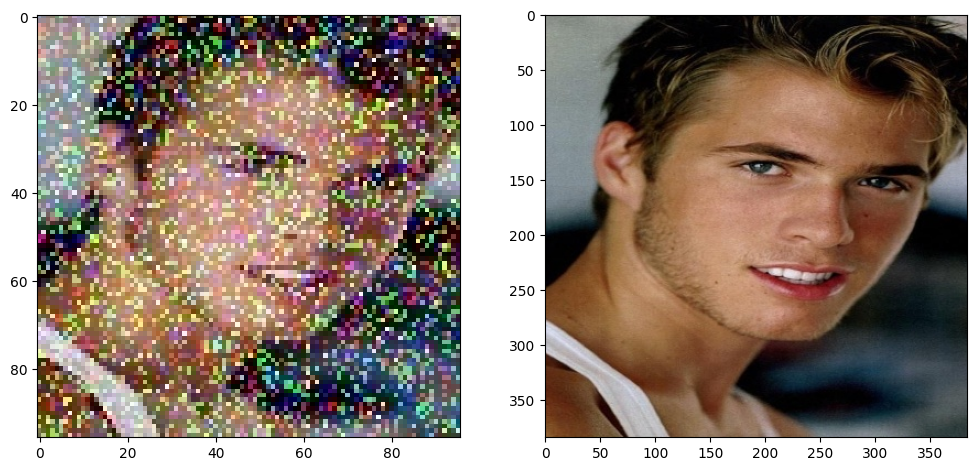

In [9]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (96, 96, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (384, 384, 3)))
plt.show()

In [10]:
#Scale values
lr_images = lr_images / 255.0
hr_images = hr_images / 255.0

In [18]:
#Split to train and test

hr_train=hr_images
lr_train=lr_images


hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)
#generator=load_model('gen_e1,1.h5',compile=False)
if os.path.exists("gen_e12,2.h5"):  # Replace <epoch> with the epoch number where you saved the generator
    generator = load_model("gen_e12,2.h5")
    print("Partially trained generator loaded.")
else:
    # If the partially trained generator does not exist, create a new one
    lr_ip = Input(shape=lr_shape)
    generator = create_gen(lr_ip, num_res_block=16)
    print("New generator created.")

generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((384,384,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Partially trained generator loaded.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 96, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 96, 96, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 96, 64)           36928     ['p_re_lu[0][0]']             
                                                          

In [15]:
#generator=load_model('gen_e1,1.h5',compile=False)

In [19]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 384, 384, 3)          2044291   ['input_12[0][0]']            
                                                                                                  
 input_13 (InputLayer)       [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 model_6 (Functional)        (None, 1)                    3066847   ['model[0][0]']               
                                                          37                                

In [20]:
batch_size = 2  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0]/ batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [22]:
epochs = 20
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss_1 = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss_1 = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss_1, "d_loss:", d_loss_1)

    if (e+1) % 1 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e15_gaus_"+ str(e+1) +".h5")


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 358ms/step


  0%|                                                                              | 1/2500 [00:25<17:50:53, 25.71s/it]

1/1 [==============================] - 0s 223ms/step


  0%|                                                                              | 2/2500 [00:44<15:10:24, 21.87s/it]

1/1 [==============================] - 0s 244ms/step


  0%|                                                                              | 3/2500 [01:03<14:13:16, 20.50s/it]

1/1 [==============================] - 0s 239ms/step


  0%|                                                                              | 4/2500 [01:22<13:39:37, 19.70s/it]

1/1 [==============================] - 0s 250ms/step


  0%|▏                                                                             | 5/2500 [01:41<13:28:04, 19.43s/it]

1/1 [==============================] - 0s 266ms/step


  0%|▏                                                                             | 6/2500 [02:00<13:31:54, 19.53s/it]

1/1 [==============================] - 0s 246ms/step


  0%|▏                                                                             | 7/2500 [02:20<13:26:13, 19.40s/it]

1/1 [==============================] - 0s 259ms/step


  0%|▏                                                                             | 8/2500 [02:39<13:21:18, 19.29s/it]

1/1 [==============================] - 0s 253ms/step


  0%|▎                                                                             | 9/2500 [02:57<13:13:57, 19.12s/it]

1/1 [==============================] - 0s 250ms/step


  0%|▎                                                                            | 10/2500 [03:17<13:16:05, 19.18s/it]

1/1 [==============================] - 0s 251ms/step


  0%|▎                                                                            | 11/2500 [03:35<13:08:15, 19.00s/it]

1/1 [==============================] - 0s 241ms/step


  0%|▎                                                                            | 12/2500 [03:54<13:07:25, 18.99s/it]

1/1 [==============================] - 0s 247ms/step


  1%|▍                                                                            | 13/2500 [04:14<13:10:35, 19.07s/it]

1/1 [==============================] - 0s 258ms/step


  1%|▍                                                                            | 14/2500 [04:33<13:16:53, 19.23s/it]

1/1 [==============================] - 0s 267ms/step


  1%|▍                                                                            | 15/2500 [04:53<13:18:41, 19.28s/it]

1/1 [==============================] - 0s 244ms/step


  1%|▍                                                                            | 16/2500 [05:12<13:15:06, 19.21s/it]

1/1 [==============================] - 0s 273ms/step


  1%|▌                                                                            | 17/2500 [05:31<13:21:25, 19.37s/it]

1/1 [==============================] - 0s 254ms/step


  1%|▌                                                                            | 18/2500 [05:51<13:26:24, 19.49s/it]

1/1 [==============================] - 0s 253ms/step


  1%|▌                                                                            | 19/2500 [06:11<13:28:09, 19.54s/it]

1/1 [==============================] - 0s 248ms/step


  1%|▌                                                                            | 20/2500 [06:30<13:27:10, 19.53s/it]

1/1 [==============================] - 0s 205ms/step


  1%|▋                                                                            | 21/2500 [06:50<13:30:19, 19.61s/it]

1/1 [==============================] - 0s 253ms/step


  1%|▋                                                                            | 22/2500 [07:09<13:23:00, 19.44s/it]

1/1 [==============================] - 0s 251ms/step


  1%|▋                                                                            | 23/2500 [07:28<13:21:07, 19.41s/it]

1/1 [==============================] - 0s 247ms/step


  1%|▋                                                                            | 24/2500 [07:47<13:15:09, 19.27s/it]

1/1 [==============================] - 0s 248ms/step


  1%|▊                                                                            | 25/2500 [08:06<13:13:09, 19.23s/it]

1/1 [==============================] - 0s 198ms/step


  1%|▊                                                                            | 26/2500 [08:25<13:08:04, 19.11s/it]

1/1 [==============================] - 0s 200ms/step


  1%|▊                                                                            | 27/2500 [08:44<13:06:19, 19.08s/it]

1/1 [==============================] - 0s 249ms/step


  1%|▊                                                                            | 28/2500 [09:03<13:05:02, 19.05s/it]

1/1 [==============================] - 0s 246ms/step


  1%|▉                                                                            | 29/2500 [09:22<13:01:30, 18.98s/it]

1/1 [==============================] - 0s 241ms/step


  1%|▉                                                                            | 30/2500 [09:41<13:01:00, 18.97s/it]

1/1 [==============================] - 0s 250ms/step


  1%|▉                                                                            | 31/2500 [10:00<13:03:39, 19.04s/it]

1/1 [==============================] - 0s 249ms/step


  1%|▉                                                                            | 32/2500 [10:19<13:00:47, 18.98s/it]

1/1 [==============================] - 0s 248ms/step


  1%|█                                                                            | 33/2500 [10:38<12:57:01, 18.90s/it]

1/1 [==============================] - 0s 249ms/step


  1%|█                                                                            | 34/2500 [10:57<12:57:17, 18.91s/it]

1/1 [==============================] - 0s 251ms/step


  1%|█                                                                            | 35/2500 [11:16<12:57:50, 18.93s/it]

1/1 [==============================] - 0s 242ms/step


  1%|█                                                                            | 36/2500 [11:35<13:03:34, 19.08s/it]

1/1 [==============================] - 0s 249ms/step


  1%|█▏                                                                           | 37/2500 [11:54<13:02:56, 19.07s/it]

1/1 [==============================] - 0s 204ms/step


  2%|█▏                                                                           | 38/2500 [12:13<13:02:06, 19.06s/it]

1/1 [==============================] - 0s 212ms/step


  2%|█▏                                                                           | 39/2500 [12:32<12:57:39, 18.96s/it]

1/1 [==============================] - 0s 255ms/step


  2%|█▏                                                                           | 40/2500 [12:51<12:59:08, 19.00s/it]

1/1 [==============================] - 0s 247ms/step


  2%|█▎                                                                           | 41/2500 [13:10<12:59:05, 19.01s/it]

1/1 [==============================] - 0s 245ms/step


  2%|█▎                                                                           | 42/2500 [13:29<13:00:30, 19.05s/it]

1/1 [==============================] - 0s 259ms/step


  2%|█▎                                                                           | 43/2500 [13:48<12:57:19, 18.98s/it]

1/1 [==============================] - 0s 251ms/step


  2%|█▎                                                                           | 44/2500 [14:07<12:56:42, 18.97s/it]

1/1 [==============================] - 0s 255ms/step


  2%|█▍                                                                           | 45/2500 [14:26<12:57:42, 19.01s/it]

1/1 [==============================] - 0s 253ms/step


  2%|█▍                                                                           | 46/2500 [14:45<12:58:24, 19.03s/it]

1/1 [==============================] - 0s 257ms/step


  2%|█▍                                                                           | 47/2500 [15:04<12:52:46, 18.90s/it]

1/1 [==============================] - 0s 258ms/step


  2%|█▍                                                                           | 48/2500 [15:23<12:55:19, 18.97s/it]

1/1 [==============================] - 0s 202ms/step


  2%|█▌                                                                           | 49/2500 [15:42<12:57:20, 19.03s/it]

1/1 [==============================] - 0s 198ms/step


  2%|█▌                                                                           | 50/2500 [16:01<12:56:41, 19.02s/it]

1/1 [==============================] - 0s 249ms/step


  2%|█▌                                                                           | 51/2500 [16:20<12:53:31, 18.95s/it]

1/1 [==============================] - 0s 212ms/step


  2%|█▌                                                                           | 52/2500 [16:39<12:57:21, 19.05s/it]

1/1 [==============================] - 0s 254ms/step


  2%|█▋                                                                           | 53/2500 [16:58<12:57:40, 19.07s/it]

1/1 [==============================] - 0s 206ms/step


  2%|█▋                                                                           | 54/2500 [17:18<13:01:01, 19.16s/it]

1/1 [==============================] - 0s 260ms/step


  2%|█▋                                                                           | 55/2500 [17:37<13:06:44, 19.31s/it]

1/1 [==============================] - 0s 272ms/step


  2%|█▋                                                                           | 56/2500 [17:57<13:08:28, 19.36s/it]

1/1 [==============================] - 0s 254ms/step


  2%|█▊                                                                           | 57/2500 [18:16<13:04:23, 19.26s/it]

1/1 [==============================] - 0s 250ms/step


  2%|█▊                                                                           | 58/2500 [18:35<13:01:11, 19.19s/it]

1/1 [==============================] - 0s 258ms/step


  2%|█▊                                                                           | 59/2500 [18:54<12:58:19, 19.13s/it]

1/1 [==============================] - 0s 263ms/step


  2%|█▊                                                                           | 60/2500 [19:13<12:57:45, 19.13s/it]

1/1 [==============================] - 0s 254ms/step


  2%|█▉                                                                           | 61/2500 [19:32<12:55:01, 19.07s/it]

1/1 [==============================] - 0s 247ms/step


  2%|█▉                                                                           | 62/2500 [19:51<12:54:46, 19.07s/it]

1/1 [==============================] - 0s 258ms/step


  3%|█▉                                                                           | 63/2500 [20:10<12:52:37, 19.02s/it]

1/1 [==============================] - 0s 251ms/step


  3%|█▉                                                                           | 64/2500 [20:29<12:52:32, 19.03s/it]

1/1 [==============================] - 0s 254ms/step


  3%|██                                                                           | 65/2500 [20:48<12:50:27, 18.98s/it]

1/1 [==============================] - 0s 258ms/step


  3%|██                                                                           | 66/2500 [21:07<12:50:43, 19.00s/it]

1/1 [==============================] - 0s 259ms/step


  3%|██                                                                           | 67/2500 [21:26<12:48:01, 18.94s/it]

1/1 [==============================] - 0s 244ms/step


  3%|██                                                                           | 68/2500 [21:45<12:49:04, 18.97s/it]

1/1 [==============================] - 0s 249ms/step


  3%|██▏                                                                          | 69/2500 [22:04<12:48:30, 18.97s/it]

1/1 [==============================] - 0s 232ms/step


  3%|██▏                                                                          | 70/2500 [22:23<12:51:06, 19.04s/it]

1/1 [==============================] - 0s 257ms/step


  3%|██▏                                                                          | 71/2500 [22:42<12:47:59, 18.97s/it]

1/1 [==============================] - 0s 249ms/step


  3%|██▏                                                                          | 72/2500 [23:01<12:47:03, 18.96s/it]

1/1 [==============================] - 0s 252ms/step


  3%|██▏                                                                          | 73/2500 [23:20<12:47:31, 18.97s/it]

1/1 [==============================] - 0s 256ms/step


  3%|██▎                                                                          | 74/2500 [23:38<12:45:53, 18.94s/it]

1/1 [==============================] - 0s 247ms/step


  3%|██▎                                                                          | 75/2500 [23:57<12:46:01, 18.95s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██▎                                                                          | 76/2500 [24:17<12:49:07, 19.04s/it]

1/1 [==============================] - 0s 264ms/step


  3%|██▎                                                                          | 77/2500 [24:35<12:45:17, 18.95s/it]

1/1 [==============================] - 0s 249ms/step


  3%|██▍                                                                          | 78/2500 [24:54<12:40:58, 18.85s/it]

1/1 [==============================] - 0s 255ms/step


  3%|██▍                                                                          | 79/2500 [25:12<12:34:57, 18.71s/it]

1/1 [==============================] - 0s 252ms/step


  3%|██▍                                                                          | 80/2500 [25:31<12:32:21, 18.65s/it]

1/1 [==============================] - 0s 261ms/step


  3%|██▍                                                                          | 81/2500 [25:49<12:30:08, 18.61s/it]

1/1 [==============================] - 0s 253ms/step


  3%|██▌                                                                          | 82/2500 [26:08<12:29:58, 18.61s/it]

1/1 [==============================] - 0s 264ms/step


  3%|██▌                                                                          | 83/2500 [26:27<12:28:44, 18.59s/it]

1/1 [==============================] - 0s 266ms/step


  3%|██▌                                                                          | 84/2500 [26:45<12:30:27, 18.64s/it]

1/1 [==============================] - 0s 258ms/step


  3%|██▌                                                                          | 85/2500 [27:03<12:21:16, 18.42s/it]

1/1 [==============================] - 0s 254ms/step


  3%|██▋                                                                          | 86/2500 [27:22<12:22:12, 18.45s/it]

1/1 [==============================] - 0s 250ms/step


  3%|██▋                                                                          | 87/2500 [27:41<12:25:37, 18.54s/it]

1/1 [==============================] - 0s 263ms/step


  4%|██▋                                                                          | 88/2500 [27:59<12:23:43, 18.50s/it]

1/1 [==============================] - 0s 250ms/step


  4%|██▋                                                                          | 89/2500 [28:18<12:25:58, 18.56s/it]

1/1 [==============================] - 0s 248ms/step


  4%|██▊                                                                          | 90/2500 [28:36<12:20:57, 18.45s/it]

1/1 [==============================] - 0s 251ms/step


  4%|██▊                                                                          | 91/2500 [28:54<12:21:22, 18.47s/it]

1/1 [==============================] - 0s 255ms/step


  4%|██▊                                                                          | 92/2500 [29:13<12:24:06, 18.54s/it]

1/1 [==============================] - 0s 249ms/step


  4%|██▊                                                                          | 93/2500 [29:32<12:24:20, 18.55s/it]

1/1 [==============================] - 0s 256ms/step


  4%|██▉                                                                          | 94/2500 [29:50<12:23:08, 18.53s/it]

1/1 [==============================] - 0s 246ms/step


  4%|██▉                                                                          | 95/2500 [30:09<12:22:38, 18.53s/it]

1/1 [==============================] - 0s 253ms/step


  4%|██▉                                                                          | 96/2500 [30:27<12:23:39, 18.56s/it]

1/1 [==============================] - 0s 259ms/step


  4%|██▉                                                                          | 97/2500 [30:46<12:20:52, 18.50s/it]

1/1 [==============================] - 0s 253ms/step


  4%|███                                                                          | 98/2500 [31:04<12:22:06, 18.54s/it]

1/1 [==============================] - 0s 247ms/step


  4%|███                                                                          | 99/2500 [31:22<12:14:28, 18.35s/it]

1/1 [==============================] - 0s 249ms/step


  4%|███                                                                         | 100/2500 [31:41<12:17:37, 18.44s/it]

1/1 [==============================] - 0s 256ms/step


  4%|███                                                                         | 101/2500 [31:59<12:18:15, 18.46s/it]

1/1 [==============================] - 0s 260ms/step


  4%|███                                                                         | 102/2500 [32:18<12:22:46, 18.58s/it]

1/1 [==============================] - 0s 243ms/step


  4%|███▏                                                                        | 103/2500 [32:37<12:22:00, 18.57s/it]

1/1 [==============================] - 0s 257ms/step


  4%|███▏                                                                        | 104/2500 [32:55<12:19:01, 18.51s/it]

1/1 [==============================] - 0s 242ms/step


  4%|███▏                                                                        | 105/2500 [33:14<12:20:07, 18.54s/it]

1/1 [==============================] - 0s 250ms/step


  4%|███▏                                                                        | 106/2500 [33:32<12:16:45, 18.47s/it]

1/1 [==============================] - 0s 247ms/step


  4%|███▎                                                                        | 107/2500 [33:51<12:19:17, 18.54s/it]

1/1 [==============================] - 0s 252ms/step


  4%|███▎                                                                        | 108/2500 [34:09<12:19:08, 18.54s/it]

1/1 [==============================] - 0s 258ms/step


  4%|███▎                                                                        | 109/2500 [34:28<12:16:34, 18.48s/it]

1/1 [==============================] - 0s 261ms/step


  4%|███▎                                                                        | 110/2500 [34:46<12:18:39, 18.54s/it]

1/1 [==============================] - 0s 248ms/step


  4%|███▎                                                                        | 111/2500 [35:05<12:16:33, 18.50s/it]

1/1 [==============================] - 0s 253ms/step


  4%|███▍                                                                        | 112/2500 [35:23<12:16:10, 18.50s/it]

1/1 [==============================] - 0s 255ms/step


  5%|███▍                                                                        | 113/2500 [35:42<12:17:46, 18.55s/it]

1/1 [==============================] - 0s 253ms/step


  5%|███▍                                                                        | 114/2500 [36:00<12:18:15, 18.56s/it]

1/1 [==============================] - 0s 248ms/step


  5%|███▍                                                                        | 115/2500 [36:19<12:18:14, 18.57s/it]

1/1 [==============================] - 0s 258ms/step


  5%|███▌                                                                        | 116/2500 [36:38<12:21:51, 18.67s/it]

1/1 [==============================] - 0s 258ms/step


  5%|███▌                                                                        | 117/2500 [36:56<12:15:01, 18.51s/it]

1/1 [==============================] - 0s 190ms/step


  5%|███▌                                                                        | 118/2500 [37:15<12:15:07, 18.52s/it]

1/1 [==============================] - 0s 247ms/step


  5%|███▌                                                                        | 119/2500 [37:33<12:13:36, 18.49s/it]

1/1 [==============================] - 0s 263ms/step


  5%|███▋                                                                        | 120/2500 [37:52<12:13:45, 18.50s/it]

1/1 [==============================] - 0s 252ms/step


  5%|███▋                                                                        | 121/2500 [38:10<12:13:03, 18.49s/it]

1/1 [==============================] - 0s 253ms/step


  5%|███▋                                                                        | 122/2500 [38:29<12:13:16, 18.50s/it]

1/1 [==============================] - 0s 262ms/step


  5%|███▋                                                                        | 123/2500 [38:47<12:13:51, 18.52s/it]

1/1 [==============================] - 0s 245ms/step


  5%|███▊                                                                        | 124/2500 [39:05<12:09:48, 18.43s/it]

1/1 [==============================] - 0s 252ms/step


  5%|███▊                                                                        | 125/2500 [39:24<12:10:40, 18.46s/it]

1/1 [==============================] - 0s 247ms/step


  5%|███▊                                                                        | 126/2500 [39:42<12:08:11, 18.40s/it]

1/1 [==============================] - 0s 254ms/step


  5%|███▊                                                                        | 127/2500 [40:01<12:09:35, 18.45s/it]

1/1 [==============================] - 0s 252ms/step


  5%|███▉                                                                        | 128/2500 [40:19<12:12:21, 18.53s/it]

1/1 [==============================] - 0s 250ms/step


  5%|███▉                                                                        | 129/2500 [40:38<12:12:49, 18.54s/it]

1/1 [==============================] - 0s 256ms/step


  5%|███▉                                                                        | 130/2500 [40:57<12:14:01, 18.58s/it]

1/1 [==============================] - 0s 260ms/step


  5%|███▉                                                                        | 131/2500 [41:15<12:12:04, 18.54s/it]

1/1 [==============================] - 0s 254ms/step


  5%|████                                                                        | 132/2500 [41:34<12:11:06, 18.52s/it]

1/1 [==============================] - 0s 248ms/step


  5%|████                                                                        | 133/2500 [41:52<12:10:49, 18.53s/it]

1/1 [==============================] - 0s 247ms/step


  5%|████                                                                        | 134/2500 [42:11<12:11:58, 18.56s/it]

1/1 [==============================] - 0s 245ms/step


  5%|████                                                                        | 135/2500 [42:29<12:07:47, 18.46s/it]

1/1 [==============================] - 0s 247ms/step


  5%|████▏                                                                       | 136/2500 [42:48<12:11:25, 18.56s/it]

1/1 [==============================] - 0s 194ms/step


  5%|████▏                                                                       | 137/2500 [43:06<12:06:18, 18.44s/it]

1/1 [==============================] - 0s 252ms/step


  6%|████▏                                                                       | 138/2500 [43:24<12:06:15, 18.45s/it]

1/1 [==============================] - 0s 250ms/step


  6%|████▏                                                                       | 139/2500 [43:43<12:09:40, 18.54s/it]

1/1 [==============================] - 0s 247ms/step


  6%|████▎                                                                       | 140/2500 [44:02<12:07:00, 18.48s/it]

1/1 [==============================] - 0s 252ms/step


  6%|████▎                                                                       | 141/2500 [44:20<12:11:41, 18.61s/it]

1/1 [==============================] - 0s 216ms/step


  6%|████▎                                                                       | 142/2500 [44:38<12:04:26, 18.43s/it]

1/1 [==============================] - 0s 252ms/step


  6%|████▎                                                                       | 143/2500 [44:57<12:05:05, 18.46s/it]

1/1 [==============================] - 0s 251ms/step


  6%|████▍                                                                       | 144/2500 [45:15<12:04:21, 18.45s/it]

1/1 [==============================] - 0s 262ms/step


  6%|████▍                                                                       | 145/2500 [45:34<12:05:33, 18.49s/it]

1/1 [==============================] - 0s 246ms/step


  6%|████▍                                                                       | 146/2500 [45:52<12:04:53, 18.48s/it]

1/1 [==============================] - 0s 251ms/step


  6%|████▍                                                                       | 147/2500 [46:11<12:10:51, 18.64s/it]

1/1 [==============================] - 0s 246ms/step


  6%|████▍                                                                       | 148/2500 [46:29<12:01:45, 18.41s/it]

1/1 [==============================] - 0s 252ms/step


  6%|████▌                                                                       | 149/2500 [46:48<12:01:36, 18.42s/it]

1/1 [==============================] - 0s 251ms/step


  6%|████▌                                                                       | 150/2500 [47:06<12:04:16, 18.49s/it]

1/1 [==============================] - 0s 255ms/step


  6%|████▌                                                                       | 151/2500 [47:25<12:08:17, 18.60s/it]

1/1 [==============================] - 0s 251ms/step


  6%|████▌                                                                       | 152/2500 [47:43<12:02:05, 18.45s/it]

1/1 [==============================] - 0s 249ms/step


  6%|████▋                                                                       | 153/2500 [48:03<12:10:33, 18.68s/it]

1/1 [==============================] - 0s 252ms/step


  6%|████▋                                                                       | 154/2500 [48:21<12:01:49, 18.46s/it]

1/1 [==============================] - 0s 262ms/step


  6%|████▋                                                                       | 155/2500 [48:39<12:00:39, 18.44s/it]

1/1 [==============================] - 0s 254ms/step


  6%|████▋                                                                       | 156/2500 [48:57<12:00:51, 18.45s/it]

1/1 [==============================] - 0s 195ms/step


  6%|████▊                                                                       | 157/2500 [49:16<12:04:26, 18.55s/it]

1/1 [==============================] - 0s 248ms/step


  6%|████▊                                                                       | 158/2500 [49:34<12:00:19, 18.45s/it]

1/1 [==============================] - 0s 248ms/step


  6%|████▊                                                                       | 159/2500 [49:54<12:08:39, 18.68s/it]

1/1 [==============================] - 0s 248ms/step


  6%|████▊                                                                       | 160/2500 [50:11<11:58:30, 18.42s/it]

1/1 [==============================] - 0s 259ms/step


  6%|████▉                                                                       | 161/2500 [50:30<12:02:25, 18.53s/it]

1/1 [==============================] - 0s 260ms/step


  6%|████▉                                                                       | 162/2500 [50:48<11:58:07, 18.43s/it]

1/1 [==============================] - 0s 247ms/step


  7%|████▉                                                                       | 163/2500 [51:07<11:57:59, 18.43s/it]

1/1 [==============================] - 0s 258ms/step


  7%|████▉                                                                       | 164/2500 [51:25<11:57:57, 18.44s/it]

1/1 [==============================] - 0s 278ms/step


  7%|█████                                                                       | 165/2500 [51:44<12:05:22, 18.64s/it]

1/1 [==============================] - 0s 258ms/step


  7%|█████                                                                       | 166/2500 [52:02<11:57:43, 18.45s/it]

1/1 [==============================] - 0s 263ms/step


  7%|█████                                                                       | 167/2500 [52:21<11:57:18, 18.45s/it]

1/1 [==============================] - 0s 264ms/step


  7%|█████                                                                       | 168/2500 [52:40<11:59:12, 18.50s/it]

1/1 [==============================] - 0s 259ms/step


  7%|█████▏                                                                      | 169/2500 [52:58<11:59:45, 18.53s/it]

1/1 [==============================] - 0s 255ms/step


  7%|█████▏                                                                      | 170/2500 [53:17<11:59:00, 18.52s/it]

1/1 [==============================] - 0s 248ms/step


  7%|█████▏                                                                      | 171/2500 [53:35<11:57:48, 18.49s/it]

1/1 [==============================] - 0s 269ms/step


  7%|█████▏                                                                      | 172/2500 [53:53<11:51:29, 18.34s/it]

1/1 [==============================] - 0s 251ms/step


  7%|█████▎                                                                      | 173/2500 [54:12<11:55:01, 18.44s/it]

1/1 [==============================] - 0s 259ms/step


  7%|█████▎                                                                      | 174/2500 [54:30<11:53:43, 18.41s/it]

1/1 [==============================] - 0s 206ms/step


  7%|█████▎                                                                      | 175/2500 [54:48<11:53:57, 18.42s/it]

1/1 [==============================] - 0s 263ms/step


  7%|█████▎                                                                      | 176/2500 [55:08<12:00:47, 18.61s/it]

1/1 [==============================] - 0s 254ms/step


  7%|█████▍                                                                      | 177/2500 [55:25<11:52:50, 18.41s/it]

1/1 [==============================] - 0s 208ms/step


  7%|█████▍                                                                      | 178/2500 [55:44<11:54:52, 18.47s/it]

1/1 [==============================] - 0s 191ms/step


  7%|█████▍                                                                      | 179/2500 [56:03<11:55:39, 18.50s/it]

1/1 [==============================] - 0s 196ms/step


  7%|█████▍                                                                      | 180/2500 [56:21<11:58:33, 18.58s/it]

1/1 [==============================] - 0s 261ms/step


  7%|█████▌                                                                      | 181/2500 [56:40<12:00:48, 18.65s/it]

1/1 [==============================] - 0s 193ms/step


  7%|█████▌                                                                      | 182/2500 [56:58<11:54:29, 18.49s/it]

1/1 [==============================] - 0s 261ms/step


  7%|█████▌                                                                      | 183/2500 [57:17<11:56:44, 18.56s/it]

1/1 [==============================] - 0s 195ms/step


  7%|█████▌                                                                      | 184/2500 [57:35<11:53:04, 18.47s/it]

1/1 [==============================] - 0s 196ms/step


  7%|█████▌                                                                      | 185/2500 [57:54<11:57:17, 18.59s/it]

1/1 [==============================] - 0s 256ms/step


  7%|█████▋                                                                      | 186/2500 [58:12<11:52:13, 18.47s/it]

1/1 [==============================] - 0s 280ms/step


  7%|█████▋                                                                      | 187/2500 [58:31<11:51:30, 18.46s/it]

1/1 [==============================] - 0s 258ms/step


  8%|█████▋                                                                      | 188/2500 [58:49<11:53:35, 18.52s/it]

1/1 [==============================] - 0s 252ms/step


  8%|█████▋                                                                      | 189/2500 [59:08<11:57:04, 18.62s/it]

1/1 [==============================] - 0s 195ms/step


  8%|█████▊                                                                      | 190/2500 [59:27<11:52:12, 18.50s/it]

1/1 [==============================] - 0s 255ms/step


  8%|█████▊                                                                      | 191/2500 [59:46<11:57:18, 18.64s/it]

1/1 [==============================] - 0s 258ms/step


  8%|█████▋                                                                    | 192/2500 [1:00:03<11:48:21, 18.41s/it]

1/1 [==============================] - 0s 262ms/step


  8%|█████▋                                                                    | 193/2500 [1:00:22<11:48:12, 18.42s/it]

1/1 [==============================] - 0s 250ms/step


  8%|█████▋                                                                    | 194/2500 [1:00:40<11:48:04, 18.42s/it]

1/1 [==============================] - 0s 260ms/step


  8%|█████▊                                                                    | 195/2500 [1:00:59<11:54:35, 18.60s/it]

1/1 [==============================] - 0s 256ms/step


  8%|█████▊                                                                    | 196/2500 [1:01:17<11:45:25, 18.37s/it]

1/1 [==============================] - 0s 247ms/step


  8%|█████▊                                                                    | 197/2500 [1:01:36<11:50:51, 18.52s/it]

1/1 [==============================] - 0s 254ms/step


  8%|█████▊                                                                    | 198/2500 [1:01:54<11:48:22, 18.46s/it]

1/1 [==============================] - 0s 248ms/step


  8%|█████▉                                                                    | 199/2500 [1:02:13<11:47:38, 18.45s/it]

1/1 [==============================] - 0s 238ms/step


  8%|█████▉                                                                    | 200/2500 [1:02:32<11:51:26, 18.56s/it]

1/1 [==============================] - 0s 249ms/step


  8%|█████▉                                                                    | 201/2500 [1:02:50<11:55:28, 18.67s/it]

1/1 [==============================] - 0s 250ms/step


  8%|█████▉                                                                    | 202/2500 [1:03:08<11:44:10, 18.39s/it]

1/1 [==============================] - 0s 249ms/step


  8%|██████                                                                    | 203/2500 [1:03:27<11:47:18, 18.48s/it]

1/1 [==============================] - 0s 250ms/step


  8%|██████                                                                    | 204/2500 [1:03:46<11:48:45, 18.52s/it]

1/1 [==============================] - 0s 250ms/step


  8%|██████                                                                    | 205/2500 [1:04:04<11:50:01, 18.56s/it]

1/1 [==============================] - 0s 247ms/step


  8%|██████                                                                    | 206/2500 [1:04:23<11:47:13, 18.50s/it]

1/1 [==============================] - 0s 254ms/step


  8%|██████▏                                                                   | 207/2500 [1:04:41<11:45:49, 18.47s/it]

1/1 [==============================] - 0s 255ms/step


  8%|██████▏                                                                   | 208/2500 [1:05:00<11:50:36, 18.60s/it]

1/1 [==============================] - 0s 250ms/step


  8%|██████▏                                                                   | 209/2500 [1:05:18<11:44:38, 18.45s/it]

1/1 [==============================] - 0s 249ms/step


  8%|██████▏                                                                   | 210/2500 [1:05:37<11:47:31, 18.54s/it]

1/1 [==============================] - 0s 222ms/step


  8%|██████▏                                                                   | 211/2500 [1:05:55<11:48:48, 18.58s/it]

1/1 [==============================] - 0s 259ms/step


  8%|██████▎                                                                   | 212/2500 [1:06:13<11:42:32, 18.42s/it]

1/1 [==============================] - 0s 248ms/step


  9%|██████▎                                                                   | 213/2500 [1:06:32<11:49:20, 18.61s/it]

1/1 [==============================] - 0s 254ms/step


  9%|██████▎                                                                   | 214/2500 [1:06:50<11:39:57, 18.37s/it]

1/1 [==============================] - 0s 250ms/step


  9%|██████▎                                                                   | 215/2500 [1:07:09<11:45:08, 18.52s/it]

1/1 [==============================] - 0s 246ms/step


  9%|██████▍                                                                   | 216/2500 [1:07:28<11:46:54, 18.57s/it]

1/1 [==============================] - 0s 249ms/step


  9%|██████▍                                                                   | 217/2500 [1:07:46<11:39:48, 18.39s/it]

1/1 [==============================] - 0s 243ms/step


  9%|██████▍                                                                   | 218/2500 [1:08:04<11:40:32, 18.42s/it]

1/1 [==============================] - 0s 206ms/step


  9%|██████▍                                                                   | 219/2500 [1:08:23<11:42:49, 18.49s/it]

1/1 [==============================] - 0s 246ms/step


  9%|██████▌                                                                   | 220/2500 [1:08:41<11:41:05, 18.45s/it]

1/1 [==============================] - 0s 243ms/step


  9%|██████▌                                                                   | 221/2500 [1:09:00<11:47:19, 18.62s/it]

1/1 [==============================] - 0s 250ms/step


  9%|██████▌                                                                   | 222/2500 [1:09:18<11:37:47, 18.38s/it]

1/1 [==============================] - 0s 248ms/step


  9%|██████▌                                                                   | 223/2500 [1:09:37<11:40:48, 18.47s/it]

1/1 [==============================] - 0s 245ms/step


  9%|██████▋                                                                   | 224/2500 [1:09:56<11:43:32, 18.55s/it]

1/1 [==============================] - 0s 259ms/step


  9%|██████▋                                                                   | 225/2500 [1:10:15<11:48:41, 18.69s/it]

1/1 [==============================] - 0s 193ms/step


  9%|██████▋                                                                   | 226/2500 [1:10:32<11:38:30, 18.43s/it]

1/1 [==============================] - 0s 254ms/step


  9%|██████▋                                                                   | 227/2500 [1:10:51<11:36:38, 18.39s/it]

1/1 [==============================] - 0s 245ms/step


  9%|██████▋                                                                   | 228/2500 [1:11:09<11:36:43, 18.40s/it]

1/1 [==============================] - 0s 257ms/step


  9%|██████▊                                                                   | 229/2500 [1:11:28<11:41:35, 18.54s/it]

1/1 [==============================] - 0s 197ms/step


  9%|██████▊                                                                   | 230/2500 [1:11:46<11:36:18, 18.40s/it]

1/1 [==============================] - 0s 262ms/step


  9%|██████▊                                                                   | 231/2500 [1:12:05<11:40:21, 18.52s/it]

1/1 [==============================] - 0s 266ms/step


  9%|██████▊                                                                   | 232/2500 [1:12:23<11:40:08, 18.52s/it]

1/1 [==============================] - 0s 248ms/step


  9%|██████▉                                                                   | 233/2500 [1:12:41<11:33:29, 18.35s/it]

1/1 [==============================] - 0s 258ms/step


  9%|██████▉                                                                   | 234/2500 [1:13:01<11:42:37, 18.60s/it]

1/1 [==============================] - 0s 194ms/step


  9%|██████▉                                                                   | 235/2500 [1:13:18<11:33:30, 18.37s/it]

1/1 [==============================] - 0s 264ms/step


  9%|██████▉                                                                   | 236/2500 [1:13:37<11:34:34, 18.41s/it]

1/1 [==============================] - 0s 209ms/step


  9%|███████                                                                   | 237/2500 [1:13:55<11:35:06, 18.43s/it]

1/1 [==============================] - 0s 244ms/step


 10%|███████                                                                   | 238/2500 [1:14:14<11:36:14, 18.47s/it]

1/1 [==============================] - 0s 250ms/step


 10%|███████                                                                   | 239/2500 [1:14:32<11:35:55, 18.47s/it]

1/1 [==============================] - 0s 261ms/step


 10%|███████                                                                   | 240/2500 [1:14:51<11:42:10, 18.64s/it]

1/1 [==============================] - 0s 195ms/step


 10%|███████▏                                                                  | 241/2500 [1:15:10<11:37:54, 18.54s/it]

1/1 [==============================] - 0s 258ms/step


 10%|███████▏                                                                  | 242/2500 [1:15:28<11:31:17, 18.37s/it]

1/1 [==============================] - 0s 259ms/step


 10%|███████▏                                                                  | 243/2500 [1:15:46<11:32:47, 18.42s/it]

1/1 [==============================] - 0s 258ms/step


 10%|███████▏                                                                  | 244/2500 [1:16:05<11:35:45, 18.50s/it]

1/1 [==============================] - 0s 256ms/step


 10%|███████▎                                                                  | 245/2500 [1:16:23<11:35:38, 18.51s/it]

1/1 [==============================] - 0s 242ms/step


 10%|███████▎                                                                  | 246/2500 [1:16:42<11:34:45, 18.49s/it]

1/1 [==============================] - 0s 253ms/step


 10%|███████▎                                                                  | 247/2500 [1:17:00<11:35:50, 18.53s/it]

1/1 [==============================] - 0s 199ms/step


 10%|███████▎                                                                  | 248/2500 [1:17:19<11:40:42, 18.67s/it]

1/1 [==============================] - 0s 247ms/step


 10%|███████▎                                                                  | 249/2500 [1:17:38<11:33:21, 18.48s/it]

1/1 [==============================] - 0s 247ms/step


 10%|███████▍                                                                  | 250/2500 [1:17:56<11:36:37, 18.58s/it]

1/1 [==============================] - 0s 247ms/step


 10%|███████▍                                                                  | 251/2500 [1:18:14<11:28:08, 18.36s/it]

1/1 [==============================] - 0s 246ms/step


 10%|███████▍                                                                  | 252/2500 [1:18:33<11:30:32, 18.43s/it]

1/1 [==============================] - 0s 247ms/step


 10%|███████▍                                                                  | 253/2500 [1:18:51<11:31:39, 18.47s/it]

1/1 [==============================] - 0s 208ms/step


 10%|███████▌                                                                  | 254/2500 [1:19:10<11:38:43, 18.67s/it]

1/1 [==============================] - 0s 196ms/step


 10%|███████▌                                                                  | 255/2500 [1:19:28<11:29:13, 18.42s/it]

1/1 [==============================] - 0s 257ms/step


 10%|███████▌                                                                  | 256/2500 [1:19:48<11:37:56, 18.66s/it]

1/1 [==============================] - 0s 247ms/step


 10%|███████▌                                                                  | 257/2500 [1:20:06<11:30:08, 18.46s/it]

1/1 [==============================] - 0s 248ms/step


 10%|███████▋                                                                  | 258/2500 [1:20:24<11:29:54, 18.46s/it]

1/1 [==============================] - 0s 262ms/step


 10%|███████▋                                                                  | 259/2500 [1:20:43<11:30:30, 18.49s/it]

1/1 [==============================] - 0s 256ms/step


 10%|███████▋                                                                  | 260/2500 [1:21:01<11:34:19, 18.60s/it]

1/1 [==============================] - 0s 247ms/step


 10%|███████▋                                                                  | 261/2500 [1:21:19<11:26:44, 18.40s/it]

1/1 [==============================] - 0s 257ms/step


 10%|███████▊                                                                  | 262/2500 [1:21:38<11:29:42, 18.49s/it]

1/1 [==============================] - 0s 250ms/step


 11%|███████▊                                                                  | 263/2500 [1:21:57<11:29:17, 18.49s/it]

1/1 [==============================] - 0s 195ms/step


 11%|███████▊                                                                  | 264/2500 [1:22:15<11:33:56, 18.62s/it]

1/1 [==============================] - 0s 195ms/step


 11%|███████▊                                                                  | 265/2500 [1:22:34<11:31:38, 18.57s/it]

1/1 [==============================] - 0s 195ms/step


 11%|███████▊                                                                  | 266/2500 [1:22:52<11:27:53, 18.47s/it]

1/1 [==============================] - 0s 259ms/step


 11%|███████▉                                                                  | 267/2500 [1:23:10<11:22:00, 18.33s/it]

1/1 [==============================] - 0s 194ms/step


 11%|███████▉                                                                  | 268/2500 [1:23:29<11:24:45, 18.41s/it]

1/1 [==============================] - 0s 201ms/step


 11%|███████▉                                                                  | 269/2500 [1:23:47<11:27:18, 18.48s/it]

1/1 [==============================] - 0s 252ms/step


 11%|███████▉                                                                  | 270/2500 [1:24:06<11:27:19, 18.49s/it]

1/1 [==============================] - 0s 255ms/step


 11%|████████                                                                  | 271/2500 [1:24:25<11:28:56, 18.54s/it]

1/1 [==============================] - 0s 245ms/step


 11%|████████                                                                  | 272/2500 [1:24:43<11:32:44, 18.66s/it]

1/1 [==============================] - 0s 244ms/step


 11%|████████                                                                  | 273/2500 [1:25:01<11:22:47, 18.40s/it]

1/1 [==============================] - 0s 244ms/step


 11%|████████                                                                  | 274/2500 [1:25:20<11:25:07, 18.47s/it]

1/1 [==============================] - 0s 242ms/step


 11%|████████▏                                                                 | 275/2500 [1:25:38<11:24:39, 18.46s/it]

1/1 [==============================] - 0s 252ms/step


 11%|████████▏                                                                 | 276/2500 [1:25:57<11:31:34, 18.66s/it]

1/1 [==============================] - 0s 254ms/step


 11%|████████▏                                                                 | 277/2500 [1:26:16<11:24:36, 18.48s/it]

1/1 [==============================] - 0s 253ms/step


 11%|████████▏                                                                 | 278/2500 [1:26:34<11:22:56, 18.44s/it]

1/1 [==============================] - 0s 257ms/step


 11%|████████▎                                                                 | 279/2500 [1:26:53<11:26:20, 18.54s/it]

1/1 [==============================] - 0s 257ms/step


 11%|████████▎                                                                 | 280/2500 [1:27:11<11:26:23, 18.55s/it]

1/1 [==============================] - 0s 243ms/step


 11%|████████▎                                                                 | 281/2500 [1:27:29<11:21:39, 18.43s/it]

1/1 [==============================] - 0s 259ms/step


 11%|████████▎                                                                 | 282/2500 [1:27:48<11:21:09, 18.43s/it]

1/1 [==============================] - 0s 237ms/step


 11%|████████▍                                                                 | 283/2500 [1:28:06<11:23:11, 18.49s/it]

1/1 [==============================] - 0s 252ms/step


 11%|████████▍                                                                 | 284/2500 [1:28:25<11:27:07, 18.60s/it]

1/1 [==============================] - 0s 255ms/step


 11%|████████▍                                                                 | 285/2500 [1:28:43<11:18:18, 18.37s/it]

1/1 [==============================] - 0s 252ms/step


 11%|████████▍                                                                 | 286/2500 [1:29:02<11:20:33, 18.44s/it]

1/1 [==============================] - 0s 207ms/step


 11%|████████▍                                                                 | 287/2500 [1:29:20<11:22:32, 18.51s/it]

1/1 [==============================] - 0s 246ms/step


 12%|████████▌                                                                 | 288/2500 [1:29:40<11:31:35, 18.76s/it]

1/1 [==============================] - 0s 244ms/step


 12%|████████▌                                                                 | 289/2500 [1:29:57<11:19:41, 18.44s/it]

1/1 [==============================] - 0s 247ms/step


 12%|████████▌                                                                 | 290/2500 [1:30:17<11:26:36, 18.64s/it]

1/1 [==============================] - 0s 196ms/step


 12%|████████▌                                                                 | 291/2500 [1:30:34<11:16:47, 18.38s/it]

1/1 [==============================] - 0s 247ms/step


 12%|████████▋                                                                 | 292/2500 [1:30:53<11:23:55, 18.59s/it]

1/1 [==============================] - 0s 247ms/step


 12%|████████▋                                                                 | 293/2500 [1:31:12<11:18:54, 18.46s/it]

1/1 [==============================] - 0s 245ms/step


 12%|████████▋                                                                 | 294/2500 [1:31:30<11:19:51, 18.49s/it]

1/1 [==============================] - 0s 254ms/step


 12%|████████▋                                                                 | 295/2500 [1:31:48<11:17:40, 18.44s/it]

1/1 [==============================] - 0s 250ms/step


 12%|████████▊                                                                 | 296/2500 [1:32:07<11:17:35, 18.45s/it]

1/1 [==============================] - 0s 245ms/step


 12%|████████▊                                                                 | 297/2500 [1:32:25<11:17:49, 18.46s/it]

1/1 [==============================] - 0s 194ms/step


 12%|████████▊                                                                 | 298/2500 [1:32:44<11:16:25, 18.43s/it]

1/1 [==============================] - 0s 244ms/step


 12%|████████▊                                                                 | 299/2500 [1:33:02<11:18:39, 18.50s/it]

1/1 [==============================] - 0s 267ms/step


 12%|████████▉                                                                 | 300/2500 [1:33:21<11:20:40, 18.56s/it]

1/1 [==============================] - 0s 250ms/step


 12%|████████▉                                                                 | 301/2500 [1:33:39<11:15:35, 18.43s/it]

1/1 [==============================] - 0s 249ms/step


 12%|████████▉                                                                 | 302/2500 [1:33:58<11:18:00, 18.51s/it]

1/1 [==============================] - 0s 247ms/step


 12%|████████▉                                                                 | 303/2500 [1:34:17<11:18:22, 18.53s/it]

1/1 [==============================] - 0s 252ms/step


 12%|████████▉                                                                 | 304/2500 [1:34:35<11:21:23, 18.62s/it]

1/1 [==============================] - 0s 251ms/step


 12%|█████████                                                                 | 305/2500 [1:34:53<11:11:33, 18.36s/it]

1/1 [==============================] - 0s 248ms/step


 12%|█████████                                                                 | 306/2500 [1:35:12<11:14:22, 18.44s/it]

1/1 [==============================] - 0s 244ms/step


 12%|█████████                                                                 | 307/2500 [1:35:30<11:16:19, 18.50s/it]

1/1 [==============================] - 0s 250ms/step


 12%|█████████                                                                 | 308/2500 [1:35:49<11:17:04, 18.53s/it]

1/1 [==============================] - 0s 246ms/step


 12%|█████████▏                                                                | 309/2500 [1:36:08<11:17:50, 18.56s/it]

1/1 [==============================] - 0s 250ms/step


 12%|█████████▏                                                                | 310/2500 [1:36:26<11:20:20, 18.64s/it]

1/1 [==============================] - 0s 245ms/step


 12%|█████████▏                                                                | 311/2500 [1:36:44<11:11:08, 18.40s/it]

1/1 [==============================] - 0s 244ms/step


 12%|█████████▏                                                                | 312/2500 [1:37:03<11:18:24, 18.60s/it]

1/1 [==============================] - 0s 242ms/step


 13%|█████████▎                                                                | 313/2500 [1:37:21<11:11:11, 18.41s/it]

1/1 [==============================] - 0s 249ms/step


 13%|█████████▎                                                                | 314/2500 [1:37:40<11:15:56, 18.55s/it]

1/1 [==============================] - 0s 194ms/step


 13%|█████████▎                                                                | 315/2500 [1:37:59<11:16:45, 18.58s/it]

1/1 [==============================] - 0s 248ms/step


 13%|█████████▎                                                                | 316/2500 [1:38:17<11:09:19, 18.39s/it]

1/1 [==============================] - 0s 251ms/step


 13%|█████████▍                                                                | 317/2500 [1:38:35<11:11:24, 18.45s/it]

1/1 [==============================] - 0s 206ms/step


 13%|█████████▍                                                                | 318/2500 [1:38:54<11:10:17, 18.43s/it]

1/1 [==============================] - 0s 251ms/step


 13%|█████████▍                                                                | 319/2500 [1:39:12<11:11:53, 18.48s/it]

1/1 [==============================] - 0s 241ms/step


 13%|█████████▍                                                                | 320/2500 [1:39:31<11:11:16, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 13%|█████████▌                                                                | 321/2500 [1:39:50<11:14:59, 18.59s/it]

1/1 [==============================] - 0s 200ms/step


 13%|█████████▌                                                                | 322/2500 [1:40:08<11:12:11, 18.52s/it]

1/1 [==============================] - 0s 257ms/step


 13%|█████████▌                                                                | 323/2500 [1:40:26<11:10:29, 18.48s/it]

1/1 [==============================] - 0s 246ms/step


 13%|█████████▌                                                                | 324/2500 [1:40:46<11:18:34, 18.71s/it]

1/1 [==============================] - 0s 248ms/step


 13%|█████████▌                                                                | 325/2500 [1:41:04<11:12:02, 18.54s/it]

1/1 [==============================] - 0s 242ms/step


 13%|█████████▋                                                                | 326/2500 [1:41:22<11:11:44, 18.54s/it]

1/1 [==============================] - 0s 196ms/step


 13%|█████████▋                                                                | 327/2500 [1:41:40<11:04:14, 18.34s/it]

1/1 [==============================] - 0s 248ms/step


 13%|█████████▋                                                                | 328/2500 [1:41:59<11:06:14, 18.40s/it]

1/1 [==============================] - 0s 252ms/step


 13%|█████████▋                                                                | 329/2500 [1:42:17<11:06:49, 18.43s/it]

1/1 [==============================] - 0s 249ms/step


 13%|█████████▊                                                                | 330/2500 [1:42:36<11:12:55, 18.61s/it]

1/1 [==============================] - 0s 194ms/step


 13%|█████████▊                                                                | 331/2500 [1:42:54<11:05:45, 18.42s/it]

1/1 [==============================] - 0s 254ms/step


 13%|█████████▊                                                                | 332/2500 [1:43:13<11:08:32, 18.50s/it]

1/1 [==============================] - 0s 257ms/step


 13%|█████████▊                                                                | 333/2500 [1:43:31<11:03:52, 18.38s/it]

1/1 [==============================] - 0s 244ms/step


 13%|█████████▉                                                                | 334/2500 [1:43:50<11:11:56, 18.61s/it]

1/1 [==============================] - 0s 253ms/step


 13%|█████████▉                                                                | 335/2500 [1:44:08<11:04:48, 18.42s/it]

1/1 [==============================] - 0s 247ms/step


 13%|█████████▉                                                                | 336/2500 [1:44:27<11:09:55, 18.57s/it]

1/1 [==============================] - 0s 257ms/step


 13%|█████████▉                                                                | 337/2500 [1:44:45<11:05:14, 18.45s/it]

1/1 [==============================] - 0s 252ms/step


 14%|██████████                                                                | 338/2500 [1:45:04<11:05:26, 18.47s/it]

1/1 [==============================] - 0s 209ms/step


 14%|██████████                                                                | 339/2500 [1:45:22<11:07:28, 18.53s/it]

1/1 [==============================] - 0s 255ms/step


 14%|██████████                                                                | 340/2500 [1:45:41<11:05:30, 18.49s/it]

1/1 [==============================] - 0s 252ms/step


 14%|██████████                                                                | 341/2500 [1:45:59<11:05:59, 18.51s/it]

1/1 [==============================] - 0s 252ms/step


 14%|██████████                                                                | 342/2500 [1:46:18<11:07:57, 18.57s/it]

1/1 [==============================] - 0s 253ms/step


 14%|██████████▏                                                               | 343/2500 [1:46:36<11:03:44, 18.46s/it]

1/1 [==============================] - 0s 246ms/step


 14%|██████████▏                                                               | 344/2500 [1:46:55<11:02:43, 18.44s/it]

1/1 [==============================] - 0s 249ms/step


 14%|██████████▏                                                               | 345/2500 [1:47:13<11:03:29, 18.47s/it]

1/1 [==============================] - 0s 243ms/step


 14%|██████████▏                                                               | 346/2500 [1:47:32<11:04:22, 18.51s/it]

1/1 [==============================] - 0s 247ms/step


 14%|██████████▎                                                               | 347/2500 [1:47:50<11:03:23, 18.49s/it]

1/1 [==============================] - 0s 249ms/step


 14%|██████████▎                                                               | 348/2500 [1:48:09<11:07:38, 18.61s/it]

1/1 [==============================] - 0s 244ms/step


 14%|██████████▎                                                               | 349/2500 [1:48:27<11:01:19, 18.45s/it]

1/1 [==============================] - 0s 244ms/step


 14%|██████████▎                                                               | 350/2500 [1:48:46<11:06:40, 18.60s/it]

1/1 [==============================] - 0s 222ms/step


 14%|██████████▍                                                               | 351/2500 [1:49:04<11:00:41, 18.45s/it]

1/1 [==============================] - 0s 248ms/step


 14%|██████████▍                                                               | 352/2500 [1:49:23<11:02:02, 18.49s/it]

1/1 [==============================] - 0s 250ms/step


 14%|██████████▍                                                               | 353/2500 [1:49:41<11:01:32, 18.49s/it]

1/1 [==============================] - 0s 251ms/step


 14%|██████████▍                                                               | 354/2500 [1:50:01<11:08:40, 18.70s/it]

1/1 [==============================] - 0s 246ms/step


 14%|██████████▌                                                               | 355/2500 [1:50:19<11:00:52, 18.49s/it]

1/1 [==============================] - 0s 197ms/step


 14%|██████████▌                                                               | 356/2500 [1:50:37<10:59:37, 18.46s/it]

1/1 [==============================] - 0s 196ms/step


 14%|██████████▌                                                               | 357/2500 [1:50:55<10:59:39, 18.47s/it]

1/1 [==============================] - 0s 252ms/step


 14%|██████████▌                                                               | 358/2500 [1:51:14<10:59:30, 18.47s/it]

1/1 [==============================] - 0s 249ms/step


 14%|██████████▋                                                               | 359/2500 [1:51:33<11:05:29, 18.65s/it]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▋                                                               | 360/2500 [1:51:51<10:58:24, 18.46s/it]

1/1 [==============================] - 0s 240ms/step


 14%|██████████▋                                                               | 361/2500 [1:52:10<11:01:23, 18.55s/it]

1/1 [==============================] - 0s 245ms/step


 14%|██████████▋                                                               | 362/2500 [1:52:28<10:59:35, 18.51s/it]

1/1 [==============================] - 0s 247ms/step


 15%|██████████▋                                                               | 363/2500 [1:52:47<11:01:33, 18.57s/it]

1/1 [==============================] - 0s 248ms/step


 15%|██████████▊                                                               | 364/2500 [1:53:06<11:01:17, 18.58s/it]

1/1 [==============================] - 0s 197ms/step


 15%|██████████▊                                                               | 365/2500 [1:53:24<10:59:03, 18.52s/it]

1/1 [==============================] - 0s 252ms/step


 15%|██████████▊                                                               | 366/2500 [1:53:42<10:54:21, 18.40s/it]

1/1 [==============================] - 0s 252ms/step


 15%|██████████▊                                                               | 367/2500 [1:54:01<10:56:51, 18.48s/it]

1/1 [==============================] - 0s 245ms/step


 15%|██████████▉                                                               | 368/2500 [1:54:19<10:55:45, 18.45s/it]

1/1 [==============================] - 0s 245ms/step


 15%|██████████▉                                                               | 369/2500 [1:54:38<10:57:26, 18.51s/it]

1/1 [==============================] - 0s 248ms/step


 15%|██████████▉                                                               | 370/2500 [1:54:56<10:58:12, 18.54s/it]

1/1 [==============================] - 0s 250ms/step


 15%|██████████▉                                                               | 371/2500 [1:55:15<10:57:42, 18.54s/it]

1/1 [==============================] - 0s 195ms/step


 15%|███████████                                                               | 372/2500 [1:55:33<10:56:43, 18.52s/it]

1/1 [==============================] - 0s 249ms/step


 15%|███████████                                                               | 373/2500 [1:55:52<10:56:16, 18.51s/it]

1/1 [==============================] - 0s 244ms/step


 15%|███████████                                                               | 374/2500 [1:56:10<10:56:37, 18.53s/it]

1/1 [==============================] - 0s 248ms/step


 15%|███████████                                                               | 375/2500 [1:56:29<10:59:26, 18.62s/it]

1/1 [==============================] - 0s 195ms/step


 15%|███████████▏                                                              | 376/2500 [1:56:47<10:52:55, 18.44s/it]

1/1 [==============================] - 0s 206ms/step


 15%|███████████▏                                                              | 377/2500 [1:57:06<11:00:43, 18.67s/it]

1/1 [==============================] - 0s 196ms/step


 15%|███████████▏                                                              | 378/2500 [1:57:24<10:50:24, 18.39s/it]

1/1 [==============================] - 0s 255ms/step


 15%|███████████▏                                                              | 379/2500 [1:57:43<10:55:00, 18.53s/it]

1/1 [==============================] - 0s 251ms/step


 15%|███████████▏                                                              | 380/2500 [1:58:02<10:55:19, 18.55s/it]

1/1 [==============================] - 0s 253ms/step


 15%|███████████▎                                                              | 381/2500 [1:58:20<10:53:50, 18.51s/it]

1/1 [==============================] - 0s 253ms/step


 15%|███████████▎                                                              | 382/2500 [1:58:38<10:51:47, 18.46s/it]

1/1 [==============================] - 0s 244ms/step


 15%|███████████▎                                                              | 383/2500 [1:58:57<10:52:22, 18.49s/it]

1/1 [==============================] - 0s 195ms/step


 15%|███████████▎                                                              | 384/2500 [1:59:16<10:59:14, 18.69s/it]

1/1 [==============================] - 0s 243ms/step


 15%|███████████▍                                                              | 385/2500 [1:59:34<10:53:19, 18.53s/it]

1/1 [==============================] - 0s 246ms/step


 15%|███████████▍                                                              | 386/2500 [1:59:53<10:49:30, 18.43s/it]

1/1 [==============================] - 0s 243ms/step


 15%|███████████▍                                                              | 387/2500 [2:00:11<10:54:07, 18.57s/it]

1/1 [==============================] - 0s 196ms/step


 16%|███████████▍                                                              | 388/2500 [2:00:30<10:49:07, 18.44s/it]

1/1 [==============================] - 0s 248ms/step


 16%|███████████▌                                                              | 389/2500 [2:00:48<10:49:17, 18.45s/it]

1/1 [==============================] - 0s 246ms/step


 16%|███████████▌                                                              | 390/2500 [2:01:07<10:52:25, 18.55s/it]

1/1 [==============================] - 0s 252ms/step


 16%|███████████▌                                                              | 391/2500 [2:01:25<10:49:06, 18.47s/it]

1/1 [==============================] - 0s 246ms/step


 16%|███████████▌                                                              | 392/2500 [2:01:44<10:49:09, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 16%|███████████▋                                                              | 393/2500 [2:02:02<10:49:22, 18.49s/it]

1/1 [==============================] - 0s 195ms/step


 16%|███████████▋                                                              | 394/2500 [2:02:21<10:52:08, 18.58s/it]

1/1 [==============================] - 0s 246ms/step


 16%|███████████▋                                                              | 395/2500 [2:02:39<10:48:08, 18.47s/it]

1/1 [==============================] - 0s 242ms/step


 16%|███████████▋                                                              | 396/2500 [2:02:58<10:49:18, 18.52s/it]

1/1 [==============================] - 0s 246ms/step


 16%|███████████▊                                                              | 397/2500 [2:03:16<10:48:15, 18.50s/it]

1/1 [==============================] - 0s 247ms/step


 16%|███████████▊                                                              | 398/2500 [2:03:35<10:48:23, 18.51s/it]

1/1 [==============================] - 0s 244ms/step


 16%|███████████▊                                                              | 399/2500 [2:03:53<10:47:38, 18.50s/it]

1/1 [==============================] - 0s 245ms/step


 16%|███████████▊                                                              | 400/2500 [2:04:12<10:48:07, 18.52s/it]

1/1 [==============================] - 0s 245ms/step


 16%|███████████▊                                                              | 401/2500 [2:04:31<10:50:06, 18.58s/it]

1/1 [==============================] - 0s 254ms/step


 16%|███████████▉                                                              | 402/2500 [2:04:49<10:49:09, 18.57s/it]

1/1 [==============================] - 0s 241ms/step


 16%|███████████▉                                                              | 403/2500 [2:05:08<10:47:53, 18.54s/it]

1/1 [==============================] - 0s 246ms/step


 16%|███████████▉                                                              | 404/2500 [2:05:27<10:53:22, 18.70s/it]

1/1 [==============================] - 0s 195ms/step


 16%|███████████▉                                                              | 405/2500 [2:05:44<10:43:40, 18.43s/it]

1/1 [==============================] - 0s 244ms/step


 16%|████████████                                                              | 406/2500 [2:06:04<10:50:49, 18.65s/it]

1/1 [==============================] - 0s 194ms/step


 16%|████████████                                                              | 407/2500 [2:06:21<10:41:43, 18.40s/it]

1/1 [==============================] - 0s 255ms/step


 16%|████████████                                                              | 408/2500 [2:06:40<10:48:09, 18.59s/it]

1/1 [==============================] - 0s 243ms/step


 16%|████████████                                                              | 409/2500 [2:06:58<10:39:21, 18.35s/it]

1/1 [==============================] - 0s 245ms/step


 16%|████████████▏                                                             | 410/2500 [2:07:17<10:41:30, 18.42s/it]

1/1 [==============================] - 0s 243ms/step


 16%|████████████▏                                                             | 411/2500 [2:07:35<10:43:36, 18.49s/it]

1/1 [==============================] - 0s 201ms/step


 16%|████████████▏                                                             | 412/2500 [2:07:54<10:44:07, 18.51s/it]

1/1 [==============================] - 0s 240ms/step


 17%|████████████▏                                                             | 413/2500 [2:08:12<10:43:47, 18.51s/it]

1/1 [==============================] - 0s 195ms/step


 17%|████████████▎                                                             | 414/2500 [2:08:32<10:48:59, 18.67s/it]

1/1 [==============================] - 0s 194ms/step


 17%|████████████▎                                                             | 415/2500 [2:08:49<10:39:00, 18.39s/it]

1/1 [==============================] - 0s 242ms/step


 17%|████████████▎                                                             | 416/2500 [2:09:08<10:40:59, 18.45s/it]

1/1 [==============================] - 0s 246ms/step


 17%|████████████▎                                                             | 417/2500 [2:09:26<10:41:04, 18.47s/it]

1/1 [==============================] - 0s 206ms/step


 17%|████████████▎                                                             | 418/2500 [2:09:46<10:48:53, 18.70s/it]

1/1 [==============================] - 0s 195ms/step


 17%|████████████▍                                                             | 419/2500 [2:10:03<10:39:24, 18.44s/it]

1/1 [==============================] - 0s 241ms/step


 17%|████████████▍                                                             | 420/2500 [2:10:22<10:43:01, 18.55s/it]

1/1 [==============================] - 0s 246ms/step


 17%|████████████▍                                                             | 421/2500 [2:10:40<10:37:23, 18.39s/it]

1/1 [==============================] - 0s 206ms/step


 17%|████████████▍                                                             | 422/2500 [2:10:59<10:38:45, 18.44s/it]

1/1 [==============================] - 0s 241ms/step


 17%|████████████▌                                                             | 423/2500 [2:11:17<10:39:55, 18.49s/it]

1/1 [==============================] - 0s 244ms/step


 17%|████████████▌                                                             | 424/2500 [2:11:36<10:45:23, 18.65s/it]

1/1 [==============================] - 0s 193ms/step


 17%|████████████▌                                                             | 425/2500 [2:11:54<10:36:24, 18.40s/it]

1/1 [==============================] - 0s 205ms/step


 17%|████████████▌                                                             | 426/2500 [2:12:13<10:38:51, 18.48s/it]

1/1 [==============================] - 0s 198ms/step


 17%|████████████▋                                                             | 427/2500 [2:12:32<10:40:37, 18.54s/it]

1/1 [==============================] - 0s 251ms/step


 17%|████████████▋                                                             | 428/2500 [2:12:50<10:43:47, 18.64s/it]

1/1 [==============================] - 0s 241ms/step


 17%|████████████▋                                                             | 429/2500 [2:13:08<10:35:07, 18.40s/it]

1/1 [==============================] - 0s 243ms/step


 17%|████████████▋                                                             | 430/2500 [2:13:27<10:42:26, 18.62s/it]

1/1 [==============================] - 0s 243ms/step


 17%|████████████▊                                                             | 431/2500 [2:13:45<10:33:51, 18.38s/it]

1/1 [==============================] - 0s 239ms/step


 17%|████████████▊                                                             | 432/2500 [2:14:04<10:37:54, 18.51s/it]

1/1 [==============================] - 0s 243ms/step


 17%|████████████▊                                                             | 433/2500 [2:14:22<10:34:33, 18.42s/it]

1/1 [==============================] - 0s 242ms/step


 17%|████████████▊                                                             | 434/2500 [2:14:41<10:39:36, 18.58s/it]

1/1 [==============================] - 0s 254ms/step


 17%|████████████▉                                                             | 435/2500 [2:14:59<10:32:55, 18.39s/it]

1/1 [==============================] - 0s 243ms/step


 17%|████████████▉                                                             | 436/2500 [2:15:18<10:36:33, 18.50s/it]

1/1 [==============================] - 0s 246ms/step


 17%|████████████▉                                                             | 437/2500 [2:15:36<10:34:45, 18.46s/it]

1/1 [==============================] - 0s 245ms/step


 18%|████████████▉                                                             | 438/2500 [2:15:55<10:33:53, 18.45s/it]

1/1 [==============================] - 0s 243ms/step


 18%|████████████▉                                                             | 439/2500 [2:16:13<10:36:06, 18.52s/it]

1/1 [==============================] - 0s 205ms/step


 18%|█████████████                                                             | 440/2500 [2:16:32<10:40:26, 18.65s/it]

1/1 [==============================] - 0s 194ms/step


 18%|█████████████                                                             | 441/2500 [2:16:50<10:30:35, 18.38s/it]

1/1 [==============================] - 0s 243ms/step


 18%|█████████████                                                             | 442/2500 [2:17:09<10:32:32, 18.44s/it]

1/1 [==============================] - 0s 237ms/step


 18%|█████████████                                                             | 443/2500 [2:17:27<10:32:55, 18.46s/it]

1/1 [==============================] - 0s 249ms/step


 18%|█████████████▏                                                            | 444/2500 [2:17:46<10:34:58, 18.53s/it]

1/1 [==============================] - 0s 251ms/step


 18%|█████████████▏                                                            | 445/2500 [2:18:04<10:34:16, 18.52s/it]

1/1 [==============================] - 0s 245ms/step


 18%|█████████████▏                                                            | 446/2500 [2:18:23<10:38:15, 18.64s/it]

1/1 [==============================] - 0s 252ms/step


 18%|█████████████▏                                                            | 447/2500 [2:18:42<10:33:23, 18.51s/it]

1/1 [==============================] - 0s 252ms/step


 18%|█████████████▎                                                            | 448/2500 [2:19:00<10:37:04, 18.63s/it]

1/1 [==============================] - 0s 198ms/step


 18%|█████████████▎                                                            | 449/2500 [2:19:18<10:28:13, 18.38s/it]

1/1 [==============================] - 0s 244ms/step


 18%|█████████████▎                                                            | 450/2500 [2:19:37<10:30:03, 18.44s/it]

1/1 [==============================] - 0s 245ms/step


 18%|█████████████▎                                                            | 451/2500 [2:19:56<10:32:10, 18.51s/it]

1/1 [==============================] - 0s 195ms/step


 18%|█████████████▍                                                            | 452/2500 [2:20:14<10:30:00, 18.46s/it]

1/1 [==============================] - 0s 249ms/step


 18%|█████████████▍                                                            | 453/2500 [2:20:32<10:30:19, 18.48s/it]

1/1 [==============================] - 0s 248ms/step


 18%|█████████████▍                                                            | 454/2500 [2:20:51<10:31:50, 18.53s/it]

1/1 [==============================] - 0s 240ms/step


 18%|█████████████▍                                                            | 455/2500 [2:21:10<10:32:15, 18.55s/it]

1/1 [==============================] - 0s 246ms/step


 18%|█████████████▍                                                            | 456/2500 [2:21:28<10:29:03, 18.47s/it]

1/1 [==============================] - 0s 242ms/step


 18%|█████████████▌                                                            | 457/2500 [2:21:46<10:29:25, 18.49s/it]

1/1 [==============================] - 0s 252ms/step


 18%|█████████████▌                                                            | 458/2500 [2:22:05<10:30:07, 18.52s/it]

1/1 [==============================] - 0s 247ms/step


 18%|█████████████▌                                                            | 459/2500 [2:22:24<10:33:20, 18.62s/it]

1/1 [==============================] - 0s 252ms/step


 18%|█████████████▌                                                            | 460/2500 [2:22:42<10:29:16, 18.51s/it]

1/1 [==============================] - 0s 247ms/step


 18%|█████████████▋                                                            | 461/2500 [2:23:01<10:29:16, 18.52s/it]

1/1 [==============================] - 0s 242ms/step


 18%|█████████████▋                                                            | 462/2500 [2:23:19<10:29:59, 18.55s/it]

1/1 [==============================] - 0s 251ms/step


 19%|█████████████▋                                                            | 463/2500 [2:23:38<10:30:19, 18.57s/it]

1/1 [==============================] - 0s 250ms/step


 19%|█████████████▋                                                            | 464/2500 [2:23:57<10:35:44, 18.74s/it]

1/1 [==============================] - 0s 196ms/step


 19%|█████████████▊                                                            | 465/2500 [2:24:16<10:33:12, 18.67s/it]

1/1 [==============================] - 0s 248ms/step


 19%|█████████████▊                                                            | 466/2500 [2:24:34<10:25:59, 18.47s/it]

1/1 [==============================] - 0s 197ms/step


 19%|█████████████▊                                                            | 467/2500 [2:24:52<10:24:51, 18.44s/it]

1/1 [==============================] - 0s 253ms/step


 19%|█████████████▊                                                            | 468/2500 [2:25:10<10:25:33, 18.47s/it]

1/1 [==============================] - 0s 249ms/step


 19%|█████████████▉                                                            | 469/2500 [2:25:29<10:30:51, 18.64s/it]

1/1 [==============================] - 0s 196ms/step


 19%|█████████████▉                                                            | 470/2500 [2:25:48<10:28:03, 18.56s/it]

1/1 [==============================] - 0s 195ms/step


 19%|█████████████▉                                                            | 471/2500 [2:26:06<10:23:44, 18.44s/it]

1/1 [==============================] - 0s 250ms/step


 19%|█████████████▉                                                            | 472/2500 [2:26:24<10:23:33, 18.45s/it]

1/1 [==============================] - 0s 242ms/step


 19%|██████████████                                                            | 473/2500 [2:26:43<10:23:57, 18.47s/it]

1/1 [==============================] - 0s 195ms/step


 19%|██████████████                                                            | 474/2500 [2:27:02<10:28:34, 18.62s/it]

1/1 [==============================] - 0s 243ms/step


 19%|██████████████                                                            | 475/2500 [2:27:20<10:23:12, 18.47s/it]

1/1 [==============================] - 0s 200ms/step


 19%|██████████████                                                            | 476/2500 [2:27:39<10:24:47, 18.52s/it]

1/1 [==============================] - 0s 245ms/step


 19%|██████████████                                                            | 477/2500 [2:27:57<10:25:30, 18.55s/it]

1/1 [==============================] - 0s 236ms/step


 19%|██████████████▏                                                           | 478/2500 [2:28:16<10:28:53, 18.66s/it]

1/1 [==============================] - 0s 249ms/step


 19%|██████████████▏                                                           | 479/2500 [2:28:35<10:24:28, 18.54s/it]

1/1 [==============================] - 0s 196ms/step


 19%|██████████████▏                                                           | 480/2500 [2:28:53<10:20:35, 18.43s/it]

1/1 [==============================] - 0s 245ms/step


 19%|██████████████▏                                                           | 481/2500 [2:29:11<10:21:56, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 19%|██████████████▎                                                           | 482/2500 [2:29:30<10:27:09, 18.65s/it]

1/1 [==============================] - 0s 197ms/step


 19%|██████████████▎                                                           | 483/2500 [2:29:49<10:22:06, 18.51s/it]

1/1 [==============================] - 0s 242ms/step


 19%|██████████████▎                                                           | 484/2500 [2:30:07<10:19:11, 18.43s/it]

1/1 [==============================] - 0s 244ms/step


 19%|██████████████▎                                                           | 485/2500 [2:30:26<10:23:19, 18.56s/it]

1/1 [==============================] - 0s 250ms/step


 19%|██████████████▍                                                           | 486/2500 [2:30:44<10:21:50, 18.53s/it]

1/1 [==============================] - 0s 211ms/step


 19%|██████████████▍                                                           | 487/2500 [2:31:02<10:17:41, 18.41s/it]

1/1 [==============================] - 0s 256ms/step


 20%|██████████████▍                                                           | 488/2500 [2:31:21<10:18:09, 18.43s/it]

1/1 [==============================] - 0s 251ms/step


 20%|██████████████▍                                                           | 489/2500 [2:31:39<10:18:59, 18.47s/it]

1/1 [==============================] - 0s 194ms/step


 20%|██████████████▌                                                           | 490/2500 [2:31:58<10:20:37, 18.53s/it]

1/1 [==============================] - 0s 239ms/step


 20%|██████████████▌                                                           | 491/2500 [2:32:16<10:20:38, 18.54s/it]

1/1 [==============================] - 0s 208ms/step


 20%|██████████████▌                                                           | 492/2500 [2:32:35<10:25:02, 18.68s/it]

1/1 [==============================] - 0s 246ms/step


 20%|██████████████▌                                                           | 493/2500 [2:32:53<10:17:02, 18.45s/it]

1/1 [==============================] - 0s 246ms/step


 20%|██████████████▌                                                           | 494/2500 [2:33:12<10:23:16, 18.64s/it]

1/1 [==============================] - 0s 188ms/step


 20%|██████████████▋                                                           | 495/2500 [2:33:30<10:15:05, 18.41s/it]

1/1 [==============================] - 0s 244ms/step


 20%|██████████████▋                                                           | 496/2500 [2:33:50<10:22:28, 18.64s/it]

1/1 [==============================] - 0s 197ms/step


 20%|██████████████▋                                                           | 497/2500 [2:34:07<10:14:06, 18.40s/it]

1/1 [==============================] - 0s 241ms/step


 20%|██████████████▋                                                           | 498/2500 [2:34:27<10:21:30, 18.63s/it]

1/1 [==============================] - 0s 247ms/step


 20%|██████████████▊                                                           | 499/2500 [2:34:44<10:12:35, 18.37s/it]

1/1 [==============================] - 0s 208ms/step


 20%|██████████████▊                                                           | 500/2500 [2:35:03<10:14:42, 18.44s/it]

1/1 [==============================] - 0s 246ms/step


 20%|██████████████▊                                                           | 501/2500 [2:35:21<10:14:51, 18.45s/it]

1/1 [==============================] - 0s 245ms/step


 20%|██████████████▊                                                           | 502/2500 [2:35:40<10:19:45, 18.61s/it]

1/1 [==============================] - 0s 246ms/step


 20%|██████████████▉                                                           | 503/2500 [2:35:58<10:13:07, 18.42s/it]

1/1 [==============================] - 0s 213ms/step


 20%|██████████████▉                                                           | 504/2500 [2:36:17<10:19:25, 18.62s/it]

1/1 [==============================] - 0s 248ms/step


 20%|██████████████▉                                                           | 505/2500 [2:36:35<10:12:50, 18.43s/it]

1/1 [==============================] - 0s 244ms/step


 20%|██████████████▉                                                           | 506/2500 [2:36:54<10:12:45, 18.44s/it]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████                                                           | 507/2500 [2:37:12<10:11:58, 18.42s/it]

1/1 [==============================] - 0s 242ms/step


 20%|███████████████                                                           | 508/2500 [2:37:31<10:13:30, 18.48s/it]

1/1 [==============================] - 0s 246ms/step


 20%|███████████████                                                           | 509/2500 [2:37:49<10:14:19, 18.51s/it]

1/1 [==============================] - 0s 200ms/step


 20%|███████████████                                                           | 510/2500 [2:38:09<10:21:42, 18.74s/it]

1/1 [==============================] - 0s 247ms/step


 20%|███████████████▏                                                          | 511/2500 [2:38:27<10:12:32, 18.48s/it]

1/1 [==============================] - 0s 245ms/step


 20%|███████████████▏                                                          | 512/2500 [2:38:45<10:15:58, 18.59s/it]

1/1 [==============================] - 0s 247ms/step


 21%|███████████████▏                                                          | 513/2500 [2:39:03<10:09:21, 18.40s/it]

1/1 [==============================] - 0s 206ms/step


 21%|███████████████▏                                                          | 514/2500 [2:39:22<10:15:03, 18.58s/it]

1/1 [==============================] - 0s 196ms/step


 21%|███████████████▏                                                          | 515/2500 [2:39:40<10:07:56, 18.38s/it]

1/1 [==============================] - 0s 204ms/step


 21%|███████████████▎                                                          | 516/2500 [2:39:59<10:15:27, 18.61s/it]

1/1 [==============================] - 0s 198ms/step


 21%|███████████████▎                                                          | 517/2500 [2:40:17<10:07:16, 18.37s/it]

1/1 [==============================] - 0s 245ms/step


 21%|███████████████▎                                                          | 518/2500 [2:40:36<10:09:45, 18.46s/it]

1/1 [==============================] - 0s 248ms/step


 21%|███████████████▎                                                          | 519/2500 [2:40:54<10:08:52, 18.44s/it]

1/1 [==============================] - 0s 244ms/step


 21%|███████████████▍                                                          | 520/2500 [2:41:13<10:13:43, 18.60s/it]

1/1 [==============================] - 0s 252ms/step


 21%|███████████████▍                                                          | 521/2500 [2:41:31<10:07:36, 18.42s/it]

1/1 [==============================] - 0s 194ms/step


 21%|███████████████▍                                                          | 522/2500 [2:41:50<10:07:46, 18.44s/it]

1/1 [==============================] - 0s 196ms/step


 21%|███████████████▍                                                          | 523/2500 [2:42:08<10:08:09, 18.46s/it]

1/1 [==============================] - 0s 248ms/step


 21%|███████████████▌                                                          | 524/2500 [2:42:27<10:11:33, 18.57s/it]

1/1 [==============================] - 0s 250ms/step


 21%|███████████████▌                                                          | 525/2500 [2:42:45<10:08:14, 18.48s/it]

1/1 [==============================] - 0s 245ms/step


 21%|███████████████▌                                                          | 526/2500 [2:43:04<10:08:20, 18.49s/it]

1/1 [==============================] - 0s 206ms/step


 21%|███████████████▌                                                          | 527/2500 [2:43:22<10:08:57, 18.52s/it]

1/1 [==============================] - 0s 245ms/step


 21%|███████████████▋                                                          | 528/2500 [2:43:41<10:08:55, 18.53s/it]

1/1 [==============================] - 0s 248ms/step


 21%|███████████████▋                                                          | 529/2500 [2:44:00<10:09:37, 18.56s/it]

1/1 [==============================] - 0s 244ms/step


 21%|███████████████▋                                                          | 530/2500 [2:44:18<10:09:10, 18.55s/it]

1/1 [==============================] - 0s 247ms/step


 21%|███████████████▋                                                          | 531/2500 [2:44:37<10:12:59, 18.68s/it]

1/1 [==============================] - 0s 241ms/step


 21%|███████████████▋                                                          | 532/2500 [2:44:55<10:07:40, 18.53s/it]

1/1 [==============================] - 0s 247ms/step


 21%|███████████████▊                                                          | 533/2500 [2:45:14<10:08:44, 18.57s/it]

1/1 [==============================] - 0s 245ms/step


 21%|███████████████▊                                                          | 534/2500 [2:45:32<10:06:39, 18.51s/it]

1/1 [==============================] - 0s 211ms/step


 21%|███████████████▊                                                          | 535/2500 [2:45:51<10:05:07, 18.48s/it]

1/1 [==============================] - 0s 205ms/step


 21%|███████████████▊                                                          | 536/2500 [2:46:09<10:06:47, 18.54s/it]

1/1 [==============================] - 0s 245ms/step


 21%|███████████████▉                                                          | 537/2500 [2:46:29<10:12:03, 18.71s/it]

1/1 [==============================] - 0s 195ms/step


 22%|███████████████▉                                                          | 538/2500 [2:46:46<10:02:53, 18.44s/it]

1/1 [==============================] - 0s 252ms/step


 22%|███████████████▉                                                          | 539/2500 [2:47:06<10:10:32, 18.68s/it]

1/1 [==============================] - 0s 255ms/step


 22%|███████████████▉                                                          | 540/2500 [2:47:23<10:01:26, 18.41s/it]

1/1 [==============================] - 0s 206ms/step


 22%|████████████████                                                          | 541/2500 [2:47:42<10:03:13, 18.48s/it]

1/1 [==============================] - 0s 246ms/step


 22%|████████████████                                                          | 542/2500 [2:48:01<10:03:12, 18.48s/it]

1/1 [==============================] - 0s 203ms/step


 22%|████████████████                                                          | 543/2500 [2:48:19<10:04:08, 18.52s/it]

1/1 [==============================] - 0s 194ms/step


 22%|████████████████                                                          | 544/2500 [2:48:38<10:03:46, 18.52s/it]

1/1 [==============================] - 0s 206ms/step


 22%|████████████████▏                                                         | 545/2500 [2:48:56<10:04:57, 18.57s/it]

1/1 [==============================] - 0s 243ms/step


 22%|████████████████▏                                                         | 546/2500 [2:49:15<10:04:21, 18.56s/it]

1/1 [==============================] - 0s 248ms/step


 22%|████████████████▏                                                         | 547/2500 [2:49:33<10:03:39, 18.55s/it]

1/1 [==============================] - 0s 243ms/step


 22%|████████████████▏                                                         | 548/2500 [2:49:53<10:10:02, 18.75s/it]

1/1 [==============================] - 0s 195ms/step


 22%|████████████████▎                                                         | 549/2500 [2:50:10<10:00:41, 18.47s/it]

1/1 [==============================] - 0s 254ms/step


 22%|████████████████▎                                                         | 550/2500 [2:50:30<10:06:22, 18.66s/it]

1/1 [==============================] - 0s 246ms/step


 22%|████████████████▎                                                         | 551/2500 [2:50:48<10:02:15, 18.54s/it]

1/1 [==============================] - 0s 242ms/step


 22%|████████████████▎                                                         | 552/2500 [2:51:06<10:01:26, 18.52s/it]

1/1 [==============================] - 0s 246ms/step


 22%|████████████████▌                                                          | 553/2500 [2:51:24<9:55:42, 18.36s/it]

1/1 [==============================] - 0s 249ms/step


 22%|████████████████▍                                                         | 554/2500 [2:51:43<10:03:18, 18.60s/it]

1/1 [==============================] - 0s 192ms/step


 22%|████████████████▋                                                          | 555/2500 [2:52:01<9:55:13, 18.36s/it]

1/1 [==============================] - 0s 240ms/step


 22%|████████████████▋                                                          | 556/2500 [2:52:20<9:57:21, 18.44s/it]

1/1 [==============================] - 0s 204ms/step


 22%|████████████████▋                                                          | 557/2500 [2:52:38<9:57:45, 18.46s/it]

1/1 [==============================] - 0s 250ms/step


 22%|████████████████▋                                                          | 558/2500 [2:52:57<9:59:32, 18.52s/it]

1/1 [==============================] - 0s 247ms/step


 22%|████████████████▊                                                          | 559/2500 [2:53:15<9:56:22, 18.44s/it]

1/1 [==============================] - 0s 200ms/step


 22%|████████████████▌                                                         | 560/2500 [2:53:35<10:04:21, 18.69s/it]

1/1 [==============================] - 0s 194ms/step


 22%|████████████████▊                                                          | 561/2500 [2:53:52<9:54:01, 18.38s/it]

1/1 [==============================] - 0s 246ms/step


 22%|████████████████▊                                                          | 562/2500 [2:54:11<9:56:09, 18.46s/it]

1/1 [==============================] - 0s 246ms/step


 23%|████████████████▉                                                          | 563/2500 [2:54:29<9:56:30, 18.48s/it]

1/1 [==============================] - 0s 246ms/step


 23%|████████████████▉                                                          | 564/2500 [2:54:48<9:56:20, 18.48s/it]

1/1 [==============================] - 0s 249ms/step


 23%|████████████████▉                                                          | 565/2500 [2:55:06<9:57:18, 18.52s/it]

1/1 [==============================] - 0s 238ms/step


 23%|████████████████▊                                                         | 566/2500 [2:55:25<10:01:22, 18.66s/it]

1/1 [==============================] - 0s 247ms/step


 23%|█████████████████                                                          | 567/2500 [2:55:44<9:55:31, 18.48s/it]

1/1 [==============================] - 0s 243ms/step


 23%|█████████████████                                                          | 568/2500 [2:56:02<9:58:39, 18.59s/it]

1/1 [==============================] - 0s 242ms/step


 23%|█████████████████                                                          | 569/2500 [2:56:21<9:54:36, 18.48s/it]

1/1 [==============================] - 0s 195ms/step


 23%|█████████████████                                                          | 570/2500 [2:56:39<9:57:55, 18.59s/it]

1/1 [==============================] - 0s 249ms/step


 23%|█████████████████▏                                                         | 571/2500 [2:56:57<9:49:26, 18.33s/it]

1/1 [==============================] - 0s 242ms/step


 23%|█████████████████▏                                                         | 572/2500 [2:57:16<9:54:59, 18.52s/it]

1/1 [==============================] - 0s 195ms/step


 23%|█████████████████▏                                                         | 573/2500 [2:57:34<9:51:05, 18.40s/it]

1/1 [==============================] - 0s 245ms/step


 23%|█████████████████▏                                                         | 574/2500 [2:57:53<9:57:49, 18.62s/it]

1/1 [==============================] - 0s 197ms/step


 23%|█████████████████▎                                                         | 575/2500 [2:58:11<9:50:11, 18.40s/it]

1/1 [==============================] - 0s 206ms/step


 23%|█████████████████▎                                                         | 576/2500 [2:58:30<9:57:49, 18.64s/it]

1/1 [==============================] - 0s 247ms/step


 23%|█████████████████▎                                                         | 577/2500 [2:58:48<9:49:04, 18.38s/it]

1/1 [==============================] - 0s 193ms/step


 23%|█████████████████▎                                                         | 578/2500 [2:59:07<9:50:37, 18.44s/it]

1/1 [==============================] - 0s 207ms/step


 23%|█████████████████▎                                                         | 579/2500 [2:59:25<9:51:36, 18.48s/it]

1/1 [==============================] - 0s 242ms/step


 23%|█████████████████▍                                                         | 580/2500 [2:59:44<9:56:15, 18.63s/it]

1/1 [==============================] - 0s 246ms/step


 23%|█████████████████▍                                                         | 581/2500 [3:00:02<9:49:32, 18.43s/it]

1/1 [==============================] - 0s 207ms/step


 23%|█████████████████▍                                                         | 582/2500 [3:00:21<9:51:36, 18.51s/it]

1/1 [==============================] - 0s 250ms/step


 23%|█████████████████▍                                                         | 583/2500 [3:00:39<9:48:18, 18.41s/it]

1/1 [==============================] - 0s 200ms/step


 23%|█████████████████▌                                                         | 584/2500 [3:00:58<9:49:47, 18.47s/it]

1/1 [==============================] - 0s 244ms/step


 23%|█████████████████▌                                                         | 585/2500 [3:01:16<9:50:16, 18.49s/it]

1/1 [==============================] - 0s 242ms/step


 23%|█████████████████▌                                                         | 586/2500 [3:01:35<9:53:44, 18.61s/it]

1/1 [==============================] - 0s 197ms/step


 23%|█████████████████▌                                                         | 587/2500 [3:01:53<9:46:42, 18.40s/it]

1/1 [==============================] - 0s 244ms/step


 24%|█████████████████▋                                                         | 588/2500 [3:02:12<9:52:47, 18.60s/it]

1/1 [==============================] - 0s 243ms/step


 24%|█████████████████▋                                                         | 589/2500 [3:02:30<9:47:53, 18.46s/it]

1/1 [==============================] - 0s 243ms/step


 24%|█████████████████▋                                                         | 590/2500 [3:02:49<9:52:07, 18.60s/it]

1/1 [==============================] - 0s 255ms/step


 24%|█████████████████▋                                                         | 591/2500 [3:03:07<9:46:00, 18.42s/it]

1/1 [==============================] - 0s 198ms/step


 24%|█████████████████▊                                                         | 592/2500 [3:03:26<9:47:10, 18.46s/it]

1/1 [==============================] - 0s 247ms/step


 24%|█████████████████▊                                                         | 593/2500 [3:03:44<9:47:46, 18.49s/it]

1/1 [==============================] - 0s 246ms/step


 24%|█████████████████▊                                                         | 594/2500 [3:04:04<9:53:05, 18.67s/it]

1/1 [==============================] - 0s 244ms/step


 24%|█████████████████▊                                                         | 595/2500 [3:04:22<9:47:10, 18.49s/it]

1/1 [==============================] - 0s 247ms/step


 24%|█████████████████▉                                                         | 596/2500 [3:04:41<9:51:28, 18.64s/it]

1/1 [==============================] - 0s 252ms/step


 24%|█████████████████▉                                                         | 597/2500 [3:04:58<9:44:09, 18.42s/it]

1/1 [==============================] - 0s 197ms/step


 24%|█████████████████▉                                                         | 598/2500 [3:05:17<9:49:08, 18.59s/it]

1/1 [==============================] - 0s 241ms/step


 24%|█████████████████▉                                                         | 599/2500 [3:05:35<9:43:00, 18.40s/it]

1/1 [==============================] - 0s 207ms/step


 24%|██████████████████                                                         | 600/2500 [3:05:54<9:48:57, 18.60s/it]

1/1 [==============================] - 0s 196ms/step


 24%|██████████████████                                                         | 601/2500 [3:06:12<9:42:22, 18.40s/it]

1/1 [==============================] - 0s 194ms/step


 24%|██████████████████                                                         | 602/2500 [3:06:31<9:46:53, 18.55s/it]

1/1 [==============================] - 0s 243ms/step


 24%|██████████████████                                                         | 603/2500 [3:06:49<9:41:34, 18.39s/it]

1/1 [==============================] - 0s 196ms/step


 24%|██████████████████                                                         | 604/2500 [3:07:08<9:47:45, 18.60s/it]

1/1 [==============================] - 0s 193ms/step


 24%|██████████████████▏                                                        | 605/2500 [3:07:26<9:39:58, 18.36s/it]

1/1 [==============================] - 0s 251ms/step


 24%|██████████████████▏                                                        | 606/2500 [3:07:45<9:42:03, 18.44s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▏                                                        | 607/2500 [3:08:03<9:42:01, 18.45s/it]

1/1 [==============================] - 0s 249ms/step


 24%|██████████████████▏                                                        | 608/2500 [3:08:22<9:47:14, 18.62s/it]

1/1 [==============================] - 0s 195ms/step


 24%|██████████████████▎                                                        | 609/2500 [3:08:40<9:39:54, 18.40s/it]

1/1 [==============================] - 0s 250ms/step


 24%|██████████████████▎                                                        | 610/2500 [3:08:59<9:44:58, 18.57s/it]

1/1 [==============================] - 0s 244ms/step


 24%|██████████████████▎                                                        | 611/2500 [3:09:17<9:40:19, 18.43s/it]

1/1 [==============================] - 0s 237ms/step


 24%|██████████████████▎                                                        | 612/2500 [3:09:36<9:45:40, 18.61s/it]

1/1 [==============================] - 0s 197ms/step


 25%|██████████████████▍                                                        | 613/2500 [3:09:54<9:40:16, 18.45s/it]

1/1 [==============================] - 0s 208ms/step


 25%|██████████████████▍                                                        | 614/2500 [3:10:13<9:38:36, 18.41s/it]

1/1 [==============================] - 0s 242ms/step


 25%|██████████████████▍                                                        | 615/2500 [3:10:31<9:38:41, 18.42s/it]

1/1 [==============================] - 0s 252ms/step


 25%|██████████████████▍                                                        | 616/2500 [3:10:50<9:41:24, 18.52s/it]

1/1 [==============================] - 0s 249ms/step


 25%|██████████████████▌                                                        | 617/2500 [3:11:08<9:40:27, 18.50s/it]

1/1 [==============================] - 0s 250ms/step


 25%|██████████████████▌                                                        | 618/2500 [3:11:27<9:44:39, 18.64s/it]

1/1 [==============================] - 0s 197ms/step


 25%|██████████████████▌                                                        | 619/2500 [3:11:45<9:38:18, 18.45s/it]

1/1 [==============================] - 0s 251ms/step


 25%|██████████████████▌                                                        | 620/2500 [3:12:04<9:42:13, 18.58s/it]

1/1 [==============================] - 0s 195ms/step


 25%|██████████████████▋                                                        | 621/2500 [3:12:22<9:36:53, 18.42s/it]

1/1 [==============================] - 0s 208ms/step


 25%|██████████████████▋                                                        | 622/2500 [3:12:41<9:36:47, 18.43s/it]

1/1 [==============================] - 0s 242ms/step


 25%|██████████████████▋                                                        | 623/2500 [3:13:00<9:41:53, 18.60s/it]

1/1 [==============================] - 0s 245ms/step


 25%|██████████████████▋                                                        | 624/2500 [3:13:18<9:38:11, 18.49s/it]

1/1 [==============================] - 0s 244ms/step


 25%|██████████████████▊                                                        | 625/2500 [3:13:37<9:39:26, 18.54s/it]

1/1 [==============================] - 0s 249ms/step


 25%|██████████████████▊                                                        | 626/2500 [3:13:55<9:42:02, 18.64s/it]

1/1 [==============================] - 0s 248ms/step


 25%|██████████████████▊                                                        | 627/2500 [3:14:14<9:37:00, 18.48s/it]

1/1 [==============================] - 0s 248ms/step


 25%|██████████████████▊                                                        | 628/2500 [3:14:33<9:41:30, 18.64s/it]

1/1 [==============================] - 0s 197ms/step


 25%|██████████████████▊                                                        | 629/2500 [3:14:51<9:34:48, 18.43s/it]

1/1 [==============================] - 0s 196ms/step


 25%|██████████████████▉                                                        | 630/2500 [3:15:09<9:38:30, 18.56s/it]

1/1 [==============================] - 0s 195ms/step


 25%|██████████████████▉                                                        | 631/2500 [3:15:27<9:30:21, 18.31s/it]

1/1 [==============================] - 0s 243ms/step


 25%|██████████████████▉                                                        | 632/2500 [3:15:46<9:33:47, 18.43s/it]

1/1 [==============================] - 0s 244ms/step


 25%|██████████████████▉                                                        | 633/2500 [3:16:04<9:33:26, 18.43s/it]

1/1 [==============================] - 0s 244ms/step


 25%|███████████████████                                                        | 634/2500 [3:16:23<9:39:25, 18.63s/it]

1/1 [==============================] - 0s 195ms/step


 25%|███████████████████                                                        | 635/2500 [3:16:41<9:33:30, 18.45s/it]

1/1 [==============================] - 0s 208ms/step


 25%|███████████████████                                                        | 636/2500 [3:17:00<9:31:41, 18.40s/it]

1/1 [==============================] - 0s 245ms/step


 25%|███████████████████                                                        | 637/2500 [3:17:18<9:33:22, 18.47s/it]

1/1 [==============================] - 0s 248ms/step


 26%|███████████████████▏                                                       | 638/2500 [3:17:37<9:37:04, 18.60s/it]

1/1 [==============================] - 0s 196ms/step


 26%|███████████████████▏                                                       | 639/2500 [3:17:55<9:32:25, 18.46s/it]

1/1 [==============================] - 0s 209ms/step


 26%|███████████████████▏                                                       | 640/2500 [3:18:14<9:37:16, 18.62s/it]

1/1 [==============================] - 0s 197ms/step


 26%|███████████████████▏                                                       | 641/2500 [3:18:32<9:31:43, 18.45s/it]

1/1 [==============================] - 0s 247ms/step


 26%|███████████████████▎                                                       | 642/2500 [3:18:51<9:36:18, 18.61s/it]

1/1 [==============================] - 0s 198ms/step


 26%|███████████████████▎                                                       | 643/2500 [3:19:09<9:28:57, 18.38s/it]

1/1 [==============================] - 0s 245ms/step


 26%|███████████████████▎                                                       | 644/2500 [3:19:28<9:30:45, 18.45s/it]

1/1 [==============================] - 0s 204ms/step


 26%|███████████████████▎                                                       | 645/2500 [3:19:47<9:32:44, 18.53s/it]

1/1 [==============================] - 0s 207ms/step


 26%|███████████████████▍                                                       | 646/2500 [3:20:05<9:33:41, 18.57s/it]

1/1 [==============================] - 0s 247ms/step


 26%|███████████████████▍                                                       | 647/2500 [3:20:24<9:30:54, 18.49s/it]

1/1 [==============================] - 0s 239ms/step


 26%|███████████████████▍                                                       | 648/2500 [3:20:42<9:30:58, 18.50s/it]

1/1 [==============================] - 0s 246ms/step


 26%|███████████████████▍                                                       | 649/2500 [3:21:01<9:32:40, 18.56s/it]

1/1 [==============================] - 0s 247ms/step


 26%|███████████████████▌                                                       | 650/2500 [3:21:19<9:31:59, 18.55s/it]

1/1 [==============================] - 0s 206ms/step


 26%|███████████████████▌                                                       | 651/2500 [3:21:38<9:33:03, 18.60s/it]

1/1 [==============================] - 0s 196ms/step


 26%|███████████████████▌                                                       | 652/2500 [3:21:57<9:35:10, 18.67s/it]

1/1 [==============================] - 0s 245ms/step


 26%|███████████████████▌                                                       | 653/2500 [3:22:15<9:29:32, 18.50s/it]

1/1 [==============================] - 0s 246ms/step


 26%|███████████████████▌                                                       | 654/2500 [3:22:34<9:31:03, 18.56s/it]

1/1 [==============================] - 0s 249ms/step


 26%|███████████████████▋                                                       | 655/2500 [3:22:53<9:33:45, 18.66s/it]

1/1 [==============================] - 0s 195ms/step


 26%|███████████████████▋                                                       | 656/2500 [3:23:11<9:27:45, 18.47s/it]

1/1 [==============================] - 0s 246ms/step


 26%|███████████████████▋                                                       | 657/2500 [3:23:29<9:29:37, 18.54s/it]

1/1 [==============================] - 0s 243ms/step


 26%|███████████████████▋                                                       | 658/2500 [3:23:48<9:27:12, 18.48s/it]

1/1 [==============================] - 0s 209ms/step


 26%|███████████████████▊                                                       | 659/2500 [3:24:06<9:25:24, 18.43s/it]

1/1 [==============================] - 0s 245ms/step


 26%|███████████████████▊                                                       | 660/2500 [3:24:24<9:25:55, 18.45s/it]

1/1 [==============================] - 0s 249ms/step


 26%|███████████████████▊                                                       | 661/2500 [3:24:43<9:31:07, 18.63s/it]

1/1 [==============================] - 0s 197ms/step


 26%|███████████████████▊                                                       | 662/2500 [3:25:01<9:25:07, 18.45s/it]

1/1 [==============================] - 0s 244ms/step


 27%|███████████████████▉                                                       | 663/2500 [3:25:20<9:29:44, 18.61s/it]

1/1 [==============================] - 0s 243ms/step


 27%|███████████████████▉                                                       | 664/2500 [3:25:38<9:22:56, 18.40s/it]

1/1 [==============================] - 0s 196ms/step


 27%|███████████████████▉                                                       | 665/2500 [3:25:57<9:26:42, 18.53s/it]

1/1 [==============================] - 0s 253ms/step


 27%|███████████████████▉                                                       | 666/2500 [3:26:15<9:21:41, 18.38s/it]

1/1 [==============================] - 0s 195ms/step


 27%|████████████████████                                                       | 667/2500 [3:26:34<9:24:44, 18.49s/it]

1/1 [==============================] - 0s 240ms/step


 27%|████████████████████                                                       | 668/2500 [3:26:52<9:24:42, 18.50s/it]

1/1 [==============================] - 0s 247ms/step


 27%|████████████████████                                                       | 669/2500 [3:27:11<9:27:42, 18.60s/it]

1/1 [==============================] - 0s 209ms/step


 27%|████████████████████                                                       | 670/2500 [3:27:30<9:23:33, 18.48s/it]

1/1 [==============================] - 0s 209ms/step


 27%|████████████████████▏                                                      | 671/2500 [3:27:48<9:23:46, 18.49s/it]

1/1 [==============================] - 0s 243ms/step


 27%|████████████████████▏                                                      | 672/2500 [3:28:07<9:24:14, 18.52s/it]

1/1 [==============================] - 0s 252ms/step


 27%|████████████████████▏                                                      | 673/2500 [3:28:25<9:24:29, 18.54s/it]

1/1 [==============================] - 0s 212ms/step


 27%|████████████████████▏                                                      | 674/2500 [3:28:44<9:25:34, 18.58s/it]

1/1 [==============================] - 0s 246ms/step


 27%|████████████████████▎                                                      | 675/2500 [3:29:03<9:27:23, 18.65s/it]

1/1 [==============================] - 0s 193ms/step


 27%|████████████████████▎                                                      | 676/2500 [3:29:21<9:23:03, 18.52s/it]

1/1 [==============================] - 0s 246ms/step


 27%|████████████████████▎                                                      | 677/2500 [3:29:39<9:22:55, 18.53s/it]

1/1 [==============================] - 0s 248ms/step


 27%|████████████████████▎                                                      | 678/2500 [3:29:58<9:26:23, 18.65s/it]

1/1 [==============================] - 0s 246ms/step


 27%|████████████████████▎                                                      | 679/2500 [3:30:16<9:19:55, 18.45s/it]

1/1 [==============================] - 0s 243ms/step


 27%|████████████████████▍                                                      | 680/2500 [3:30:36<9:25:37, 18.65s/it]

1/1 [==============================] - 0s 248ms/step


 27%|████████████████████▍                                                      | 681/2500 [3:30:53<9:17:08, 18.38s/it]

1/1 [==============================] - 0s 243ms/step


 27%|████████████████████▍                                                      | 682/2500 [3:31:13<9:25:06, 18.65s/it]

1/1 [==============================] - 0s 195ms/step


 27%|████████████████████▍                                                      | 683/2500 [3:31:30<9:16:39, 18.38s/it]

1/1 [==============================] - 0s 207ms/step


 27%|████████████████████▌                                                      | 684/2500 [3:31:49<9:22:04, 18.57s/it]

1/1 [==============================] - 0s 241ms/step


 27%|████████████████████▌                                                      | 685/2500 [3:32:07<9:16:09, 18.39s/it]

1/1 [==============================] - 0s 203ms/step


 27%|████████████████████▌                                                      | 686/2500 [3:32:26<9:17:35, 18.44s/it]

1/1 [==============================] - 0s 242ms/step


 27%|████████████████████▌                                                      | 687/2500 [3:32:44<9:18:44, 18.49s/it]

1/1 [==============================] - 0s 241ms/step


 28%|████████████████████▋                                                      | 688/2500 [3:33:03<9:20:58, 18.58s/it]

1/1 [==============================] - 0s 245ms/step


 28%|████████████████████▋                                                      | 689/2500 [3:33:21<9:15:57, 18.42s/it]

1/1 [==============================] - 0s 239ms/step


 28%|████████████████████▋                                                      | 690/2500 [3:33:40<9:21:16, 18.61s/it]

1/1 [==============================] - 0s 245ms/step


 28%|████████████████████▋                                                      | 691/2500 [3:33:58<9:15:07, 18.41s/it]

1/1 [==============================] - 0s 194ms/step


 28%|████████████████████▊                                                      | 692/2500 [3:34:17<9:16:49, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 28%|████████████████████▊                                                      | 693/2500 [3:34:35<9:16:35, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 28%|████████████████████▊                                                      | 694/2500 [3:34:54<9:19:13, 18.58s/it]

1/1 [==============================] - 0s 251ms/step


 28%|████████████████████▊                                                      | 695/2500 [3:35:12<9:16:03, 18.48s/it]

1/1 [==============================] - 0s 241ms/step


 28%|████████████████████▉                                                      | 696/2500 [3:35:31<9:15:14, 18.47s/it]

1/1 [==============================] - 0s 243ms/step


 28%|████████████████████▉                                                      | 697/2500 [3:35:49<9:15:26, 18.48s/it]

1/1 [==============================] - 0s 240ms/step


 28%|████████████████████▉                                                      | 698/2500 [3:36:09<9:20:37, 18.67s/it]

1/1 [==============================] - 0s 193ms/step


 28%|████████████████████▉                                                      | 699/2500 [3:36:27<9:18:14, 18.60s/it]

1/1 [==============================] - 0s 194ms/step


 28%|█████████████████████                                                      | 700/2500 [3:36:45<9:15:32, 18.52s/it]

1/1 [==============================] - 0s 194ms/step


 28%|█████████████████████                                                      | 701/2500 [3:37:03<9:11:24, 18.39s/it]

1/1 [==============================] - 0s 246ms/step


 28%|█████████████████████                                                      | 702/2500 [3:37:22<9:17:05, 18.59s/it]

1/1 [==============================] - 0s 195ms/step


 28%|█████████████████████                                                      | 703/2500 [3:37:40<9:10:05, 18.37s/it]

1/1 [==============================] - 0s 206ms/step


 28%|█████████████████████                                                      | 704/2500 [3:37:59<9:16:13, 18.58s/it]

1/1 [==============================] - 0s 193ms/step


 28%|█████████████████████▏                                                     | 705/2500 [3:38:17<9:10:20, 18.40s/it]

1/1 [==============================] - 0s 195ms/step


 28%|█████████████████████▏                                                     | 706/2500 [3:38:36<9:16:15, 18.60s/it]

1/1 [==============================] - 0s 189ms/step


 28%|█████████████████████▏                                                     | 707/2500 [3:38:55<9:12:18, 18.48s/it]

1/1 [==============================] - 0s 250ms/step


 28%|█████████████████████▏                                                     | 708/2500 [3:39:13<9:12:10, 18.49s/it]

1/1 [==============================] - 0s 250ms/step


 28%|█████████████████████▎                                                     | 709/2500 [3:39:32<9:18:42, 18.72s/it]

1/1 [==============================] - 0s 194ms/step


 28%|█████████████████████▎                                                     | 710/2500 [3:39:50<9:09:35, 18.42s/it]

1/1 [==============================] - 0s 243ms/step


 28%|█████████████████████▎                                                     | 711/2500 [3:40:09<9:11:25, 18.49s/it]

1/1 [==============================] - 0s 246ms/step


 28%|█████████████████████▎                                                     | 712/2500 [3:40:27<9:11:27, 18.51s/it]

1/1 [==============================] - 0s 249ms/step


 29%|█████████████████████▍                                                     | 713/2500 [3:40:46<9:12:51, 18.56s/it]

1/1 [==============================] - 0s 255ms/step


 29%|█████████████████████▍                                                     | 714/2500 [3:41:04<9:11:42, 18.53s/it]

1/1 [==============================] - 0s 251ms/step


 29%|█████████████████████▍                                                     | 715/2500 [3:41:23<9:15:09, 18.66s/it]

1/1 [==============================] - 0s 246ms/step


 29%|█████████████████████▍                                                     | 716/2500 [3:41:41<9:08:43, 18.45s/it]

1/1 [==============================] - 0s 244ms/step


 29%|█████████████████████▌                                                     | 717/2500 [3:42:00<9:12:45, 18.60s/it]

1/1 [==============================] - 0s 246ms/step


 29%|█████████████████████▌                                                     | 718/2500 [3:42:18<9:06:28, 18.40s/it]

1/1 [==============================] - 0s 250ms/step


 29%|█████████████████████▌                                                     | 719/2500 [3:42:37<9:07:47, 18.45s/it]

1/1 [==============================] - 0s 248ms/step


 29%|█████████████████████▌                                                     | 720/2500 [3:42:55<9:08:40, 18.49s/it]

1/1 [==============================] - 0s 244ms/step


 29%|█████████████████████▋                                                     | 721/2500 [3:43:14<9:13:16, 18.66s/it]

1/1 [==============================] - 0s 197ms/step


 29%|█████████████████████▋                                                     | 722/2500 [3:43:32<9:05:11, 18.40s/it]

1/1 [==============================] - 0s 245ms/step


 29%|█████████████████████▋                                                     | 723/2500 [3:43:51<9:11:47, 18.63s/it]

1/1 [==============================] - 0s 247ms/step


 29%|█████████████████████▋                                                     | 724/2500 [3:44:09<9:03:58, 18.38s/it]

1/1 [==============================] - 0s 251ms/step


 29%|█████████████████████▊                                                     | 725/2500 [3:44:28<9:09:37, 18.58s/it]

1/1 [==============================] - 0s 249ms/step


 29%|█████████████████████▊                                                     | 726/2500 [3:44:46<9:03:03, 18.37s/it]

1/1 [==============================] - 0s 246ms/step


 29%|█████████████████████▊                                                     | 727/2500 [3:45:05<9:04:47, 18.44s/it]

1/1 [==============================] - 0s 252ms/step


 29%|█████████████████████▊                                                     | 728/2500 [3:45:23<9:05:50, 18.48s/it]

1/1 [==============================] - 0s 196ms/step


 29%|█████████████████████▊                                                     | 729/2500 [3:45:42<9:11:04, 18.67s/it]

1/1 [==============================] - 0s 249ms/step


 29%|█████████████████████▉                                                     | 730/2500 [3:46:00<9:04:51, 18.47s/it]

1/1 [==============================] - 0s 209ms/step


 29%|█████████████████████▉                                                     | 731/2500 [3:46:20<9:09:55, 18.65s/it]

1/1 [==============================] - 0s 253ms/step


 29%|█████████████████████▉                                                     | 732/2500 [3:46:37<9:03:38, 18.45s/it]

1/1 [==============================] - 0s 254ms/step


 29%|█████████████████████▉                                                     | 733/2500 [3:46:56<9:04:17, 18.48s/it]

1/1 [==============================] - 0s 208ms/step


 29%|██████████████████████                                                     | 734/2500 [3:47:15<9:07:43, 18.61s/it]

1/1 [==============================] - 0s 245ms/step


 29%|██████████████████████                                                     | 735/2500 [3:47:33<9:03:26, 18.47s/it]

1/1 [==============================] - 0s 244ms/step


 29%|██████████████████████                                                     | 736/2500 [3:47:52<9:06:01, 18.57s/it]

1/1 [==============================] - 0s 249ms/step


 29%|██████████████████████                                                     | 737/2500 [3:48:10<9:02:56, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 30%|██████████████████████▏                                                    | 738/2500 [3:48:29<9:04:52, 18.55s/it]

1/1 [==============================] - 0s 246ms/step


 30%|██████████████████████▏                                                    | 739/2500 [3:48:48<9:07:31, 18.66s/it]

1/1 [==============================] - 0s 205ms/step


 30%|██████████████████████▏                                                    | 740/2500 [3:49:07<9:08:11, 18.69s/it]

1/1 [==============================] - 0s 195ms/step


 30%|██████████████████████▏                                                    | 741/2500 [3:49:24<9:00:08, 18.42s/it]

1/1 [==============================] - 0s 244ms/step


 30%|██████████████████████▎                                                    | 742/2500 [3:49:43<9:04:38, 18.59s/it]

1/1 [==============================] - 0s 196ms/step


 30%|██████████████████████▎                                                    | 743/2500 [3:50:02<9:01:51, 18.50s/it]

1/1 [==============================] - 0s 251ms/step


 30%|██████████████████████▎                                                    | 744/2500 [3:50:20<8:58:06, 18.39s/it]

1/1 [==============================] - 0s 251ms/step


 30%|██████████████████████▎                                                    | 745/2500 [3:50:39<9:03:20, 18.58s/it]

1/1 [==============================] - 0s 188ms/step


 30%|██████████████████████▍                                                    | 746/2500 [3:50:57<8:59:04, 18.44s/it]

1/1 [==============================] - 0s 253ms/step


 30%|██████████████████████▍                                                    | 747/2500 [3:51:16<9:00:28, 18.50s/it]

1/1 [==============================] - 0s 195ms/step


 30%|██████████████████████▍                                                    | 748/2500 [3:51:35<9:04:55, 18.66s/it]

1/1 [==============================] - 0s 254ms/step


 30%|██████████████████████▍                                                    | 749/2500 [3:51:52<8:57:50, 18.43s/it]

1/1 [==============================] - 0s 248ms/step


 30%|██████████████████████▌                                                    | 750/2500 [3:52:11<8:57:31, 18.43s/it]

1/1 [==============================] - 0s 239ms/step


 30%|██████████████████████▌                                                    | 751/2500 [3:52:30<8:59:05, 18.49s/it]

1/1 [==============================] - 0s 207ms/step


 30%|██████████████████████▌                                                    | 752/2500 [3:52:48<8:58:40, 18.49s/it]

1/1 [==============================] - 0s 193ms/step


 30%|██████████████████████▌                                                    | 753/2500 [3:53:07<8:59:22, 18.52s/it]

1/1 [==============================] - 0s 211ms/step


 30%|██████████████████████▌                                                    | 754/2500 [3:53:25<8:58:21, 18.50s/it]

1/1 [==============================] - 0s 200ms/step


 30%|██████████████████████▋                                                    | 755/2500 [3:53:44<8:59:41, 18.56s/it]

1/1 [==============================] - 0s 244ms/step


 30%|██████████████████████▋                                                    | 756/2500 [3:54:03<9:04:28, 18.73s/it]

1/1 [==============================] - 0s 252ms/step


 30%|██████████████████████▋                                                    | 757/2500 [3:54:21<8:59:42, 18.58s/it]

1/1 [==============================] - 0s 213ms/step


 30%|██████████████████████▋                                                    | 758/2500 [3:54:39<8:55:39, 18.45s/it]

1/1 [==============================] - 0s 252ms/step


 30%|██████████████████████▊                                                    | 759/2500 [3:54:58<9:01:46, 18.67s/it]

1/1 [==============================] - 0s 247ms/step


 30%|██████████████████████▊                                                    | 760/2500 [3:55:16<8:54:23, 18.43s/it]

1/1 [==============================] - 0s 211ms/step


 30%|██████████████████████▊                                                    | 761/2500 [3:55:35<8:59:43, 18.62s/it]

1/1 [==============================] - 0s 242ms/step


 30%|██████████████████████▊                                                    | 762/2500 [3:55:53<8:54:12, 18.44s/it]

1/1 [==============================] - 0s 193ms/step


 31%|██████████████████████▉                                                    | 763/2500 [3:56:12<8:58:55, 18.62s/it]

1/1 [==============================] - 0s 245ms/step


 31%|██████████████████████▉                                                    | 764/2500 [3:56:31<8:56:41, 18.55s/it]

1/1 [==============================] - 0s 246ms/step


 31%|██████████████████████▉                                                    | 765/2500 [3:56:49<8:51:53, 18.39s/it]

1/1 [==============================] - 0s 243ms/step


 31%|██████████████████████▉                                                    | 766/2500 [3:57:08<8:55:59, 18.55s/it]

1/1 [==============================] - 0s 195ms/step


 31%|███████████████████████                                                    | 767/2500 [3:57:27<8:58:07, 18.63s/it]

1/1 [==============================] - 0s 245ms/step


 31%|███████████████████████                                                    | 768/2500 [3:57:44<8:50:09, 18.37s/it]

1/1 [==============================] - 0s 241ms/step


 31%|███████████████████████                                                    | 769/2500 [3:58:03<8:54:44, 18.54s/it]

1/1 [==============================] - 0s 243ms/step


 31%|███████████████████████                                                    | 770/2500 [3:58:21<8:49:47, 18.37s/it]

1/1 [==============================] - 0s 242ms/step


 31%|███████████████████████▏                                                   | 771/2500 [3:58:40<8:51:38, 18.45s/it]

1/1 [==============================] - 0s 243ms/step


 31%|███████████████████████▏                                                   | 772/2500 [3:58:59<8:56:52, 18.64s/it]

1/1 [==============================] - 0s 196ms/step


 31%|███████████████████████▏                                                   | 773/2500 [3:59:17<8:54:21, 18.56s/it]

1/1 [==============================] - 0s 247ms/step


 31%|███████████████████████▏                                                   | 774/2500 [3:59:35<8:48:49, 18.38s/it]

1/1 [==============================] - 0s 242ms/step


 31%|███████████████████████▎                                                   | 775/2500 [3:59:54<8:54:28, 18.59s/it]

1/1 [==============================] - 0s 201ms/step


 31%|███████████████████████▎                                                   | 776/2500 [4:00:13<8:53:03, 18.55s/it]

1/1 [==============================] - 0s 199ms/step


 31%|███████████████████████▎                                                   | 777/2500 [4:00:32<8:54:25, 18.61s/it]

1/1 [==============================] - 0s 244ms/step


 31%|███████████████████████▎                                                   | 778/2500 [4:00:49<8:46:44, 18.35s/it]

1/1 [==============================] - 0s 194ms/step


 31%|███████████████████████▎                                                   | 779/2500 [4:01:08<8:52:06, 18.55s/it]

1/1 [==============================] - 0s 246ms/step


 31%|███████████████████████▍                                                   | 780/2500 [4:01:27<8:50:33, 18.51s/it]

1/1 [==============================] - 0s 195ms/step


 31%|███████████████████████▍                                                   | 781/2500 [4:01:46<8:53:07, 18.61s/it]

1/1 [==============================] - 0s 242ms/step


 31%|███████████████████████▍                                                   | 782/2500 [4:02:03<8:46:16, 18.38s/it]

1/1 [==============================] - 0s 247ms/step


 31%|███████████████████████▍                                                   | 783/2500 [4:02:22<8:46:51, 18.41s/it]

1/1 [==============================] - 0s 207ms/step


 31%|███████████████████████▌                                                   | 784/2500 [4:02:41<8:49:45, 18.52s/it]

1/1 [==============================] - 0s 247ms/step


 31%|███████████████████████▌                                                   | 785/2500 [4:02:59<8:50:27, 18.56s/it]

1/1 [==============================] - 0s 243ms/step


 31%|███████████████████████▌                                                   | 786/2500 [4:03:18<8:48:28, 18.50s/it]

1/1 [==============================] - 0s 243ms/step


 31%|███████████████████████▌                                                   | 787/2500 [4:03:36<8:48:37, 18.52s/it]

1/1 [==============================] - 0s 211ms/step


 32%|███████████████████████▋                                                   | 788/2500 [4:03:55<8:53:40, 18.70s/it]

1/1 [==============================] - 0s 196ms/step


 32%|███████████████████████▋                                                   | 789/2500 [4:04:13<8:45:46, 18.44s/it]

1/1 [==============================] - 0s 243ms/step


 32%|███████████████████████▋                                                   | 790/2500 [4:04:32<8:48:07, 18.53s/it]

1/1 [==============================] - 0s 244ms/step


 32%|███████████████████████▋                                                   | 791/2500 [4:04:51<8:47:52, 18.53s/it]

1/1 [==============================] - 0s 248ms/step


 32%|███████████████████████▊                                                   | 792/2500 [4:05:09<8:47:30, 18.53s/it]

1/1 [==============================] - 0s 240ms/step


 32%|███████████████████████▊                                                   | 793/2500 [4:05:28<8:47:38, 18.55s/it]

1/1 [==============================] - 0s 206ms/step


 32%|███████████████████████▊                                                   | 794/2500 [4:05:46<8:47:07, 18.54s/it]

1/1 [==============================] - 0s 209ms/step


 32%|███████████████████████▊                                                   | 795/2500 [4:06:05<8:47:35, 18.57s/it]

1/1 [==============================] - 0s 247ms/step


 32%|███████████████████████▉                                                   | 796/2500 [4:06:24<8:51:29, 18.71s/it]

1/1 [==============================] - 0s 197ms/step


 32%|███████████████████████▉                                                   | 797/2500 [4:06:43<8:51:20, 18.72s/it]

1/1 [==============================] - 0s 248ms/step


 32%|███████████████████████▉                                                   | 798/2500 [4:07:00<8:43:06, 18.44s/it]

1/1 [==============================] - 0s 241ms/step


 32%|███████████████████████▉                                                   | 799/2500 [4:07:19<8:47:14, 18.60s/it]

1/1 [==============================] - 0s 257ms/step


 32%|████████████████████████                                                   | 800/2500 [4:07:38<8:45:39, 18.55s/it]

1/1 [==============================] - 0s 195ms/step


 32%|████████████████████████                                                   | 801/2500 [4:07:56<8:41:36, 18.42s/it]

1/1 [==============================] - 0s 239ms/step


 32%|████████████████████████                                                   | 802/2500 [4:08:14<8:42:34, 18.47s/it]

1/1 [==============================] - 0s 245ms/step


 32%|████████████████████████                                                   | 803/2500 [4:08:33<8:42:36, 18.48s/it]

1/1 [==============================] - 0s 239ms/step


 32%|████████████████████████                                                   | 804/2500 [4:08:52<8:46:10, 18.61s/it]

1/1 [==============================] - 0s 247ms/step


 32%|████████████████████████▏                                                  | 805/2500 [4:09:10<8:41:29, 18.46s/it]

1/1 [==============================] - 0s 246ms/step


 32%|████████████████████████▏                                                  | 806/2500 [4:09:29<8:42:19, 18.50s/it]

1/1 [==============================] - 0s 242ms/step


 32%|████████████████████████▏                                                  | 807/2500 [4:09:48<8:46:21, 18.65s/it]

1/1 [==============================] - 0s 195ms/step


 32%|████████████████████████▏                                                  | 808/2500 [4:10:06<8:41:04, 18.48s/it]

1/1 [==============================] - 0s 195ms/step


 32%|████████████████████████▎                                                  | 809/2500 [4:10:24<8:41:02, 18.49s/it]

1/1 [==============================] - 0s 250ms/step


 32%|████████████████████████▎                                                  | 810/2500 [4:10:43<8:42:53, 18.56s/it]

1/1 [==============================] - 0s 247ms/step


 32%|████████████████████████▎                                                  | 811/2500 [4:11:01<8:42:16, 18.55s/it]

1/1 [==============================] - 0s 246ms/step


 32%|████████████████████████▎                                                  | 812/2500 [4:11:21<8:46:46, 18.72s/it]

1/1 [==============================] - 0s 194ms/step


 33%|████████████████████████▍                                                  | 813/2500 [4:11:38<8:39:24, 18.47s/it]

1/1 [==============================] - 0s 246ms/step


 33%|████████████████████████▍                                                  | 814/2500 [4:11:57<8:42:15, 18.59s/it]

1/1 [==============================] - 0s 194ms/step


 33%|████████████████████████▍                                                  | 815/2500 [4:12:15<8:38:09, 18.45s/it]

1/1 [==============================] - 0s 248ms/step


 33%|████████████████████████▍                                                  | 816/2500 [4:12:34<8:38:41, 18.48s/it]

1/1 [==============================] - 0s 247ms/step


 33%|████████████████████████▌                                                  | 817/2500 [4:12:53<8:40:44, 18.57s/it]

1/1 [==============================] - 0s 245ms/step


 33%|████████████████████████▌                                                  | 818/2500 [4:13:11<8:38:39, 18.50s/it]

1/1 [==============================] - 0s 245ms/step


 33%|████████████████████████▌                                                  | 819/2500 [4:13:30<8:40:23, 18.57s/it]

1/1 [==============================] - 0s 207ms/step


 33%|████████████████████████▌                                                  | 820/2500 [4:13:49<8:43:24, 18.69s/it]

1/1 [==============================] - 0s 246ms/step


 33%|████████████████████████▋                                                  | 821/2500 [4:14:07<8:42:47, 18.68s/it]

1/1 [==============================] - 0s 241ms/step


 33%|████████████████████████▋                                                  | 822/2500 [4:14:26<8:37:06, 18.49s/it]

1/1 [==============================] - 0s 201ms/step


 33%|████████████████████████▋                                                  | 823/2500 [4:14:44<8:39:47, 18.60s/it]

1/1 [==============================] - 0s 244ms/step


 33%|████████████████████████▋                                                  | 824/2500 [4:15:02<8:34:12, 18.41s/it]

1/1 [==============================] - 0s 202ms/step


 33%|████████████████████████▊                                                  | 825/2500 [4:15:21<8:38:30, 18.57s/it]

1/1 [==============================] - 0s 247ms/step


 33%|████████████████████████▊                                                  | 826/2500 [4:15:39<8:32:45, 18.38s/it]

1/1 [==============================] - 0s 243ms/step


 33%|████████████████████████▊                                                  | 827/2500 [4:15:58<8:35:05, 18.47s/it]

1/1 [==============================] - 0s 243ms/step


 33%|████████████████████████▊                                                  | 828/2500 [4:16:16<8:34:54, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 33%|████████████████████████▊                                                  | 829/2500 [4:16:36<8:39:46, 18.66s/it]

1/1 [==============================] - 0s 243ms/step


 33%|████████████████████████▉                                                  | 830/2500 [4:16:54<8:37:06, 18.58s/it]

1/1 [==============================] - 0s 195ms/step


 33%|████████████████████████▉                                                  | 831/2500 [4:17:12<8:35:00, 18.51s/it]

1/1 [==============================] - 0s 248ms/step


 33%|████████████████████████▉                                                  | 832/2500 [4:17:31<8:34:41, 18.51s/it]

1/1 [==============================] - 0s 243ms/step


 33%|████████████████████████▉                                                  | 833/2500 [4:17:49<8:35:45, 18.56s/it]

1/1 [==============================] - 0s 197ms/step


 33%|█████████████████████████                                                  | 834/2500 [4:18:07<8:29:05, 18.33s/it]

1/1 [==============================] - 0s 206ms/step


 33%|█████████████████████████                                                  | 835/2500 [4:18:27<8:36:30, 18.61s/it]

1/1 [==============================] - 0s 215ms/step


 33%|█████████████████████████                                                  | 836/2500 [4:18:44<8:29:15, 18.36s/it]

1/1 [==============================] - 0s 246ms/step


 33%|█████████████████████████                                                  | 837/2500 [4:19:03<8:30:29, 18.42s/it]

1/1 [==============================] - 0s 247ms/step


 34%|█████████████████████████▏                                                 | 838/2500 [4:19:22<8:36:42, 18.65s/it]

1/1 [==============================] - 0s 196ms/step


 34%|█████████████████████████▏                                                 | 839/2500 [4:19:40<8:32:11, 18.50s/it]

1/1 [==============================] - 0s 240ms/step


 34%|█████████████████████████▏                                                 | 840/2500 [4:19:58<8:28:17, 18.37s/it]

1/1 [==============================] - 0s 244ms/step


 34%|█████████████████████████▏                                                 | 841/2500 [4:20:17<8:30:38, 18.47s/it]

1/1 [==============================] - 0s 247ms/step


 34%|█████████████████████████▎                                                 | 842/2500 [4:20:35<8:28:57, 18.42s/it]

1/1 [==============================] - 0s 194ms/step


 34%|█████████████████████████▎                                                 | 843/2500 [4:20:54<8:29:42, 18.46s/it]

1/1 [==============================] - 0s 243ms/step


 34%|█████████████████████████▎                                                 | 844/2500 [4:21:12<8:31:04, 18.52s/it]

1/1 [==============================] - 0s 246ms/step


 34%|█████████████████████████▎                                                 | 845/2500 [4:21:32<8:35:54, 18.70s/it]

1/1 [==============================] - 0s 246ms/step


 34%|█████████████████████████▍                                                 | 846/2500 [4:21:50<8:29:29, 18.48s/it]

1/1 [==============================] - 0s 245ms/step


 34%|█████████████████████████▍                                                 | 847/2500 [4:22:08<8:29:34, 18.50s/it]

1/1 [==============================] - 0s 190ms/step


 34%|█████████████████████████▍                                                 | 848/2500 [4:22:27<8:30:01, 18.52s/it]

1/1 [==============================] - 0s 245ms/step


 34%|█████████████████████████▍                                                 | 849/2500 [4:22:45<8:29:37, 18.52s/it]

1/1 [==============================] - 0s 244ms/step


 34%|█████████████████████████▌                                                 | 850/2500 [4:23:04<8:31:38, 18.61s/it]

1/1 [==============================] - 0s 208ms/step


 34%|█████████████████████████▌                                                 | 851/2500 [4:23:22<8:28:27, 18.50s/it]

1/1 [==============================] - 0s 244ms/step


 34%|█████████████████████████▌                                                 | 852/2500 [4:23:41<8:29:07, 18.54s/it]

1/1 [==============================] - 0s 243ms/step


 34%|█████████████████████████▌                                                 | 853/2500 [4:24:00<8:30:36, 18.60s/it]

1/1 [==============================] - 0s 195ms/step


 34%|█████████████████████████▌                                                 | 854/2500 [4:24:19<8:33:13, 18.71s/it]

1/1 [==============================] - 0s 250ms/step


 34%|█████████████████████████▋                                                 | 855/2500 [4:24:36<8:26:05, 18.46s/it]

1/1 [==============================] - 0s 247ms/step


 34%|█████████████████████████▋                                                 | 856/2500 [4:24:56<8:31:28, 18.67s/it]

1/1 [==============================] - 0s 195ms/step


 34%|█████████████████████████▋                                                 | 857/2500 [4:25:13<8:23:44, 18.40s/it]

1/1 [==============================] - 0s 206ms/step


 34%|█████████████████████████▋                                                 | 858/2500 [4:25:33<8:30:26, 18.65s/it]

1/1 [==============================] - 0s 197ms/step


 34%|█████████████████████████▊                                                 | 859/2500 [4:25:51<8:24:09, 18.43s/it]

1/1 [==============================] - 0s 247ms/step


 34%|█████████████████████████▊                                                 | 860/2500 [4:26:09<8:24:14, 18.45s/it]

1/1 [==============================] - 0s 242ms/step


 34%|█████████████████████████▊                                                 | 861/2500 [4:26:28<8:25:32, 18.51s/it]

1/1 [==============================] - 0s 245ms/step


 34%|█████████████████████████▊                                                 | 862/2500 [4:26:46<8:27:25, 18.59s/it]

1/1 [==============================] - 0s 243ms/step


 35%|█████████████████████████▉                                                 | 863/2500 [4:27:05<8:25:14, 18.52s/it]

1/1 [==============================] - 0s 246ms/step


 35%|█████████████████████████▉                                                 | 864/2500 [4:27:23<8:23:10, 18.45s/it]

1/1 [==============================] - 0s 207ms/step


 35%|█████████████████████████▉                                                 | 865/2500 [4:27:42<8:24:50, 18.53s/it]

1/1 [==============================] - 0s 245ms/step


 35%|█████████████████████████▉                                                 | 866/2500 [4:28:00<8:24:33, 18.53s/it]

1/1 [==============================] - 0s 247ms/step


 35%|██████████████████████████                                                 | 867/2500 [4:28:19<8:29:11, 18.71s/it]

1/1 [==============================] - 0s 248ms/step


 35%|██████████████████████████                                                 | 868/2500 [4:28:38<8:25:48, 18.60s/it]

1/1 [==============================] - 0s 249ms/step


 35%|██████████████████████████                                                 | 869/2500 [4:28:56<8:21:57, 18.47s/it]

1/1 [==============================] - 0s 246ms/step


 35%|██████████████████████████                                                 | 870/2500 [4:29:15<8:24:45, 18.58s/it]

1/1 [==============================] - 0s 259ms/step


 35%|██████████████████████████▏                                                | 871/2500 [4:29:34<8:27:24, 18.69s/it]

1/1 [==============================] - 0s 246ms/step


 35%|██████████████████████████▏                                                | 872/2500 [4:29:52<8:24:26, 18.59s/it]

1/1 [==============================] - 0s 195ms/step


 35%|██████████████████████████▏                                                | 873/2500 [4:30:11<8:26:28, 18.68s/it]

1/1 [==============================] - 0s 210ms/step


 35%|██████████████████████████▏                                                | 874/2500 [4:30:30<8:27:31, 18.73s/it]

1/1 [==============================] - 0s 254ms/step


 35%|██████████████████████████▎                                                | 875/2500 [4:30:49<8:31:46, 18.90s/it]

1/1 [==============================] - 0s 249ms/step


 35%|██████████████████████████▎                                                | 876/2500 [4:31:08<8:31:22, 18.89s/it]

1/1 [==============================] - 0s 245ms/step


 35%|██████████████████████████▎                                                | 877/2500 [4:31:27<8:31:54, 18.92s/it]

1/1 [==============================] - 0s 245ms/step


 35%|██████████████████████████▎                                                | 878/2500 [4:31:46<8:29:41, 18.85s/it]

1/1 [==============================] - 0s 215ms/step


 35%|██████████████████████████▎                                                | 879/2500 [4:32:05<8:32:45, 18.98s/it]

1/1 [==============================] - 0s 197ms/step


 35%|██████████████████████████▍                                                | 880/2500 [4:32:24<8:29:49, 18.88s/it]

1/1 [==============================] - 0s 250ms/step


 35%|██████████████████████████▍                                                | 881/2500 [4:32:43<8:30:50, 18.93s/it]

1/1 [==============================] - 0s 218ms/step


 35%|██████████████████████████▍                                                | 882/2500 [4:33:02<8:33:32, 19.04s/it]

1/1 [==============================] - 0s 210ms/step


 35%|██████████████████████████▍                                                | 883/2500 [4:33:21<8:32:50, 19.03s/it]

1/1 [==============================] - 0s 249ms/step


 35%|██████████████████████████▌                                                | 884/2500 [4:33:40<8:31:36, 19.00s/it]

1/1 [==============================] - 0s 211ms/step


 35%|██████████████████████████▌                                                | 885/2500 [4:33:59<8:32:32, 19.04s/it]

1/1 [==============================] - 0s 208ms/step


 35%|██████████████████████████▌                                                | 886/2500 [4:34:17<8:27:07, 18.85s/it]

1/1 [==============================] - 0s 196ms/step


 35%|██████████████████████████▌                                                | 887/2500 [4:34:36<8:23:31, 18.73s/it]

1/1 [==============================] - 0s 208ms/step


 36%|██████████████████████████▋                                                | 888/2500 [4:34:55<8:22:46, 18.71s/it]

1/1 [==============================] - 0s 194ms/step


 36%|██████████████████████████▋                                                | 889/2500 [4:35:13<8:19:20, 18.60s/it]

1/1 [==============================] - 0s 251ms/step


 36%|██████████████████████████▋                                                | 890/2500 [4:35:32<8:19:17, 18.61s/it]

1/1 [==============================] - 0s 194ms/step


 36%|██████████████████████████▋                                                | 891/2500 [4:35:50<8:18:42, 18.60s/it]

1/1 [==============================] - 0s 194ms/step


 36%|██████████████████████████▊                                                | 892/2500 [4:36:09<8:19:19, 18.63s/it]

1/1 [==============================] - 0s 205ms/step


 36%|██████████████████████████▊                                                | 893/2500 [4:36:28<8:21:52, 18.74s/it]

1/1 [==============================] - 0s 197ms/step


 36%|██████████████████████████▊                                                | 894/2500 [4:36:46<8:15:51, 18.53s/it]

1/1 [==============================] - 0s 202ms/step


 36%|██████████████████████████▊                                                | 895/2500 [4:37:04<8:15:15, 18.51s/it]

1/1 [==============================] - 0s 195ms/step


 36%|██████████████████████████▉                                                | 896/2500 [4:37:23<8:20:01, 18.70s/it]

1/1 [==============================] - 0s 250ms/step


 36%|██████████████████████████▉                                                | 897/2500 [4:37:41<8:12:32, 18.44s/it]

1/1 [==============================] - 0s 238ms/step


 36%|██████████████████████████▉                                                | 898/2500 [4:38:00<8:12:35, 18.45s/it]

1/1 [==============================] - 0s 196ms/step


 36%|██████████████████████████▉                                                | 899/2500 [4:38:18<8:13:08, 18.48s/it]

1/1 [==============================] - 0s 194ms/step


 36%|███████████████████████████                                                | 900/2500 [4:38:37<8:13:02, 18.49s/it]

1/1 [==============================] - 0s 241ms/step


 36%|███████████████████████████                                                | 901/2500 [4:38:55<8:12:18, 18.47s/it]

1/1 [==============================] - 0s 198ms/step


 36%|███████████████████████████                                                | 902/2500 [4:39:14<8:12:53, 18.51s/it]

1/1 [==============================] - 0s 239ms/step


 36%|███████████████████████████                                                | 903/2500 [4:39:32<8:13:22, 18.54s/it]

1/1 [==============================] - 0s 244ms/step


 36%|███████████████████████████                                                | 904/2500 [4:39:51<8:14:31, 18.59s/it]

1/1 [==============================] - 0s 253ms/step


 36%|███████████████████████████▏                                               | 905/2500 [4:40:09<8:10:18, 18.44s/it]

1/1 [==============================] - 0s 240ms/step


 36%|███████████████████████████▏                                               | 906/2500 [4:40:28<8:11:37, 18.51s/it]

1/1 [==============================] - 0s 205ms/step


 36%|███████████████████████████▏                                               | 907/2500 [4:40:46<8:10:56, 18.49s/it]

1/1 [==============================] - 0s 239ms/step


 36%|███████████████████████████▏                                               | 908/2500 [4:41:05<8:15:08, 18.66s/it]

1/1 [==============================] - 0s 197ms/step


 36%|███████████████████████████▎                                               | 909/2500 [4:41:23<8:07:49, 18.40s/it]

1/1 [==============================] - 0s 198ms/step


 36%|███████████████████████████▎                                               | 910/2500 [4:41:42<8:10:10, 18.50s/it]

1/1 [==============================] - 0s 245ms/step


 36%|███████████████████████████▎                                               | 911/2500 [4:42:01<8:12:30, 18.60s/it]

1/1 [==============================] - 0s 197ms/step


 36%|███████████████████████████▎                                               | 912/2500 [4:42:19<8:08:48, 18.47s/it]

1/1 [==============================] - 0s 246ms/step


 37%|███████████████████████████▍                                               | 913/2500 [4:42:38<8:10:29, 18.54s/it]

1/1 [==============================] - 0s 248ms/step


 37%|███████████████████████████▍                                               | 914/2500 [4:42:56<8:08:45, 18.49s/it]

1/1 [==============================] - 0s 206ms/step


 37%|███████████████████████████▍                                               | 915/2500 [4:43:15<8:10:36, 18.57s/it]

1/1 [==============================] - 0s 252ms/step


 37%|███████████████████████████▍                                               | 916/2500 [4:43:34<8:12:06, 18.64s/it]

1/1 [==============================] - 0s 197ms/step


 37%|███████████████████████████▌                                               | 917/2500 [4:43:52<8:08:02, 18.50s/it]

1/1 [==============================] - 0s 241ms/step


 37%|███████████████████████████▌                                               | 918/2500 [4:44:10<8:07:28, 18.49s/it]

1/1 [==============================] - 0s 242ms/step


 37%|███████████████████████████▌                                               | 919/2500 [4:44:29<8:07:54, 18.52s/it]

1/1 [==============================] - 0s 243ms/step


 37%|███████████████████████████▌                                               | 920/2500 [4:44:47<8:07:10, 18.50s/it]

1/1 [==============================] - 0s 240ms/step


 37%|███████████████████████████▋                                               | 921/2500 [4:45:06<8:12:14, 18.70s/it]

1/1 [==============================] - 0s 195ms/step


 37%|███████████████████████████▋                                               | 922/2500 [4:45:24<8:04:10, 18.41s/it]

1/1 [==============================] - 0s 206ms/step


 37%|███████████████████████████▋                                               | 923/2500 [4:45:43<8:05:11, 18.46s/it]

1/1 [==============================] - 0s 246ms/step


 37%|███████████████████████████▋                                               | 924/2500 [4:46:01<8:05:01, 18.47s/it]

1/1 [==============================] - 0s 242ms/step


 37%|███████████████████████████▊                                               | 925/2500 [4:46:20<8:08:59, 18.63s/it]

1/1 [==============================] - 0s 198ms/step


 37%|███████████████████████████▊                                               | 926/2500 [4:46:38<8:02:57, 18.41s/it]

1/1 [==============================] - 0s 249ms/step


 37%|███████████████████████████▊                                               | 927/2500 [4:46:57<8:04:23, 18.48s/it]

1/1 [==============================] - 0s 249ms/step


 37%|███████████████████████████▊                                               | 928/2500 [4:47:15<8:04:33, 18.49s/it]

1/1 [==============================] - 0s 205ms/step


 37%|███████████████████████████▊                                               | 929/2500 [4:47:34<8:07:55, 18.63s/it]

1/1 [==============================] - 0s 247ms/step


 37%|███████████████████████████▉                                               | 930/2500 [4:47:52<8:03:02, 18.46s/it]

1/1 [==============================] - 0s 207ms/step


 37%|███████████████████████████▉                                               | 931/2500 [4:48:11<8:03:55, 18.51s/it]

1/1 [==============================] - 0s 242ms/step


 37%|███████████████████████████▉                                               | 932/2500 [4:48:29<8:02:03, 18.45s/it]

1/1 [==============================] - 0s 209ms/step


 37%|███████████████████████████▉                                               | 933/2500 [4:48:48<8:03:40, 18.52s/it]

1/1 [==============================] - 0s 249ms/step


 37%|████████████████████████████                                               | 934/2500 [4:49:07<8:03:48, 18.54s/it]

1/1 [==============================] - 0s 250ms/step


 37%|████████████████████████████                                               | 935/2500 [4:49:25<8:05:44, 18.62s/it]

1/1 [==============================] - 0s 247ms/step


 37%|████████████████████████████                                               | 936/2500 [4:49:44<8:02:50, 18.52s/it]

1/1 [==============================] - 0s 194ms/step


 37%|████████████████████████████                                               | 937/2500 [4:50:03<8:05:36, 18.64s/it]

1/1 [==============================] - 0s 194ms/step


 38%|████████████████████████████▏                                              | 938/2500 [4:50:21<8:02:15, 18.52s/it]

1/1 [==============================] - 0s 196ms/step


 38%|████████████████████████████▏                                              | 939/2500 [4:50:39<8:01:35, 18.51s/it]

1/1 [==============================] - 0s 195ms/step


 38%|████████████████████████████▏                                              | 940/2500 [4:50:57<7:57:57, 18.38s/it]

1/1 [==============================] - 0s 246ms/step


 38%|████████████████████████████▏                                              | 941/2500 [4:51:16<8:00:17, 18.48s/it]

1/1 [==============================] - 0s 207ms/step


 38%|████████████████████████████▎                                              | 942/2500 [4:51:34<7:58:13, 18.42s/it]

1/1 [==============================] - 0s 238ms/step


 38%|████████████████████████████▎                                              | 943/2500 [4:51:54<8:03:56, 18.65s/it]

1/1 [==============================] - 0s 195ms/step


 38%|████████████████████████████▎                                              | 944/2500 [4:52:11<7:57:22, 18.41s/it]

1/1 [==============================] - 0s 244ms/step


 38%|████████████████████████████▎                                              | 945/2500 [4:52:30<8:01:06, 18.56s/it]

1/1 [==============================] - 0s 194ms/step


 38%|████████████████████████████▍                                              | 946/2500 [4:52:48<7:56:01, 18.38s/it]

1/1 [==============================] - 0s 205ms/step


 38%|████████████████████████████▍                                              | 947/2500 [4:53:07<8:00:49, 18.58s/it]

1/1 [==============================] - 0s 243ms/step


 38%|████████████████████████████▍                                              | 948/2500 [4:53:25<7:57:04, 18.44s/it]

1/1 [==============================] - 0s 244ms/step


 38%|████████████████████████████▍                                              | 949/2500 [4:53:44<8:00:21, 18.58s/it]

1/1 [==============================] - 0s 196ms/step


 38%|████████████████████████████▌                                              | 950/2500 [4:54:02<7:55:26, 18.40s/it]

1/1 [==============================] - 0s 214ms/step


 38%|████████████████████████████▌                                              | 951/2500 [4:54:22<8:01:17, 18.64s/it]

1/1 [==============================] - 0s 197ms/step


 38%|████████████████████████████▌                                              | 952/2500 [4:54:39<7:54:26, 18.39s/it]

1/1 [==============================] - 0s 206ms/step


 38%|████████████████████████████▌                                              | 953/2500 [4:54:58<7:58:51, 18.57s/it]

1/1 [==============================] - 0s 246ms/step


 38%|████████████████████████████▌                                              | 954/2500 [4:55:16<7:53:49, 18.39s/it]

1/1 [==============================] - 0s 205ms/step


 38%|████████████████████████████▋                                              | 955/2500 [4:55:35<7:54:56, 18.44s/it]

1/1 [==============================] - 0s 199ms/step


 38%|████████████████████████████▋                                              | 956/2500 [4:55:53<7:54:46, 18.45s/it]

1/1 [==============================] - 0s 246ms/step


 38%|████████████████████████████▋                                              | 957/2500 [4:56:12<7:55:57, 18.51s/it]

1/1 [==============================] - 0s 200ms/step


 38%|████████████████████████████▋                                              | 958/2500 [4:56:31<7:56:04, 18.52s/it]

1/1 [==============================] - 0s 244ms/step


 38%|████████████████████████████▊                                              | 959/2500 [4:56:49<7:58:49, 18.64s/it]

1/1 [==============================] - 0s 199ms/step


 38%|████████████████████████████▊                                              | 960/2500 [4:57:07<7:53:28, 18.45s/it]

1/1 [==============================] - 0s 244ms/step


 38%|████████████████████████████▊                                              | 961/2500 [4:57:26<7:53:38, 18.47s/it]

1/1 [==============================] - 0s 241ms/step


 38%|████████████████████████████▊                                              | 962/2500 [4:57:44<7:53:39, 18.48s/it]

1/1 [==============================] - 0s 195ms/step


 39%|████████████████████████████▉                                              | 963/2500 [4:58:04<7:58:30, 18.68s/it]

1/1 [==============================] - 0s 249ms/step


 39%|████████████████████████████▉                                              | 964/2500 [4:58:21<7:51:19, 18.41s/it]

1/1 [==============================] - 0s 246ms/step


 39%|████████████████████████████▉                                              | 965/2500 [4:58:40<7:55:28, 18.59s/it]

1/1 [==============================] - 0s 243ms/step


 39%|████████████████████████████▉                                              | 966/2500 [4:58:58<7:49:49, 18.38s/it]

1/1 [==============================] - 0s 206ms/step


 39%|█████████████████████████████                                              | 967/2500 [4:59:17<7:51:32, 18.46s/it]

1/1 [==============================] - 0s 246ms/step


 39%|█████████████████████████████                                              | 968/2500 [4:59:35<7:51:28, 18.46s/it]

1/1 [==============================] - 0s 196ms/step


 39%|█████████████████████████████                                              | 969/2500 [4:59:54<7:54:26, 18.59s/it]

1/1 [==============================] - 0s 247ms/step


 39%|█████████████████████████████                                              | 970/2500 [5:00:12<7:49:52, 18.43s/it]

1/1 [==============================] - 0s 194ms/step


 39%|█████████████████████████████▏                                             | 971/2500 [5:00:31<7:54:46, 18.63s/it]

1/1 [==============================] - 0s 194ms/step


 39%|█████████████████████████████▏                                             | 972/2500 [5:00:49<7:47:59, 18.38s/it]

1/1 [==============================] - 0s 243ms/step


 39%|█████████████████████████████▏                                             | 973/2500 [5:01:08<7:49:15, 18.44s/it]

1/1 [==============================] - 0s 256ms/step


 39%|█████████████████████████████▏                                             | 974/2500 [5:01:27<7:53:02, 18.60s/it]

1/1 [==============================] - 0s 196ms/step


 39%|█████████████████████████████▎                                             | 975/2500 [5:01:45<7:49:04, 18.46s/it]

1/1 [==============================] - 0s 241ms/step


 39%|█████████████████████████████▎                                             | 976/2500 [5:02:03<7:49:03, 18.47s/it]

1/1 [==============================] - 0s 205ms/step


 39%|█████████████████████████████▎                                             | 977/2500 [5:02:22<7:49:38, 18.50s/it]

1/1 [==============================] - 0s 201ms/step


 39%|█████████████████████████████▎                                             | 978/2500 [5:02:40<7:49:32, 18.51s/it]

1/1 [==============================] - 0s 247ms/step


 39%|█████████████████████████████▎                                             | 979/2500 [5:02:59<7:52:32, 18.64s/it]

1/1 [==============================] - 0s 241ms/step


 39%|█████████████████████████████▍                                             | 980/2500 [5:03:17<7:46:19, 18.41s/it]

1/1 [==============================] - 0s 194ms/step


 39%|█████████████████████████████▍                                             | 981/2500 [5:03:36<7:50:19, 18.58s/it]

1/1 [==============================] - 0s 195ms/step


 39%|█████████████████████████████▍                                             | 982/2500 [5:03:54<7:47:11, 18.47s/it]

1/1 [==============================] - 0s 245ms/step


 39%|█████████████████████████████▍                                             | 983/2500 [5:04:13<7:47:22, 18.49s/it]

1/1 [==============================] - 0s 245ms/step


 39%|█████████████████████████████▌                                             | 984/2500 [5:04:32<7:47:20, 18.50s/it]

1/1 [==============================] - 0s 207ms/step


 39%|█████████████████████████████▌                                             | 985/2500 [5:04:51<7:51:26, 18.67s/it]

1/1 [==============================] - 0s 195ms/step


 39%|█████████████████████████████▌                                             | 986/2500 [5:05:08<7:43:48, 18.38s/it]

1/1 [==============================] - 0s 199ms/step


 39%|█████████████████████████████▌                                             | 987/2500 [5:05:27<7:48:31, 18.58s/it]

1/1 [==============================] - 0s 196ms/step


 40%|█████████████████████████████▋                                             | 988/2500 [5:05:45<7:43:28, 18.39s/it]

1/1 [==============================] - 0s 207ms/step


 40%|█████████████████████████████▋                                             | 989/2500 [5:06:04<7:47:51, 18.58s/it]

1/1 [==============================] - 0s 195ms/step


 40%|█████████████████████████████▋                                             | 990/2500 [5:06:22<7:41:50, 18.35s/it]

1/1 [==============================] - 0s 204ms/step


 40%|█████████████████████████████▋                                             | 991/2500 [5:06:41<7:44:47, 18.48s/it]

1/1 [==============================] - 0s 197ms/step


 40%|█████████████████████████████▊                                             | 992/2500 [5:06:59<7:44:02, 18.46s/it]

1/1 [==============================] - 0s 200ms/step


 40%|█████████████████████████████▊                                             | 993/2500 [5:07:18<7:48:26, 18.65s/it]

1/1 [==============================] - 0s 195ms/step


 40%|█████████████████████████████▊                                             | 994/2500 [5:07:36<7:42:44, 18.44s/it]

1/1 [==============================] - 0s 195ms/step


 40%|█████████████████████████████▊                                             | 995/2500 [5:07:55<7:44:49, 18.53s/it]

1/1 [==============================] - 0s 252ms/step


 40%|█████████████████████████████▉                                             | 996/2500 [5:08:13<7:41:54, 18.43s/it]

1/1 [==============================] - 0s 246ms/step


 40%|█████████████████████████████▉                                             | 997/2500 [5:08:32<7:46:54, 18.64s/it]

1/1 [==============================] - 0s 246ms/step


 40%|█████████████████████████████▉                                             | 998/2500 [5:08:50<7:39:37, 18.36s/it]

1/1 [==============================] - 0s 245ms/step


 40%|█████████████████████████████▉                                             | 999/2500 [5:09:09<7:41:35, 18.45s/it]

1/1 [==============================] - 0s 243ms/step


 40%|█████████████████████████████▌                                            | 1000/2500 [5:09:27<7:41:33, 18.46s/it]

1/1 [==============================] - 0s 205ms/step


 40%|█████████████████████████████▋                                            | 1001/2500 [5:09:46<7:41:50, 18.49s/it]

1/1 [==============================] - 0s 244ms/step


 40%|█████████████████████████████▋                                            | 1002/2500 [5:10:04<7:42:42, 18.53s/it]

1/1 [==============================] - 0s 247ms/step


 40%|█████████████████████████████▋                                            | 1003/2500 [5:10:23<7:45:40, 18.66s/it]

1/1 [==============================] - 0s 246ms/step


 40%|█████████████████████████████▋                                            | 1004/2500 [5:10:41<7:38:43, 18.40s/it]

1/1 [==============================] - 0s 242ms/step


 40%|█████████████████████████████▋                                            | 1005/2500 [5:11:00<7:39:35, 18.45s/it]

1/1 [==============================] - 0s 194ms/step


 40%|█████████████████████████████▊                                            | 1006/2500 [5:11:18<7:39:33, 18.46s/it]

1/1 [==============================] - 0s 212ms/step


 40%|█████████████████████████████▊                                            | 1007/2500 [5:11:38<7:45:13, 18.70s/it]

1/1 [==============================] - 0s 195ms/step


 40%|█████████████████████████████▊                                            | 1008/2500 [5:11:55<7:38:22, 18.43s/it]

1/1 [==============================] - 0s 198ms/step


 40%|█████████████████████████████▊                                            | 1009/2500 [5:12:14<7:42:10, 18.60s/it]

1/1 [==============================] - 0s 197ms/step


 40%|█████████████████████████████▉                                            | 1010/2500 [5:12:32<7:36:57, 18.40s/it]

1/1 [==============================] - 0s 210ms/step


 40%|█████████████████████████████▉                                            | 1011/2500 [5:12:51<7:37:11, 18.42s/it]

1/1 [==============================] - 0s 198ms/step


 40%|█████████████████████████████▉                                            | 1012/2500 [5:13:09<7:37:58, 18.47s/it]

1/1 [==============================] - 0s 194ms/step


 41%|█████████████████████████████▉                                            | 1013/2500 [5:13:28<7:42:03, 18.64s/it]

1/1 [==============================] - 0s 242ms/step


 41%|██████████████████████████████                                            | 1014/2500 [5:13:46<7:36:48, 18.44s/it]

1/1 [==============================] - 0s 196ms/step


 41%|██████████████████████████████                                            | 1015/2500 [5:14:05<7:41:28, 18.65s/it]

1/1 [==============================] - 0s 245ms/step


 41%|██████████████████████████████                                            | 1016/2500 [5:14:23<7:36:13, 18.45s/it]

1/1 [==============================] - 0s 195ms/step


 41%|██████████████████████████████                                            | 1017/2500 [5:14:43<7:40:32, 18.63s/it]

1/1 [==============================] - 0s 245ms/step


 41%|██████████████████████████████▏                                           | 1018/2500 [5:15:00<7:33:47, 18.37s/it]

1/1 [==============================] - 0s 246ms/step


 41%|██████████████████████████████▏                                           | 1019/2500 [5:15:19<7:34:50, 18.43s/it]

1/1 [==============================] - 0s 242ms/step


 41%|██████████████████████████████▏                                           | 1020/2500 [5:15:37<7:35:44, 18.48s/it]

1/1 [==============================] - 0s 194ms/step


 41%|██████████████████████████████▏                                           | 1021/2500 [5:15:57<7:40:50, 18.70s/it]

1/1 [==============================] - 0s 197ms/step


 41%|██████████████████████████████▎                                           | 1022/2500 [5:16:14<7:33:47, 18.42s/it]

1/1 [==============================] - 0s 206ms/step


 41%|██████████████████████████████▎                                           | 1023/2500 [5:16:33<7:36:50, 18.56s/it]

1/1 [==============================] - 0s 201ms/step


 41%|██████████████████████████████▎                                           | 1024/2500 [5:16:51<7:32:18, 18.39s/it]

1/1 [==============================] - 0s 240ms/step


 41%|██████████████████████████████▎                                           | 1025/2500 [5:17:10<7:33:10, 18.43s/it]

1/1 [==============================] - 0s 197ms/step


 41%|██████████████████████████████▎                                           | 1026/2500 [5:17:28<7:34:28, 18.50s/it]

1/1 [==============================] - 0s 239ms/step


 41%|██████████████████████████████▍                                           | 1027/2500 [5:17:47<7:34:14, 18.50s/it]

1/1 [==============================] - 0s 248ms/step


 41%|██████████████████████████████▍                                           | 1028/2500 [5:18:06<7:34:15, 18.52s/it]

1/1 [==============================] - 0s 241ms/step


 41%|██████████████████████████████▍                                           | 1029/2500 [5:18:24<7:35:47, 18.59s/it]

1/1 [==============================] - 0s 211ms/step


 41%|██████████████████████████████▍                                           | 1030/2500 [5:18:43<7:32:49, 18.48s/it]

1/1 [==============================] - 0s 208ms/step


 41%|██████████████████████████████▌                                           | 1031/2500 [5:19:01<7:33:06, 18.51s/it]

1/1 [==============================] - 0s 238ms/step


 41%|██████████████████████████████▌                                           | 1032/2500 [5:19:20<7:33:56, 18.55s/it]

1/1 [==============================] - 0s 240ms/step


 41%|██████████████████████████████▌                                           | 1033/2500 [5:19:38<7:32:55, 18.52s/it]

1/1 [==============================] - 0s 244ms/step


 41%|██████████████████████████████▌                                           | 1034/2500 [5:19:57<7:32:44, 18.53s/it]

1/1 [==============================] - 0s 208ms/step


 41%|██████████████████████████████▋                                           | 1035/2500 [5:20:15<7:32:02, 18.51s/it]

1/1 [==============================] - 0s 243ms/step


 41%|██████████████████████████████▋                                           | 1036/2500 [5:20:34<7:32:27, 18.54s/it]

1/1 [==============================] - 0s 202ms/step


 41%|██████████████████████████████▋                                           | 1037/2500 [5:20:52<7:31:58, 18.54s/it]

1/1 [==============================] - 0s 247ms/step


 42%|██████████████████████████████▋                                           | 1038/2500 [5:21:11<7:35:28, 18.69s/it]

1/1 [==============================] - 0s 197ms/step


 42%|██████████████████████████████▊                                           | 1039/2500 [5:21:29<7:29:09, 18.45s/it]

1/1 [==============================] - 0s 204ms/step


 42%|██████████████████████████████▊                                           | 1040/2500 [5:21:48<7:32:30, 18.60s/it]

1/1 [==============================] - 0s 244ms/step


 42%|██████████████████████████████▊                                           | 1041/2500 [5:22:06<7:28:39, 18.45s/it]

1/1 [==============================] - 0s 196ms/step


 42%|██████████████████████████████▊                                           | 1042/2500 [5:22:25<7:30:09, 18.52s/it]

1/1 [==============================] - 0s 198ms/step


 42%|██████████████████████████████▊                                           | 1043/2500 [5:22:43<7:27:53, 18.44s/it]

1/1 [==============================] - 0s 207ms/step


 42%|██████████████████████████████▉                                           | 1044/2500 [5:23:02<7:28:18, 18.47s/it]

1/1 [==============================] - 0s 204ms/step


 42%|██████████████████████████████▉                                           | 1045/2500 [5:23:20<7:28:01, 18.47s/it]

1/1 [==============================] - 0s 197ms/step


 42%|██████████████████████████████▉                                           | 1046/2500 [5:23:39<7:31:12, 18.62s/it]

1/1 [==============================] - 0s 245ms/step


 42%|██████████████████████████████▉                                           | 1047/2500 [5:23:57<7:26:32, 18.44s/it]

1/1 [==============================] - 0s 198ms/step


 42%|███████████████████████████████                                           | 1048/2500 [5:24:16<7:28:37, 18.54s/it]

1/1 [==============================] - 0s 242ms/step


 42%|███████████████████████████████                                           | 1049/2500 [5:24:34<7:25:48, 18.43s/it]

1/1 [==============================] - 0s 243ms/step


 42%|███████████████████████████████                                           | 1050/2500 [5:24:53<7:26:19, 18.47s/it]

1/1 [==============================] - 0s 240ms/step


 42%|███████████████████████████████                                           | 1051/2500 [5:25:11<7:25:51, 18.46s/it]

1/1 [==============================] - 0s 241ms/step


 42%|███████████████████████████████▏                                          | 1052/2500 [5:25:30<7:27:09, 18.53s/it]

1/1 [==============================] - 0s 219ms/step


 42%|███████████████████████████████▏                                          | 1053/2500 [5:25:48<7:26:37, 18.52s/it]

1/1 [==============================] - 0s 242ms/step


 42%|███████████████████████████████▏                                          | 1054/2500 [5:26:07<7:29:09, 18.64s/it]

1/1 [==============================] - 0s 245ms/step


 42%|███████████████████████████████▏                                          | 1055/2500 [5:26:25<7:24:07, 18.44s/it]

1/1 [==============================] - 0s 206ms/step


 42%|███████████████████████████████▎                                          | 1056/2500 [5:26:44<7:27:55, 18.61s/it]

1/1 [==============================] - 0s 246ms/step


 42%|███████████████████████████████▎                                          | 1057/2500 [5:27:02<7:22:47, 18.41s/it]

1/1 [==============================] - 0s 209ms/step


 42%|███████████████████████████████▎                                          | 1058/2500 [5:27:21<7:24:02, 18.48s/it]

1/1 [==============================] - 0s 206ms/step


 42%|███████████████████████████████▎                                          | 1059/2500 [5:27:39<7:24:24, 18.50s/it]

1/1 [==============================] - 0s 246ms/step


 42%|███████████████████████████████▍                                          | 1060/2500 [5:27:58<7:23:32, 18.48s/it]

1/1 [==============================] - 0s 238ms/step


 42%|███████████████████████████████▍                                          | 1061/2500 [5:28:17<7:25:28, 18.57s/it]

1/1 [==============================] - 0s 245ms/step


 42%|███████████████████████████████▍                                          | 1062/2500 [5:28:35<7:24:36, 18.55s/it]

1/1 [==============================] - 0s 199ms/step


 43%|███████████████████████████████▍                                          | 1063/2500 [5:28:54<7:25:16, 18.59s/it]

1/1 [==============================] - 0s 209ms/step


 43%|███████████████████████████████▍                                          | 1064/2500 [5:29:12<7:24:25, 18.57s/it]

1/1 [==============================] - 0s 209ms/step


 43%|███████████████████████████████▌                                          | 1065/2500 [5:29:31<7:27:24, 18.71s/it]

1/1 [==============================] - 0s 197ms/step


 43%|███████████████████████████████▌                                          | 1066/2500 [5:29:49<7:20:55, 18.45s/it]

1/1 [==============================] - 0s 205ms/step


 43%|███████████████████████████████▌                                          | 1067/2500 [5:30:08<7:24:24, 18.61s/it]

1/1 [==============================] - 0s 196ms/step


 43%|███████████████████████████████▌                                          | 1068/2500 [5:30:26<7:19:46, 18.43s/it]

1/1 [==============================] - 0s 242ms/step


 43%|███████████████████████████████▋                                          | 1069/2500 [5:30:45<7:20:01, 18.45s/it]

1/1 [==============================] - 0s 239ms/step


 43%|███████████████████████████████▋                                          | 1070/2500 [5:31:03<7:20:25, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 43%|███████████████████████████████▋                                          | 1071/2500 [5:31:22<7:23:17, 18.61s/it]

1/1 [==============================] - 0s 197ms/step


 43%|███████████████████████████████▋                                          | 1072/2500 [5:31:40<7:19:34, 18.47s/it]

1/1 [==============================] - 0s 208ms/step


 43%|███████████████████████████████▊                                          | 1073/2500 [5:31:59<7:23:16, 18.64s/it]

1/1 [==============================] - 0s 198ms/step


 43%|███████████████████████████████▊                                          | 1074/2500 [5:32:17<7:19:05, 18.48s/it]

1/1 [==============================] - 0s 206ms/step


 43%|███████████████████████████████▊                                          | 1075/2500 [5:32:36<7:21:44, 18.60s/it]

1/1 [==============================] - 0s 246ms/step


 43%|███████████████████████████████▊                                          | 1076/2500 [5:32:54<7:17:58, 18.45s/it]

1/1 [==============================] - 0s 239ms/step


 43%|███████████████████████████████▉                                          | 1077/2500 [5:33:13<7:17:39, 18.45s/it]

1/1 [==============================] - 0s 196ms/step


 43%|███████████████████████████████▉                                          | 1078/2500 [5:33:32<7:18:35, 18.51s/it]

1/1 [==============================] - 0s 243ms/step


 43%|███████████████████████████████▉                                          | 1079/2500 [5:33:50<7:18:16, 18.51s/it]

1/1 [==============================] - 0s 240ms/step


 43%|███████████████████████████████▉                                          | 1080/2500 [5:34:09<7:19:32, 18.57s/it]

1/1 [==============================] - 0s 195ms/step


 43%|███████████████████████████████▉                                          | 1081/2500 [5:34:27<7:18:24, 18.54s/it]

1/1 [==============================] - 0s 239ms/step


 43%|████████████████████████████████                                          | 1082/2500 [5:34:46<7:22:40, 18.73s/it]

1/1 [==============================] - 0s 196ms/step


 43%|████████████████████████████████                                          | 1083/2500 [5:35:04<7:16:34, 18.49s/it]

1/1 [==============================] - 0s 197ms/step


 43%|████████████████████████████████                                          | 1084/2500 [5:35:23<7:17:45, 18.55s/it]

1/1 [==============================] - 0s 196ms/step


 43%|████████████████████████████████                                          | 1085/2500 [5:35:41<7:15:01, 18.45s/it]

1/1 [==============================] - 0s 195ms/step


 43%|████████████████████████████████▏                                         | 1086/2500 [5:36:00<7:18:25, 18.60s/it]

1/1 [==============================] - 0s 198ms/step


 43%|████████████████████████████████▏                                         | 1087/2500 [5:36:18<7:13:22, 18.40s/it]

1/1 [==============================] - 0s 207ms/step


 44%|████████████████████████████████▏                                         | 1088/2500 [5:36:37<7:16:22, 18.54s/it]

1/1 [==============================] - 0s 197ms/step


 44%|████████████████████████████████▏                                         | 1089/2500 [5:36:55<7:14:15, 18.47s/it]

1/1 [==============================] - 0s 241ms/step


 44%|████████████████████████████████▎                                         | 1090/2500 [5:37:15<7:18:57, 18.68s/it]

1/1 [==============================] - 0s 240ms/step


 44%|████████████████████████████████▎                                         | 1091/2500 [5:37:32<7:12:53, 18.43s/it]

1/1 [==============================] - 0s 194ms/step


 44%|████████████████████████████████▎                                         | 1092/2500 [5:37:51<7:17:22, 18.64s/it]

1/1 [==============================] - 0s 241ms/step


 44%|████████████████████████████████▎                                         | 1093/2500 [5:38:09<7:12:09, 18.43s/it]

1/1 [==============================] - 0s 248ms/step


 44%|████████████████████████████████▍                                         | 1094/2500 [5:38:28<7:15:29, 18.58s/it]

1/1 [==============================] - 0s 196ms/step


 44%|████████████████████████████████▍                                         | 1095/2500 [5:38:46<7:10:47, 18.40s/it]

1/1 [==============================] - 0s 206ms/step


 44%|████████████████████████████████▍                                         | 1096/2500 [5:39:06<7:16:07, 18.64s/it]

1/1 [==============================] - 0s 196ms/step


 44%|████████████████████████████████▍                                         | 1097/2500 [5:39:23<7:09:35, 18.37s/it]

1/1 [==============================] - 0s 246ms/step


 44%|████████████████████████████████▌                                         | 1098/2500 [5:39:42<7:14:49, 18.61s/it]

1/1 [==============================] - 0s 200ms/step


 44%|████████████████████████████████▌                                         | 1099/2500 [5:40:00<7:08:46, 18.36s/it]

1/1 [==============================] - 0s 204ms/step


 44%|████████████████████████████████▌                                         | 1100/2500 [5:40:19<7:10:27, 18.45s/it]

1/1 [==============================] - 0s 254ms/step


 44%|████████████████████████████████▌                                         | 1101/2500 [5:40:38<7:13:39, 18.60s/it]

1/1 [==============================] - 0s 195ms/step


 44%|████████████████████████████████▌                                         | 1102/2500 [5:40:56<7:12:57, 18.58s/it]

1/1 [==============================] - 0s 195ms/step


 44%|████████████████████████████████▋                                         | 1103/2500 [5:41:14<7:09:10, 18.43s/it]

1/1 [==============================] - 0s 208ms/step


 44%|████████████████████████████████▋                                         | 1104/2500 [5:41:33<7:09:16, 18.45s/it]

1/1 [==============================] - 0s 197ms/step


 44%|████████████████████████████████▋                                         | 1105/2500 [5:41:52<7:11:13, 18.55s/it]

1/1 [==============================] - 0s 196ms/step


 44%|████████████████████████████████▋                                         | 1106/2500 [5:42:10<7:08:33, 18.45s/it]

1/1 [==============================] - 0s 241ms/step


 44%|████████████████████████████████▊                                         | 1107/2500 [5:42:28<7:08:31, 18.46s/it]

1/1 [==============================] - 0s 207ms/step


 44%|████████████████████████████████▊                                         | 1108/2500 [5:42:47<7:11:44, 18.61s/it]

1/1 [==============================] - 0s 196ms/step


 44%|████████████████████████████████▊                                         | 1109/2500 [5:43:05<7:05:48, 18.37s/it]

1/1 [==============================] - 0s 200ms/step


 44%|████████████████████████████████▊                                         | 1110/2500 [5:43:24<7:07:15, 18.44s/it]

1/1 [==============================] - 0s 242ms/step


 44%|████████████████████████████████▉                                         | 1111/2500 [5:43:42<7:07:40, 18.47s/it]

1/1 [==============================] - 0s 199ms/step


 44%|████████████████████████████████▉                                         | 1112/2500 [5:44:01<7:11:38, 18.66s/it]

1/1 [==============================] - 0s 196ms/step


 45%|████████████████████████████████▉                                         | 1113/2500 [5:44:19<7:06:50, 18.46s/it]

1/1 [==============================] - 0s 208ms/step


 45%|████████████████████████████████▉                                         | 1114/2500 [5:44:38<7:04:33, 18.38s/it]

1/1 [==============================] - 0s 241ms/step


 45%|█████████████████████████████████                                         | 1115/2500 [5:44:56<7:05:24, 18.43s/it]

1/1 [==============================] - 0s 206ms/step


 45%|█████████████████████████████████                                         | 1116/2500 [5:45:15<7:07:21, 18.53s/it]

1/1 [==============================] - 0s 197ms/step


 45%|█████████████████████████████████                                         | 1117/2500 [5:45:33<7:05:26, 18.46s/it]

1/1 [==============================] - 0s 199ms/step


 45%|█████████████████████████████████                                         | 1118/2500 [5:45:52<7:06:10, 18.50s/it]

1/1 [==============================] - 0s 199ms/step


 45%|█████████████████████████████████                                         | 1119/2500 [5:46:10<7:06:25, 18.53s/it]

1/1 [==============================] - 0s 238ms/step


 45%|█████████████████████████████████▏                                        | 1120/2500 [5:46:30<7:10:22, 18.71s/it]

1/1 [==============================] - 0s 198ms/step


 45%|█████████████████████████████████▏                                        | 1121/2500 [5:46:48<7:05:03, 18.49s/it]

1/1 [==============================] - 0s 210ms/step


 45%|█████████████████████████████████▏                                        | 1122/2500 [5:47:07<7:08:02, 18.64s/it]

1/1 [==============================] - 0s 244ms/step


 45%|█████████████████████████████████▏                                        | 1123/2500 [5:47:24<7:02:10, 18.40s/it]

1/1 [==============================] - 0s 199ms/step


 45%|█████████████████████████████████▎                                        | 1124/2500 [5:47:44<7:07:24, 18.64s/it]

1/1 [==============================] - 0s 198ms/step


 45%|█████████████████████████████████▎                                        | 1125/2500 [5:48:02<7:04:15, 18.51s/it]

1/1 [==============================] - 0s 196ms/step


 45%|█████████████████████████████████▎                                        | 1126/2500 [5:48:20<7:03:26, 18.49s/it]

1/1 [==============================] - 0s 197ms/step


 45%|█████████████████████████████████▎                                        | 1127/2500 [5:48:39<7:03:11, 18.49s/it]

1/1 [==============================] - 0s 208ms/step


 45%|█████████████████████████████████▍                                        | 1128/2500 [5:48:57<7:00:00, 18.37s/it]

1/1 [==============================] - 0s 242ms/step


 45%|█████████████████████████████████▍                                        | 1129/2500 [5:49:15<7:00:57, 18.42s/it]

1/1 [==============================] - 0s 200ms/step


 45%|█████████████████████████████████▍                                        | 1130/2500 [5:49:34<7:05:08, 18.62s/it]

1/1 [==============================] - 0s 196ms/step


 45%|█████████████████████████████████▍                                        | 1131/2500 [5:49:52<7:00:25, 18.43s/it]

1/1 [==============================] - 0s 195ms/step


 45%|█████████████████████████████████▌                                        | 1132/2500 [5:50:11<7:03:18, 18.57s/it]

1/1 [==============================] - 0s 195ms/step


 45%|█████████████████████████████████▌                                        | 1133/2500 [5:50:30<7:01:02, 18.48s/it]

1/1 [==============================] - 0s 193ms/step


 45%|█████████████████████████████████▌                                        | 1134/2500 [5:50:48<6:59:44, 18.44s/it]

1/1 [==============================] - 0s 241ms/step


 45%|█████████████████████████████████▌                                        | 1135/2500 [5:51:06<7:00:01, 18.46s/it]

1/1 [==============================] - 0s 239ms/step


 45%|█████████████████████████████████▋                                        | 1136/2500 [5:51:26<7:04:35, 18.68s/it]

1/1 [==============================] - 0s 198ms/step


 45%|█████████████████████████████████▋                                        | 1137/2500 [5:51:43<6:58:41, 18.43s/it]

1/1 [==============================] - 0s 243ms/step


 46%|█████████████████████████████████▋                                        | 1138/2500 [5:52:02<7:00:55, 18.54s/it]

1/1 [==============================] - 0s 247ms/step


 46%|█████████████████████████████████▋                                        | 1139/2500 [5:52:20<6:57:23, 18.40s/it]

1/1 [==============================] - 0s 197ms/step


 46%|█████████████████████████████████▋                                        | 1140/2500 [5:52:39<6:58:14, 18.45s/it]

1/1 [==============================] - 0s 201ms/step


 46%|█████████████████████████████████▊                                        | 1141/2500 [5:52:58<6:59:14, 18.51s/it]

1/1 [==============================] - 0s 200ms/step


 46%|█████████████████████████████████▊                                        | 1142/2500 [5:53:16<6:57:31, 18.45s/it]

1/1 [==============================] - 0s 206ms/step


 46%|█████████████████████████████████▊                                        | 1143/2500 [5:53:34<6:57:51, 18.48s/it]

1/1 [==============================] - 0s 197ms/step


 46%|█████████████████████████████████▊                                        | 1144/2500 [5:53:53<7:01:40, 18.66s/it]

1/1 [==============================] - 0s 254ms/step


 46%|█████████████████████████████████▉                                        | 1145/2500 [5:54:11<6:55:56, 18.42s/it]

1/1 [==============================] - 0s 195ms/step


 46%|█████████████████████████████████▉                                        | 1146/2500 [5:54:30<7:00:36, 18.64s/it]

1/1 [==============================] - 0s 194ms/step


 46%|█████████████████████████████████▉                                        | 1147/2500 [5:54:49<6:57:33, 18.52s/it]

1/1 [==============================] - 0s 245ms/step


 46%|█████████████████████████████████▉                                        | 1148/2500 [5:55:07<6:55:25, 18.44s/it]

1/1 [==============================] - 0s 206ms/step


 46%|██████████████████████████████████                                        | 1149/2500 [5:55:26<6:56:50, 18.51s/it]

1/1 [==============================] - 0s 204ms/step


 46%|██████████████████████████████████                                        | 1150/2500 [5:55:44<6:57:47, 18.57s/it]

1/1 [==============================] - 0s 243ms/step


 46%|██████████████████████████████████                                        | 1151/2500 [5:56:03<6:58:20, 18.61s/it]

1/1 [==============================] - 0s 205ms/step


 46%|██████████████████████████████████                                        | 1152/2500 [5:56:21<6:56:54, 18.56s/it]

1/1 [==============================] - 0s 208ms/step


 46%|██████████████████████████████████▏                                       | 1153/2500 [5:56:41<6:59:49, 18.70s/it]

1/1 [==============================] - 0s 199ms/step


 46%|██████████████████████████████████▏                                       | 1154/2500 [5:56:59<6:56:45, 18.58s/it]

1/1 [==============================] - 0s 206ms/step


 46%|██████████████████████████████████▏                                       | 1155/2500 [5:57:17<6:56:46, 18.59s/it]

1/1 [==============================] - 0s 244ms/step


 46%|██████████████████████████████████▏                                       | 1156/2500 [5:57:35<6:51:39, 18.38s/it]

1/1 [==============================] - 0s 243ms/step


 46%|██████████████████████████████████▏                                       | 1157/2500 [5:57:54<6:54:50, 18.53s/it]

1/1 [==============================] - 0s 247ms/step


 46%|██████████████████████████████████▎                                       | 1158/2500 [5:58:12<6:51:26, 18.40s/it]

1/1 [==============================] - 0s 247ms/step


 46%|██████████████████████████████████▎                                       | 1159/2500 [5:58:31<6:54:44, 18.56s/it]

1/1 [==============================] - 0s 196ms/step


 46%|██████████████████████████████████▎                                       | 1160/2500 [5:58:49<6:50:49, 18.40s/it]

1/1 [==============================] - 0s 243ms/step


 46%|██████████████████████████████████▎                                       | 1161/2500 [5:59:08<6:52:27, 18.48s/it]

1/1 [==============================] - 0s 208ms/step


 46%|██████████████████████████████████▍                                       | 1162/2500 [5:59:26<6:51:45, 18.46s/it]

1/1 [==============================] - 0s 196ms/step


 47%|██████████████████████████████████▍                                       | 1163/2500 [5:59:45<6:54:35, 18.61s/it]

1/1 [==============================] - 0s 195ms/step


 47%|██████████████████████████████████▍                                       | 1164/2500 [6:00:03<6:50:38, 18.44s/it]

1/1 [==============================] - 0s 245ms/step


 47%|██████████████████████████████████▍                                       | 1165/2500 [6:00:22<6:54:34, 18.63s/it]

1/1 [==============================] - 0s 248ms/step


 47%|██████████████████████████████████▌                                       | 1166/2500 [6:00:41<6:50:48, 18.48s/it]

1/1 [==============================] - 0s 194ms/step


 47%|██████████████████████████████████▌                                       | 1167/2500 [6:00:59<6:49:13, 18.42s/it]

1/1 [==============================] - 0s 202ms/step


 47%|██████████████████████████████████▌                                       | 1168/2500 [6:01:17<6:49:06, 18.43s/it]

1/1 [==============================] - 0s 247ms/step


 47%|██████████████████████████████████▌                                       | 1169/2500 [6:01:36<6:49:52, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 47%|██████████████████████████████████▋                                       | 1170/2500 [6:01:55<6:51:59, 18.59s/it]

1/1 [==============================] - 0s 204ms/step


 47%|██████████████████████████████████▋                                       | 1171/2500 [6:02:13<6:48:54, 18.46s/it]

1/1 [==============================] - 0s 246ms/step


 47%|██████████████████████████████████▋                                       | 1172/2500 [6:02:32<6:49:54, 18.52s/it]

1/1 [==============================] - 0s 207ms/step


 47%|██████████████████████████████████▋                                       | 1173/2500 [6:02:50<6:48:58, 18.49s/it]

1/1 [==============================] - 0s 244ms/step


 47%|██████████████████████████████████▊                                       | 1174/2500 [6:03:09<6:50:58, 18.60s/it]

1/1 [==============================] - 0s 243ms/step


 47%|██████████████████████████████████▊                                       | 1175/2500 [6:03:27<6:48:39, 18.51s/it]

1/1 [==============================] - 0s 244ms/step


 47%|██████████████████████████████████▊                                       | 1176/2500 [6:03:46<6:48:45, 18.52s/it]

1/1 [==============================] - 0s 196ms/step


 47%|██████████████████████████████████▊                                       | 1177/2500 [6:04:04<6:47:46, 18.49s/it]

1/1 [==============================] - 0s 243ms/step


 47%|██████████████████████████████████▊                                       | 1178/2500 [6:04:23<6:48:01, 18.52s/it]

1/1 [==============================] - 0s 240ms/step


 47%|██████████████████████████████████▉                                       | 1179/2500 [6:04:41<6:47:25, 18.51s/it]

1/1 [==============================] - 0s 238ms/step


 47%|██████████████████████████████████▉                                       | 1180/2500 [6:05:00<6:47:55, 18.54s/it]

1/1 [==============================] - 0s 244ms/step


 47%|██████████████████████████████████▉                                       | 1181/2500 [6:05:18<6:48:33, 18.59s/it]

1/1 [==============================] - 0s 196ms/step


 47%|██████████████████████████████████▉                                       | 1182/2500 [6:05:37<6:47:44, 18.56s/it]

1/1 [==============================] - 0s 246ms/step


 47%|███████████████████████████████████                                       | 1183/2500 [6:05:55<6:47:04, 18.55s/it]

1/1 [==============================] - 0s 194ms/step


 47%|███████████████████████████████████                                       | 1184/2500 [6:06:14<6:49:07, 18.65s/it]

1/1 [==============================] - 0s 252ms/step


 47%|███████████████████████████████████                                       | 1185/2500 [6:06:32<6:44:57, 18.48s/it]

1/1 [==============================] - 0s 247ms/step


 47%|███████████████████████████████████                                       | 1186/2500 [6:06:52<6:48:59, 18.68s/it]

1/1 [==============================] - 0s 197ms/step


 47%|███████████████████████████████████▏                                      | 1187/2500 [6:07:09<6:42:07, 18.38s/it]

1/1 [==============================] - 0s 206ms/step


 48%|███████████████████████████████████▏                                      | 1188/2500 [6:07:28<6:43:29, 18.45s/it]

1/1 [==============================] - 0s 244ms/step


 48%|███████████████████████████████████▏                                      | 1189/2500 [6:07:46<6:43:57, 18.49s/it]

1/1 [==============================] - 0s 207ms/step


 48%|███████████████████████████████████▏                                      | 1190/2500 [6:08:06<6:47:35, 18.67s/it]

1/1 [==============================] - 0s 200ms/step


 48%|███████████████████████████████████▎                                      | 1191/2500 [6:08:23<6:42:33, 18.45s/it]

1/1 [==============================] - 0s 245ms/step


 48%|███████████████████████████████████▎                                      | 1192/2500 [6:08:42<6:45:22, 18.60s/it]

1/1 [==============================] - 0s 197ms/step


 48%|███████████████████████████████████▎                                      | 1193/2500 [6:09:00<6:41:22, 18.43s/it]

1/1 [==============================] - 0s 208ms/step


 48%|███████████████████████████████████▎                                      | 1194/2500 [6:09:19<6:45:13, 18.62s/it]

1/1 [==============================] - 0s 194ms/step


 48%|███████████████████████████████████▎                                      | 1195/2500 [6:09:38<6:41:08, 18.44s/it]

1/1 [==============================] - 0s 193ms/step


 48%|███████████████████████████████████▍                                      | 1196/2500 [6:09:56<6:41:09, 18.46s/it]

1/1 [==============================] - 0s 195ms/step


 48%|███████████████████████████████████▍                                      | 1197/2500 [6:10:15<6:46:26, 18.72s/it]

1/1 [==============================] - 0s 242ms/step


 48%|███████████████████████████████████▍                                      | 1198/2500 [6:10:34<6:43:32, 18.60s/it]

1/1 [==============================] - 0s 204ms/step


 48%|███████████████████████████████████▍                                      | 1199/2500 [6:10:52<6:41:21, 18.51s/it]

1/1 [==============================] - 0s 195ms/step


 48%|███████████████████████████████████▌                                      | 1200/2500 [6:11:10<6:39:30, 18.44s/it]

1/1 [==============================] - 0s 240ms/step


 48%|███████████████████████████████████▌                                      | 1201/2500 [6:11:29<6:41:15, 18.53s/it]

1/1 [==============================] - 0s 245ms/step


 48%|███████████████████████████████████▌                                      | 1202/2500 [6:11:47<6:39:35, 18.47s/it]

1/1 [==============================] - 0s 201ms/step


 48%|███████████████████████████████████▌                                      | 1203/2500 [6:12:06<6:43:34, 18.67s/it]

1/1 [==============================] - 0s 244ms/step


 48%|███████████████████████████████████▋                                      | 1204/2500 [6:12:24<6:37:26, 18.40s/it]

1/1 [==============================] - 0s 200ms/step


 48%|███████████████████████████████████▋                                      | 1205/2500 [6:12:43<6:38:42, 18.47s/it]

1/1 [==============================] - 0s 201ms/step


 48%|███████████████████████████████████▋                                      | 1206/2500 [6:13:01<6:38:46, 18.49s/it]

1/1 [==============================] - 0s 208ms/step


 48%|███████████████████████████████████▋                                      | 1207/2500 [6:13:21<6:42:30, 18.68s/it]

1/1 [==============================] - 0s 198ms/step


 48%|███████████████████████████████████▊                                      | 1208/2500 [6:13:38<6:36:24, 18.41s/it]

1/1 [==============================] - 0s 194ms/step


 48%|███████████████████████████████████▊                                      | 1209/2500 [6:13:57<6:40:08, 18.60s/it]

1/1 [==============================] - 0s 194ms/step


 48%|███████████████████████████████████▊                                      | 1210/2500 [6:14:15<6:36:30, 18.44s/it]

1/1 [==============================] - 0s 195ms/step


 48%|███████████████████████████████████▊                                      | 1211/2500 [6:14:34<6:40:15, 18.63s/it]

1/1 [==============================] - 0s 244ms/step


 48%|███████████████████████████████████▉                                      | 1212/2500 [6:14:52<6:35:24, 18.42s/it]

1/1 [==============================] - 0s 209ms/step


 49%|███████████████████████████████████▉                                      | 1213/2500 [6:15:11<6:36:05, 18.47s/it]

1/1 [==============================] - 0s 250ms/step


 49%|███████████████████████████████████▉                                      | 1214/2500 [6:15:29<6:35:31, 18.45s/it]

1/1 [==============================] - 0s 196ms/step


 49%|███████████████████████████████████▉                                      | 1215/2500 [6:15:48<6:37:36, 18.57s/it]

1/1 [==============================] - 0s 249ms/step


 49%|███████████████████████████████████▉                                      | 1216/2500 [6:16:06<6:34:24, 18.43s/it]

1/1 [==============================] - 0s 247ms/step


 49%|████████████████████████████████████                                      | 1217/2500 [6:16:25<6:35:44, 18.51s/it]

1/1 [==============================] - 0s 248ms/step


 49%|████████████████████████████████████                                      | 1218/2500 [6:16:43<6:33:52, 18.43s/it]

1/1 [==============================] - 0s 245ms/step


 49%|████████████████████████████████████                                      | 1219/2500 [6:17:02<6:34:39, 18.49s/it]

1/1 [==============================] - 0s 197ms/step


 49%|████████████████████████████████████                                      | 1220/2500 [6:17:20<6:34:28, 18.49s/it]

1/1 [==============================] - 0s 239ms/step


 49%|████████████████████████████████████▏                                     | 1221/2500 [6:17:39<6:36:27, 18.60s/it]

1/1 [==============================] - 0s 196ms/step


 49%|████████████████████████████████████▏                                     | 1222/2500 [6:17:58<6:34:01, 18.50s/it]

1/1 [==============================] - 0s 197ms/step


 49%|████████████████████████████████████▏                                     | 1223/2500 [6:18:17<6:36:59, 18.65s/it]

1/1 [==============================] - 0s 197ms/step


 49%|████████████████████████████████████▏                                     | 1224/2500 [6:18:35<6:32:40, 18.46s/it]

1/1 [==============================] - 0s 250ms/step


 49%|████████████████████████████████████▎                                     | 1225/2500 [6:18:53<6:33:03, 18.50s/it]

1/1 [==============================] - 0s 246ms/step


 49%|████████████████████████████████████▎                                     | 1226/2500 [6:19:11<6:31:28, 18.44s/it]

1/1 [==============================] - 0s 198ms/step


 49%|████████████████████████████████████▎                                     | 1227/2500 [6:19:31<6:35:41, 18.65s/it]

1/1 [==============================] - 0s 204ms/step


 49%|████████████████████████████████████▎                                     | 1228/2500 [6:19:48<6:30:20, 18.41s/it]

1/1 [==============================] - 0s 196ms/step


 49%|████████████████████████████████████▍                                     | 1229/2500 [6:20:08<6:34:41, 18.63s/it]

1/1 [==============================] - 0s 231ms/step


 49%|████████████████████████████████████▍                                     | 1230/2500 [6:20:26<6:32:32, 18.54s/it]

1/1 [==============================] - 0s 194ms/step


 49%|████████████████████████████████████▍                                     | 1231/2500 [6:20:44<6:29:18, 18.41s/it]

1/1 [==============================] - 0s 242ms/step


 49%|████████████████████████████████████▍                                     | 1232/2500 [6:21:03<6:30:25, 18.47s/it]

1/1 [==============================] - 0s 209ms/step


 49%|████████████████████████████████████▍                                     | 1233/2500 [6:21:21<6:30:00, 18.47s/it]

1/1 [==============================] - 0s 209ms/step


 49%|████████████████████████████████████▌                                     | 1234/2500 [6:21:40<6:32:08, 18.58s/it]

1/1 [==============================] - 0s 194ms/step


 49%|████████████████████████████████████▌                                     | 1235/2500 [6:21:58<6:31:10, 18.55s/it]

1/1 [==============================] - 0s 195ms/step


 49%|████████████████████████████████████▌                                     | 1236/2500 [6:22:17<6:34:00, 18.70s/it]

1/1 [==============================] - 0s 198ms/step


 49%|████████████████████████████████████▌                                     | 1237/2500 [6:22:36<6:32:29, 18.65s/it]

1/1 [==============================] - 0s 196ms/step


 50%|████████████████████████████████████▋                                     | 1238/2500 [6:22:54<6:31:09, 18.60s/it]

1/1 [==============================] - 0s 196ms/step


 50%|████████████████████████████████████▋                                     | 1239/2500 [6:23:12<6:25:43, 18.35s/it]

1/1 [==============================] - 0s 246ms/step


 50%|████████████████████████████████████▋                                     | 1240/2500 [6:23:31<6:26:30, 18.41s/it]

1/1 [==============================] - 0s 211ms/step


 50%|████████████████████████████████████▋                                     | 1241/2500 [6:23:49<6:26:29, 18.42s/it]

1/1 [==============================] - 0s 203ms/step


 50%|████████████████████████████████████▊                                     | 1242/2500 [6:24:08<6:27:33, 18.48s/it]

1/1 [==============================] - 0s 206ms/step


 50%|████████████████████████████████████▊                                     | 1243/2500 [6:24:26<6:26:46, 18.46s/it]

1/1 [==============================] - 0s 240ms/step


 50%|████████████████████████████████████▊                                     | 1244/2500 [6:24:45<6:27:23, 18.51s/it]

1/1 [==============================] - 0s 194ms/step


 50%|████████████████████████████████████▊                                     | 1245/2500 [6:25:03<6:26:54, 18.50s/it]

1/1 [==============================] - 0s 242ms/step


 50%|████████████████████████████████████▉                                     | 1246/2500 [6:25:22<6:30:07, 18.67s/it]

1/1 [==============================] - 0s 239ms/step


 50%|████████████████████████████████████▉                                     | 1247/2500 [6:25:40<6:25:29, 18.46s/it]

1/1 [==============================] - 0s 208ms/step


 50%|████████████████████████████████████▉                                     | 1248/2500 [6:25:59<6:25:55, 18.50s/it]

1/1 [==============================] - 0s 246ms/step


 50%|████████████████████████████████████▉                                     | 1249/2500 [6:26:18<6:26:23, 18.53s/it]

1/1 [==============================] - 0s 245ms/step


 50%|█████████████████████████████████████                                     | 1250/2500 [6:26:36<6:27:35, 18.60s/it]

1/1 [==============================] - 0s 240ms/step


 50%|█████████████████████████████████████                                     | 1251/2500 [6:26:55<6:28:00, 18.64s/it]

1/1 [==============================] - 0s 196ms/step


 50%|█████████████████████████████████████                                     | 1252/2500 [6:27:14<6:27:12, 18.62s/it]

1/1 [==============================] - 0s 195ms/step


 50%|█████████████████████████████████████                                     | 1253/2500 [6:27:32<6:27:42, 18.66s/it]

1/1 [==============================] - 0s 200ms/step


 50%|█████████████████████████████████████                                     | 1254/2500 [6:27:50<6:22:23, 18.41s/it]

1/1 [==============================] - 0s 245ms/step


 50%|█████████████████████████████████████▏                                    | 1255/2500 [6:28:09<6:24:16, 18.52s/it]

1/1 [==============================] - 0s 211ms/step


 50%|█████████████████████████████████████▏                                    | 1256/2500 [6:28:27<6:23:21, 18.49s/it]

1/1 [==============================] - 0s 238ms/step


 50%|█████████████████████████████████████▏                                    | 1257/2500 [6:28:47<6:26:51, 18.67s/it]

1/1 [==============================] - 0s 246ms/step


 50%|█████████████████████████████████████▏                                    | 1258/2500 [6:29:04<6:21:35, 18.43s/it]

1/1 [==============================] - 0s 199ms/step


 50%|█████████████████████████████████████▎                                    | 1259/2500 [6:29:24<6:25:52, 18.66s/it]

1/1 [==============================] - 0s 199ms/step


 50%|█████████████████████████████████████▎                                    | 1260/2500 [6:29:41<6:20:44, 18.42s/it]

1/1 [==============================] - 0s 243ms/step


 50%|█████████████████████████████████████▎                                    | 1261/2500 [6:30:00<6:21:03, 18.45s/it]

1/1 [==============================] - 0s 195ms/step


 50%|█████████████████████████████████████▎                                    | 1262/2500 [6:30:18<6:20:34, 18.44s/it]

1/1 [==============================] - 0s 200ms/step


 51%|█████████████████████████████████████▍                                    | 1263/2500 [6:30:37<6:20:32, 18.46s/it]

1/1 [==============================] - 0s 206ms/step


 51%|█████████████████████████████████████▍                                    | 1264/2500 [6:30:56<6:21:16, 18.51s/it]

1/1 [==============================] - 0s 243ms/step


 51%|█████████████████████████████████████▍                                    | 1265/2500 [6:31:14<6:20:51, 18.50s/it]

1/1 [==============================] - 0s 244ms/step


 51%|█████████████████████████████████████▍                                    | 1266/2500 [6:31:33<6:20:23, 18.50s/it]

1/1 [==============================] - 0s 208ms/step


 51%|█████████████████████████████████████▌                                    | 1267/2500 [6:31:51<6:20:18, 18.51s/it]

1/1 [==============================] - 0s 245ms/step


 51%|█████████████████████████████████████▌                                    | 1268/2500 [6:32:10<6:21:41, 18.59s/it]

1/1 [==============================] - 0s 249ms/step


 51%|█████████████████████████████████████▌                                    | 1269/2500 [6:32:28<6:21:25, 18.59s/it]

1/1 [==============================] - 0s 207ms/step


 51%|█████████████████████████████████████▌                                    | 1270/2500 [6:32:47<6:21:00, 18.59s/it]

1/1 [==============================] - 0s 193ms/step


 51%|█████████████████████████████████████▌                                    | 1271/2500 [6:33:06<6:21:35, 18.63s/it]

1/1 [==============================] - 0s 247ms/step


 51%|█████████████████████████████████████▋                                    | 1272/2500 [6:33:24<6:20:15, 18.58s/it]

1/1 [==============================] - 0s 247ms/step


 51%|█████████████████████████████████████▋                                    | 1273/2500 [6:33:43<6:20:19, 18.60s/it]

1/1 [==============================] - 0s 247ms/step


 51%|█████████████████████████████████████▋                                    | 1274/2500 [6:34:02<6:20:40, 18.63s/it]

1/1 [==============================] - 0s 207ms/step


 51%|█████████████████████████████████████▋                                    | 1275/2500 [6:34:21<6:22:24, 18.73s/it]

1/1 [==============================] - 0s 195ms/step


 51%|█████████████████████████████████████▊                                    | 1276/2500 [6:34:38<6:17:08, 18.49s/it]

1/1 [==============================] - 0s 207ms/step


 51%|█████████████████████████████████████▊                                    | 1277/2500 [6:34:57<6:20:21, 18.66s/it]

1/1 [==============================] - 0s 194ms/step


 51%|█████████████████████████████████████▊                                    | 1278/2500 [6:35:16<6:16:38, 18.49s/it]

1/1 [==============================] - 0s 199ms/step


 51%|█████████████████████████████████████▊                                    | 1279/2500 [6:35:34<6:15:46, 18.47s/it]

1/1 [==============================] - 0s 198ms/step


 51%|█████████████████████████████████████▉                                    | 1280/2500 [6:35:52<6:14:25, 18.41s/it]

1/1 [==============================] - 0s 207ms/step


 51%|█████████████████████████████████████▉                                    | 1281/2500 [6:36:11<6:18:26, 18.63s/it]

1/1 [==============================] - 0s 250ms/step


 51%|█████████████████████████████████████▉                                    | 1282/2500 [6:36:29<6:13:21, 18.39s/it]

1/1 [==============================] - 0s 207ms/step


 51%|█████████████████████████████████████▉                                    | 1283/2500 [6:36:48<6:17:59, 18.64s/it]

1/1 [==============================] - 0s 257ms/step


 51%|██████████████████████████████████████                                    | 1284/2500 [6:37:06<6:13:33, 18.43s/it]

1/1 [==============================] - 0s 198ms/step


 51%|██████████████████████████████████████                                    | 1285/2500 [6:37:25<6:14:47, 18.51s/it]

1/1 [==============================] - 0s 249ms/step


 51%|██████████████████████████████████████                                    | 1286/2500 [6:37:43<6:12:39, 18.42s/it]

1/1 [==============================] - 0s 198ms/step


 51%|██████████████████████████████████████                                    | 1287/2500 [6:38:02<6:14:44, 18.54s/it]

1/1 [==============================] - 0s 209ms/step


 52%|██████████████████████████████████████                                    | 1288/2500 [6:38:20<6:13:17, 18.48s/it]

1/1 [==============================] - 0s 251ms/step


 52%|██████████████████████████████████████▏                                   | 1289/2500 [6:38:40<6:16:36, 18.66s/it]

1/1 [==============================] - 0s 197ms/step


 52%|██████████████████████████████████████▏                                   | 1290/2500 [6:38:57<6:11:06, 18.40s/it]

1/1 [==============================] - 0s 241ms/step


 52%|██████████████████████████████████████▏                                   | 1291/2500 [6:39:16<6:12:49, 18.50s/it]

1/1 [==============================] - 0s 245ms/step


 52%|██████████████████████████████████████▏                                   | 1292/2500 [6:39:34<6:10:27, 18.40s/it]

1/1 [==============================] - 0s 194ms/step


 52%|██████████████████████████████████████▎                                   | 1293/2500 [6:39:53<6:11:52, 18.49s/it]

1/1 [==============================] - 0s 192ms/step


 52%|██████████████████████████████████████▎                                   | 1294/2500 [6:40:12<6:13:28, 18.58s/it]

1/1 [==============================] - 0s 207ms/step


 52%|██████████████████████████████████████▎                                   | 1295/2500 [6:40:30<6:13:12, 18.58s/it]

1/1 [==============================] - 0s 246ms/step


 52%|██████████████████████████████████████▎                                   | 1296/2500 [6:40:48<6:08:54, 18.38s/it]

1/1 [==============================] - 0s 197ms/step


 52%|██████████████████████████████████████▍                                   | 1297/2500 [6:41:07<6:10:03, 18.46s/it]

1/1 [==============================] - 0s 206ms/step


 52%|██████████████████████████████████████▍                                   | 1298/2500 [6:41:25<6:09:26, 18.44s/it]

1/1 [==============================] - 0s 246ms/step


 52%|██████████████████████████████████████▍                                   | 1299/2500 [6:41:44<6:12:17, 18.60s/it]

1/1 [==============================] - 0s 196ms/step


 52%|██████████████████████████████████████▍                                   | 1300/2500 [6:42:02<6:08:23, 18.42s/it]

1/1 [==============================] - 0s 201ms/step


 52%|██████████████████████████████████████▌                                   | 1301/2500 [6:42:21<6:09:50, 18.51s/it]

1/1 [==============================] - 0s 247ms/step


 52%|██████████████████████████████████████▌                                   | 1302/2500 [6:42:39<6:09:18, 18.50s/it]

1/1 [==============================] - 0s 254ms/step


 52%|██████████████████████████████████████▌                                   | 1303/2500 [6:42:59<6:12:58, 18.70s/it]

1/1 [==============================] - 0s 247ms/step


 52%|██████████████████████████████████████▌                                   | 1304/2500 [6:43:16<6:07:58, 18.46s/it]

1/1 [==============================] - 0s 191ms/step


 52%|██████████████████████████████████████▋                                   | 1305/2500 [6:43:36<6:11:23, 18.65s/it]

1/1 [==============================] - 0s 201ms/step


 52%|██████████████████████████████████████▋                                   | 1306/2500 [6:43:54<6:07:33, 18.47s/it]

1/1 [==============================] - 0s 195ms/step


 52%|██████████████████████████████████████▋                                   | 1307/2500 [6:44:12<6:07:26, 18.48s/it]

1/1 [==============================] - 0s 187ms/step


 52%|██████████████████████████████████████▋                                   | 1308/2500 [6:44:31<6:08:02, 18.53s/it]

1/1 [==============================] - 0s 244ms/step


 52%|██████████████████████████████████████▋                                   | 1309/2500 [6:44:49<6:07:57, 18.54s/it]

1/1 [==============================] - 0s 201ms/step


 52%|██████████████████████████████████████▊                                   | 1310/2500 [6:45:08<6:07:46, 18.54s/it]

1/1 [==============================] - 0s 239ms/step


 52%|██████████████████████████████████████▊                                   | 1311/2500 [6:45:26<6:07:23, 18.54s/it]

1/1 [==============================] - 0s 208ms/step


 52%|██████████████████████████████████████▊                                   | 1312/2500 [6:45:45<6:08:12, 18.60s/it]

1/1 [==============================] - 0s 208ms/step


 53%|██████████████████████████████████████▊                                   | 1313/2500 [6:46:04<6:07:51, 18.59s/it]

1/1 [==============================] - 0s 196ms/step


 53%|██████████████████████████████████████▉                                   | 1314/2500 [6:46:22<6:07:35, 18.60s/it]

1/1 [==============================] - 0s 194ms/step


 53%|██████████████████████████████████████▉                                   | 1315/2500 [6:46:41<6:10:24, 18.76s/it]

1/1 [==============================] - 0s 196ms/step


 53%|██████████████████████████████████████▉                                   | 1316/2500 [6:46:59<6:05:15, 18.51s/it]

1/1 [==============================] - 0s 207ms/step


 53%|██████████████████████████████████████▉                                   | 1317/2500 [6:47:18<6:08:00, 18.67s/it]

1/1 [==============================] - 0s 196ms/step


 53%|███████████████████████████████████████                                   | 1318/2500 [6:47:37<6:04:27, 18.50s/it]

1/1 [==============================] - 0s 197ms/step


 53%|███████████████████████████████████████                                   | 1319/2500 [6:47:55<6:04:21, 18.51s/it]

1/1 [==============================] - 0s 196ms/step


 53%|███████████████████████████████████████                                   | 1320/2500 [6:48:14<6:06:29, 18.64s/it]

1/1 [==============================] - 0s 242ms/step


 53%|███████████████████████████████████████                                   | 1321/2500 [6:48:32<6:03:00, 18.47s/it]

1/1 [==============================] - 0s 206ms/step


 53%|███████████████████████████████████████▏                                  | 1322/2500 [6:48:51<6:03:09, 18.50s/it]

1/1 [==============================] - 0s 246ms/step


 53%|███████████████████████████████████████▏                                  | 1323/2500 [6:49:09<6:03:35, 18.54s/it]

1/1 [==============================] - 0s 243ms/step


 53%|███████████████████████████████████████▏                                  | 1324/2500 [6:49:28<6:03:42, 18.56s/it]

1/1 [==============================] - 0s 247ms/step


 53%|███████████████████████████████████████▏                                  | 1325/2500 [6:49:46<6:03:30, 18.56s/it]

1/1 [==============================] - 0s 199ms/step


 53%|███████████████████████████████████████▏                                  | 1326/2500 [6:50:06<6:06:17, 18.72s/it]

1/1 [==============================] - 0s 197ms/step


 53%|███████████████████████████████████████▎                                  | 1327/2500 [6:50:24<6:01:25, 18.49s/it]

1/1 [==============================] - 0s 241ms/step


 53%|███████████████████████████████████████▎                                  | 1328/2500 [6:50:42<6:01:58, 18.53s/it]

1/1 [==============================] - 0s 252ms/step


 53%|███████████████████████████████████████▎                                  | 1329/2500 [6:51:01<6:01:53, 18.54s/it]

1/1 [==============================] - 0s 244ms/step


 53%|███████████████████████████████████████▎                                  | 1330/2500 [6:51:19<6:00:58, 18.51s/it]

1/1 [==============================] - 0s 246ms/step


 53%|███████████████████████████████████████▍                                  | 1331/2500 [6:51:38<6:01:39, 18.56s/it]

1/1 [==============================] - 0s 200ms/step


 53%|███████████████████████████████████████▍                                  | 1332/2500 [6:51:56<6:00:59, 18.54s/it]

1/1 [==============================] - 0s 244ms/step


 53%|███████████████████████████████████████▍                                  | 1333/2500 [6:52:15<6:03:14, 18.68s/it]

1/1 [==============================] - 0s 245ms/step


 53%|███████████████████████████████████████▍                                  | 1334/2500 [6:52:34<6:01:39, 18.61s/it]

1/1 [==============================] - 0s 194ms/step


 53%|███████████████████████████████████████▌                                  | 1335/2500 [6:52:52<5:58:45, 18.48s/it]

1/1 [==============================] - 0s 253ms/step


 53%|███████████████████████████████████████▌                                  | 1336/2500 [6:53:11<5:59:00, 18.51s/it]

1/1 [==============================] - 0s 248ms/step


 53%|███████████████████████████████████████▌                                  | 1337/2500 [6:53:30<6:02:17, 18.69s/it]

1/1 [==============================] - 0s 217ms/step


 54%|███████████████████████████████████████▌                                  | 1338/2500 [6:53:48<5:58:19, 18.50s/it]

1/1 [==============================] - 0s 196ms/step


 54%|███████████████████████████████████████▋                                  | 1339/2500 [6:54:06<5:57:27, 18.47s/it]

1/1 [==============================] - 0s 208ms/step


 54%|███████████████████████████████████████▋                                  | 1340/2500 [6:54:25<5:57:11, 18.48s/it]

1/1 [==============================] - 0s 206ms/step


 54%|███████████████████████████████████████▋                                  | 1341/2500 [6:54:43<5:56:59, 18.48s/it]

1/1 [==============================] - 0s 199ms/step


 54%|███████████████████████████████████████▋                                  | 1342/2500 [6:55:02<5:57:26, 18.52s/it]

1/1 [==============================] - 0s 195ms/step


 54%|███████████████████████████████████████▊                                  | 1343/2500 [6:55:20<5:56:41, 18.50s/it]

1/1 [==============================] - 0s 201ms/step


 54%|███████████████████████████████████████▊                                  | 1344/2500 [6:55:39<5:57:00, 18.53s/it]

1/1 [==============================] - 0s 242ms/step


 54%|███████████████████████████████████████▊                                  | 1345/2500 [6:55:57<5:57:47, 18.59s/it]

1/1 [==============================] - 0s 248ms/step


 54%|███████████████████████████████████████▊                                  | 1346/2500 [6:56:16<5:56:20, 18.53s/it]

1/1 [==============================] - 0s 241ms/step


 54%|███████████████████████████████████████▊                                  | 1347/2500 [6:56:34<5:56:00, 18.53s/it]

1/1 [==============================] - 0s 243ms/step


 54%|███████████████████████████████████████▉                                  | 1348/2500 [6:56:53<5:55:51, 18.53s/it]

1/1 [==============================] - 0s 245ms/step


 54%|███████████████████████████████████████▉                                  | 1349/2500 [6:57:11<5:55:19, 18.52s/it]

1/1 [==============================] - 0s 237ms/step


 54%|███████████████████████████████████████▉                                  | 1350/2500 [6:57:30<5:55:02, 18.52s/it]

1/1 [==============================] - 0s 244ms/step


 54%|███████████████████████████████████████▉                                  | 1351/2500 [6:57:49<5:55:53, 18.58s/it]

1/1 [==============================] - 0s 257ms/step


 54%|████████████████████████████████████████                                  | 1352/2500 [6:58:07<5:54:59, 18.55s/it]

1/1 [==============================] - 0s 239ms/step


 54%|████████████████████████████████████████                                  | 1353/2500 [6:58:26<5:55:14, 18.58s/it]

1/1 [==============================] - 0s 254ms/step


 54%|████████████████████████████████████████                                  | 1354/2500 [6:58:45<5:55:41, 18.62s/it]

1/1 [==============================] - 0s 249ms/step


 54%|████████████████████████████████████████                                  | 1355/2500 [6:59:03<5:57:20, 18.72s/it]

1/1 [==============================] - 0s 196ms/step


 54%|████████████████████████████████████████▏                                 | 1356/2500 [6:59:22<5:55:27, 18.64s/it]

1/1 [==============================] - 0s 196ms/step


 54%|████████████████████████████████████████▏                                 | 1357/2500 [6:59:40<5:53:22, 18.55s/it]

1/1 [==============================] - 0s 245ms/step


 54%|████████████████████████████████████████▏                                 | 1358/2500 [6:59:58<5:50:47, 18.43s/it]

1/1 [==============================] - 0s 195ms/step


 54%|████████████████████████████████████████▏                                 | 1359/2500 [7:00:17<5:53:52, 18.61s/it]

1/1 [==============================] - 0s 246ms/step


 54%|████████████████████████████████████████▎                                 | 1360/2500 [7:00:35<5:49:09, 18.38s/it]

1/1 [==============================] - 0s 194ms/step


 54%|████████████████████████████████████████▎                                 | 1361/2500 [7:00:54<5:50:22, 18.46s/it]

1/1 [==============================] - 0s 208ms/step


 54%|████████████████████████████████████████▎                                 | 1362/2500 [7:01:12<5:50:21, 18.47s/it]

1/1 [==============================] - 0s 249ms/step


 55%|████████████████████████████████████████▎                                 | 1363/2500 [7:01:32<5:54:02, 18.68s/it]

1/1 [==============================] - 0s 246ms/step


 55%|████████████████████████████████████████▎                                 | 1364/2500 [7:01:49<5:48:54, 18.43s/it]

1/1 [==============================] - 0s 192ms/step


 55%|████████████████████████████████████████▍                                 | 1365/2500 [7:02:08<5:51:21, 18.57s/it]

1/1 [==============================] - 0s 197ms/step


 55%|████████████████████████████████████████▍                                 | 1366/2500 [7:02:27<5:50:32, 18.55s/it]

1/1 [==============================] - 0s 194ms/step


 55%|████████████████████████████████████████▍                                 | 1367/2500 [7:02:45<5:50:41, 18.57s/it]

1/1 [==============================] - 0s 244ms/step


 55%|████████████████████████████████████████▍                                 | 1368/2500 [7:03:03<5:46:19, 18.36s/it]

1/1 [==============================] - 0s 196ms/step


 55%|████████████████████████████████████████▌                                 | 1369/2500 [7:03:22<5:49:40, 18.55s/it]

1/1 [==============================] - 0s 194ms/step


 55%|████████████████████████████████████████▌                                 | 1370/2500 [7:03:40<5:45:46, 18.36s/it]

1/1 [==============================] - 0s 194ms/step


 55%|████████████████████████████████████████▌                                 | 1371/2500 [7:03:59<5:46:53, 18.44s/it]

1/1 [==============================] - 0s 207ms/step


 55%|████████████████████████████████████████▌                                 | 1372/2500 [7:04:18<5:47:51, 18.50s/it]

1/1 [==============================] - 0s 203ms/step


 55%|████████████████████████████████████████▋                                 | 1373/2500 [7:04:36<5:48:07, 18.53s/it]

1/1 [==============================] - 0s 248ms/step


 55%|████████████████████████████████████████▋                                 | 1374/2500 [7:04:55<5:48:08, 18.55s/it]

1/1 [==============================] - 0s 248ms/step


 55%|████████████████████████████████████████▋                                 | 1375/2500 [7:05:13<5:49:11, 18.62s/it]

1/1 [==============================] - 0s 197ms/step


 55%|████████████████████████████████████████▋                                 | 1376/2500 [7:05:32<5:46:46, 18.51s/it]

1/1 [==============================] - 0s 207ms/step


 55%|████████████████████████████████████████▊                                 | 1377/2500 [7:05:50<5:46:28, 18.51s/it]

1/1 [==============================] - 0s 248ms/step


 55%|████████████████████████████████████████▊                                 | 1378/2500 [7:06:09<5:47:39, 18.59s/it]

1/1 [==============================] - 0s 246ms/step


 55%|████████████████████████████████████████▊                                 | 1379/2500 [7:06:27<5:46:00, 18.52s/it]

1/1 [==============================] - 0s 194ms/step


 55%|████████████████████████████████████████▊                                 | 1380/2500 [7:06:47<5:49:06, 18.70s/it]

1/1 [==============================] - 0s 216ms/step


 55%|████████████████████████████████████████▉                                 | 1381/2500 [7:07:04<5:44:06, 18.45s/it]

1/1 [==============================] - 0s 251ms/step


 55%|████████████████████████████████████████▉                                 | 1382/2500 [7:07:23<5:46:52, 18.62s/it]

1/1 [==============================] - 0s 197ms/step


 55%|████████████████████████████████████████▉                                 | 1383/2500 [7:07:41<5:43:03, 18.43s/it]

1/1 [==============================] - 0s 249ms/step


 55%|████████████████████████████████████████▉                                 | 1384/2500 [7:08:00<5:46:23, 18.62s/it]

1/1 [==============================] - 0s 195ms/step


 55%|████████████████████████████████████████▉                                 | 1385/2500 [7:08:18<5:42:00, 18.40s/it]

1/1 [==============================] - 0s 240ms/step


 55%|█████████████████████████████████████████                                 | 1386/2500 [7:08:37<5:42:44, 18.46s/it]

1/1 [==============================] - 0s 251ms/step


 55%|█████████████████████████████████████████                                 | 1387/2500 [7:08:56<5:43:14, 18.50s/it]

1/1 [==============================] - 0s 246ms/step


 56%|█████████████████████████████████████████                                 | 1388/2500 [7:09:14<5:42:00, 18.45s/it]

1/1 [==============================] - 0s 194ms/step


 56%|█████████████████████████████████████████                                 | 1389/2500 [7:09:32<5:42:38, 18.50s/it]

1/1 [==============================] - 0s 195ms/step


 56%|█████████████████████████████████████████▏                                | 1390/2500 [7:09:51<5:42:27, 18.51s/it]

1/1 [==============================] - 0s 245ms/step


 56%|█████████████████████████████████████████▏                                | 1391/2500 [7:10:10<5:42:46, 18.54s/it]

1/1 [==============================] - 0s 209ms/step


 56%|█████████████████████████████████████████▏                                | 1392/2500 [7:10:28<5:42:28, 18.55s/it]

1/1 [==============================] - 0s 207ms/step


 56%|█████████████████████████████████████████▏                                | 1393/2500 [7:10:47<5:43:49, 18.64s/it]

1/1 [==============================] - 0s 196ms/step


 56%|█████████████████████████████████████████▎                                | 1394/2500 [7:11:06<5:43:30, 18.64s/it]

1/1 [==============================] - 0s 250ms/step


 56%|█████████████████████████████████████████▎                                | 1395/2500 [7:11:24<5:41:31, 18.54s/it]

1/1 [==============================] - 0s 249ms/step


 56%|█████████████████████████████████████████▎                                | 1396/2500 [7:11:43<5:41:28, 18.56s/it]

1/1 [==============================] - 0s 207ms/step


 56%|█████████████████████████████████████████▎                                | 1397/2500 [7:12:01<5:40:10, 18.50s/it]

1/1 [==============================] - 0s 259ms/step


 56%|█████████████████████████████████████████▍                                | 1398/2500 [7:12:20<5:40:53, 18.56s/it]

1/1 [==============================] - 0s 208ms/step


 56%|█████████████████████████████████████████▍                                | 1399/2500 [7:12:39<5:42:30, 18.66s/it]

1/1 [==============================] - 0s 198ms/step


 56%|█████████████████████████████████████████▍                                | 1400/2500 [7:12:57<5:39:37, 18.53s/it]

1/1 [==============================] - 0s 206ms/step


 56%|█████████████████████████████████████████▍                                | 1401/2500 [7:13:15<5:38:27, 18.48s/it]

1/1 [==============================] - 0s 247ms/step


 56%|█████████████████████████████████████████▍                                | 1402/2500 [7:13:34<5:39:59, 18.58s/it]

1/1 [==============================] - 0s 206ms/step


 56%|█████████████████████████████████████████▌                                | 1403/2500 [7:13:52<5:39:21, 18.56s/it]

1/1 [==============================] - 0s 208ms/step


 56%|█████████████████████████████████████████▌                                | 1404/2500 [7:14:12<5:42:01, 18.72s/it]

1/1 [==============================] - 0s 251ms/step


 56%|█████████████████████████████████████████▌                                | 1405/2500 [7:14:29<5:36:49, 18.46s/it]

1/1 [==============================] - 0s 200ms/step


 56%|█████████████████████████████████████████▌                                | 1406/2500 [7:14:48<5:39:52, 18.64s/it]

1/1 [==============================] - 0s 248ms/step


 56%|█████████████████████████████████████████▋                                | 1407/2500 [7:15:07<5:37:09, 18.51s/it]

1/1 [==============================] - 0s 250ms/step


 56%|█████████████████████████████████████████▋                                | 1408/2500 [7:15:26<5:39:16, 18.64s/it]

1/1 [==============================] - 0s 198ms/step


 56%|█████████████████████████████████████████▋                                | 1409/2500 [7:15:44<5:35:01, 18.42s/it]

1/1 [==============================] - 0s 247ms/step


 56%|█████████████████████████████████████████▋                                | 1410/2500 [7:16:02<5:34:53, 18.43s/it]

1/1 [==============================] - 0s 203ms/step


 56%|█████████████████████████████████████████▊                                | 1411/2500 [7:16:21<5:35:33, 18.49s/it]

1/1 [==============================] - 0s 207ms/step


 56%|█████████████████████████████████████████▊                                | 1412/2500 [7:16:39<5:35:21, 18.49s/it]

1/1 [==============================] - 0s 195ms/step


 57%|█████████████████████████████████████████▊                                | 1413/2500 [7:16:58<5:35:36, 18.52s/it]

1/1 [==============================] - 0s 243ms/step


 57%|█████████████████████████████████████████▊                                | 1414/2500 [7:17:16<5:35:23, 18.53s/it]

1/1 [==============================] - 0s 206ms/step


 57%|█████████████████████████████████████████▉                                | 1415/2500 [7:17:35<5:36:18, 18.60s/it]

1/1 [==============================] - 0s 247ms/step


 57%|█████████████████████████████████████████▉                                | 1416/2500 [7:17:54<5:40:44, 18.86s/it]

1/1 [==============================] - 0s 249ms/step


 57%|█████████████████████████████████████████▉                                | 1417/2500 [7:18:13<5:40:24, 18.86s/it]

1/1 [==============================] - 0s 196ms/step


 57%|█████████████████████████████████████████▉                                | 1418/2500 [7:18:31<5:34:05, 18.53s/it]

1/1 [==============================] - 0s 194ms/step


 57%|██████████████████████████████████████████                                | 1419/2500 [7:18:50<5:34:56, 18.59s/it]

1/1 [==============================] - 0s 331ms/step


 57%|██████████████████████████████████████████                                | 1420/2500 [7:19:09<5:37:01, 18.72s/it]

1/1 [==============================] - 0s 483ms/step


 57%|██████████████████████████████████████████                                | 1421/2500 [7:19:28<5:39:26, 18.88s/it]

1/1 [==============================] - 0s 203ms/step


 57%|██████████████████████████████████████████                                | 1422/2500 [7:19:47<5:38:20, 18.83s/it]

1/1 [==============================] - 0s 207ms/step


 57%|██████████████████████████████████████████                                | 1423/2500 [7:20:05<5:34:50, 18.65s/it]

1/1 [==============================] - 0s 224ms/step


 57%|██████████████████████████████████████████▏                               | 1424/2500 [7:20:24<5:34:56, 18.68s/it]

1/1 [==============================] - 0s 250ms/step


 57%|██████████████████████████████████████████▏                               | 1425/2500 [7:20:42<5:33:55, 18.64s/it]

1/1 [==============================] - 0s 208ms/step


 57%|██████████████████████████████████████████▏                               | 1426/2500 [7:21:01<5:33:25, 18.63s/it]

1/1 [==============================] - 0s 206ms/step


 57%|██████████████████████████████████████████▏                               | 1427/2500 [7:21:20<5:32:52, 18.61s/it]

1/1 [==============================] - 0s 208ms/step


 57%|██████████████████████████████████████████▎                               | 1428/2500 [7:21:38<5:32:50, 18.63s/it]

1/1 [==============================] - 0s 246ms/step


 57%|██████████████████████████████████████████▎                               | 1429/2500 [7:21:57<5:31:31, 18.57s/it]

1/1 [==============================] - 0s 195ms/step


 57%|██████████████████████████████████████████▎                               | 1430/2500 [7:22:15<5:30:49, 18.55s/it]

1/1 [==============================] - 0s 207ms/step


 57%|██████████████████████████████████████████▎                               | 1431/2500 [7:22:34<5:30:54, 18.57s/it]

1/1 [==============================] - 0s 208ms/step


 57%|██████████████████████████████████████████▍                               | 1432/2500 [7:22:52<5:29:57, 18.54s/it]

1/1 [==============================] - 0s 206ms/step


 57%|██████████████████████████████████████████▍                               | 1433/2500 [7:23:11<5:30:17, 18.57s/it]

1/1 [==============================] - 0s 251ms/step


 57%|██████████████████████████████████████████▍                               | 1434/2500 [7:23:30<5:30:14, 18.59s/it]

1/1 [==============================] - 0s 207ms/step


 57%|██████████████████████████████████████████▍                               | 1435/2500 [7:23:49<5:32:08, 18.71s/it]

1/1 [==============================] - 0s 195ms/step


 57%|██████████████████████████████████████████▌                               | 1436/2500 [7:24:06<5:27:39, 18.48s/it]

1/1 [==============================] - 0s 200ms/step


 57%|██████████████████████████████████████████▌                               | 1437/2500 [7:24:25<5:27:45, 18.50s/it]

1/1 [==============================] - 0s 207ms/step


 58%|██████████████████████████████████████████▌                               | 1438/2500 [7:24:44<5:27:39, 18.51s/it]

1/1 [==============================] - 0s 245ms/step


 58%|██████████████████████████████████████████▌                               | 1439/2500 [7:25:02<5:27:07, 18.50s/it]

1/1 [==============================] - 0s 206ms/step


 58%|██████████████████████████████████████████▌                               | 1440/2500 [7:25:21<5:27:08, 18.52s/it]

1/1 [==============================] - 0s 206ms/step


 58%|██████████████████████████████████████████▋                               | 1441/2500 [7:25:39<5:26:40, 18.51s/it]

1/1 [==============================] - 0s 207ms/step


 58%|██████████████████████████████████████████▋                               | 1442/2500 [7:25:58<5:28:47, 18.65s/it]

1/1 [==============================] - 0s 196ms/step


 58%|██████████████████████████████████████████▋                               | 1443/2500 [7:26:16<5:25:46, 18.49s/it]

1/1 [==============================] - 0s 243ms/step


 58%|██████████████████████████████████████████▋                               | 1444/2500 [7:26:35<5:26:02, 18.52s/it]

1/1 [==============================] - 0s 244ms/step


 58%|██████████████████████████████████████████▊                               | 1445/2500 [7:26:53<5:25:30, 18.51s/it]

1/1 [==============================] - 0s 249ms/step


 58%|██████████████████████████████████████████▊                               | 1446/2500 [7:27:12<5:27:36, 18.65s/it]

1/1 [==============================] - 0s 253ms/step


 58%|██████████████████████████████████████████▊                               | 1447/2500 [7:27:30<5:25:15, 18.53s/it]

1/1 [==============================] - 0s 198ms/step


 58%|██████████████████████████████████████████▊                               | 1448/2500 [7:27:49<5:24:41, 18.52s/it]

1/1 [==============================] - 0s 197ms/step


 58%|██████████████████████████████████████████▉                               | 1449/2500 [7:28:08<5:25:08, 18.56s/it]

1/1 [==============================] - 0s 203ms/step


 58%|██████████████████████████████████████████▉                               | 1450/2500 [7:28:26<5:25:47, 18.62s/it]

1/1 [==============================] - 0s 205ms/step


 58%|██████████████████████████████████████████▉                               | 1451/2500 [7:28:45<5:23:58, 18.53s/it]

1/1 [==============================] - 0s 206ms/step


 58%|██████████████████████████████████████████▉                               | 1452/2500 [7:29:03<5:24:26, 18.58s/it]

1/1 [==============================] - 0s 242ms/step


 58%|███████████████████████████████████████████                               | 1453/2500 [7:29:22<5:27:03, 18.74s/it]

1/1 [==============================] - 0s 196ms/step


 58%|███████████████████████████████████████████                               | 1454/2500 [7:29:40<5:22:43, 18.51s/it]

1/1 [==============================] - 0s 249ms/step


 58%|███████████████████████████████████████████                               | 1455/2500 [7:30:00<5:25:25, 18.68s/it]

1/1 [==============================] - 0s 246ms/step


 58%|███████████████████████████████████████████                               | 1456/2500 [7:30:18<5:21:30, 18.48s/it]

1/1 [==============================] - 0s 248ms/step


 58%|███████████████████████████████████████████▏                              | 1457/2500 [7:30:36<5:21:25, 18.49s/it]

1/1 [==============================] - 0s 207ms/step


 58%|███████████████████████████████████████████▏                              | 1458/2500 [7:30:55<5:21:28, 18.51s/it]

1/1 [==============================] - 0s 199ms/step


 58%|███████████████████████████████████████████▏                              | 1459/2500 [7:31:13<5:21:51, 18.55s/it]

1/1 [==============================] - 0s 207ms/step


 58%|███████████████████████████████████████████▏                              | 1460/2500 [7:31:32<5:21:05, 18.52s/it]

1/1 [==============================] - 0s 252ms/step


 58%|███████████████████████████████████████████▏                              | 1461/2500 [7:31:50<5:20:51, 18.53s/it]

1/1 [==============================] - 0s 207ms/step


 58%|███████████████████████████████████████████▎                              | 1462/2500 [7:32:09<5:21:29, 18.58s/it]

1/1 [==============================] - 0s 196ms/step


 59%|███████████████████████████████████████████▎                              | 1463/2500 [7:32:28<5:22:27, 18.66s/it]

1/1 [==============================] - 0s 249ms/step


 59%|███████████████████████████████████████████▎                              | 1464/2500 [7:32:46<5:21:02, 18.59s/it]

1/1 [==============================] - 0s 205ms/step


 59%|███████████████████████████████████████████▎                              | 1465/2500 [7:33:05<5:21:03, 18.61s/it]

1/1 [==============================] - 0s 207ms/step


 59%|███████████████████████████████████████████▍                              | 1466/2500 [7:33:24<5:20:36, 18.60s/it]

1/1 [==============================] - 0s 240ms/step


 59%|███████████████████████████████████████████▍                              | 1467/2500 [7:33:42<5:19:05, 18.53s/it]

1/1 [==============================] - 0s 201ms/step


 59%|███████████████████████████████████████████▍                              | 1468/2500 [7:34:01<5:19:29, 18.57s/it]

1/1 [==============================] - 0s 208ms/step


 59%|███████████████████████████████████████████▍                              | 1469/2500 [7:34:19<5:21:07, 18.69s/it]

1/1 [==============================] - 0s 198ms/step


 59%|███████████████████████████████████████████▌                              | 1470/2500 [7:34:38<5:17:37, 18.50s/it]

1/1 [==============================] - 0s 209ms/step


 59%|███████████████████████████████████████████▌                              | 1471/2500 [7:34:56<5:16:48, 18.47s/it]

1/1 [==============================] - 0s 242ms/step


 59%|███████████████████████████████████████████▌                              | 1472/2500 [7:35:15<5:17:18, 18.52s/it]

1/1 [==============================] - 0s 250ms/step


 59%|███████████████████████████████████████████▌                              | 1473/2500 [7:35:33<5:18:30, 18.61s/it]

1/1 [==============================] - 0s 242ms/step


 59%|███████████████████████████████████████████▋                              | 1474/2500 [7:35:52<5:16:46, 18.52s/it]

1/1 [==============================] - 0s 252ms/step


 59%|███████████████████████████████████████████▋                              | 1475/2500 [7:36:10<5:16:03, 18.50s/it]

1/1 [==============================] - 0s 242ms/step


 59%|███████████████████████████████████████████▋                              | 1476/2500 [7:36:29<5:17:05, 18.58s/it]

1/1 [==============================] - 0s 439ms/step


 59%|███████████████████████████████████████████▋                              | 1477/2500 [7:36:48<5:19:07, 18.72s/it]

1/1 [==============================] - 0s 215ms/step


 59%|███████████████████████████████████████████▋                              | 1478/2500 [7:37:07<5:21:11, 18.86s/it]

1/1 [==============================] - 0s 207ms/step


 59%|███████████████████████████████████████████▊                              | 1479/2500 [7:37:26<5:19:55, 18.80s/it]

1/1 [==============================] - 0s 245ms/step


 59%|███████████████████████████████████████████▊                              | 1480/2500 [7:37:44<5:18:29, 18.74s/it]

1/1 [==============================] - 0s 207ms/step


 59%|███████████████████████████████████████████▊                              | 1481/2500 [7:38:03<5:17:06, 18.67s/it]

1/1 [==============================] - 0s 243ms/step


 59%|███████████████████████████████████████████▊                              | 1482/2500 [7:38:22<5:16:26, 18.65s/it]

1/1 [==============================] - 0s 196ms/step


 59%|███████████████████████████████████████████▉                              | 1483/2500 [7:38:40<5:16:58, 18.70s/it]

1/1 [==============================] - 0s 207ms/step


 59%|███████████████████████████████████████████▉                              | 1484/2500 [7:38:59<5:14:20, 18.56s/it]

1/1 [==============================] - 0s 244ms/step


 59%|███████████████████████████████████████████▉                              | 1485/2500 [7:39:17<5:14:08, 18.57s/it]

1/1 [==============================] - 0s 195ms/step


 59%|███████████████████████████████████████████▉                              | 1486/2500 [7:39:36<5:13:20, 18.54s/it]

1/1 [==============================] - 0s 208ms/step


 59%|████████████████████████████████████████████                              | 1487/2500 [7:39:54<5:13:05, 18.54s/it]

1/1 [==============================] - 0s 207ms/step


 60%|████████████████████████████████████████████                              | 1488/2500 [7:40:13<5:12:41, 18.54s/it]

1/1 [==============================] - 0s 195ms/step


 60%|████████████████████████████████████████████                              | 1489/2500 [7:40:31<5:12:35, 18.55s/it]

1/1 [==============================] - 0s 198ms/step


 60%|████████████████████████████████████████████                              | 1490/2500 [7:40:50<5:13:54, 18.65s/it]

1/1 [==============================] - 0s 241ms/step


 60%|████████████████████████████████████████████▏                             | 1491/2500 [7:41:09<5:14:05, 18.68s/it]

1/1 [==============================] - 0s 248ms/step


 60%|████████████████████████████████████████████▏                             | 1492/2500 [7:41:28<5:13:25, 18.66s/it]

1/1 [==============================] - 0s 197ms/step


 60%|████████████████████████████████████████████▏                             | 1493/2500 [7:41:46<5:09:38, 18.45s/it]

1/1 [==============================] - 0s 243ms/step


 60%|████████████████████████████████████████████▏                             | 1494/2500 [7:42:05<5:12:22, 18.63s/it]

1/1 [==============================] - 0s 246ms/step


 60%|████████████████████████████████████████████▎                             | 1495/2500 [7:42:22<5:08:14, 18.40s/it]

1/1 [==============================] - 0s 209ms/step


 60%|████████████████████████████████████████████▎                             | 1496/2500 [7:42:41<5:10:09, 18.54s/it]

1/1 [==============================] - 0s 197ms/step


 60%|████████████████████████████████████████████▎                             | 1497/2500 [7:43:00<5:08:13, 18.44s/it]

1/1 [==============================] - 0s 199ms/step


 60%|████████████████████████████████████████████▎                             | 1498/2500 [7:43:18<5:07:40, 18.42s/it]

1/1 [==============================] - 0s 205ms/step


 60%|████████████████████████████████████████████▎                             | 1499/2500 [7:43:37<5:08:45, 18.51s/it]

1/1 [==============================] - 0s 221ms/step


 60%|████████████████████████████████████████████▍                             | 1500/2500 [7:43:55<5:09:08, 18.55s/it]

1/1 [==============================] - 0s 245ms/step


 60%|████████████████████████████████████████████▍                             | 1501/2500 [7:44:14<5:08:43, 18.54s/it]

1/1 [==============================] - 0s 244ms/step


 60%|████████████████████████████████████████████▍                             | 1502/2500 [7:44:33<5:10:32, 18.67s/it]

1/1 [==============================] - 0s 245ms/step


 60%|████████████████████████████████████████████▍                             | 1503/2500 [7:44:51<5:10:15, 18.67s/it]

1/1 [==============================] - 0s 196ms/step


 60%|████████████████████████████████████████████▌                             | 1504/2500 [7:45:09<5:06:45, 18.48s/it]

1/1 [==============================] - 0s 242ms/step


 60%|████████████████████████████████████████████▌                             | 1505/2500 [7:45:28<5:08:55, 18.63s/it]

1/1 [==============================] - 0s 197ms/step


 60%|████████████████████████████████████████████▌                             | 1506/2500 [7:45:46<5:05:47, 18.46s/it]

1/1 [==============================] - 0s 248ms/step


 60%|████████████████████████████████████████████▌                             | 1507/2500 [7:46:06<5:08:25, 18.64s/it]

1/1 [==============================] - 0s 196ms/step


 60%|████████████████████████████████████████████▋                             | 1508/2500 [7:46:24<5:05:05, 18.45s/it]

1/1 [==============================] - 0s 197ms/step


 60%|████████████████████████████████████████████▋                             | 1509/2500 [7:46:42<5:04:53, 18.46s/it]

1/1 [==============================] - 0s 208ms/step


 60%|████████████████████████████████████████████▋                             | 1510/2500 [7:47:01<5:05:26, 18.51s/it]

1/1 [==============================] - 0s 241ms/step


 60%|████████████████████████████████████████████▋                             | 1511/2500 [7:47:19<5:05:59, 18.56s/it]

1/1 [==============================] - 0s 246ms/step


 60%|████████████████████████████████████████████▊                             | 1512/2500 [7:47:38<5:05:11, 18.53s/it]

1/1 [==============================] - 0s 208ms/step


 61%|████████████████████████████████████████████▊                             | 1513/2500 [7:47:56<5:05:07, 18.55s/it]

1/1 [==============================] - 0s 206ms/step


 61%|████████████████████████████████████████████▊                             | 1514/2500 [7:48:15<5:06:37, 18.66s/it]

1/1 [==============================] - 0s 241ms/step


 61%|████████████████████████████████████████████▊                             | 1515/2500 [7:48:34<5:04:18, 18.54s/it]

1/1 [==============================] - 0s 248ms/step


 61%|████████████████████████████████████████████▊                             | 1516/2500 [7:48:52<5:03:05, 18.48s/it]

1/1 [==============================] - 0s 206ms/step


 61%|████████████████████████████████████████████▉                             | 1517/2500 [7:49:11<5:04:54, 18.61s/it]

1/1 [==============================] - 0s 246ms/step


 61%|████████████████████████████████████████████▉                             | 1518/2500 [7:49:29<5:02:52, 18.51s/it]

1/1 [==============================] - 0s 196ms/step


 61%|████████████████████████████████████████████▉                             | 1519/2500 [7:49:48<5:05:12, 18.67s/it]

1/1 [==============================] - 0s 245ms/step


 61%|████████████████████████████████████████████▉                             | 1520/2500 [7:50:06<5:02:02, 18.49s/it]

1/1 [==============================] - 0s 247ms/step


 61%|█████████████████████████████████████████████                             | 1521/2500 [7:50:25<5:01:43, 18.49s/it]

1/1 [==============================] - 0s 196ms/step


 61%|█████████████████████████████████████████████                             | 1522/2500 [7:50:44<5:03:21, 18.61s/it]

1/1 [==============================] - 0s 196ms/step


 61%|█████████████████████████████████████████████                             | 1523/2500 [7:51:02<5:01:31, 18.52s/it]

1/1 [==============================] - 0s 194ms/step


 61%|█████████████████████████████████████████████                             | 1524/2500 [7:51:20<5:01:29, 18.53s/it]

1/1 [==============================] - 0s 202ms/step


 61%|█████████████████████████████████████████████▏                            | 1525/2500 [7:51:40<5:04:09, 18.72s/it]

1/1 [==============================] - 0s 197ms/step


 61%|█████████████████████████████████████████████▏                            | 1526/2500 [7:51:58<5:00:36, 18.52s/it]

1/1 [==============================] - 0s 205ms/step


 61%|█████████████████████████████████████████████▏                            | 1527/2500 [7:52:16<5:00:20, 18.52s/it]

1/1 [==============================] - 0s 198ms/step


 61%|█████████████████████████████████████████████▏                            | 1528/2500 [7:52:35<5:01:42, 18.62s/it]

1/1 [==============================] - 0s 242ms/step


 61%|█████████████████████████████████████████████▎                            | 1529/2500 [7:52:53<4:59:34, 18.51s/it]

1/1 [==============================] - 0s 251ms/step


 61%|█████████████████████████████████████████████▎                            | 1530/2500 [7:53:12<4:59:40, 18.54s/it]

1/1 [==============================] - 0s 196ms/step


 61%|█████████████████████████████████████████████▎                            | 1531/2500 [7:53:30<4:59:33, 18.55s/it]

1/1 [==============================] - 0s 247ms/step


 61%|█████████████████████████████████████████████▎                            | 1532/2500 [7:53:49<4:59:32, 18.57s/it]

1/1 [==============================] - 0s 206ms/step


 61%|█████████████████████████████████████████████▍                            | 1533/2500 [7:54:08<5:00:01, 18.62s/it]

1/1 [==============================] - 0s 206ms/step


 61%|█████████████████████████████████████████████▍                            | 1534/2500 [7:54:26<4:59:54, 18.63s/it]

1/1 [==============================] - 0s 225ms/step


 61%|█████████████████████████████████████████████▍                            | 1535/2500 [7:54:45<5:01:01, 18.72s/it]

1/1 [==============================] - 0s 244ms/step


 61%|█████████████████████████████████████████████▍                            | 1536/2500 [7:55:03<4:56:57, 18.48s/it]

1/1 [==============================] - 0s 205ms/step


 61%|█████████████████████████████████████████████▍                            | 1537/2500 [7:55:22<4:59:33, 18.66s/it]

1/1 [==============================] - 0s 195ms/step


 62%|█████████████████████████████████████████████▌                            | 1538/2500 [7:55:40<4:55:29, 18.43s/it]

1/1 [==============================] - 0s 201ms/step


 62%|█████████████████████████████████████████████▌                            | 1539/2500 [7:55:59<4:55:32, 18.45s/it]

1/1 [==============================] - 0s 196ms/step


 62%|█████████████████████████████████████████████▌                            | 1540/2500 [7:56:18<4:56:56, 18.56s/it]

1/1 [==============================] - 0s 195ms/step


 62%|█████████████████████████████████████████████▌                            | 1541/2500 [7:56:36<4:56:16, 18.54s/it]

1/1 [==============================] - 0s 218ms/step


 62%|█████████████████████████████████████████████▋                            | 1542/2500 [7:56:55<4:55:52, 18.53s/it]

1/1 [==============================] - 0s 195ms/step


 62%|█████████████████████████████████████████████▋                            | 1543/2500 [7:57:13<4:55:35, 18.53s/it]

1/1 [==============================] - 0s 241ms/step


 62%|█████████████████████████████████████████████▋                            | 1544/2500 [7:57:32<4:55:22, 18.54s/it]

1/1 [==============================] - 0s 207ms/step


 62%|█████████████████████████████████████████████▋                            | 1545/2500 [7:57:50<4:54:58, 18.53s/it]

1/1 [==============================] - 0s 207ms/step


 62%|█████████████████████████████████████████████▊                            | 1546/2500 [7:58:09<4:57:51, 18.73s/it]

1/1 [==============================] - 0s 243ms/step


 62%|█████████████████████████████████████████████▊                            | 1547/2500 [7:58:27<4:53:20, 18.47s/it]

1/1 [==============================] - 0s 241ms/step


 62%|█████████████████████████████████████████████▊                            | 1548/2500 [7:58:46<4:53:23, 18.49s/it]

1/1 [==============================] - 0s 245ms/step


 62%|█████████████████████████████████████████████▊                            | 1549/2500 [7:59:04<4:53:39, 18.53s/it]

1/1 [==============================] - 0s 206ms/step


 62%|█████████████████████████████████████████████▉                            | 1550/2500 [7:59:23<4:53:24, 18.53s/it]

1/1 [==============================] - 0s 201ms/step


 62%|█████████████████████████████████████████████▉                            | 1551/2500 [7:59:42<4:53:45, 18.57s/it]

1/1 [==============================] - 0s 210ms/step


 62%|█████████████████████████████████████████████▉                            | 1552/2500 [8:00:00<4:53:04, 18.55s/it]

1/1 [==============================] - 0s 205ms/step


 62%|█████████████████████████████████████████████▉                            | 1553/2500 [8:00:19<4:52:54, 18.56s/it]

1/1 [==============================] - 0s 246ms/step


 62%|█████████████████████████████████████████████▉                            | 1554/2500 [8:00:37<4:52:32, 18.55s/it]

1/1 [==============================] - 0s 243ms/step


 62%|██████████████████████████████████████████████                            | 1555/2500 [8:00:56<4:52:37, 18.58s/it]

1/1 [==============================] - 0s 243ms/step


 62%|██████████████████████████████████████████████                            | 1556/2500 [8:01:14<4:52:03, 18.56s/it]

1/1 [==============================] - 0s 244ms/step


 62%|██████████████████████████████████████████████                            | 1557/2500 [8:01:33<4:50:52, 18.51s/it]

1/1 [==============================] - 0s 195ms/step


 62%|██████████████████████████████████████████████                            | 1558/2500 [8:01:52<4:51:50, 18.59s/it]

1/1 [==============================] - 0s 241ms/step


 62%|██████████████████████████████████████████████▏                           | 1559/2500 [8:02:10<4:51:35, 18.59s/it]

1/1 [==============================] - 0s 196ms/step


 62%|██████████████████████████████████████████████▏                           | 1560/2500 [8:02:29<4:51:20, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 62%|██████████████████████████████████████████████▏                           | 1561/2500 [8:02:47<4:50:45, 18.58s/it]

1/1 [==============================] - 0s 237ms/step


 62%|██████████████████████████████████████████████▏                           | 1562/2500 [8:03:06<4:52:15, 18.69s/it]

1/1 [==============================] - 0s 195ms/step


 63%|██████████████████████████████████████████████▎                           | 1563/2500 [8:03:24<4:49:10, 18.52s/it]

1/1 [==============================] - 0s 208ms/step


 63%|██████████████████████████████████████████████▎                           | 1564/2500 [8:03:43<4:51:14, 18.67s/it]

1/1 [==============================] - 0s 196ms/step


 63%|██████████████████████████████████████████████▎                           | 1565/2500 [8:04:01<4:47:44, 18.46s/it]

1/1 [==============================] - 0s 240ms/step


 63%|██████████████████████████████████████████████▎                           | 1566/2500 [8:04:20<4:47:35, 18.47s/it]

1/1 [==============================] - 0s 205ms/step


 63%|██████████████████████████████████████████████▍                           | 1567/2500 [8:04:39<4:49:10, 18.60s/it]

1/1 [==============================] - 0s 195ms/step


 63%|██████████████████████████████████████████████▍                           | 1568/2500 [8:04:57<4:47:11, 18.49s/it]

1/1 [==============================] - 0s 244ms/step


 63%|██████████████████████████████████████████████▍                           | 1569/2500 [8:05:16<4:47:53, 18.55s/it]

1/1 [==============================] - 0s 242ms/step


 63%|██████████████████████████████████████████████▍                           | 1570/2500 [8:05:34<4:47:07, 18.52s/it]

1/1 [==============================] - 0s 206ms/step


 63%|██████████████████████████████████████████████▌                           | 1571/2500 [8:05:53<4:50:01, 18.73s/it]

1/1 [==============================] - 0s 246ms/step


 63%|██████████████████████████████████████████████▌                           | 1572/2500 [8:06:11<4:45:58, 18.49s/it]

1/1 [==============================] - 0s 200ms/step


 63%|██████████████████████████████████████████████▌                           | 1573/2500 [8:06:31<4:48:52, 18.70s/it]

1/1 [==============================] - 0s 196ms/step


 63%|██████████████████████████████████████████████▌                           | 1574/2500 [8:06:49<4:47:00, 18.60s/it]

1/1 [==============================] - 0s 195ms/step


 63%|██████████████████████████████████████████████▌                           | 1575/2500 [8:07:07<4:46:30, 18.58s/it]

1/1 [==============================] - 0s 240ms/step


 63%|██████████████████████████████████████████████▋                           | 1576/2500 [8:07:25<4:43:30, 18.41s/it]

1/1 [==============================] - 0s 242ms/step


 63%|██████████████████████████████████████████████▋                           | 1577/2500 [8:07:44<4:44:02, 18.46s/it]

1/1 [==============================] - 0s 208ms/step


 63%|██████████████████████████████████████████████▋                           | 1578/2500 [8:08:03<4:44:45, 18.53s/it]

1/1 [==============================] - 0s 196ms/step


 63%|██████████████████████████████████████████████▋                           | 1579/2500 [8:08:21<4:44:44, 18.55s/it]

1/1 [==============================] - 0s 195ms/step


 63%|██████████████████████████████████████████████▊                           | 1580/2500 [8:08:40<4:44:55, 18.58s/it]

1/1 [==============================] - 0s 206ms/step


 63%|██████████████████████████████████████████████▊                           | 1581/2500 [8:08:59<4:44:30, 18.57s/it]

1/1 [==============================] - 0s 241ms/step


 63%|██████████████████████████████████████████████▊                           | 1582/2500 [8:09:18<4:46:06, 18.70s/it]

1/1 [==============================] - 0s 196ms/step


 63%|██████████████████████████████████████████████▊                           | 1583/2500 [8:09:36<4:43:31, 18.55s/it]

1/1 [==============================] - 0s 238ms/step


 63%|██████████████████████████████████████████████▉                           | 1584/2500 [8:09:55<4:45:18, 18.69s/it]

1/1 [==============================] - 0s 196ms/step


 63%|██████████████████████████████████████████████▉                           | 1585/2500 [8:10:13<4:42:12, 18.51s/it]

1/1 [==============================] - 0s 196ms/step


 63%|██████████████████████████████████████████████▉                           | 1586/2500 [8:10:31<4:42:16, 18.53s/it]

1/1 [==============================] - 0s 206ms/step


 63%|██████████████████████████████████████████████▉                           | 1587/2500 [8:10:50<4:44:04, 18.67s/it]

1/1 [==============================] - 0s 244ms/step


 64%|███████████████████████████████████████████████                           | 1588/2500 [8:11:08<4:41:01, 18.49s/it]

1/1 [==============================] - 0s 248ms/step


 64%|███████████████████████████████████████████████                           | 1589/2500 [8:11:27<4:40:56, 18.50s/it]

1/1 [==============================] - 0s 206ms/step


 64%|███████████████████████████████████████████████                           | 1590/2500 [8:11:46<4:41:39, 18.57s/it]

1/1 [==============================] - 0s 197ms/step


 64%|███████████████████████████████████████████████                           | 1591/2500 [8:12:04<4:41:18, 18.57s/it]

1/1 [==============================] - 0s 194ms/step


 64%|███████████████████████████████████████████████                           | 1592/2500 [8:12:23<4:41:26, 18.60s/it]

1/1 [==============================] - 0s 241ms/step


 64%|███████████████████████████████████████████████▏                          | 1593/2500 [8:12:41<4:40:45, 18.57s/it]

1/1 [==============================] - 0s 205ms/step


 64%|███████████████████████████████████████████████▏                          | 1594/2500 [8:13:00<4:42:07, 18.68s/it]

1/1 [==============================] - 0s 195ms/step


 64%|███████████████████████████████████████████████▏                          | 1595/2500 [8:13:18<4:39:09, 18.51s/it]

1/1 [==============================] - 0s 206ms/step


 64%|███████████████████████████████████████████████▏                          | 1596/2500 [8:13:37<4:38:49, 18.51s/it]

1/1 [==============================] - 0s 206ms/step


 64%|███████████████████████████████████████████████▎                          | 1597/2500 [8:13:56<4:38:36, 18.51s/it]

1/1 [==============================] - 0s 207ms/step


 64%|███████████████████████████████████████████████▎                          | 1598/2500 [8:14:14<4:38:26, 18.52s/it]

1/1 [==============================] - 0s 244ms/step


 64%|███████████████████████████████████████████████▎                          | 1599/2500 [8:14:33<4:38:38, 18.56s/it]

1/1 [==============================] - 0s 240ms/step


 64%|███████████████████████████████████████████████▎                          | 1600/2500 [8:14:52<4:39:30, 18.63s/it]

1/1 [==============================] - 0s 240ms/step


 64%|███████████████████████████████████████████████▍                          | 1601/2500 [8:15:10<4:38:16, 18.57s/it]

1/1 [==============================] - 0s 241ms/step


 64%|███████████████████████████████████████████████▍                          | 1602/2500 [8:15:29<4:38:02, 18.58s/it]

1/1 [==============================] - 0s 198ms/step


 64%|███████████████████████████████████████████████▍                          | 1603/2500 [8:15:47<4:37:41, 18.57s/it]

1/1 [==============================] - 0s 209ms/step


 64%|███████████████████████████████████████████████▍                          | 1604/2500 [8:16:06<4:37:42, 18.60s/it]

1/1 [==============================] - 0s 204ms/step


 64%|███████████████████████████████████████████████▌                          | 1605/2500 [8:16:24<4:36:59, 18.57s/it]

1/1 [==============================] - 0s 243ms/step


 64%|███████████████████████████████████████████████▌                          | 1606/2500 [8:16:43<4:38:53, 18.72s/it]

1/1 [==============================] - 0s 196ms/step


 64%|███████████████████████████████████████████████▌                          | 1607/2500 [8:17:02<4:36:50, 18.60s/it]

1/1 [==============================] - 0s 244ms/step


 64%|███████████████████████████████████████████████▌                          | 1608/2500 [8:17:20<4:36:40, 18.61s/it]

1/1 [==============================] - 0s 205ms/step


 64%|███████████████████████████████████████████████▋                          | 1609/2500 [8:17:39<4:36:20, 18.61s/it]

1/1 [==============================] - 0s 241ms/step


 64%|███████████████████████████████████████████████▋                          | 1610/2500 [8:17:57<4:35:41, 18.59s/it]

1/1 [==============================] - 0s 196ms/step


 64%|███████████████████████████████████████████████▋                          | 1611/2500 [8:18:17<4:37:53, 18.76s/it]

1/1 [==============================] - 0s 195ms/step


 64%|███████████████████████████████████████████████▋                          | 1612/2500 [8:18:35<4:34:32, 18.55s/it]

1/1 [==============================] - 0s 247ms/step


 65%|███████████████████████████████████████████████▋                          | 1613/2500 [8:18:53<4:34:18, 18.56s/it]

1/1 [==============================] - 0s 198ms/step


 65%|███████████████████████████████████████████████▊                          | 1614/2500 [8:19:12<4:35:20, 18.65s/it]

1/1 [==============================] - 0s 247ms/step


 65%|███████████████████████████████████████████████▊                          | 1615/2500 [8:19:30<4:33:41, 18.56s/it]

1/1 [==============================] - 0s 200ms/step


 65%|███████████████████████████████████████████████▊                          | 1616/2500 [8:19:50<4:35:49, 18.72s/it]

1/1 [==============================] - 0s 197ms/step


 65%|███████████████████████████████████████████████▊                          | 1617/2500 [8:20:07<4:32:01, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 65%|███████████████████████████████████████████████▉                          | 1618/2500 [8:20:26<4:32:07, 18.51s/it]

1/1 [==============================] - 0s 200ms/step


 65%|███████████████████████████████████████████████▉                          | 1619/2500 [8:20:45<4:32:25, 18.55s/it]

1/1 [==============================] - 0s 230ms/step


 65%|███████████████████████████████████████████████▉                          | 1620/2500 [8:21:03<4:32:39, 18.59s/it]

1/1 [==============================] - 0s 207ms/step


 65%|███████████████████████████████████████████████▉                          | 1621/2500 [8:21:22<4:31:44, 18.55s/it]

1/1 [==============================] - 0s 244ms/step


 65%|████████████████████████████████████████████████                          | 1622/2500 [8:21:41<4:32:24, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 65%|████████████████████████████████████████████████                          | 1623/2500 [8:21:59<4:31:28, 18.57s/it]

1/1 [==============================] - 0s 241ms/step


 65%|████████████████████████████████████████████████                          | 1624/2500 [8:22:18<4:31:35, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 65%|████████████████████████████████████████████████                          | 1625/2500 [8:22:37<4:32:12, 18.67s/it]

1/1 [==============================] - 0s 207ms/step


 65%|████████████████████████████████████████████████▏                         | 1626/2500 [8:22:56<4:33:15, 18.76s/it]

1/1 [==============================] - 0s 196ms/step


 65%|████████████████████████████████████████████████▏                         | 1627/2500 [8:23:13<4:29:27, 18.52s/it]

1/1 [==============================] - 0s 208ms/step


 65%|████████████████████████████████████████████████▏                         | 1628/2500 [8:23:32<4:29:19, 18.53s/it]

1/1 [==============================] - 0s 206ms/step


 65%|████████████████████████████████████████████████▏                         | 1629/2500 [8:23:51<4:29:53, 18.59s/it]

1/1 [==============================] - 0s 204ms/step


 65%|████████████████████████████████████████████████▏                         | 1630/2500 [8:24:09<4:29:37, 18.60s/it]

1/1 [==============================] - 0s 204ms/step


 65%|████████████████████████████████████████████████▎                         | 1631/2500 [8:24:29<4:31:45, 18.76s/it]

1/1 [==============================] - 0s 202ms/step


 65%|████████████████████████████████████████████████▎                         | 1632/2500 [8:24:47<4:29:16, 18.61s/it]

1/1 [==============================] - 0s 206ms/step


 65%|████████████████████████████████████████████████▎                         | 1633/2500 [8:25:05<4:28:15, 18.56s/it]

1/1 [==============================] - 0s 205ms/step


 65%|████████████████████████████████████████████████▎                         | 1634/2500 [8:25:24<4:28:37, 18.61s/it]

1/1 [==============================] - 0s 206ms/step


 65%|████████████████████████████████████████████████▍                         | 1635/2500 [8:25:42<4:27:55, 18.58s/it]

1/1 [==============================] - 0s 207ms/step


 65%|████████████████████████████████████████████████▍                         | 1636/2500 [8:26:01<4:28:01, 18.61s/it]

1/1 [==============================] - 0s 202ms/step


 65%|████████████████████████████████████████████████▍                         | 1637/2500 [8:26:20<4:27:15, 18.58s/it]

1/1 [==============================] - 0s 244ms/step


 66%|████████████████████████████████████████████████▍                         | 1638/2500 [8:26:38<4:26:57, 18.58s/it]

1/1 [==============================] - 0s 207ms/step


 66%|████████████████████████████████████████████████▌                         | 1639/2500 [8:26:57<4:26:50, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 66%|████████████████████████████████████████████████▌                         | 1640/2500 [8:27:16<4:26:56, 18.62s/it]

1/1 [==============================] - 0s 206ms/step


 66%|████████████████████████████████████████████████▌                         | 1641/2500 [8:27:34<4:26:08, 18.59s/it]

1/1 [==============================] - 0s 207ms/step


 66%|████████████████████████████████████████████████▌                         | 1642/2500 [8:27:53<4:26:37, 18.64s/it]

1/1 [==============================] - 0s 205ms/step


 66%|████████████████████████████████████████████████▋                         | 1643/2500 [8:28:12<4:26:48, 18.68s/it]

1/1 [==============================] - 0s 198ms/step


 66%|████████████████████████████████████████████████▋                         | 1644/2500 [8:28:30<4:25:48, 18.63s/it]

1/1 [==============================] - 0s 197ms/step


 66%|████████████████████████████████████████████████▋                         | 1645/2500 [8:28:49<4:27:28, 18.77s/it]

1/1 [==============================] - 0s 197ms/step


 66%|████████████████████████████████████████████████▋                         | 1646/2500 [8:29:07<4:24:15, 18.57s/it]

1/1 [==============================] - 0s 209ms/step


 66%|████████████████████████████████████████████████▊                         | 1647/2500 [8:29:26<4:24:57, 18.64s/it]

1/1 [==============================] - 0s 199ms/step


 66%|████████████████████████████████████████████████▊                         | 1648/2500 [8:29:45<4:24:02, 18.59s/it]

1/1 [==============================] - 0s 195ms/step


 66%|████████████████████████████████████████████████▊                         | 1649/2500 [8:30:03<4:23:30, 18.58s/it]

1/1 [==============================] - 0s 197ms/step


 66%|████████████████████████████████████████████████▊                         | 1650/2500 [8:30:22<4:26:02, 18.78s/it]

1/1 [==============================] - 0s 196ms/step


 66%|████████████████████████████████████████████████▊                         | 1651/2500 [8:30:40<4:22:17, 18.54s/it]

1/1 [==============================] - 0s 208ms/step


 66%|████████████████████████████████████████████████▉                         | 1652/2500 [8:31:00<4:24:43, 18.73s/it]

1/1 [==============================] - 0s 243ms/step


 66%|████████████████████████████████████████████████▉                         | 1653/2500 [8:31:18<4:21:08, 18.50s/it]

1/1 [==============================] - 0s 208ms/step


 66%|████████████████████████████████████████████████▉                         | 1654/2500 [8:31:36<4:21:05, 18.52s/it]

1/1 [==============================] - 0s 201ms/step


 66%|████████████████████████████████████████████████▉                         | 1655/2500 [8:31:55<4:21:11, 18.55s/it]

1/1 [==============================] - 0s 216ms/step


 66%|█████████████████████████████████████████████████                         | 1656/2500 [8:32:13<4:21:25, 18.58s/it]

1/1 [==============================] - 0s 196ms/step


 66%|█████████████████████████████████████████████████                         | 1657/2500 [8:32:32<4:22:09, 18.66s/it]

1/1 [==============================] - 0s 207ms/step


 66%|█████████████████████████████████████████████████                         | 1658/2500 [8:32:51<4:23:03, 18.75s/it]

1/1 [==============================] - 0s 240ms/step


 66%|█████████████████████████████████████████████████                         | 1659/2500 [8:33:09<4:19:02, 18.48s/it]

1/1 [==============================] - 0s 207ms/step


 66%|█████████████████████████████████████████████████▏                        | 1660/2500 [8:33:28<4:20:07, 18.58s/it]

1/1 [==============================] - 0s 242ms/step


 66%|█████████████████████████████████████████████████▏                        | 1661/2500 [8:33:47<4:20:28, 18.63s/it]

1/1 [==============================] - 0s 209ms/step


 66%|█████████████████████████████████████████████████▏                        | 1662/2500 [8:34:05<4:19:51, 18.61s/it]

1/1 [==============================] - 0s 206ms/step


 67%|█████████████████████████████████████████████████▏                        | 1663/2500 [8:34:24<4:19:42, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 67%|█████████████████████████████████████████████████▎                        | 1664/2500 [8:34:42<4:19:05, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 67%|█████████████████████████████████████████████████▎                        | 1665/2500 [8:35:02<4:21:30, 18.79s/it]

1/1 [==============================] - 0s 199ms/step


 67%|█████████████████████████████████████████████████▎                        | 1666/2500 [8:35:19<4:17:38, 18.54s/it]

1/1 [==============================] - 0s 201ms/step


 67%|█████████████████████████████████████████████████▎                        | 1667/2500 [8:35:38<4:18:17, 18.60s/it]

1/1 [==============================] - 0s 197ms/step


 67%|█████████████████████████████████████████████████▎                        | 1668/2500 [8:35:57<4:18:08, 18.62s/it]

1/1 [==============================] - 0s 242ms/step


 67%|█████████████████████████████████████████████████▍                        | 1669/2500 [8:36:16<4:17:55, 18.62s/it]

1/1 [==============================] - 0s 193ms/step


 67%|█████████████████████████████████████████████████▍                        | 1670/2500 [8:36:34<4:17:19, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 67%|█████████████████████████████████████████████████▍                        | 1671/2500 [8:36:53<4:17:19, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 67%|█████████████████████████████████████████████████▍                        | 1672/2500 [8:37:11<4:16:22, 18.58s/it]

1/1 [==============================] - 0s 207ms/step


 67%|█████████████████████████████████████████████████▌                        | 1673/2500 [8:37:30<4:16:47, 18.63s/it]

1/1 [==============================] - 0s 248ms/step


 67%|█████████████████████████████████████████████████▌                        | 1674/2500 [8:37:49<4:16:42, 18.65s/it]

1/1 [==============================] - 0s 195ms/step


 67%|█████████████████████████████████████████████████▌                        | 1675/2500 [8:38:07<4:16:20, 18.64s/it]

1/1 [==============================] - 0s 209ms/step


 67%|█████████████████████████████████████████████████▌                        | 1676/2500 [8:38:26<4:15:54, 18.63s/it]

1/1 [==============================] - 0s 197ms/step


 67%|█████████████████████████████████████████████████▋                        | 1677/2500 [8:38:45<4:16:21, 18.69s/it]

1/1 [==============================] - 0s 209ms/step


 67%|█████████████████████████████████████████████████▋                        | 1678/2500 [8:39:03<4:15:42, 18.67s/it]

1/1 [==============================] - 0s 207ms/step


 67%|█████████████████████████████████████████████████▋                        | 1679/2500 [8:39:23<4:17:29, 18.82s/it]

1/1 [==============================] - 0s 246ms/step


 67%|█████████████████████████████████████████████████▋                        | 1680/2500 [8:39:41<4:14:05, 18.59s/it]

1/1 [==============================] - 0s 207ms/step


 67%|█████████████████████████████████████████████████▊                        | 1681/2500 [8:39:59<4:13:52, 18.60s/it]

1/1 [==============================] - 0s 206ms/step


 67%|█████████████████████████████████████████████████▊                        | 1682/2500 [8:40:18<4:14:13, 18.65s/it]

1/1 [==============================] - 0s 207ms/step


 67%|█████████████████████████████████████████████████▊                        | 1683/2500 [8:40:36<4:13:21, 18.61s/it]

1/1 [==============================] - 0s 206ms/step


 67%|█████████████████████████████████████████████████▊                        | 1684/2500 [8:40:55<4:12:49, 18.59s/it]

1/1 [==============================] - 0s 208ms/step


 67%|█████████████████████████████████████████████████▉                        | 1685/2500 [8:41:14<4:13:26, 18.66s/it]

1/1 [==============================] - 0s 242ms/step


 67%|█████████████████████████████████████████████████▉                        | 1686/2500 [8:41:32<4:12:56, 18.64s/it]

1/1 [==============================] - 0s 203ms/step


 67%|█████████████████████████████████████████████████▉                        | 1687/2500 [8:41:51<4:12:42, 18.65s/it]

1/1 [==============================] - 0s 209ms/step


 68%|█████████████████████████████████████████████████▉                        | 1688/2500 [8:42:10<4:14:37, 18.81s/it]

1/1 [==============================] - 0s 196ms/step


 68%|█████████████████████████████████████████████████▉                        | 1689/2500 [8:42:28<4:11:41, 18.62s/it]

1/1 [==============================] - 0s 209ms/step


 68%|██████████████████████████████████████████████████                        | 1690/2500 [8:42:47<4:11:13, 18.61s/it]

1/1 [==============================] - 0s 206ms/step


 68%|██████████████████████████████████████████████████                        | 1691/2500 [8:43:06<4:11:36, 18.66s/it]

1/1 [==============================] - 0s 243ms/step


 68%|██████████████████████████████████████████████████                        | 1692/2500 [8:43:24<4:10:40, 18.61s/it]

1/1 [==============================] - 0s 197ms/step


 68%|██████████████████████████████████████████████████                        | 1693/2500 [8:43:43<4:11:14, 18.68s/it]

1/1 [==============================] - 0s 244ms/step


 68%|██████████████████████████████████████████████████▏                       | 1694/2500 [8:44:02<4:10:02, 18.61s/it]

1/1 [==============================] - 0s 243ms/step


 68%|██████████████████████████████████████████████████▏                       | 1695/2500 [8:44:20<4:09:41, 18.61s/it]

1/1 [==============================] - 0s 208ms/step


 68%|██████████████████████████████████████████████████▏                       | 1696/2500 [8:44:39<4:09:46, 18.64s/it]

1/1 [==============================] - 0s 203ms/step


 68%|██████████████████████████████████████████████████▏                       | 1697/2500 [8:44:58<4:10:32, 18.72s/it]

1/1 [==============================] - 0s 245ms/step


 68%|██████████████████████████████████████████████████▎                       | 1698/2500 [8:45:16<4:09:24, 18.66s/it]

1/1 [==============================] - 0s 189ms/step


 68%|██████████████████████████████████████████████████▎                       | 1699/2500 [8:45:36<4:11:18, 18.82s/it]

1/1 [==============================] - 0s 196ms/step


 68%|██████████████████████████████████████████████████▎                       | 1700/2500 [8:45:54<4:07:54, 18.59s/it]

1/1 [==============================] - 0s 241ms/step


 68%|██████████████████████████████████████████████████▎                       | 1701/2500 [8:46:12<4:07:36, 18.59s/it]

1/1 [==============================] - 0s 196ms/step


 68%|██████████████████████████████████████████████████▍                       | 1702/2500 [8:46:31<4:08:12, 18.66s/it]

1/1 [==============================] - 0s 250ms/step


 68%|██████████████████████████████████████████████████▍                       | 1703/2500 [8:46:49<4:06:51, 18.58s/it]

1/1 [==============================] - 0s 243ms/step


 68%|██████████████████████████████████████████████████▍                       | 1704/2500 [8:47:09<4:09:03, 18.77s/it]

1/1 [==============================] - 0s 198ms/step


 68%|██████████████████████████████████████████████████▍                       | 1705/2500 [8:47:27<4:05:57, 18.56s/it]

1/1 [==============================] - 0s 203ms/step


 68%|██████████████████████████████████████████████████▍                       | 1706/2500 [8:47:45<4:06:25, 18.62s/it]

1/1 [==============================] - 0s 206ms/step


 68%|██████████████████████████████████████████████████▌                       | 1707/2500 [8:48:04<4:06:02, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 68%|██████████████████████████████████████████████████▌                       | 1708/2500 [8:48:23<4:06:38, 18.68s/it]

1/1 [==============================] - 0s 209ms/step


 68%|██████████████████████████████████████████████████▌                       | 1709/2500 [8:48:42<4:06:06, 18.67s/it]

1/1 [==============================] - 0s 204ms/step


 68%|██████████████████████████████████████████████████▌                       | 1710/2500 [8:49:00<4:05:31, 18.65s/it]

1/1 [==============================] - 0s 208ms/step


 68%|██████████████████████████████████████████████████▋                       | 1711/2500 [8:49:19<4:06:02, 18.71s/it]

1/1 [==============================] - 0s 198ms/step


 68%|██████████████████████████████████████████████████▋                       | 1712/2500 [8:49:38<4:05:12, 18.67s/it]

1/1 [==============================] - 0s 207ms/step


 69%|██████████████████████████████████████████████████▋                       | 1713/2500 [8:49:57<4:07:04, 18.84s/it]

1/1 [==============================] - 0s 197ms/step


 69%|██████████████████████████████████████████████████▋                       | 1714/2500 [8:50:15<4:03:29, 18.59s/it]

1/1 [==============================] - 0s 199ms/step


 69%|██████████████████████████████████████████████████▊                       | 1715/2500 [8:50:33<4:02:54, 18.57s/it]

1/1 [==============================] - 0s 208ms/step


 69%|██████████████████████████████████████████████████▊                       | 1716/2500 [8:50:53<4:05:24, 18.78s/it]

1/1 [==============================] - 0s 198ms/step


 69%|██████████████████████████████████████████████████▊                       | 1717/2500 [8:51:11<4:02:31, 18.58s/it]

1/1 [==============================] - 0s 242ms/step


 69%|██████████████████████████████████████████████████▊                       | 1718/2500 [8:51:29<4:02:27, 18.60s/it]

1/1 [==============================] - 0s 205ms/step


 69%|██████████████████████████████████████████████████▉                       | 1719/2500 [8:51:48<4:03:15, 18.69s/it]

1/1 [==============================] - 0s 207ms/step


 69%|██████████████████████████████████████████████████▉                       | 1720/2500 [8:52:07<4:02:10, 18.63s/it]

1/1 [==============================] - 0s 207ms/step


 69%|██████████████████████████████████████████████████▉                       | 1721/2500 [8:52:25<4:02:10, 18.65s/it]

1/1 [==============================] - 0s 198ms/step


 69%|██████████████████████████████████████████████████▉                       | 1722/2500 [8:52:44<4:01:50, 18.65s/it]

1/1 [==============================] - 0s 242ms/step


 69%|███████████████████████████████████████████████████                       | 1723/2500 [8:53:03<4:01:57, 18.68s/it]

1/1 [==============================] - 0s 240ms/step


 69%|███████████████████████████████████████████████████                       | 1724/2500 [8:53:22<4:03:51, 18.85s/it]

1/1 [==============================] - 0s 242ms/step


 69%|███████████████████████████████████████████████████                       | 1725/2500 [8:53:40<4:00:26, 18.61s/it]

1/1 [==============================] - 0s 205ms/step


 69%|███████████████████████████████████████████████████                       | 1726/2500 [8:54:00<4:02:53, 18.83s/it]

1/1 [==============================] - 0s 198ms/step


 69%|███████████████████████████████████████████████████                       | 1727/2500 [8:54:18<3:59:21, 18.58s/it]

1/1 [==============================] - 0s 244ms/step


 69%|███████████████████████████████████████████████████▏                      | 1728/2500 [8:54:36<3:59:50, 18.64s/it]

1/1 [==============================] - 0s 207ms/step


 69%|███████████████████████████████████████████████████▏                      | 1729/2500 [8:54:55<4:01:32, 18.80s/it]

1/1 [==============================] - 0s 198ms/step


 69%|███████████████████████████████████████████████████▏                      | 1730/2500 [8:55:14<3:59:20, 18.65s/it]

1/1 [==============================] - 0s 200ms/step


 69%|███████████████████████████████████████████████████▏                      | 1731/2500 [8:55:32<3:58:25, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 69%|███████████████████████████████████████████████████▎                      | 1732/2500 [8:55:51<3:59:25, 18.71s/it]

1/1 [==============================] - 0s 247ms/step


 69%|███████████████████████████████████████████████████▎                      | 1733/2500 [8:56:10<3:58:24, 18.65s/it]

1/1 [==============================] - 0s 242ms/step


 69%|███████████████████████████████████████████████████▎                      | 1734/2500 [8:56:28<3:57:36, 18.61s/it]

1/1 [==============================] - 0s 205ms/step


 69%|███████████████████████████████████████████████████▎                      | 1735/2500 [8:56:47<3:59:29, 18.78s/it]

1/1 [==============================] - 0s 197ms/step


 69%|███████████████████████████████████████████████████▍                      | 1736/2500 [8:57:05<3:55:50, 18.52s/it]

1/1 [==============================] - 0s 197ms/step


 69%|███████████████████████████████████████████████████▍                      | 1737/2500 [8:57:25<3:58:04, 18.72s/it]

1/1 [==============================] - 0s 242ms/step


 70%|███████████████████████████████████████████████████▍                      | 1738/2500 [8:57:43<3:55:23, 18.54s/it]

1/1 [==============================] - 0s 206ms/step


 70%|███████████████████████████████████████████████████▍                      | 1739/2500 [8:58:01<3:55:12, 18.54s/it]

1/1 [==============================] - 0s 242ms/step


 70%|███████████████████████████████████████████████████▌                      | 1740/2500 [8:58:20<3:55:31, 18.59s/it]

1/1 [==============================] - 0s 242ms/step


 70%|███████████████████████████████████████████████████▌                      | 1741/2500 [8:58:39<3:55:22, 18.61s/it]

1/1 [==============================] - 0s 209ms/step


 70%|███████████████████████████████████████████████████▌                      | 1742/2500 [8:58:57<3:54:37, 18.57s/it]

1/1 [==============================] - 0s 207ms/step


 70%|███████████████████████████████████████████████████▌                      | 1743/2500 [8:59:16<3:54:49, 18.61s/it]

1/1 [==============================] - 0s 207ms/step


 70%|███████████████████████████████████████████████████▌                      | 1744/2500 [8:59:34<3:54:17, 18.59s/it]

1/1 [==============================] - 0s 201ms/step


 70%|███████████████████████████████████████████████████▋                      | 1745/2500 [8:59:53<3:54:03, 18.60s/it]

1/1 [==============================] - 0s 208ms/step


 70%|███████████████████████████████████████████████████▋                      | 1746/2500 [9:00:12<3:53:47, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 70%|███████████████████████████████████████████████████▋                      | 1747/2500 [9:00:30<3:54:16, 18.67s/it]

1/1 [==============================] - 0s 208ms/step


 70%|███████████████████████████████████████████████████▋                      | 1748/2500 [9:00:50<3:55:51, 18.82s/it]

1/1 [==============================] - 0s 242ms/step


 70%|███████████████████████████████████████████████████▊                      | 1749/2500 [9:01:08<3:52:25, 18.57s/it]

1/1 [==============================] - 0s 242ms/step


 70%|███████████████████████████████████████████████████▊                      | 1750/2500 [9:01:26<3:53:00, 18.64s/it]

1/1 [==============================] - 0s 242ms/step


 70%|███████████████████████████████████████████████████▊                      | 1751/2500 [9:01:45<3:52:24, 18.62s/it]

1/1 [==============================] - 0s 202ms/step


 70%|███████████████████████████████████████████████████▊                      | 1752/2500 [9:02:04<3:52:06, 18.62s/it]

1/1 [==============================] - 0s 206ms/step


 70%|███████████████████████████████████████████████████▉                      | 1753/2500 [9:02:22<3:51:30, 18.59s/it]

1/1 [==============================] - 0s 208ms/step


 70%|███████████████████████████████████████████████████▉                      | 1754/2500 [9:02:41<3:50:57, 18.58s/it]

1/1 [==============================] - 0s 200ms/step


 70%|███████████████████████████████████████████████████▉                      | 1755/2500 [9:02:59<3:50:39, 18.58s/it]

1/1 [==============================] - 0s 208ms/step


 70%|███████████████████████████████████████████████████▉                      | 1756/2500 [9:03:18<3:50:50, 18.62s/it]

1/1 [==============================] - 0s 240ms/step


 70%|████████████████████████████████████████████████████                      | 1757/2500 [9:03:36<3:50:34, 18.62s/it]

1/1 [==============================] - 0s 241ms/step


 70%|████████████████████████████████████████████████████                      | 1758/2500 [9:03:55<3:51:10, 18.69s/it]

1/1 [==============================] - 0s 207ms/step


 70%|████████████████████████████████████████████████████                      | 1759/2500 [9:04:14<3:50:01, 18.63s/it]

1/1 [==============================] - 0s 241ms/step


 70%|████████████████████████████████████████████████████                      | 1760/2500 [9:04:33<3:51:28, 18.77s/it]

1/1 [==============================] - 0s 240ms/step


 70%|████████████████████████████████████████████████████▏                     | 1761/2500 [9:04:52<3:50:51, 18.74s/it]

1/1 [==============================] - 0s 198ms/step


 70%|████████████████████████████████████████████████████▏                     | 1762/2500 [9:05:10<3:48:28, 18.58s/it]

1/1 [==============================] - 0s 195ms/step


 71%|████████████████████████████████████████████████████▏                     | 1763/2500 [9:05:28<3:48:00, 18.56s/it]

1/1 [==============================] - 0s 208ms/step


 71%|████████████████████████████████████████████████████▏                     | 1764/2500 [9:05:47<3:49:27, 18.71s/it]

1/1 [==============================] - 0s 243ms/step


 71%|████████████████████████████████████████████████████▏                     | 1765/2500 [9:06:06<3:47:19, 18.56s/it]

1/1 [==============================] - 0s 241ms/step


 71%|████████████████████████████████████████████████████▎                     | 1766/2500 [9:06:24<3:46:57, 18.55s/it]

1/1 [==============================] - 0s 208ms/step


 71%|████████████████████████████████████████████████████▎                     | 1767/2500 [9:06:43<3:47:57, 18.66s/it]

1/1 [==============================] - 0s 204ms/step


 71%|████████████████████████████████████████████████████▎                     | 1768/2500 [9:07:02<3:48:24, 18.72s/it]

1/1 [==============================] - 0s 204ms/step


 71%|████████████████████████████████████████████████████▎                     | 1769/2500 [9:07:20<3:46:05, 18.56s/it]

1/1 [==============================] - 0s 195ms/step


 71%|████████████████████████████████████████████████████▍                     | 1770/2500 [9:07:39<3:46:38, 18.63s/it]

1/1 [==============================] - 0s 242ms/step


 71%|████████████████████████████████████████████████████▍                     | 1771/2500 [9:07:57<3:45:55, 18.59s/it]

1/1 [==============================] - 0s 208ms/step


 71%|████████████████████████████████████████████████████▍                     | 1772/2500 [9:08:16<3:46:28, 18.66s/it]

1/1 [==============================] - 0s 244ms/step


 71%|████████████████████████████████████████████████████▍                     | 1773/2500 [9:08:35<3:46:49, 18.72s/it]

1/1 [==============================] - 0s 244ms/step


 71%|████████████████████████████████████████████████████▌                     | 1774/2500 [9:08:53<3:45:00, 18.60s/it]

1/1 [==============================] - 0s 197ms/step


 71%|████████████████████████████████████████████████████▌                     | 1775/2500 [9:09:13<3:46:40, 18.76s/it]

1/1 [==============================] - 0s 242ms/step


 71%|████████████████████████████████████████████████████▌                     | 1776/2500 [9:09:31<3:43:41, 18.54s/it]

1/1 [==============================] - 0s 212ms/step


 71%|████████████████████████████████████████████████████▌                     | 1777/2500 [9:09:49<3:44:10, 18.60s/it]

1/1 [==============================] - 0s 244ms/step


 71%|████████████████████████████████████████████████████▋                     | 1778/2500 [9:10:08<3:45:56, 18.78s/it]

1/1 [==============================] - 0s 198ms/step


 71%|████████████████████████████████████████████████████▋                     | 1779/2500 [9:10:26<3:42:48, 18.54s/it]

1/1 [==============================] - 0s 242ms/step


 71%|████████████████████████████████████████████████████▋                     | 1780/2500 [9:10:46<3:44:31, 18.71s/it]

1/1 [==============================] - 0s 222ms/step


 71%|████████████████████████████████████████████████████▋                     | 1781/2500 [9:11:04<3:42:11, 18.54s/it]

1/1 [==============================] - 0s 195ms/step


 71%|████████████████████████████████████████████████████▋                     | 1782/2500 [9:11:22<3:41:40, 18.52s/it]

1/1 [==============================] - 0s 201ms/step


 71%|████████████████████████████████████████████████████▊                     | 1783/2500 [9:11:41<3:41:55, 18.57s/it]

1/1 [==============================] - 0s 242ms/step


 71%|████████████████████████████████████████████████████▊                     | 1784/2500 [9:11:59<3:41:24, 18.55s/it]

1/1 [==============================] - 0s 239ms/step


 71%|████████████████████████████████████████████████████▊                     | 1785/2500 [9:12:18<3:42:07, 18.64s/it]

1/1 [==============================] - 0s 207ms/step


 71%|████████████████████████████████████████████████████▊                     | 1786/2500 [9:12:37<3:41:39, 18.63s/it]

1/1 [==============================] - 0s 206ms/step


 71%|████████████████████████████████████████████████████▉                     | 1787/2500 [9:12:55<3:41:01, 18.60s/it]

1/1 [==============================] - 0s 211ms/step


 72%|████████████████████████████████████████████████████▉                     | 1788/2500 [9:13:15<3:42:56, 18.79s/it]

1/1 [==============================] - 0s 199ms/step


 72%|████████████████████████████████████████████████████▉                     | 1789/2500 [9:13:33<3:39:32, 18.53s/it]

1/1 [==============================] - 0s 207ms/step


 72%|████████████████████████████████████████████████████▉                     | 1790/2500 [9:13:51<3:39:21, 18.54s/it]

1/1 [==============================] - 0s 202ms/step


 72%|█████████████████████████████████████████████████████                     | 1791/2500 [9:14:10<3:39:38, 18.59s/it]

1/1 [==============================] - 0s 197ms/step


 72%|█████████████████████████████████████████████████████                     | 1792/2500 [9:14:28<3:39:02, 18.56s/it]

1/1 [==============================] - 0s 206ms/step


 72%|█████████████████████████████████████████████████████                     | 1793/2500 [9:14:47<3:40:44, 18.73s/it]

1/1 [==============================] - 0s 243ms/step


 72%|█████████████████████████████████████████████████████                     | 1794/2500 [9:15:06<3:38:15, 18.55s/it]

1/1 [==============================] - 0s 206ms/step


 72%|█████████████████████████████████████████████████████▏                    | 1795/2500 [9:15:24<3:37:24, 18.50s/it]

1/1 [==============================] - 0s 207ms/step


 72%|█████████████████████████████████████████████████████▏                    | 1796/2500 [9:15:43<3:38:02, 18.58s/it]

1/1 [==============================] - 0s 197ms/step


 72%|█████████████████████████████████████████████████████▏                    | 1797/2500 [9:16:01<3:37:40, 18.58s/it]

1/1 [==============================] - 0s 211ms/step


 72%|█████████████████████████████████████████████████████▏                    | 1798/2500 [9:16:20<3:39:33, 18.77s/it]

1/1 [==============================] - 0s 197ms/step


 72%|█████████████████████████████████████████████████████▎                    | 1799/2500 [9:16:38<3:36:26, 18.53s/it]

1/1 [==============================] - 0s 206ms/step


 72%|█████████████████████████████████████████████████████▎                    | 1800/2500 [9:16:57<3:36:27, 18.55s/it]

1/1 [==============================] - 0s 207ms/step


 72%|█████████████████████████████████████████████████████▎                    | 1801/2500 [9:17:16<3:37:19, 18.66s/it]

1/1 [==============================] - 0s 194ms/step


 72%|█████████████████████████████████████████████████████▎                    | 1802/2500 [9:17:35<3:38:40, 18.80s/it]

1/1 [==============================] - 0s 244ms/step


 72%|█████████████████████████████████████████████████████▎                    | 1803/2500 [9:17:53<3:35:32, 18.55s/it]

1/1 [==============================] - 0s 198ms/step


 72%|█████████████████████████████████████████████████████▍                    | 1804/2500 [9:18:12<3:35:34, 18.58s/it]

1/1 [==============================] - 0s 198ms/step


 72%|█████████████████████████████████████████████████████▍                    | 1805/2500 [9:18:30<3:35:29, 18.60s/it]

1/1 [==============================] - 0s 206ms/step


 72%|█████████████████████████████████████████████████████▍                    | 1806/2500 [9:18:49<3:35:37, 18.64s/it]

1/1 [==============================] - 0s 207ms/step


 72%|█████████████████████████████████████████████████████▍                    | 1807/2500 [9:19:08<3:34:35, 18.58s/it]

1/1 [==============================] - 0s 208ms/step


 72%|█████████████████████████████████████████████████████▌                    | 1808/2500 [9:19:26<3:34:02, 18.56s/it]

1/1 [==============================] - 0s 204ms/step


 72%|█████████████████████████████████████████████████████▌                    | 1809/2500 [9:19:45<3:34:10, 18.60s/it]

1/1 [==============================] - 0s 244ms/step


 72%|█████████████████████████████████████████████████████▌                    | 1810/2500 [9:20:03<3:34:02, 18.61s/it]

1/1 [==============================] - 0s 242ms/step


 72%|█████████████████████████████████████████████████████▌                    | 1811/2500 [9:20:23<3:35:50, 18.80s/it]

1/1 [==============================] - 0s 195ms/step


 72%|█████████████████████████████████████████████████████▋                    | 1812/2500 [9:20:41<3:33:10, 18.59s/it]

1/1 [==============================] - 0s 215ms/step


 73%|█████████████████████████████████████████████████████▋                    | 1813/2500 [9:20:59<3:33:05, 18.61s/it]

1/1 [==============================] - 0s 204ms/step


 73%|█████████████████████████████████████████████████████▋                    | 1814/2500 [9:21:18<3:33:42, 18.69s/it]

1/1 [==============================] - 0s 197ms/step


 73%|█████████████████████████████████████████████████████▋                    | 1815/2500 [9:21:36<3:31:37, 18.54s/it]

1/1 [==============================] - 0s 208ms/step


 73%|█████████████████████████████████████████████████████▊                    | 1816/2500 [9:21:55<3:31:32, 18.56s/it]

1/1 [==============================] - 0s 206ms/step


 73%|█████████████████████████████████████████████████████▊                    | 1817/2500 [9:22:14<3:31:33, 18.59s/it]

1/1 [==============================] - 0s 207ms/step


 73%|█████████████████████████████████████████████████████▊                    | 1818/2500 [9:22:32<3:31:05, 18.57s/it]

1/1 [==============================] - 0s 207ms/step


 73%|█████████████████████████████████████████████████████▊                    | 1819/2500 [9:22:51<3:32:40, 18.74s/it]

1/1 [==============================] - 0s 241ms/step


 73%|█████████████████████████████████████████████████████▊                    | 1820/2500 [9:23:09<3:29:58, 18.53s/it]

1/1 [==============================] - 0s 238ms/step


 73%|█████████████████████████████████████████████████████▉                    | 1821/2500 [9:23:28<3:30:38, 18.61s/it]

1/1 [==============================] - 0s 244ms/step


 73%|█████████████████████████████████████████████████████▉                    | 1822/2500 [9:23:47<3:29:42, 18.56s/it]

1/1 [==============================] - 0s 207ms/step


 73%|█████████████████████████████████████████████████████▉                    | 1823/2500 [9:24:05<3:29:32, 18.57s/it]

1/1 [==============================] - 0s 208ms/step


 73%|█████████████████████████████████████████████████████▉                    | 1824/2500 [9:24:24<3:31:22, 18.76s/it]

1/1 [==============================] - 0s 199ms/step


 73%|██████████████████████████████████████████████████████                    | 1825/2500 [9:24:43<3:28:45, 18.56s/it]

1/1 [==============================] - 0s 207ms/step


 73%|██████████████████████████████████████████████████████                    | 1826/2500 [9:25:01<3:28:27, 18.56s/it]

1/1 [==============================] - 0s 207ms/step


 73%|██████████████████████████████████████████████████████                    | 1827/2500 [9:25:20<3:28:56, 18.63s/it]

1/1 [==============================] - 0s 195ms/step


 73%|██████████████████████████████████████████████████████                    | 1828/2500 [9:25:38<3:28:36, 18.63s/it]

1/1 [==============================] - 0s 195ms/step


 73%|██████████████████████████████████████████████████████▏                   | 1829/2500 [9:25:57<3:28:08, 18.61s/it]

1/1 [==============================] - 0s 206ms/step


 73%|██████████████████████████████████████████████████████▏                   | 1830/2500 [9:26:16<3:28:22, 18.66s/it]

1/1 [==============================] - 0s 195ms/step


 73%|██████████████████████████████████████████████████████▏                   | 1831/2500 [9:26:35<3:28:11, 18.67s/it]

1/1 [==============================] - 0s 239ms/step


 73%|██████████████████████████████████████████████████████▏                   | 1832/2500 [9:26:53<3:27:34, 18.64s/it]

1/1 [==============================] - 0s 246ms/step


 73%|██████████████████████████████████████████████████████▎                   | 1833/2500 [9:27:12<3:27:15, 18.64s/it]

1/1 [==============================] - 0s 240ms/step


 73%|██████████████████████████████████████████████████████▎                   | 1834/2500 [9:27:31<3:28:01, 18.74s/it]

1/1 [==============================] - 0s 211ms/step


 73%|██████████████████████████████████████████████████████▎                   | 1835/2500 [9:27:50<3:27:56, 18.76s/it]

1/1 [==============================] - 0s 196ms/step


 73%|██████████████████████████████████████████████████████▎                   | 1836/2500 [9:28:07<3:24:37, 18.49s/it]

1/1 [==============================] - 0s 244ms/step


 73%|██████████████████████████████████████████████████████▍                   | 1837/2500 [9:28:26<3:24:49, 18.54s/it]

1/1 [==============================] - 0s 207ms/step


 74%|██████████████████████████████████████████████████████▍                   | 1838/2500 [9:28:45<3:24:52, 18.57s/it]

1/1 [==============================] - 0s 205ms/step


 74%|██████████████████████████████████████████████████████▍                   | 1839/2500 [9:29:03<3:24:01, 18.52s/it]

1/1 [==============================] - 0s 246ms/step


 74%|██████████████████████████████████████████████████████▍                   | 1840/2500 [9:29:22<3:24:14, 18.57s/it]

1/1 [==============================] - 0s 240ms/step


 74%|██████████████████████████████████████████████████████▍                   | 1841/2500 [9:29:40<3:24:16, 18.60s/it]

1/1 [==============================] - 0s 240ms/step


 74%|██████████████████████████████████████████████████████▌                   | 1842/2500 [9:29:59<3:25:02, 18.70s/it]

1/1 [==============================] - 0s 197ms/step


 74%|██████████████████████████████████████████████████████▌                   | 1843/2500 [9:30:17<3:22:34, 18.50s/it]

1/1 [==============================] - 0s 207ms/step


 74%|██████████████████████████████████████████████████████▌                   | 1844/2500 [9:30:36<3:22:47, 18.55s/it]

1/1 [==============================] - 0s 196ms/step


 74%|██████████████████████████████████████████████████████▌                   | 1845/2500 [9:30:55<3:22:20, 18.53s/it]

1/1 [==============================] - 0s 209ms/step


 74%|██████████████████████████████████████████████████████▋                   | 1846/2500 [9:31:13<3:21:42, 18.50s/it]

1/1 [==============================] - 0s 205ms/step


 74%|██████████████████████████████████████████████████████▋                   | 1847/2500 [9:31:32<3:21:41, 18.53s/it]

1/1 [==============================] - 0s 207ms/step


 74%|██████████████████████████████████████████████████████▋                   | 1848/2500 [9:31:50<3:21:36, 18.55s/it]

1/1 [==============================] - 0s 205ms/step


 74%|██████████████████████████████████████████████████████▋                   | 1849/2500 [9:32:09<3:21:50, 18.60s/it]

1/1 [==============================] - 0s 244ms/step


 74%|██████████████████████████████████████████████████████▊                   | 1850/2500 [9:32:27<3:21:25, 18.59s/it]

1/1 [==============================] - 0s 206ms/step


 74%|██████████████████████████████████████████████████████▊                   | 1851/2500 [9:32:46<3:20:43, 18.56s/it]

1/1 [==============================] - 0s 244ms/step


 74%|██████████████████████████████████████████████████████▊                   | 1852/2500 [9:33:05<3:20:50, 18.60s/it]

1/1 [==============================] - 0s 245ms/step


 74%|██████████████████████████████████████████████████████▊                   | 1853/2500 [9:33:23<3:20:49, 18.62s/it]

1/1 [==============================] - 0s 206ms/step


 74%|██████████████████████████████████████████████████████▉                   | 1854/2500 [9:33:43<3:22:30, 18.81s/it]

1/1 [==============================] - 0s 195ms/step


 74%|██████████████████████████████████████████████████████▉                   | 1855/2500 [9:34:01<3:20:23, 18.64s/it]

1/1 [==============================] - 0s 243ms/step


 74%|██████████████████████████████████████████████████████▉                   | 1856/2500 [9:34:19<3:19:33, 18.59s/it]

1/1 [==============================] - 0s 196ms/step


 74%|██████████████████████████████████████████████████████▉                   | 1857/2500 [9:34:38<3:20:30, 18.71s/it]

1/1 [==============================] - 0s 197ms/step


 74%|██████████████████████████████████████████████████████▉                   | 1858/2500 [9:34:56<3:18:31, 18.55s/it]

1/1 [==============================] - 0s 200ms/step


 74%|███████████████████████████████████████████████████████                   | 1859/2500 [9:35:15<3:18:15, 18.56s/it]

1/1 [==============================] - 0s 207ms/step


 74%|███████████████████████████████████████████████████████                   | 1860/2500 [9:35:34<3:18:21, 18.60s/it]

1/1 [==============================] - 0s 241ms/step


 74%|███████████████████████████████████████████████████████                   | 1861/2500 [9:35:52<3:18:03, 18.60s/it]

1/1 [==============================] - 0s 208ms/step


 74%|███████████████████████████████████████████████████████                   | 1862/2500 [9:36:11<3:17:32, 18.58s/it]

1/1 [==============================] - 0s 207ms/step


 75%|███████████████████████████████████████████████████████▏                  | 1863/2500 [9:36:30<3:17:40, 18.62s/it]

1/1 [==============================] - 0s 242ms/step


 75%|███████████████████████████████████████████████████████▏                  | 1864/2500 [9:36:48<3:17:06, 18.60s/it]

1/1 [==============================] - 0s 239ms/step


 75%|███████████████████████████████████████████████████████▏                  | 1865/2500 [9:37:07<3:18:14, 18.73s/it]

1/1 [==============================] - 0s 244ms/step


 75%|███████████████████████████████████████████████████████▏                  | 1866/2500 [9:37:26<3:16:49, 18.63s/it]

1/1 [==============================] - 0s 197ms/step


 75%|███████████████████████████████████████████████████████▎                  | 1867/2500 [9:37:44<3:16:19, 18.61s/it]

1/1 [==============================] - 0s 244ms/step


 75%|███████████████████████████████████████████████████████▎                  | 1868/2500 [9:38:03<3:16:54, 18.69s/it]

1/1 [==============================] - 0s 207ms/step


 75%|███████████████████████████████████████████████████████▎                  | 1869/2500 [9:38:21<3:15:51, 18.62s/it]

1/1 [==============================] - 0s 206ms/step


 75%|███████████████████████████████████████████████████████▎                  | 1870/2500 [9:38:40<3:15:34, 18.63s/it]

1/1 [==============================] - 0s 198ms/step


 75%|███████████████████████████████████████████████████████▍                  | 1871/2500 [9:38:59<3:15:30, 18.65s/it]

1/1 [==============================] - 0s 196ms/step


 75%|███████████████████████████████████████████████████████▍                  | 1872/2500 [9:39:17<3:14:19, 18.57s/it]

1/1 [==============================] - 0s 200ms/step


 75%|███████████████████████████████████████████████████████▍                  | 1873/2500 [9:39:36<3:14:09, 18.58s/it]

1/1 [==============================] - 0s 239ms/step


 75%|███████████████████████████████████████████████████████▍                  | 1874/2500 [9:39:54<3:14:07, 18.61s/it]

1/1 [==============================] - 0s 244ms/step


 75%|███████████████████████████████████████████████████████▌                  | 1875/2500 [9:40:14<3:15:20, 18.75s/it]

1/1 [==============================] - 0s 246ms/step


 75%|███████████████████████████████████████████████████████▌                  | 1876/2500 [9:40:32<3:12:41, 18.53s/it]

1/1 [==============================] - 0s 196ms/step


 75%|███████████████████████████████████████████████████████▌                  | 1877/2500 [9:40:50<3:13:08, 18.60s/it]

1/1 [==============================] - 0s 241ms/step


 75%|███████████████████████████████████████████████████████▌                  | 1878/2500 [9:41:09<3:14:23, 18.75s/it]

1/1 [==============================] - 0s 249ms/step


 75%|███████████████████████████████████████████████████████▌                  | 1879/2500 [9:41:27<3:11:42, 18.52s/it]

1/1 [==============================] - 0s 201ms/step


 75%|███████████████████████████████████████████████████████▋                  | 1880/2500 [9:41:46<3:12:54, 18.67s/it]

1/1 [==============================] - 0s 205ms/step


 75%|███████████████████████████████████████████████████████▋                  | 1881/2500 [9:42:05<3:10:59, 18.51s/it]

1/1 [==============================] - 0s 207ms/step


 75%|███████████████████████████████████████████████████████▋                  | 1882/2500 [9:42:23<3:11:03, 18.55s/it]

1/1 [==============================] - 0s 196ms/step


 75%|███████████████████████████████████████████████████████▋                  | 1883/2500 [9:42:42<3:11:07, 18.59s/it]

1/1 [==============================] - 0s 196ms/step


 75%|███████████████████████████████████████████████████████▊                  | 1884/2500 [9:43:00<3:10:44, 18.58s/it]

1/1 [==============================] - 0s 206ms/step


 75%|███████████████████████████████████████████████████████▊                  | 1885/2500 [9:43:20<3:12:04, 18.74s/it]

1/1 [==============================] - 0s 198ms/step


 75%|███████████████████████████████████████████████████████▊                  | 1886/2500 [9:43:38<3:09:40, 18.53s/it]

1/1 [==============================] - 0s 198ms/step


 75%|███████████████████████████████████████████████████████▊                  | 1887/2500 [9:43:56<3:09:44, 18.57s/it]

1/1 [==============================] - 0s 205ms/step


 76%|███████████████████████████████████████████████████████▉                  | 1888/2500 [9:44:15<3:09:43, 18.60s/it]

1/1 [==============================] - 0s 200ms/step


 76%|███████████████████████████████████████████████████████▉                  | 1889/2500 [9:44:34<3:09:27, 18.60s/it]

1/1 [==============================] - 0s 196ms/step


 76%|███████████████████████████████████████████████████████▉                  | 1890/2500 [9:44:52<3:09:10, 18.61s/it]

1/1 [==============================] - 0s 205ms/step


 76%|███████████████████████████████████████████████████████▉                  | 1891/2500 [9:45:11<3:08:55, 18.61s/it]

1/1 [==============================] - 0s 239ms/step


 76%|████████████████████████████████████████████████████████                  | 1892/2500 [9:45:29<3:08:53, 18.64s/it]

1/1 [==============================] - 0s 239ms/step


 76%|████████████████████████████████████████████████████████                  | 1893/2500 [9:45:48<3:08:26, 18.63s/it]

1/1 [==============================] - 0s 247ms/step


 76%|████████████████████████████████████████████████████████                  | 1894/2500 [9:46:07<3:08:38, 18.68s/it]

1/1 [==============================] - 0s 240ms/step


 76%|████████████████████████████████████████████████████████                  | 1895/2500 [9:46:26<3:08:24, 18.69s/it]

1/1 [==============================] - 0s 197ms/step


 76%|████████████████████████████████████████████████████████                  | 1896/2500 [9:46:44<3:07:40, 18.64s/it]

1/1 [==============================] - 0s 243ms/step


 76%|████████████████████████████████████████████████████████▏                 | 1897/2500 [9:47:03<3:08:21, 18.74s/it]

1/1 [==============================] - 0s 197ms/step


 76%|████████████████████████████████████████████████████████▏                 | 1898/2500 [9:47:22<3:07:22, 18.68s/it]

1/1 [==============================] - 0s 240ms/step


 76%|████████████████████████████████████████████████████████▏                 | 1899/2500 [9:47:40<3:07:34, 18.73s/it]

1/1 [==============================] - 0s 242ms/step


 76%|████████████████████████████████████████████████████████▏                 | 1900/2500 [9:48:00<3:08:23, 18.84s/it]

1/1 [==============================] - 0s 198ms/step


 76%|████████████████████████████████████████████████████████▎                 | 1901/2500 [9:48:18<3:05:30, 18.58s/it]

1/1 [==============================] - 0s 244ms/step


 76%|████████████████████████████████████████████████████████▎                 | 1902/2500 [9:48:37<3:06:41, 18.73s/it]

1/1 [==============================] - 0s 241ms/step


 76%|████████████████████████████████████████████████████████▎                 | 1903/2500 [9:48:55<3:05:09, 18.61s/it]

1/1 [==============================] - 0s 208ms/step


 76%|████████████████████████████████████████████████████████▎                 | 1904/2500 [9:49:14<3:04:46, 18.60s/it]

1/1 [==============================] - 0s 203ms/step


 76%|████████████████████████████████████████████████████████▍                 | 1905/2500 [9:49:32<3:04:28, 18.60s/it]

1/1 [==============================] - 0s 242ms/step


 76%|████████████████████████████████████████████████████████▍                 | 1906/2500 [9:49:51<3:05:02, 18.69s/it]

1/1 [==============================] - 0s 197ms/step


 76%|████████████████████████████████████████████████████████▍                 | 1907/2500 [9:50:10<3:04:31, 18.67s/it]

1/1 [==============================] - 0s 245ms/step


 76%|████████████████████████████████████████████████████████▍                 | 1908/2500 [9:50:28<3:03:57, 18.64s/it]

1/1 [==============================] - 0s 207ms/step


 76%|████████████████████████████████████████████████████████▌                 | 1909/2500 [9:50:47<3:03:45, 18.66s/it]

1/1 [==============================] - 0s 240ms/step


 76%|████████████████████████████████████████████████████████▌                 | 1910/2500 [9:51:06<3:04:00, 18.71s/it]

1/1 [==============================] - 0s 243ms/step


 76%|████████████████████████████████████████████████████████▌                 | 1911/2500 [9:51:24<3:02:43, 18.61s/it]

1/1 [==============================] - 0s 195ms/step


 76%|████████████████████████████████████████████████████████▌                 | 1912/2500 [9:51:43<3:02:46, 18.65s/it]

1/1 [==============================] - 0s 240ms/step


 77%|████████████████████████████████████████████████████████▌                 | 1913/2500 [9:52:02<3:02:19, 18.64s/it]

1/1 [==============================] - 0s 205ms/step


 77%|████████████████████████████████████████████████████████▋                 | 1914/2500 [9:52:20<3:02:18, 18.67s/it]

1/1 [==============================] - 0s 207ms/step


 77%|████████████████████████████████████████████████████████▋                 | 1915/2500 [9:52:39<3:01:53, 18.66s/it]

1/1 [==============================] - 0s 198ms/step


 77%|████████████████████████████████████████████████████████▋                 | 1916/2500 [9:52:57<3:01:26, 18.64s/it]

1/1 [==============================] - 0s 240ms/step


 77%|████████████████████████████████████████████████████████▋                 | 1917/2500 [9:53:16<3:00:57, 18.62s/it]

1/1 [==============================] - 0s 245ms/step


 77%|████████████████████████████████████████████████████████▊                 | 1918/2500 [9:53:35<3:01:04, 18.67s/it]

1/1 [==============================] - 0s 245ms/step


 77%|████████████████████████████████████████████████████████▊                 | 1919/2500 [9:53:54<3:01:09, 18.71s/it]

1/1 [==============================] - 0s 243ms/step


 77%|████████████████████████████████████████████████████████▊                 | 1920/2500 [9:54:12<3:00:00, 18.62s/it]

1/1 [==============================] - 0s 205ms/step


 77%|████████████████████████████████████████████████████████▊                 | 1921/2500 [9:54:31<3:00:21, 18.69s/it]

1/1 [==============================] - 0s 198ms/step


 77%|████████████████████████████████████████████████████████▉                 | 1922/2500 [9:54:49<2:59:29, 18.63s/it]

1/1 [==============================] - 0s 243ms/step


 77%|████████████████████████████████████████████████████████▉                 | 1923/2500 [9:55:08<2:59:14, 18.64s/it]

1/1 [==============================] - 0s 207ms/step


 77%|████████████████████████████████████████████████████████▉                 | 1924/2500 [9:55:27<2:58:43, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 77%|████████████████████████████████████████████████████████▉                 | 1925/2500 [9:55:45<2:58:23, 18.62s/it]

1/1 [==============================] - 0s 205ms/step


 77%|█████████████████████████████████████████████████████████                 | 1926/2500 [9:56:04<2:58:33, 18.66s/it]

1/1 [==============================] - 0s 197ms/step


 77%|█████████████████████████████████████████████████████████                 | 1927/2500 [9:56:22<2:57:28, 18.58s/it]

1/1 [==============================] - 0s 200ms/step


 77%|█████████████████████████████████████████████████████████                 | 1928/2500 [9:56:41<2:57:46, 18.65s/it]

1/1 [==============================] - 0s 207ms/step


 77%|█████████████████████████████████████████████████████████                 | 1929/2500 [9:57:00<2:57:25, 18.64s/it]

1/1 [==============================] - 0s 208ms/step


 77%|█████████████████████████████████████████████████████████▏                | 1930/2500 [9:57:19<2:57:54, 18.73s/it]

1/1 [==============================] - 0s 240ms/step


 77%|█████████████████████████████████████████████████████████▏                | 1931/2500 [9:57:37<2:57:23, 18.71s/it]

1/1 [==============================] - 0s 198ms/step


 77%|█████████████████████████████████████████████████████████▏                | 1932/2500 [9:57:57<2:58:21, 18.84s/it]

1/1 [==============================] - 0s 204ms/step


 77%|█████████████████████████████████████████████████████████▏                | 1933/2500 [9:58:15<2:55:43, 18.60s/it]

1/1 [==============================] - 0s 197ms/step


 77%|█████████████████████████████████████████████████████████▏                | 1934/2500 [9:58:34<2:56:31, 18.71s/it]

1/1 [==============================] - 0s 196ms/step


 77%|█████████████████████████████████████████████████████████▎                | 1935/2500 [9:58:52<2:55:06, 18.59s/it]

1/1 [==============================] - 0s 243ms/step


 77%|█████████████████████████████████████████████████████████▎                | 1936/2500 [9:59:11<2:55:27, 18.67s/it]

1/1 [==============================] - 0s 208ms/step


 77%|█████████████████████████████████████████████████████████▎                | 1937/2500 [9:59:29<2:54:32, 18.60s/it]

1/1 [==============================] - 0s 206ms/step


 78%|█████████████████████████████████████████████████████████▎                | 1938/2500 [9:59:48<2:55:09, 18.70s/it]

1/1 [==============================] - 0s 196ms/step


 78%|████████████████████████████████████████████████████████▌                | 1939/2500 [10:00:07<2:54:42, 18.69s/it]

1/1 [==============================] - 0s 196ms/step


 78%|████████████████████████████████████████████████████████▋                | 1940/2500 [10:00:25<2:54:10, 18.66s/it]

1/1 [==============================] - 0s 246ms/step


 78%|████████████████████████████████████████████████████████▋                | 1941/2500 [10:00:44<2:54:06, 18.69s/it]

1/1 [==============================] - 0s 205ms/step


 78%|████████████████████████████████████████████████████████▋                | 1942/2500 [10:01:03<2:54:29, 18.76s/it]

1/1 [==============================] - 0s 241ms/step


 78%|████████████████████████████████████████████████████████▋                | 1943/2500 [10:01:22<2:53:53, 18.73s/it]

1/1 [==============================] - 0s 208ms/step


 78%|████████████████████████████████████████████████████████▊                | 1944/2500 [10:01:40<2:53:06, 18.68s/it]

1/1 [==============================] - 0s 196ms/step


 78%|████████████████████████████████████████████████████████▊                | 1945/2500 [10:01:59<2:52:49, 18.68s/it]

1/1 [==============================] - 0s 197ms/step


 78%|████████████████████████████████████████████████████████▊                | 1946/2500 [10:02:18<2:52:29, 18.68s/it]

1/1 [==============================] - 0s 242ms/step


 78%|████████████████████████████████████████████████████████▊                | 1947/2500 [10:02:36<2:52:06, 18.67s/it]

1/1 [==============================] - 0s 244ms/step


 78%|████████████████████████████████████████████████████████▉                | 1948/2500 [10:02:56<2:53:28, 18.86s/it]

1/1 [==============================] - 0s 199ms/step


 78%|████████████████████████████████████████████████████████▉                | 1949/2500 [10:03:14<2:51:05, 18.63s/it]

1/1 [==============================] - 0s 199ms/step


 78%|████████████████████████████████████████████████████████▉                | 1950/2500 [10:03:32<2:50:39, 18.62s/it]

1/1 [==============================] - 0s 245ms/step


 78%|████████████████████████████████████████████████████████▉                | 1951/2500 [10:03:51<2:50:56, 18.68s/it]

1/1 [==============================] - 0s 196ms/step


 78%|████████████████████████████████████████████████████████▉                | 1952/2500 [10:04:10<2:50:47, 18.70s/it]

1/1 [==============================] - 0s 242ms/step


 78%|█████████████████████████████████████████████████████████                | 1953/2500 [10:04:29<2:51:14, 18.78s/it]

1/1 [==============================] - 0s 246ms/step


 78%|█████████████████████████████████████████████████████████                | 1954/2500 [10:04:48<2:50:53, 18.78s/it]

1/1 [==============================] - 0s 244ms/step


 78%|█████████████████████████████████████████████████████████                | 1955/2500 [10:05:06<2:49:29, 18.66s/it]

1/1 [==============================] - 0s 206ms/step


 78%|█████████████████████████████████████████████████████████                | 1956/2500 [10:05:25<2:49:37, 18.71s/it]

1/1 [==============================] - 0s 206ms/step


 78%|█████████████████████████████████████████████████████████▏               | 1957/2500 [10:05:43<2:48:58, 18.67s/it]

1/1 [==============================] - 0s 206ms/step


 78%|█████████████████████████████████████████████████████████▏               | 1958/2500 [10:06:02<2:49:45, 18.79s/it]

1/1 [==============================] - 0s 196ms/step


 78%|█████████████████████████████████████████████████████████▏               | 1959/2500 [10:06:21<2:47:28, 18.57s/it]

1/1 [==============================] - 0s 211ms/step


 78%|█████████████████████████████████████████████████████████▏               | 1960/2500 [10:06:39<2:46:51, 18.54s/it]

1/1 [==============================] - 0s 208ms/step


 78%|█████████████████████████████████████████████████████████▎               | 1961/2500 [10:06:58<2:46:45, 18.56s/it]

1/1 [==============================] - 0s 234ms/step


 78%|█████████████████████████████████████████████████████████▎               | 1962/2500 [10:07:17<2:47:45, 18.71s/it]

1/1 [==============================] - 0s 200ms/step


 79%|█████████████████████████████████████████████████████████▎               | 1963/2500 [10:07:36<2:49:00, 18.88s/it]

1/1 [==============================] - 0s 201ms/step


 79%|█████████████████████████████████████████████████████████▎               | 1964/2500 [10:07:54<2:47:01, 18.70s/it]

1/1 [==============================] - 0s 247ms/step


 79%|█████████████████████████████████████████████████████████▍               | 1965/2500 [10:08:13<2:47:26, 18.78s/it]

1/1 [==============================] - 0s 213ms/step


 79%|█████████████████████████████████████████████████████████▍               | 1966/2500 [10:08:32<2:47:04, 18.77s/it]

1/1 [==============================] - 0s 247ms/step


 79%|█████████████████████████████████████████████████████████▍               | 1967/2500 [10:08:51<2:47:12, 18.82s/it]

1/1 [==============================] - 0s 210ms/step


 79%|█████████████████████████████████████████████████████████▍               | 1968/2500 [10:09:10<2:48:29, 19.00s/it]

1/1 [==============================] - 0s 206ms/step


 79%|█████████████████████████████████████████████████████████▍               | 1969/2500 [10:09:29<2:47:25, 18.92s/it]

1/1 [==============================] - 0s 208ms/step


 79%|█████████████████████████████████████████████████████████▌               | 1970/2500 [10:09:48<2:47:23, 18.95s/it]

1/1 [==============================] - 0s 200ms/step


 79%|█████████████████████████████████████████████████████████▌               | 1971/2500 [10:10:07<2:46:38, 18.90s/it]

1/1 [==============================] - 0s 204ms/step


 79%|█████████████████████████████████████████████████████████▌               | 1972/2500 [10:10:25<2:45:30, 18.81s/it]

1/1 [==============================] - 0s 205ms/step


 79%|█████████████████████████████████████████████████████████▌               | 1973/2500 [10:10:44<2:45:29, 18.84s/it]

1/1 [==============================] - 0s 246ms/step


 79%|█████████████████████████████████████████████████████████▋               | 1974/2500 [10:11:02<2:43:08, 18.61s/it]

1/1 [==============================] - 0s 206ms/step


 79%|█████████████████████████████████████████████████████████▋               | 1975/2500 [10:11:21<2:42:51, 18.61s/it]

1/1 [==============================] - 0s 194ms/step


 79%|█████████████████████████████████████████████████████████▋               | 1976/2500 [10:11:40<2:42:23, 18.59s/it]

1/1 [==============================] - 0s 204ms/step


 79%|█████████████████████████████████████████████████████████▋               | 1977/2500 [10:11:58<2:41:48, 18.56s/it]

1/1 [==============================] - 0s 246ms/step


 79%|█████████████████████████████████████████████████████████▊               | 1978/2500 [10:12:17<2:41:49, 18.60s/it]

1/1 [==============================] - 0s 208ms/step


 79%|█████████████████████████████████████████████████████████▊               | 1979/2500 [10:12:35<2:41:16, 18.57s/it]

1/1 [==============================] - 0s 245ms/step


 79%|█████████████████████████████████████████████████████████▊               | 1980/2500 [10:12:54<2:40:48, 18.56s/it]

1/1 [==============================] - 0s 248ms/step


 79%|█████████████████████████████████████████████████████████▊               | 1981/2500 [10:13:12<2:40:47, 18.59s/it]

1/1 [==============================] - 0s 197ms/step


 79%|█████████████████████████████████████████████████████████▊               | 1982/2500 [10:13:31<2:41:35, 18.72s/it]

1/1 [==============================] - 0s 202ms/step


 79%|█████████████████████████████████████████████████████████▉               | 1983/2500 [10:13:50<2:39:45, 18.54s/it]

1/1 [==============================] - 0s 207ms/step


 79%|█████████████████████████████████████████████████████████▉               | 1984/2500 [10:14:08<2:39:19, 18.53s/it]

1/1 [==============================] - 0s 206ms/step


 79%|█████████████████████████████████████████████████████████▉               | 1985/2500 [10:14:27<2:39:10, 18.54s/it]

1/1 [==============================] - 0s 241ms/step


 79%|█████████████████████████████████████████████████████████▉               | 1986/2500 [10:14:45<2:38:43, 18.53s/it]

1/1 [==============================] - 0s 206ms/step


 79%|██████████████████████████████████████████████████████████               | 1987/2500 [10:15:04<2:39:15, 18.63s/it]

1/1 [==============================] - 0s 208ms/step


 80%|██████████████████████████████████████████████████████████               | 1988/2500 [10:15:23<2:38:57, 18.63s/it]

1/1 [==============================] - 0s 196ms/step


 80%|██████████████████████████████████████████████████████████               | 1989/2500 [10:15:42<2:39:20, 18.71s/it]

1/1 [==============================] - 0s 197ms/step


 80%|██████████████████████████████████████████████████████████               | 1990/2500 [10:16:00<2:38:00, 18.59s/it]

1/1 [==============================] - 0s 207ms/step


 80%|██████████████████████████████████████████████████████████▏              | 1991/2500 [10:16:18<2:37:15, 18.54s/it]

1/1 [==============================] - 0s 208ms/step


 80%|██████████████████████████████████████████████████████████▏              | 1992/2500 [10:16:37<2:37:06, 18.56s/it]

1/1 [==============================] - 0s 199ms/step


 80%|██████████████████████████████████████████████████████████▏              | 1993/2500 [10:16:55<2:36:58, 18.58s/it]

1/1 [==============================] - 0s 198ms/step


 80%|██████████████████████████████████████████████████████████▏              | 1994/2500 [10:17:14<2:36:09, 18.52s/it]

1/1 [==============================] - 0s 208ms/step


 80%|██████████████████████████████████████████████████████████▎              | 1995/2500 [10:17:32<2:35:44, 18.50s/it]

1/1 [==============================] - 0s 213ms/step


 80%|██████████████████████████████████████████████████████████▎              | 1996/2500 [10:17:51<2:35:48, 18.55s/it]

1/1 [==============================] - 0s 196ms/step


 80%|██████████████████████████████████████████████████████████▎              | 1997/2500 [10:18:10<2:36:05, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 80%|██████████████████████████████████████████████████████████▎              | 1998/2500 [10:18:28<2:35:39, 18.60s/it]

1/1 [==============================] - 0s 197ms/step


 80%|██████████████████████████████████████████████████████████▎              | 1999/2500 [10:18:47<2:36:14, 18.71s/it]

1/1 [==============================] - 0s 248ms/step


 80%|██████████████████████████████████████████████████████████▍              | 2000/2500 [10:19:05<2:34:15, 18.51s/it]

1/1 [==============================] - 0s 197ms/step


 80%|██████████████████████████████████████████████████████████▍              | 2001/2500 [10:19:24<2:33:57, 18.51s/it]

1/1 [==============================] - 0s 206ms/step


 80%|██████████████████████████████████████████████████████████▍              | 2002/2500 [10:19:43<2:33:57, 18.55s/it]

1/1 [==============================] - 0s 208ms/step


 80%|██████████████████████████████████████████████████████████▍              | 2003/2500 [10:20:01<2:33:38, 18.55s/it]

1/1 [==============================] - 0s 198ms/step


 80%|██████████████████████████████████████████████████████████▌              | 2004/2500 [10:20:20<2:33:20, 18.55s/it]

1/1 [==============================] - 0s 198ms/step


 80%|██████████████████████████████████████████████████████████▌              | 2005/2500 [10:20:38<2:32:56, 18.54s/it]

1/1 [==============================] - 0s 208ms/step


 80%|██████████████████████████████████████████████████████████▌              | 2006/2500 [10:20:57<2:32:38, 18.54s/it]

1/1 [==============================] - 0s 213ms/step


 80%|██████████████████████████████████████████████████████████▌              | 2007/2500 [10:21:15<2:32:34, 18.57s/it]

1/1 [==============================] - 0s 241ms/step


 80%|██████████████████████████████████████████████████████████▋              | 2008/2500 [10:21:34<2:32:10, 18.56s/it]

1/1 [==============================] - 0s 208ms/step


 80%|██████████████████████████████████████████████████████████▋              | 2009/2500 [10:21:52<2:32:07, 18.59s/it]

1/1 [==============================] - 0s 207ms/step


 80%|██████████████████████████████████████████████████████████▋              | 2010/2500 [10:22:11<2:31:33, 18.56s/it]

1/1 [==============================] - 0s 208ms/step


 80%|██████████████████████████████████████████████████████████▋              | 2011/2500 [10:22:30<2:31:33, 18.60s/it]

1/1 [==============================] - 0s 216ms/step


 80%|██████████████████████████████████████████████████████████▊              | 2012/2500 [10:22:48<2:31:42, 18.65s/it]

1/1 [==============================] - 0s 208ms/step


 81%|██████████████████████████████████████████████████████████▊              | 2013/2500 [10:23:07<2:31:49, 18.71s/it]

1/1 [==============================] - 0s 199ms/step


 81%|██████████████████████████████████████████████████████████▊              | 2014/2500 [10:23:25<2:30:08, 18.54s/it]

1/1 [==============================] - 0s 239ms/step


 81%|██████████████████████████████████████████████████████████▊              | 2015/2500 [10:23:44<2:30:12, 18.58s/it]

1/1 [==============================] - 0s 208ms/step


 81%|██████████████████████████████████████████████████████████▊              | 2016/2500 [10:24:03<2:29:46, 18.57s/it]

1/1 [==============================] - 0s 207ms/step


 81%|██████████████████████████████████████████████████████████▉              | 2017/2500 [10:24:21<2:29:52, 18.62s/it]

1/1 [==============================] - 0s 245ms/step


 81%|██████████████████████████████████████████████████████████▉              | 2018/2500 [10:24:40<2:30:37, 18.75s/it]

1/1 [==============================] - 0s 196ms/step


 81%|██████████████████████████████████████████████████████████▉              | 2019/2500 [10:24:59<2:29:11, 18.61s/it]

1/1 [==============================] - 0s 207ms/step


 81%|██████████████████████████████████████████████████████████▉              | 2020/2500 [10:25:17<2:27:52, 18.48s/it]

1/1 [==============================] - 0s 244ms/step


 81%|███████████████████████████████████████████████████████████              | 2021/2500 [10:25:36<2:28:37, 18.62s/it]

1/1 [==============================] - 0s 209ms/step


 81%|███████████████████████████████████████████████████████████              | 2022/2500 [10:25:54<2:27:36, 18.53s/it]

1/1 [==============================] - 0s 207ms/step


 81%|███████████████████████████████████████████████████████████              | 2023/2500 [10:26:13<2:27:43, 18.58s/it]

1/1 [==============================] - 0s 197ms/step


 81%|███████████████████████████████████████████████████████████              | 2024/2500 [10:26:31<2:27:09, 18.55s/it]

1/1 [==============================] - 0s 246ms/step


 81%|███████████████████████████████████████████████████████████▏             | 2025/2500 [10:26:50<2:26:59, 18.57s/it]

1/1 [==============================] - 0s 196ms/step


 81%|███████████████████████████████████████████████████████████▏             | 2026/2500 [10:27:09<2:27:24, 18.66s/it]

1/1 [==============================] - 0s 207ms/step


 81%|███████████████████████████████████████████████████████████▏             | 2027/2500 [10:27:27<2:26:04, 18.53s/it]

1/1 [==============================] - 0s 208ms/step


 81%|███████████████████████████████████████████████████████████▏             | 2028/2500 [10:27:46<2:26:44, 18.65s/it]

1/1 [==============================] - 0s 197ms/step


 81%|███████████████████████████████████████████████████████████▏             | 2029/2500 [10:28:04<2:26:00, 18.60s/it]

1/1 [==============================] - 0s 211ms/step


 81%|███████████████████████████████████████████████████████████▎             | 2030/2500 [10:28:23<2:25:39, 18.59s/it]

1/1 [==============================] - 0s 211ms/step


 81%|███████████████████████████████████████████████████████████▎             | 2031/2500 [10:28:42<2:25:32, 18.62s/it]

1/1 [==============================] - 0s 243ms/step


 81%|███████████████████████████████████████████████████████████▎             | 2032/2500 [10:29:00<2:25:05, 18.60s/it]

1/1 [==============================] - 0s 201ms/step


 81%|███████████████████████████████████████████████████████████▎             | 2033/2500 [10:29:19<2:25:50, 18.74s/it]

1/1 [==============================] - 0s 197ms/step


 81%|███████████████████████████████████████████████████████████▍             | 2034/2500 [10:29:37<2:24:00, 18.54s/it]

1/1 [==============================] - 0s 201ms/step


 81%|███████████████████████████████████████████████████████████▍             | 2035/2500 [10:29:56<2:23:44, 18.55s/it]

1/1 [==============================] - 0s 207ms/step


 81%|███████████████████████████████████████████████████████████▍             | 2036/2500 [10:30:15<2:23:49, 18.60s/it]

1/1 [==============================] - 0s 209ms/step


 81%|███████████████████████████████████████████████████████████▍             | 2037/2500 [10:30:33<2:23:10, 18.55s/it]

1/1 [==============================] - 0s 206ms/step


 82%|███████████████████████████████████████████████████████████▌             | 2038/2500 [10:30:52<2:23:03, 18.58s/it]

1/1 [==============================] - 0s 206ms/step


 82%|███████████████████████████████████████████████████████████▌             | 2039/2500 [10:31:10<2:22:33, 18.56s/it]

1/1 [==============================] - 0s 196ms/step


 82%|███████████████████████████████████████████████████████████▌             | 2040/2500 [10:31:29<2:22:28, 18.58s/it]

1/1 [==============================] - 0s 198ms/step


 82%|███████████████████████████████████████████████████████████▌             | 2041/2500 [10:31:47<2:22:05, 18.57s/it]

1/1 [==============================] - 0s 242ms/step


 82%|███████████████████████████████████████████████████████████▋             | 2042/2500 [10:32:06<2:22:09, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 82%|███████████████████████████████████████████████████████████▋             | 2043/2500 [10:32:25<2:21:52, 18.63s/it]

1/1 [==============================] - 0s 207ms/step


 82%|███████████████████████████████████████████████████████████▋             | 2044/2500 [10:32:43<2:21:26, 18.61s/it]

1/1 [==============================] - 0s 244ms/step


 82%|███████████████████████████████████████████████████████████▋             | 2045/2500 [10:33:02<2:21:02, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 82%|███████████████████████████████████████████████████████████▋             | 2046/2500 [10:33:21<2:20:49, 18.61s/it]

1/1 [==============================] - 0s 207ms/step


 82%|███████████████████████████████████████████████████████████▊             | 2047/2500 [10:33:39<2:20:38, 18.63s/it]

1/1 [==============================] - 0s 197ms/step


 82%|███████████████████████████████████████████████████████████▊             | 2048/2500 [10:33:58<2:20:21, 18.63s/it]

1/1 [==============================] - 0s 244ms/step


 82%|███████████████████████████████████████████████████████████▊             | 2049/2500 [10:34:17<2:19:58, 18.62s/it]

1/1 [==============================] - 0s 197ms/step


 82%|███████████████████████████████████████████████████████████▊             | 2050/2500 [10:34:35<2:19:53, 18.65s/it]

1/1 [==============================] - 0s 206ms/step


 82%|███████████████████████████████████████████████████████████▉             | 2051/2500 [10:34:54<2:19:28, 18.64s/it]

1/1 [==============================] - 0s 208ms/step


 82%|███████████████████████████████████████████████████████████▉             | 2052/2500 [10:35:12<2:18:57, 18.61s/it]

1/1 [==============================] - 0s 206ms/step


 82%|███████████████████████████████████████████████████████████▉             | 2053/2500 [10:35:31<2:18:29, 18.59s/it]

1/1 [==============================] - 0s 213ms/step


 82%|███████████████████████████████████████████████████████████▉             | 2054/2500 [10:35:50<2:18:18, 18.61s/it]

1/1 [==============================] - 0s 206ms/step


 82%|████████████████████████████████████████████████████████████             | 2055/2500 [10:36:08<2:18:11, 18.63s/it]

1/1 [==============================] - 0s 195ms/step


 82%|████████████████████████████████████████████████████████████             | 2056/2500 [10:36:27<2:18:29, 18.71s/it]

1/1 [==============================] - 0s 195ms/step


 82%|████████████████████████████████████████████████████████████             | 2057/2500 [10:36:46<2:18:07, 18.71s/it]

1/1 [==============================] - 0s 196ms/step


 82%|████████████████████████████████████████████████████████████             | 2058/2500 [10:37:05<2:17:44, 18.70s/it]

1/1 [==============================] - 0s 247ms/step


 82%|████████████████████████████████████████████████████████████             | 2059/2500 [10:37:23<2:17:01, 18.64s/it]

1/1 [==============================] - 0s 208ms/step


 82%|████████████████████████████████████████████████████████████▏            | 2060/2500 [10:37:42<2:16:47, 18.65s/it]

1/1 [==============================] - 0s 198ms/step


 82%|████████████████████████████████████████████████████████████▏            | 2061/2500 [10:38:00<2:16:11, 18.61s/it]

1/1 [==============================] - 0s 207ms/step


 82%|████████████████████████████████████████████████████████████▏            | 2062/2500 [10:38:19<2:16:38, 18.72s/it]

1/1 [==============================] - 0s 246ms/step


 83%|████████████████████████████████████████████████████████████▏            | 2063/2500 [10:38:37<2:15:13, 18.57s/it]

1/1 [==============================] - 0s 209ms/step


 83%|████████████████████████████████████████████████████████████▎            | 2064/2500 [10:38:56<2:15:04, 18.59s/it]

1/1 [==============================] - 0s 198ms/step


 83%|████████████████████████████████████████████████████████████▎            | 2065/2500 [10:39:15<2:14:35, 18.56s/it]

1/1 [==============================] - 0s 206ms/step


 83%|████████████████████████████████████████████████████████████▎            | 2066/2500 [10:39:33<2:14:03, 18.53s/it]

1/1 [==============================] - 0s 243ms/step


 83%|████████████████████████████████████████████████████████████▎            | 2067/2500 [10:39:52<2:14:13, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 83%|████████████████████████████████████████████████████████████▍            | 2068/2500 [10:40:10<2:13:55, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 83%|████████████████████████████████████████████████████████████▍            | 2069/2500 [10:40:29<2:13:26, 18.58s/it]

1/1 [==============================] - 0s 197ms/step


 83%|████████████████████████████████████████████████████████████▍            | 2070/2500 [10:40:48<2:13:16, 18.60s/it]

1/1 [==============================] - 0s 242ms/step


 83%|████████████████████████████████████████████████████████████▍            | 2071/2500 [10:41:06<2:13:31, 18.68s/it]

1/1 [==============================] - 0s 206ms/step


 83%|████████████████████████████████████████████████████████████▌            | 2072/2500 [10:41:25<2:12:49, 18.62s/it]

1/1 [==============================] - 0s 208ms/step


 83%|████████████████████████████████████████████████████████████▌            | 2073/2500 [10:41:44<2:12:42, 18.65s/it]

1/1 [==============================] - 0s 209ms/step


 83%|████████████████████████████████████████████████████████████▌            | 2074/2500 [10:42:02<2:12:06, 18.61s/it]

1/1 [==============================] - 0s 208ms/step


 83%|████████████████████████████████████████████████████████████▌            | 2075/2500 [10:42:21<2:11:49, 18.61s/it]

1/1 [==============================] - 0s 248ms/step


 83%|████████████████████████████████████████████████████████████▌            | 2076/2500 [10:42:40<2:11:48, 18.65s/it]

1/1 [==============================] - 0s 242ms/step


 83%|████████████████████████████████████████████████████████████▋            | 2077/2500 [10:42:58<2:11:14, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 83%|████████████████████████████████████████████████████████████▋            | 2078/2500 [10:43:17<2:10:48, 18.60s/it]

1/1 [==============================] - 0s 198ms/step


 83%|████████████████████████████████████████████████████████████▋            | 2079/2500 [10:43:35<2:10:38, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 83%|████████████████████████████████████████████████████████████▋            | 2080/2500 [10:43:54<2:11:10, 18.74s/it]

1/1 [==============================] - 0s 197ms/step


 83%|████████████████████████████████████████████████████████████▊            | 2081/2500 [10:44:12<2:09:18, 18.52s/it]

1/1 [==============================] - 0s 244ms/step


 83%|████████████████████████████████████████████████████████████▊            | 2082/2500 [10:44:31<2:10:13, 18.69s/it]

1/1 [==============================] - 0s 200ms/step


 83%|████████████████████████████████████████████████████████████▊            | 2083/2500 [10:44:50<2:08:39, 18.51s/it]

1/1 [==============================] - 0s 206ms/step


 83%|████████████████████████████████████████████████████████████▊            | 2084/2500 [10:45:08<2:08:31, 18.54s/it]

1/1 [==============================] - 0s 207ms/step


 83%|████████████████████████████████████████████████████████████▉            | 2085/2500 [10:45:27<2:08:43, 18.61s/it]

1/1 [==============================] - 0s 242ms/step


 83%|████████████████████████████████████████████████████████████▉            | 2086/2500 [10:45:46<2:08:43, 18.65s/it]

1/1 [==============================] - 0s 209ms/step


 83%|████████████████████████████████████████████████████████████▉            | 2087/2500 [10:46:04<2:07:57, 18.59s/it]

1/1 [==============================] - 0s 243ms/step


 84%|████████████████████████████████████████████████████████████▉            | 2088/2500 [10:46:23<2:08:00, 18.64s/it]

1/1 [==============================] - 0s 209ms/step


 84%|████████████████████████████████████████████████████████████▉            | 2089/2500 [10:46:41<2:07:35, 18.63s/it]

1/1 [==============================] - 0s 195ms/step


 84%|█████████████████████████████████████████████████████████████            | 2090/2500 [10:47:00<2:08:09, 18.75s/it]

1/1 [==============================] - 0s 199ms/step


 84%|█████████████████████████████████████████████████████████████            | 2091/2500 [10:47:19<2:06:36, 18.57s/it]

1/1 [==============================] - 0s 246ms/step


 84%|█████████████████████████████████████████████████████████████            | 2092/2500 [10:47:37<2:06:32, 18.61s/it]

1/1 [==============================] - 0s 209ms/step


 84%|█████████████████████████████████████████████████████████████            | 2093/2500 [10:47:56<2:07:13, 18.76s/it]

1/1 [==============================] - 0s 198ms/step


 84%|█████████████████████████████████████████████████████████████▏           | 2094/2500 [10:48:15<2:05:43, 18.58s/it]

1/1 [==============================] - 0s 205ms/step


 84%|█████████████████████████████████████████████████████████████▏           | 2095/2500 [10:48:33<2:05:29, 18.59s/it]

1/1 [==============================] - 0s 196ms/step


 84%|█████████████████████████████████████████████████████████████▏           | 2096/2500 [10:48:52<2:05:07, 18.58s/it]

1/1 [==============================] - 0s 208ms/step


 84%|█████████████████████████████████████████████████████████████▏           | 2097/2500 [10:49:10<2:04:45, 18.58s/it]

1/1 [==============================] - 0s 197ms/step


 84%|█████████████████████████████████████████████████████████████▎           | 2098/2500 [10:49:30<2:05:42, 18.76s/it]

1/1 [==============================] - 0s 196ms/step


 84%|█████████████████████████████████████████████████████████████▎           | 2099/2500 [10:49:48<2:04:18, 18.60s/it]

1/1 [==============================] - 0s 209ms/step


 84%|█████████████████████████████████████████████████████████████▎           | 2100/2500 [10:50:06<2:03:43, 18.56s/it]

1/1 [==============================] - 0s 205ms/step


 84%|█████████████████████████████████████████████████████████████▎           | 2101/2500 [10:50:25<2:03:40, 18.60s/it]

1/1 [==============================] - 0s 208ms/step


 84%|█████████████████████████████████████████████████████████████▍           | 2102/2500 [10:50:44<2:03:33, 18.63s/it]

1/1 [==============================] - 0s 243ms/step


 84%|█████████████████████████████████████████████████████████████▍           | 2103/2500 [10:51:02<2:03:33, 18.67s/it]

1/1 [==============================] - 0s 207ms/step


 84%|█████████████████████████████████████████████████████████████▍           | 2104/2500 [10:51:21<2:03:01, 18.64s/it]

1/1 [==============================] - 0s 199ms/step


 84%|█████████████████████████████████████████████████████████████▍           | 2105/2500 [10:51:40<2:02:41, 18.64s/it]

1/1 [==============================] - 0s 208ms/step


 84%|█████████████████████████████████████████████████████████████▍           | 2106/2500 [10:51:58<2:02:07, 18.60s/it]

1/1 [==============================] - 0s 209ms/step


 84%|█████████████████████████████████████████████████████████████▌           | 2107/2500 [10:52:17<2:02:04, 18.64s/it]

1/1 [==============================] - 0s 242ms/step


 84%|█████████████████████████████████████████████████████████████▌           | 2108/2500 [10:52:35<2:01:47, 18.64s/it]

1/1 [==============================] - 0s 207ms/step


 84%|█████████████████████████████████████████████████████████████▌           | 2109/2500 [10:52:54<2:01:24, 18.63s/it]

1/1 [==============================] - 0s 241ms/step


 84%|█████████████████████████████████████████████████████████████▌           | 2110/2500 [10:53:13<2:01:15, 18.66s/it]

1/1 [==============================] - 0s 199ms/step


 84%|█████████████████████████████████████████████████████████████▋           | 2111/2500 [10:53:31<2:00:36, 18.60s/it]

1/1 [==============================] - 0s 253ms/step


 84%|█████████████████████████████████████████████████████████████▋           | 2112/2500 [10:53:50<2:01:31, 18.79s/it]

1/1 [==============================] - 0s 244ms/step


 85%|█████████████████████████████████████████████████████████████▋           | 2113/2500 [10:54:09<1:59:56, 18.60s/it]

1/1 [==============================] - 0s 242ms/step


 85%|█████████████████████████████████████████████████████████████▋           | 2114/2500 [10:54:27<1:59:29, 18.57s/it]

1/1 [==============================] - 0s 242ms/step


 85%|█████████████████████████████████████████████████████████████▊           | 2115/2500 [10:54:46<2:00:01, 18.71s/it]

1/1 [==============================] - 0s 246ms/step


 85%|█████████████████████████████████████████████████████████████▊           | 2116/2500 [10:55:05<1:59:35, 18.69s/it]

1/1 [==============================] - 0s 197ms/step


 85%|█████████████████████████████████████████████████████████████▊           | 2117/2500 [10:55:23<1:58:15, 18.53s/it]

1/1 [==============================] - 0s 206ms/step


 85%|█████████████████████████████████████████████████████████████▊           | 2118/2500 [10:55:42<1:58:21, 18.59s/it]

1/1 [==============================] - 0s 208ms/step


 85%|█████████████████████████████████████████████████████████████▊           | 2119/2500 [10:56:00<1:57:52, 18.56s/it]

1/1 [==============================] - 0s 245ms/step


 85%|█████████████████████████████████████████████████████████████▉           | 2120/2500 [10:56:19<1:58:39, 18.74s/it]

1/1 [==============================] - 0s 196ms/step


 85%|█████████████████████████████████████████████████████████████▉           | 2121/2500 [10:56:37<1:56:58, 18.52s/it]

1/1 [==============================] - 0s 244ms/step


 85%|█████████████████████████████████████████████████████████████▉           | 2122/2500 [10:56:56<1:57:31, 18.65s/it]

1/1 [==============================] - 0s 197ms/step


 85%|█████████████████████████████████████████████████████████████▉           | 2123/2500 [10:57:15<1:56:36, 18.56s/it]

1/1 [==============================] - 0s 207ms/step


 85%|██████████████████████████████████████████████████████████████           | 2124/2500 [10:57:33<1:56:37, 18.61s/it]

1/1 [==============================] - 0s 209ms/step


 85%|██████████████████████████████████████████████████████████████           | 2125/2500 [10:57:52<1:56:37, 18.66s/it]

1/1 [==============================] - 0s 197ms/step


 85%|██████████████████████████████████████████████████████████████           | 2126/2500 [10:58:11<1:55:58, 18.61s/it]

1/1 [==============================] - 0s 243ms/step


 85%|██████████████████████████████████████████████████████████████           | 2127/2500 [10:58:29<1:55:29, 18.58s/it]

1/1 [==============================] - 0s 197ms/step


 85%|██████████████████████████████████████████████████████████████▏          | 2128/2500 [10:58:48<1:55:17, 18.60s/it]

1/1 [==============================] - 0s 195ms/step


 85%|██████████████████████████████████████████████████████████████▏          | 2129/2500 [10:59:06<1:54:54, 18.58s/it]

1/1 [==============================] - 0s 209ms/step


 85%|██████████████████████████████████████████████████████████████▏          | 2130/2500 [10:59:25<1:54:38, 18.59s/it]

1/1 [==============================] - 0s 241ms/step


 85%|██████████████████████████████████████████████████████████████▏          | 2131/2500 [10:59:44<1:54:17, 18.58s/it]

1/1 [==============================] - 0s 207ms/step


 85%|██████████████████████████████████████████████████████████████▎          | 2132/2500 [11:00:02<1:53:46, 18.55s/it]

1/1 [==============================] - 0s 208ms/step


 85%|██████████████████████████████████████████████████████████████▎          | 2133/2500 [11:00:21<1:53:27, 18.55s/it]

1/1 [==============================] - 0s 208ms/step


 85%|██████████████████████████████████████████████████████████████▎          | 2134/2500 [11:00:39<1:53:23, 18.59s/it]

1/1 [==============================] - 0s 197ms/step


 85%|██████████████████████████████████████████████████████████████▎          | 2135/2500 [11:00:58<1:53:10, 18.60s/it]

1/1 [==============================] - 0s 206ms/step


 85%|██████████████████████████████████████████████████████████████▎          | 2136/2500 [11:01:17<1:52:57, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 85%|██████████████████████████████████████████████████████████████▍          | 2137/2500 [11:01:35<1:52:21, 18.57s/it]

1/1 [==============================] - 0s 196ms/step


 86%|██████████████████████████████████████████████████████████████▍          | 2138/2500 [11:01:54<1:52:24, 18.63s/it]

1/1 [==============================] - 0s 203ms/step


 86%|██████████████████████████████████████████████████████████████▍          | 2139/2500 [11:02:13<1:52:29, 18.70s/it]

1/1 [==============================] - 0s 197ms/step


 86%|██████████████████████████████████████████████████████████████▍          | 2140/2500 [11:02:31<1:51:31, 18.59s/it]

1/1 [==============================] - 0s 198ms/step


 86%|██████████████████████████████████████████████████████████████▌          | 2141/2500 [11:02:50<1:51:18, 18.60s/it]

1/1 [==============================] - 0s 207ms/step


 86%|██████████████████████████████████████████████████████████████▌          | 2142/2500 [11:03:08<1:50:54, 18.59s/it]

1/1 [==============================] - 0s 196ms/step


 86%|██████████████████████████████████████████████████████████████▌          | 2143/2500 [11:03:27<1:51:19, 18.71s/it]

1/1 [==============================] - 0s 207ms/step


 86%|██████████████████████████████████████████████████████████████▌          | 2144/2500 [11:03:45<1:50:00, 18.54s/it]

1/1 [==============================] - 0s 206ms/step


 86%|██████████████████████████████████████████████████████████████▋          | 2145/2500 [11:04:04<1:50:40, 18.71s/it]

1/1 [==============================] - 0s 196ms/step


 86%|██████████████████████████████████████████████████████████████▋          | 2146/2500 [11:04:22<1:49:11, 18.51s/it]

1/1 [==============================] - 0s 207ms/step


 86%|██████████████████████████████████████████████████████████████▋          | 2147/2500 [11:04:41<1:49:02, 18.53s/it]

1/1 [==============================] - 0s 208ms/step


 86%|██████████████████████████████████████████████████████████████▋          | 2148/2500 [11:05:00<1:49:09, 18.61s/it]

1/1 [==============================] - 0s 206ms/step


 86%|██████████████████████████████████████████████████████████████▊          | 2149/2500 [11:05:18<1:48:50, 18.61s/it]

1/1 [==============================] - 0s 207ms/step


 86%|██████████████████████████████████████████████████████████████▊          | 2150/2500 [11:05:37<1:49:16, 18.73s/it]

1/1 [==============================] - 0s 197ms/step


 86%|██████████████████████████████████████████████████████████████▊          | 2151/2500 [11:05:56<1:48:27, 18.65s/it]

1/1 [==============================] - 0s 198ms/step


 86%|██████████████████████████████████████████████████████████████▊          | 2152/2500 [11:06:14<1:47:55, 18.61s/it]

1/1 [==============================] - 0s 195ms/step


 86%|██████████████████████████████████████████████████████████████▊          | 2153/2500 [11:06:33<1:47:30, 18.59s/it]

1/1 [==============================] - 0s 206ms/step


 86%|██████████████████████████████████████████████████████████████▉          | 2154/2500 [11:06:52<1:47:20, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 86%|██████████████████████████████████████████████████████████████▉          | 2155/2500 [11:07:10<1:46:47, 18.57s/it]

1/1 [==============================] - 0s 206ms/step


 86%|██████████████████████████████████████████████████████████████▉          | 2156/2500 [11:07:29<1:46:30, 18.58s/it]

1/1 [==============================] - 0s 208ms/step


 86%|██████████████████████████████████████████████████████████████▉          | 2157/2500 [11:07:47<1:46:25, 18.62s/it]

1/1 [==============================] - 0s 206ms/step


 86%|███████████████████████████████████████████████████████████████          | 2158/2500 [11:08:06<1:46:01, 18.60s/it]

1/1 [==============================] - 0s 197ms/step


 86%|███████████████████████████████████████████████████████████████          | 2159/2500 [11:08:25<1:46:05, 18.67s/it]

1/1 [==============================] - 0s 243ms/step


 86%|███████████████████████████████████████████████████████████████          | 2160/2500 [11:08:43<1:45:51, 18.68s/it]

1/1 [==============================] - 0s 242ms/step


 86%|███████████████████████████████████████████████████████████████          | 2161/2500 [11:09:02<1:46:00, 18.76s/it]

1/1 [==============================] - 0s 197ms/step


 86%|███████████████████████████████████████████████████████████████▏         | 2162/2500 [11:09:20<1:44:31, 18.55s/it]

1/1 [==============================] - 0s 208ms/step


 87%|███████████████████████████████████████████████████████████████▏         | 2163/2500 [11:09:39<1:44:20, 18.58s/it]

1/1 [==============================] - 0s 215ms/step


 87%|███████████████████████████████████████████████████████████████▏         | 2164/2500 [11:09:58<1:44:14, 18.61s/it]

1/1 [==============================] - 0s 207ms/step


 87%|███████████████████████████████████████████████████████████████▏         | 2165/2500 [11:10:16<1:43:55, 18.61s/it]

1/1 [==============================] - 0s 207ms/step


 87%|███████████████████████████████████████████████████████████████▏         | 2166/2500 [11:10:35<1:43:29, 18.59s/it]

1/1 [==============================] - 0s 242ms/step


 87%|███████████████████████████████████████████████████████████████▎         | 2167/2500 [11:10:54<1:43:19, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 87%|███████████████████████████████████████████████████████████████▎         | 2168/2500 [11:11:12<1:42:39, 18.55s/it]

1/1 [==============================] - 0s 208ms/step


 87%|███████████████████████████████████████████████████████████████▎         | 2169/2500 [11:11:31<1:43:13, 18.71s/it]

1/1 [==============================] - 0s 203ms/step


 87%|███████████████████████████████████████████████████████████████▎         | 2170/2500 [11:11:49<1:42:13, 18.59s/it]

1/1 [==============================] - 0s 207ms/step


 87%|███████████████████████████████████████████████████████████████▍         | 2171/2500 [11:12:08<1:41:56, 18.59s/it]

1/1 [==============================] - 0s 197ms/step


 87%|███████████████████████████████████████████████████████████████▍         | 2172/2500 [11:12:27<1:41:47, 18.62s/it]

1/1 [==============================] - 0s 196ms/step


 87%|███████████████████████████████████████████████████████████████▍         | 2173/2500 [11:12:45<1:41:25, 18.61s/it]

1/1 [==============================] - 0s 197ms/step


 87%|███████████████████████████████████████████████████████████████▍         | 2174/2500 [11:13:04<1:42:00, 18.77s/it]

1/1 [==============================] - 0s 195ms/step


 87%|███████████████████████████████████████████████████████████████▌         | 2175/2500 [11:13:23<1:40:38, 18.58s/it]

1/1 [==============================] - 0s 206ms/step


 87%|███████████████████████████████████████████████████████████████▌         | 2176/2500 [11:13:41<1:40:19, 18.58s/it]

1/1 [==============================] - 0s 203ms/step


 87%|███████████████████████████████████████████████████████████████▌         | 2177/2500 [11:14:00<1:40:17, 18.63s/it]

1/1 [==============================] - 0s 205ms/step


 87%|███████████████████████████████████████████████████████████████▌         | 2178/2500 [11:14:19<1:40:22, 18.70s/it]

1/1 [==============================] - 0s 240ms/step


 87%|███████████████████████████████████████████████████████████████▋         | 2179/2500 [11:14:37<1:40:00, 18.69s/it]

1/1 [==============================] - 0s 195ms/step


 87%|███████████████████████████████████████████████████████████████▋         | 2180/2500 [11:14:56<1:39:49, 18.72s/it]

1/1 [==============================] - 0s 197ms/step


 87%|███████████████████████████████████████████████████████████████▋         | 2181/2500 [11:15:15<1:39:20, 18.69s/it]

1/1 [==============================] - 0s 244ms/step


 87%|███████████████████████████████████████████████████████████████▋         | 2182/2500 [11:15:34<1:39:41, 18.81s/it]

1/1 [==============================] - 0s 197ms/step


 87%|███████████████████████████████████████████████████████████████▋         | 2183/2500 [11:15:52<1:38:19, 18.61s/it]

1/1 [==============================] - 0s 210ms/step


 87%|███████████████████████████████████████████████████████████████▊         | 2184/2500 [11:16:11<1:38:34, 18.72s/it]

1/1 [==============================] - 0s 206ms/step


 87%|███████████████████████████████████████████████████████████████▊         | 2185/2500 [11:16:30<1:38:05, 18.68s/it]

1/1 [==============================] - 0s 241ms/step


 87%|███████████████████████████████████████████████████████████████▊         | 2186/2500 [11:16:48<1:37:48, 18.69s/it]

1/1 [==============================] - 0s 207ms/step


 87%|███████████████████████████████████████████████████████████████▊         | 2187/2500 [11:17:08<1:38:12, 18.83s/it]

1/1 [==============================] - 0s 199ms/step


 88%|███████████████████████████████████████████████████████████████▉         | 2188/2500 [11:17:26<1:36:44, 18.60s/it]

1/1 [==============================] - 0s 242ms/step


 88%|███████████████████████████████████████████████████████████████▉         | 2189/2500 [11:17:44<1:36:19, 18.58s/it]

1/1 [==============================] - 0s 206ms/step


 88%|███████████████████████████████████████████████████████████████▉         | 2190/2500 [11:18:03<1:36:14, 18.63s/it]

1/1 [==============================] - 0s 207ms/step


 88%|███████████████████████████████████████████████████████████████▉         | 2191/2500 [11:18:22<1:36:14, 18.69s/it]

1/1 [==============================] - 0s 242ms/step


 88%|████████████████████████████████████████████████████████████████         | 2192/2500 [11:18:40<1:35:32, 18.61s/it]

1/1 [==============================] - 0s 207ms/step


 88%|████████████████████████████████████████████████████████████████         | 2193/2500 [11:18:59<1:35:38, 18.69s/it]

1/1 [==============================] - 0s 207ms/step


 88%|████████████████████████████████████████████████████████████████         | 2194/2500 [11:19:17<1:35:01, 18.63s/it]

1/1 [==============================] - 0s 241ms/step


 88%|████████████████████████████████████████████████████████████████         | 2195/2500 [11:19:36<1:34:57, 18.68s/it]

1/1 [==============================] - 0s 241ms/step


 88%|████████████████████████████████████████████████████████████████         | 2196/2500 [11:19:55<1:34:28, 18.65s/it]

1/1 [==============================] - 0s 207ms/step


 88%|████████████████████████████████████████████████████████████████▏        | 2197/2500 [11:20:14<1:34:14, 18.66s/it]

1/1 [==============================] - 0s 241ms/step


 88%|████████████████████████████████████████████████████████████████▏        | 2198/2500 [11:20:32<1:34:02, 18.68s/it]

1/1 [==============================] - 0s 197ms/step


 88%|████████████████████████████████████████████████████████████████▏        | 2199/2500 [11:20:51<1:34:14, 18.79s/it]

1/1 [==============================] - 0s 243ms/step


 88%|████████████████████████████████████████████████████████████████▏        | 2200/2500 [11:21:09<1:32:57, 18.59s/it]

1/1 [==============================] - 0s 209ms/step


 88%|████████████████████████████████████████████████████████████████▎        | 2201/2500 [11:21:28<1:32:38, 18.59s/it]

1/1 [==============================] - 0s 240ms/step


 88%|████████████████████████████████████████████████████████████████▎        | 2202/2500 [11:21:47<1:32:52, 18.70s/it]

1/1 [==============================] - 0s 207ms/step


 88%|████████████████████████████████████████████████████████████████▎        | 2203/2500 [11:22:06<1:32:19, 18.65s/it]

1/1 [==============================] - 0s 197ms/step


 88%|████████████████████████████████████████████████████████████████▎        | 2204/2500 [11:22:24<1:32:17, 18.71s/it]

1/1 [==============================] - 0s 197ms/step


 88%|████████████████████████████████████████████████████████████████▍        | 2205/2500 [11:22:43<1:32:02, 18.72s/it]

1/1 [==============================] - 0s 196ms/step


 88%|████████████████████████████████████████████████████████████████▍        | 2206/2500 [11:23:02<1:32:05, 18.79s/it]

1/1 [==============================] - 0s 199ms/step


 88%|████████████████████████████████████████████████████████████████▍        | 2207/2500 [11:23:20<1:31:12, 18.68s/it]

1/1 [==============================] - 0s 197ms/step


 88%|████████████████████████████████████████████████████████████████▍        | 2208/2500 [11:23:39<1:31:02, 18.71s/it]

1/1 [==============================] - 0s 197ms/step


 88%|████████████████████████████████████████████████████████████████▌        | 2209/2500 [11:23:58<1:30:38, 18.69s/it]

1/1 [==============================] - 0s 243ms/step


 88%|████████████████████████████████████████████████████████████████▌        | 2210/2500 [11:24:17<1:30:27, 18.72s/it]

1/1 [==============================] - 0s 207ms/step


 88%|████████████████████████████████████████████████████████████████▌        | 2211/2500 [11:24:35<1:30:06, 18.71s/it]

1/1 [==============================] - 0s 202ms/step


 88%|████████████████████████████████████████████████████████████████▌        | 2212/2500 [11:24:54<1:29:40, 18.68s/it]

1/1 [==============================] - 0s 206ms/step


 89%|████████████████████████████████████████████████████████████████▌        | 2213/2500 [11:25:13<1:29:14, 18.66s/it]

1/1 [==============================] - 0s 207ms/step


 89%|████████████████████████████████████████████████████████████████▋        | 2214/2500 [11:25:31<1:28:59, 18.67s/it]

1/1 [==============================] - 0s 251ms/step


 89%|████████████████████████████████████████████████████████████████▋        | 2215/2500 [11:25:50<1:29:23, 18.82s/it]

1/1 [==============================] - 0s 244ms/step


 89%|████████████████████████████████████████████████████████████████▋        | 2216/2500 [11:26:09<1:28:31, 18.70s/it]

1/1 [==============================] - 0s 196ms/step


 89%|████████████████████████████████████████████████████████████████▋        | 2217/2500 [11:26:28<1:28:28, 18.76s/it]

1/1 [==============================] - 0s 197ms/step


 89%|████████████████████████████████████████████████████████████████▊        | 2218/2500 [11:26:46<1:27:43, 18.66s/it]

1/1 [==============================] - 0s 240ms/step


 89%|████████████████████████████████████████████████████████████████▊        | 2219/2500 [11:27:05<1:27:25, 18.67s/it]

1/1 [==============================] - 0s 245ms/step


 89%|████████████████████████████████████████████████████████████████▊        | 2220/2500 [11:27:24<1:27:07, 18.67s/it]

1/1 [==============================] - 0s 208ms/step


 89%|████████████████████████████████████████████████████████████████▊        | 2221/2500 [11:27:42<1:26:39, 18.64s/it]

1/1 [==============================] - 0s 208ms/step


 89%|████████████████████████████████████████████████████████████████▉        | 2222/2500 [11:28:01<1:26:32, 18.68s/it]

1/1 [==============================] - 0s 206ms/step


 89%|████████████████████████████████████████████████████████████████▉        | 2223/2500 [11:28:20<1:26:14, 18.68s/it]

1/1 [==============================] - 0s 207ms/step


 89%|████████████████████████████████████████████████████████████████▉        | 2224/2500 [11:28:38<1:26:06, 18.72s/it]

1/1 [==============================] - 0s 245ms/step


 89%|████████████████████████████████████████████████████████████████▉        | 2225/2500 [11:28:57<1:25:33, 18.67s/it]

1/1 [==============================] - 0s 197ms/step


 89%|████████████████████████████████████████████████████████████████▉        | 2226/2500 [11:29:15<1:25:00, 18.61s/it]

1/1 [==============================] - 0s 194ms/step


 89%|█████████████████████████████████████████████████████████████████        | 2227/2500 [11:29:34<1:24:41, 18.61s/it]

1/1 [==============================] - 0s 208ms/step


 89%|█████████████████████████████████████████████████████████████████        | 2228/2500 [11:29:53<1:24:38, 18.67s/it]

1/1 [==============================] - 0s 202ms/step


 89%|█████████████████████████████████████████████████████████████████        | 2229/2500 [11:30:11<1:24:05, 18.62s/it]

1/1 [==============================] - 0s 242ms/step


 89%|█████████████████████████████████████████████████████████████████        | 2230/2500 [11:30:30<1:23:49, 18.63s/it]

1/1 [==============================] - 0s 208ms/step


 89%|█████████████████████████████████████████████████████████████████▏       | 2231/2500 [11:30:49<1:23:30, 18.63s/it]

1/1 [==============================] - 0s 206ms/step


 89%|█████████████████████████████████████████████████████████████████▏       | 2232/2500 [11:31:07<1:23:06, 18.61s/it]

1/1 [==============================] - 0s 207ms/step


 89%|█████████████████████████████████████████████████████████████████▏       | 2233/2500 [11:31:26<1:22:50, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 89%|█████████████████████████████████████████████████████████████████▏       | 2234/2500 [11:31:45<1:22:46, 18.67s/it]

1/1 [==============================] - 0s 241ms/step


 89%|█████████████████████████████████████████████████████████████████▎       | 2235/2500 [11:32:03<1:22:13, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 89%|█████████████████████████████████████████████████████████████████▎       | 2236/2500 [11:32:22<1:22:14, 18.69s/it]

1/1 [==============================] - 0s 208ms/step


 89%|█████████████████████████████████████████████████████████████████▎       | 2237/2500 [11:32:41<1:21:44, 18.65s/it]

1/1 [==============================] - 0s 197ms/step


 90%|█████████████████████████████████████████████████████████████████▎       | 2238/2500 [11:32:59<1:21:16, 18.61s/it]

1/1 [==============================] - 0s 242ms/step


 90%|█████████████████████████████████████████████████████████████████▍       | 2239/2500 [11:33:18<1:21:09, 18.66s/it]

1/1 [==============================] - 0s 200ms/step


 90%|█████████████████████████████████████████████████████████████████▍       | 2240/2500 [11:33:36<1:20:39, 18.61s/it]

1/1 [==============================] - 0s 241ms/step


 90%|█████████████████████████████████████████████████████████████████▍       | 2241/2500 [11:33:55<1:20:33, 18.66s/it]

1/1 [==============================] - 0s 209ms/step


 90%|█████████████████████████████████████████████████████████████████▍       | 2242/2500 [11:34:14<1:20:20, 18.68s/it]

1/1 [==============================] - 0s 209ms/step


 90%|█████████████████████████████████████████████████████████████████▍       | 2243/2500 [11:34:32<1:20:00, 18.68s/it]

1/1 [==============================] - 0s 239ms/step


 90%|█████████████████████████████████████████████████████████████████▌       | 2244/2500 [11:34:51<1:19:34, 18.65s/it]

1/1 [==============================] - 0s 208ms/step


 90%|█████████████████████████████████████████████████████████████████▌       | 2245/2500 [11:35:10<1:19:24, 18.68s/it]

1/1 [==============================] - 0s 197ms/step


 90%|█████████████████████████████████████████████████████████████████▌       | 2246/2500 [11:35:29<1:19:04, 18.68s/it]

1/1 [==============================] - 0s 210ms/step


 90%|█████████████████████████████████████████████████████████████████▌       | 2247/2500 [11:35:47<1:18:47, 18.69s/it]

1/1 [==============================] - 0s 243ms/step


 90%|█████████████████████████████████████████████████████████████████▋       | 2248/2500 [11:36:06<1:18:40, 18.73s/it]

1/1 [==============================] - 0s 208ms/step


 90%|█████████████████████████████████████████████████████████████████▋       | 2249/2500 [11:36:25<1:18:14, 18.70s/it]

1/1 [==============================] - 0s 213ms/step


 90%|█████████████████████████████████████████████████████████████████▋       | 2250/2500 [11:36:43<1:17:49, 18.68s/it]

1/1 [==============================] - 0s 246ms/step


 90%|█████████████████████████████████████████████████████████████████▋       | 2251/2500 [11:37:02<1:17:49, 18.75s/it]

1/1 [==============================] - 0s 244ms/step


 90%|█████████████████████████████████████████████████████████████████▊       | 2252/2500 [11:37:21<1:17:26, 18.74s/it]

1/1 [==============================] - 0s 207ms/step


 90%|█████████████████████████████████████████████████████████████████▊       | 2253/2500 [11:37:40<1:17:04, 18.72s/it]

1/1 [==============================] - 0s 195ms/step


 90%|█████████████████████████████████████████████████████████████████▊       | 2254/2500 [11:37:58<1:16:48, 18.73s/it]

1/1 [==============================] - 0s 206ms/step


 90%|█████████████████████████████████████████████████████████████████▊       | 2255/2500 [11:38:17<1:16:20, 18.70s/it]

1/1 [==============================] - 0s 209ms/step


 90%|█████████████████████████████████████████████████████████████████▉       | 2256/2500 [11:38:36<1:16:18, 18.76s/it]

1/1 [==============================] - 0s 209ms/step


 90%|█████████████████████████████████████████████████████████████████▉       | 2257/2500 [11:38:55<1:15:46, 18.71s/it]

1/1 [==============================] - 0s 207ms/step


 90%|█████████████████████████████████████████████████████████████████▉       | 2258/2500 [11:39:13<1:15:16, 18.66s/it]

1/1 [==============================] - 0s 207ms/step


 90%|█████████████████████████████████████████████████████████████████▉       | 2259/2500 [11:39:32<1:15:09, 18.71s/it]

1/1 [==============================] - 0s 225ms/step


 90%|█████████████████████████████████████████████████████████████████▉       | 2260/2500 [11:39:51<1:14:55, 18.73s/it]

1/1 [==============================] - 0s 198ms/step


 90%|██████████████████████████████████████████████████████████████████       | 2261/2500 [11:40:09<1:14:41, 18.75s/it]

1/1 [==============================] - 0s 209ms/step


 90%|██████████████████████████████████████████████████████████████████       | 2262/2500 [11:40:28<1:14:04, 18.68s/it]

1/1 [==============================] - 0s 196ms/step


 91%|██████████████████████████████████████████████████████████████████       | 2263/2500 [11:40:47<1:13:44, 18.67s/it]

1/1 [==============================] - 0s 197ms/step


 91%|██████████████████████████████████████████████████████████████████       | 2264/2500 [11:41:05<1:13:37, 18.72s/it]

1/1 [==============================] - 0s 240ms/step


 91%|██████████████████████████████████████████████████████████████████▏      | 2265/2500 [11:41:25<1:13:43, 18.83s/it]

1/1 [==============================] - 0s 198ms/step


 91%|██████████████████████████████████████████████████████████████████▏      | 2266/2500 [11:41:43<1:12:36, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 91%|██████████████████████████████████████████████████████████████████▏      | 2267/2500 [11:42:01<1:12:14, 18.60s/it]

1/1 [==============================] - 0s 209ms/step


 91%|██████████████████████████████████████████████████████████████████▏      | 2268/2500 [11:42:20<1:12:16, 18.69s/it]

1/1 [==============================] - 0s 245ms/step


 91%|██████████████████████████████████████████████████████████████████▎      | 2269/2500 [11:42:39<1:12:06, 18.73s/it]

1/1 [==============================] - 0s 195ms/step


 91%|██████████████████████████████████████████████████████████████████▎      | 2270/2500 [11:42:58<1:11:38, 18.69s/it]

1/1 [==============================] - 0s 197ms/step


 91%|██████████████████████████████████████████████████████████████████▎      | 2271/2500 [11:43:16<1:11:30, 18.74s/it]

1/1 [==============================] - 0s 199ms/step


 91%|██████████████████████████████████████████████████████████████████▎      | 2272/2500 [11:43:35<1:11:11, 18.74s/it]

1/1 [==============================] - 0s 248ms/step


 91%|██████████████████████████████████████████████████████████████████▎      | 2273/2500 [11:43:54<1:10:54, 18.74s/it]

1/1 [==============================] - 0s 197ms/step


 91%|██████████████████████████████████████████████████████████████████▍      | 2274/2500 [11:44:13<1:10:59, 18.85s/it]

1/1 [==============================] - 0s 196ms/step


 91%|██████████████████████████████████████████████████████████████████▍      | 2275/2500 [11:44:31<1:09:55, 18.65s/it]

1/1 [==============================] - 0s 196ms/step


 91%|██████████████████████████████████████████████████████████████████▍      | 2276/2500 [11:44:50<1:09:41, 18.67s/it]

1/1 [==============================] - 0s 197ms/step


 91%|██████████████████████████████████████████████████████████████████▍      | 2277/2500 [11:45:08<1:09:19, 18.65s/it]

1/1 [==============================] - 0s 208ms/step


 91%|██████████████████████████████████████████████████████████████████▌      | 2278/2500 [11:45:27<1:09:08, 18.69s/it]

1/1 [==============================] - 0s 243ms/step


 91%|██████████████████████████████████████████████████████████████████▌      | 2279/2500 [11:45:46<1:08:45, 18.67s/it]

1/1 [==============================] - 0s 210ms/step


 91%|██████████████████████████████████████████████████████████████████▌      | 2280/2500 [11:46:05<1:08:31, 18.69s/it]

1/1 [==============================] - 0s 199ms/step


 91%|██████████████████████████████████████████████████████████████████▌      | 2281/2500 [11:46:23<1:08:09, 18.67s/it]

1/1 [==============================] - 0s 198ms/step


 91%|██████████████████████████████████████████████████████████████████▋      | 2282/2500 [11:46:42<1:07:52, 18.68s/it]

1/1 [==============================] - 0s 246ms/step


 91%|██████████████████████████████████████████████████████████████████▋      | 2283/2500 [11:47:01<1:07:55, 18.78s/it]

1/1 [==============================] - 0s 210ms/step


 91%|██████████████████████████████████████████████████████████████████▋      | 2284/2500 [11:47:19<1:07:01, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 91%|██████████████████████████████████████████████████████████████████▋      | 2285/2500 [11:47:38<1:06:43, 18.62s/it]

1/1 [==============================] - 0s 198ms/step


 91%|██████████████████████████████████████████████████████████████████▊      | 2286/2500 [11:47:57<1:06:39, 18.69s/it]

1/1 [==============================] - 0s 208ms/step


 91%|██████████████████████████████████████████████████████████████████▊      | 2287/2500 [11:48:15<1:06:09, 18.64s/it]

1/1 [==============================] - 0s 208ms/step


 92%|██████████████████████████████████████████████████████████████████▊      | 2288/2500 [11:48:34<1:05:56, 18.66s/it]

1/1 [==============================] - 0s 209ms/step


 92%|██████████████████████████████████████████████████████████████████▊      | 2289/2500 [11:48:53<1:05:35, 18.65s/it]

1/1 [==============================] - 0s 207ms/step


 92%|██████████████████████████████████████████████████████████████████▊      | 2290/2500 [11:49:11<1:05:11, 18.63s/it]

1/1 [==============================] - 0s 197ms/step


 92%|██████████████████████████████████████████████████████████████████▉      | 2291/2500 [11:49:30<1:05:01, 18.67s/it]

1/1 [==============================] - 0s 215ms/step


 92%|██████████████████████████████████████████████████████████████████▉      | 2292/2500 [11:49:49<1:04:47, 18.69s/it]

1/1 [==============================] - 0s 197ms/step


 92%|██████████████████████████████████████████████████████████████████▉      | 2293/2500 [11:50:07<1:04:40, 18.75s/it]

1/1 [==============================] - 0s 244ms/step


 92%|██████████████████████████████████████████████████████████████████▉      | 2294/2500 [11:50:26<1:04:22, 18.75s/it]

1/1 [==============================] - 0s 245ms/step


 92%|███████████████████████████████████████████████████████████████████      | 2295/2500 [11:50:45<1:04:01, 18.74s/it]

1/1 [==============================] - 0s 209ms/step


 92%|███████████████████████████████████████████████████████████████████      | 2296/2500 [11:51:04<1:03:41, 18.73s/it]

1/1 [==============================] - 0s 209ms/step


 92%|███████████████████████████████████████████████████████████████████      | 2297/2500 [11:51:22<1:03:17, 18.71s/it]

1/1 [==============================] - 0s 208ms/step


 92%|███████████████████████████████████████████████████████████████████      | 2298/2500 [11:51:41<1:03:08, 18.76s/it]

1/1 [==============================] - 0s 244ms/step


 92%|███████████████████████████████████████████████████████████████████▏     | 2299/2500 [11:52:00<1:02:43, 18.72s/it]

1/1 [==============================] - 0s 243ms/step


 92%|███████████████████████████████████████████████████████████████████▏     | 2300/2500 [11:52:19<1:02:30, 18.75s/it]

1/1 [==============================] - 0s 225ms/step


 92%|███████████████████████████████████████████████████████████████████▏     | 2301/2500 [11:52:37<1:02:15, 18.77s/it]

1/1 [==============================] - 0s 208ms/step


 92%|███████████████████████████████████████████████████████████████████▏     | 2302/2500 [11:52:56<1:01:55, 18.77s/it]

1/1 [==============================] - 0s 197ms/step


 92%|███████████████████████████████████████████████████████████████████▏     | 2303/2500 [11:53:15<1:01:23, 18.70s/it]

1/1 [==============================] - 0s 246ms/step


 92%|███████████████████████████████████████████████████████████████████▎     | 2304/2500 [11:53:34<1:01:13, 18.74s/it]

1/1 [==============================] - 0s 243ms/step


 92%|███████████████████████████████████████████████████████████████████▎     | 2305/2500 [11:53:52<1:00:53, 18.73s/it]

1/1 [==============================] - 0s 199ms/step


 92%|███████████████████████████████████████████████████████████████████▎     | 2306/2500 [11:54:11<1:00:28, 18.70s/it]

1/1 [==============================] - 0s 198ms/step


 92%|███████████████████████████████████████████████████████████████████▎     | 2307/2500 [11:54:30<1:00:41, 18.87s/it]

1/1 [==============================] - 0s 247ms/step


 92%|███████████████████████████████████████████████████████████████████▍     | 2308/2500 [11:54:49<1:00:00, 18.75s/it]

1/1 [==============================] - 0s 208ms/step


 92%|█████████████████████████████████████████████████████████████████████▎     | 2309/2500 [11:55:07<59:32, 18.70s/it]

1/1 [==============================] - 0s 195ms/step


 92%|█████████████████████████████████████████████████████████████████████▎     | 2310/2500 [11:55:26<59:30, 18.79s/it]

1/1 [==============================] - 0s 196ms/step


 92%|█████████████████████████████████████████████████████████████████████▎     | 2311/2500 [11:55:45<58:38, 18.62s/it]

1/1 [==============================] - 0s 207ms/step


 92%|█████████████████████████████████████████████████████████████████████▎     | 2312/2500 [11:56:03<58:26, 18.65s/it]

1/1 [==============================] - 0s 197ms/step


 93%|█████████████████████████████████████████████████████████████████████▍     | 2313/2500 [11:56:22<58:16, 18.70s/it]

1/1 [==============================] - 0s 196ms/step


 93%|█████████████████████████████████████████████████████████████████████▍     | 2314/2500 [11:56:41<57:56, 18.69s/it]

1/1 [==============================] - 0s 206ms/step


 93%|█████████████████████████████████████████████████████████████████████▍     | 2315/2500 [11:57:00<57:47, 18.74s/it]

1/1 [==============================] - 0s 246ms/step


 93%|█████████████████████████████████████████████████████████████████████▍     | 2316/2500 [11:57:18<57:26, 18.73s/it]

1/1 [==============================] - 0s 244ms/step


 93%|█████████████████████████████████████████████████████████████████████▌     | 2317/2500 [11:57:37<56:55, 18.66s/it]

1/1 [==============================] - 0s 208ms/step


 93%|█████████████████████████████████████████████████████████████████████▌     | 2318/2500 [11:57:56<56:44, 18.71s/it]

1/1 [==============================] - 0s 247ms/step


 93%|█████████████████████████████████████████████████████████████████████▌     | 2319/2500 [11:58:14<56:28, 18.72s/it]

1/1 [==============================] - 0s 211ms/step


 93%|█████████████████████████████████████████████████████████████████████▌     | 2320/2500 [11:58:34<56:33, 18.85s/it]

1/1 [==============================] - 0s 247ms/step


 93%|█████████████████████████████████████████████████████████████████████▋     | 2321/2500 [11:58:52<55:37, 18.65s/it]

1/1 [==============================] - 0s 207ms/step


 93%|█████████████████████████████████████████████████████████████████████▋     | 2322/2500 [11:59:10<55:17, 18.64s/it]

1/1 [==============================] - 0s 242ms/step


 93%|█████████████████████████████████████████████████████████████████████▋     | 2323/2500 [11:59:29<55:15, 18.73s/it]

1/1 [==============================] - 0s 208ms/step


 93%|█████████████████████████████████████████████████████████████████████▋     | 2324/2500 [11:59:48<55:00, 18.75s/it]

1/1 [==============================] - 0s 207ms/step


 93%|█████████████████████████████████████████████████████████████████████▊     | 2325/2500 [12:00:06<54:18, 18.62s/it]

1/1 [==============================] - 0s 208ms/step


 93%|█████████████████████████████████████████████████████████████████████▊     | 2326/2500 [12:00:25<54:12, 18.70s/it]

1/1 [==============================] - 0s 209ms/step


 93%|█████████████████████████████████████████████████████████████████████▊     | 2327/2500 [12:00:44<53:42, 18.62s/it]

1/1 [==============================] - 0s 242ms/step


 93%|█████████████████████████████████████████████████████████████████████▊     | 2328/2500 [12:01:02<53:24, 18.63s/it]

1/1 [==============================] - 0s 195ms/step


 93%|█████████████████████████████████████████████████████████████████████▊     | 2329/2500 [12:01:21<53:07, 18.64s/it]

1/1 [==============================] - 0s 246ms/step


 93%|█████████████████████████████████████████████████████████████████████▉     | 2330/2500 [12:01:40<52:55, 18.68s/it]

1/1 [==============================] - 0s 197ms/step


 93%|█████████████████████████████████████████████████████████████████████▉     | 2331/2500 [12:01:58<52:35, 18.67s/it]

1/1 [==============================] - 0s 208ms/step


 93%|█████████████████████████████████████████████████████████████████████▉     | 2332/2500 [12:02:17<52:12, 18.64s/it]

1/1 [==============================] - 0s 199ms/step


 93%|█████████████████████████████████████████████████████████████████████▉     | 2333/2500 [12:02:36<52:05, 18.71s/it]

1/1 [==============================] - 0s 208ms/step


 93%|██████████████████████████████████████████████████████████████████████     | 2334/2500 [12:02:54<51:38, 18.67s/it]

1/1 [==============================] - 0s 209ms/step


 93%|██████████████████████████████████████████████████████████████████████     | 2335/2500 [12:03:14<51:40, 18.79s/it]

1/1 [==============================] - 0s 244ms/step


 93%|██████████████████████████████████████████████████████████████████████     | 2336/2500 [12:03:32<51:06, 18.70s/it]

1/1 [==============================] - 0s 214ms/step


 93%|██████████████████████████████████████████████████████████████████████     | 2337/2500 [12:03:51<51:01, 18.78s/it]

1/1 [==============================] - 0s 209ms/step


 94%|██████████████████████████████████████████████████████████████████████▏    | 2338/2500 [12:04:10<50:35, 18.74s/it]

1/1 [==============================] - 0s 197ms/step


 94%|██████████████████████████████████████████████████████████████████████▏    | 2339/2500 [12:04:28<50:04, 18.66s/it]

1/1 [==============================] - 0s 208ms/step


 94%|██████████████████████████████████████████████████████████████████████▏    | 2340/2500 [12:04:47<49:58, 18.74s/it]

1/1 [==============================] - 0s 209ms/step


 94%|██████████████████████████████████████████████████████████████████████▏    | 2341/2500 [12:05:06<49:33, 18.70s/it]

1/1 [==============================] - 0s 205ms/step


 94%|██████████████████████████████████████████████████████████████████████▎    | 2342/2500 [12:05:24<49:07, 18.66s/it]

1/1 [==============================] - 0s 196ms/step


 94%|██████████████████████████████████████████████████████████████████████▎    | 2343/2500 [12:05:43<49:00, 18.73s/it]

1/1 [==============================] - 0s 208ms/step


 94%|██████████████████████████████████████████████████████████████████████▎    | 2344/2500 [12:06:02<48:34, 18.68s/it]

1/1 [==============================] - 0s 246ms/step


 94%|██████████████████████████████████████████████████████████████████████▎    | 2345/2500 [12:06:20<48:21, 18.72s/it]

1/1 [==============================] - 0s 197ms/step


 94%|██████████████████████████████████████████████████████████████████████▍    | 2346/2500 [12:06:39<48:15, 18.80s/it]

1/1 [==============================] - 0s 240ms/step


 94%|██████████████████████████████████████████████████████████████████████▍    | 2347/2500 [12:06:58<47:37, 18.68s/it]

1/1 [==============================] - 0s 247ms/step


 94%|██████████████████████████████████████████████████████████████████████▍    | 2348/2500 [12:07:17<47:22, 18.70s/it]

1/1 [==============================] - 0s 204ms/step


 94%|██████████████████████████████████████████████████████████████████████▍    | 2349/2500 [12:07:35<47:05, 18.71s/it]

1/1 [==============================] - 0s 210ms/step


 94%|██████████████████████████████████████████████████████████████████████▌    | 2350/2500 [12:07:54<47:06, 18.84s/it]

1/1 [==============================] - 0s 198ms/step


 94%|██████████████████████████████████████████████████████████████████████▌    | 2351/2500 [12:08:13<46:33, 18.75s/it]

1/1 [==============================] - 0s 196ms/step


 94%|██████████████████████████████████████████████████████████████████████▌    | 2352/2500 [12:08:32<46:13, 18.74s/it]

1/1 [==============================] - 0s 207ms/step


 94%|██████████████████████████████████████████████████████████████████████▌    | 2353/2500 [12:08:50<45:54, 18.74s/it]

1/1 [==============================] - 0s 196ms/step


 94%|██████████████████████████████████████████████████████████████████████▌    | 2354/2500 [12:09:09<45:43, 18.79s/it]

1/1 [==============================] - 0s 208ms/step


 94%|██████████████████████████████████████████████████████████████████████▋    | 2355/2500 [12:09:28<45:25, 18.80s/it]

1/1 [==============================] - 0s 199ms/step


 94%|██████████████████████████████████████████████████████████████████████▋    | 2356/2500 [12:09:47<45:01, 18.76s/it]

1/1 [==============================] - 0s 207ms/step


 94%|██████████████████████████████████████████████████████████████████████▋    | 2357/2500 [12:10:05<44:36, 18.72s/it]

1/1 [==============================] - 0s 198ms/step


 94%|██████████████████████████████████████████████████████████████████████▋    | 2358/2500 [12:10:24<44:17, 18.72s/it]

1/1 [==============================] - 0s 197ms/step


 94%|██████████████████████████████████████████████████████████████████████▊    | 2359/2500 [12:10:43<44:07, 18.78s/it]

1/1 [==============================] - 0s 196ms/step


 94%|██████████████████████████████████████████████████████████████████████▊    | 2360/2500 [12:11:02<43:49, 18.79s/it]

1/1 [==============================] - 0s 196ms/step


 94%|██████████████████████████████████████████████████████████████████████▊    | 2361/2500 [12:11:20<43:20, 18.71s/it]

1/1 [==============================] - 0s 243ms/step


 94%|██████████████████████████████████████████████████████████████████████▊    | 2362/2500 [12:11:39<42:58, 18.68s/it]

1/1 [==============================] - 0s 244ms/step


 95%|██████████████████████████████████████████████████████████████████████▉    | 2363/2500 [12:11:58<42:59, 18.83s/it]

1/1 [==============================] - 0s 197ms/step


 95%|██████████████████████████████████████████████████████████████████████▉    | 2364/2500 [12:12:17<42:34, 18.78s/it]

1/1 [==============================] - 0s 198ms/step


 95%|██████████████████████████████████████████████████████████████████████▉    | 2365/2500 [12:12:36<42:14, 18.77s/it]

1/1 [==============================] - 0s 247ms/step


 95%|██████████████████████████████████████████████████████████████████████▉    | 2366/2500 [12:12:55<42:09, 18.88s/it]

1/1 [==============================] - 0s 244ms/step


 95%|███████████████████████████████████████████████████████████████████████    | 2367/2500 [12:13:13<41:40, 18.80s/it]

1/1 [==============================] - 0s 244ms/step


 95%|███████████████████████████████████████████████████████████████████████    | 2368/2500 [12:13:32<41:11, 18.73s/it]

1/1 [==============================] - 0s 214ms/step


 95%|███████████████████████████████████████████████████████████████████████    | 2369/2500 [12:13:51<40:58, 18.77s/it]

1/1 [==============================] - 0s 204ms/step


 95%|███████████████████████████████████████████████████████████████████████    | 2370/2500 [12:14:10<40:42, 18.79s/it]

1/1 [==============================] - 0s 245ms/step


 95%|███████████████████████████████████████████████████████████████████████▏   | 2371/2500 [12:14:29<40:42, 18.94s/it]

1/1 [==============================] - 0s 249ms/step


 95%|███████████████████████████████████████████████████████████████████████▏   | 2372/2500 [12:14:47<39:55, 18.72s/it]

1/1 [==============================] - 0s 210ms/step


 95%|███████████████████████████████████████████████████████████████████████▏   | 2373/2500 [12:15:06<39:41, 18.75s/it]

1/1 [==============================] - 0s 198ms/step


 95%|███████████████████████████████████████████████████████████████████████▏   | 2374/2500 [12:15:25<39:36, 18.86s/it]

1/1 [==============================] - 0s 471ms/step


 95%|███████████████████████████████████████████████████████████████████████▎   | 2375/2500 [12:15:44<39:14, 18.84s/it]

1/1 [==============================] - 1s 619ms/step


 95%|███████████████████████████████████████████████████████████████████████▎   | 2376/2500 [12:16:03<39:04, 18.91s/it]

1/1 [==============================] - 0s 204ms/step


 95%|███████████████████████████████████████████████████████████████████████▎   | 2377/2500 [12:16:22<38:37, 18.84s/it]

1/1 [==============================] - 0s 209ms/step


 95%|███████████████████████████████████████████████████████████████████████▎   | 2378/2500 [12:16:40<38:19, 18.85s/it]

1/1 [==============================] - 0s 198ms/step


 95%|███████████████████████████████████████████████████████████████████████▎   | 2379/2500 [12:16:59<37:59, 18.84s/it]

1/1 [==============================] - 0s 197ms/step


 95%|███████████████████████████████████████████████████████████████████████▍   | 2380/2500 [12:17:18<37:38, 18.82s/it]

1/1 [==============================] - 0s 209ms/step


 95%|███████████████████████████████████████████████████████████████████████▍   | 2381/2500 [12:17:37<37:18, 18.81s/it]

1/1 [==============================] - 0s 210ms/step


 95%|███████████████████████████████████████████████████████████████████████▍   | 2382/2500 [12:17:56<37:02, 18.83s/it]

1/1 [==============================] - 0s 249ms/step


 95%|███████████████████████████████████████████████████████████████████████▍   | 2383/2500 [12:18:15<36:44, 18.84s/it]

1/1 [==============================] - 0s 212ms/step


 95%|███████████████████████████████████████████████████████████████████████▌   | 2384/2500 [12:18:33<36:26, 18.85s/it]

1/1 [==============================] - 0s 199ms/step


 95%|███████████████████████████████████████████████████████████████████████▌   | 2385/2500 [12:18:52<35:49, 18.69s/it]

1/1 [==============================] - 0s 210ms/step


 95%|███████████████████████████████████████████████████████████████████████▌   | 2386/2500 [12:19:11<35:33, 18.71s/it]

1/1 [==============================] - 0s 209ms/step


 95%|███████████████████████████████████████████████████████████████████████▌   | 2387/2500 [12:19:29<35:12, 18.70s/it]

1/1 [==============================] - 0s 208ms/step


 96%|███████████████████████████████████████████████████████████████████████▋   | 2388/2500 [12:19:48<34:59, 18.74s/it]

1/1 [==============================] - 0s 201ms/step


 96%|███████████████████████████████████████████████████████████████████████▋   | 2389/2500 [12:20:07<34:41, 18.76s/it]

1/1 [==============================] - 0s 210ms/step


 96%|███████████████████████████████████████████████████████████████████████▋   | 2390/2500 [12:20:26<34:31, 18.83s/it]

1/1 [==============================] - 0s 199ms/step


 96%|███████████████████████████████████████████████████████████████████████▋   | 2391/2500 [12:20:44<34:03, 18.74s/it]

1/1 [==============================] - 0s 210ms/step


 96%|███████████████████████████████████████████████████████████████████████▊   | 2392/2500 [12:21:04<33:58, 18.88s/it]

1/1 [==============================] - 0s 202ms/step


 96%|███████████████████████████████████████████████████████████████████████▊   | 2393/2500 [12:21:22<33:23, 18.72s/it]

1/1 [==============================] - 0s 210ms/step


 96%|███████████████████████████████████████████████████████████████████████▊   | 2394/2500 [12:21:41<33:04, 18.72s/it]

1/1 [==============================] - 0s 241ms/step


 96%|███████████████████████████████████████████████████████████████████████▊   | 2395/2500 [12:22:00<33:00, 18.86s/it]

1/1 [==============================] - 0s 198ms/step


 96%|███████████████████████████████████████████████████████████████████████▉   | 2396/2500 [12:22:19<32:36, 18.81s/it]

1/1 [==============================] - 0s 219ms/step


 96%|███████████████████████████████████████████████████████████████████████▉   | 2397/2500 [12:22:37<32:15, 18.79s/it]

1/1 [==============================] - 0s 197ms/step


 96%|███████████████████████████████████████████████████████████████████████▉   | 2398/2500 [12:22:56<31:53, 18.75s/it]

1/1 [==============================] - 0s 255ms/step


 96%|███████████████████████████████████████████████████████████████████████▉   | 2399/2500 [12:23:15<31:41, 18.82s/it]

1/1 [==============================] - 0s 257ms/step


 96%|████████████████████████████████████████████████████████████████████████   | 2400/2500 [12:23:34<31:25, 18.85s/it]

1/1 [==============================] - 0s 437ms/step


 96%|████████████████████████████████████████████████████████████████████████   | 2401/2500 [12:23:53<31:27, 19.07s/it]

1/1 [==============================] - 0s 371ms/step


 96%|████████████████████████████████████████████████████████████████████████   | 2402/2500 [12:24:13<31:29, 19.28s/it]

1/1 [==============================] - 1s 644ms/step


 96%|████████████████████████████████████████████████████████████████████████   | 2403/2500 [12:24:32<31:06, 19.24s/it]

1/1 [==============================] - 0s 277ms/step


 96%|████████████████████████████████████████████████████████████████████████   | 2404/2500 [12:24:52<30:52, 19.29s/it]

1/1 [==============================] - 0s 272ms/step


 96%|████████████████████████████████████████████████████████████████████████▏  | 2405/2500 [12:25:11<30:42, 19.39s/it]

1/1 [==============================] - 0s 277ms/step


 96%|████████████████████████████████████████████████████████████████████████▏  | 2406/2500 [12:25:30<30:09, 19.25s/it]

1/1 [==============================] - 0s 276ms/step


 96%|████████████████████████████████████████████████████████████████████████▏  | 2407/2500 [12:25:50<29:57, 19.33s/it]

1/1 [==============================] - 0s 274ms/step


 96%|████████████████████████████████████████████████████████████████████████▏  | 2408/2500 [12:26:09<29:37, 19.32s/it]

1/1 [==============================] - 0s 208ms/step


 96%|████████████████████████████████████████████████████████████████████████▎  | 2409/2500 [12:26:28<28:59, 19.11s/it]

1/1 [==============================] - 0s 208ms/step


 96%|████████████████████████████████████████████████████████████████████████▎  | 2410/2500 [12:26:46<28:25, 18.95s/it]

1/1 [==============================] - 0s 209ms/step


 96%|████████████████████████████████████████████████████████████████████████▎  | 2411/2500 [12:27:05<27:58, 18.86s/it]

1/1 [==============================] - 0s 210ms/step


 96%|████████████████████████████████████████████████████████████████████████▎  | 2412/2500 [12:27:24<27:38, 18.84s/it]

1/1 [==============================] - 0s 198ms/step


 97%|████████████████████████████████████████████████████████████████████████▍  | 2413/2500 [12:27:43<27:16, 18.81s/it]

1/1 [==============================] - 0s 212ms/step


 97%|████████████████████████████████████████████████████████████████████████▍  | 2414/2500 [12:28:01<26:56, 18.79s/it]

1/1 [==============================] - 0s 252ms/step


 97%|████████████████████████████████████████████████████████████████████████▍  | 2415/2500 [12:28:20<26:33, 18.75s/it]

1/1 [==============================] - 0s 208ms/step


 97%|████████████████████████████████████████████████████████████████████████▍  | 2416/2500 [12:28:39<26:15, 18.75s/it]

1/1 [==============================] - 0s 197ms/step


 97%|████████████████████████████████████████████████████████████████████████▌  | 2417/2500 [12:28:57<25:55, 18.74s/it]

1/1 [==============================] - 0s 197ms/step


 97%|████████████████████████████████████████████████████████████████████████▌  | 2418/2500 [12:29:16<25:33, 18.71s/it]

1/1 [==============================] - 0s 209ms/step


 97%|████████████████████████████████████████████████████████████████████████▌  | 2419/2500 [12:29:35<25:23, 18.81s/it]

1/1 [==============================] - 0s 198ms/step


 97%|████████████████████████████████████████████████████████████████████████▌  | 2420/2500 [12:29:54<25:02, 18.78s/it]

1/1 [==============================] - 0s 209ms/step


 97%|████████████████████████████████████████████████████████████████████████▋  | 2421/2500 [12:30:13<24:44, 18.78s/it]

1/1 [==============================] - 0s 254ms/step


 97%|████████████████████████████████████████████████████████████████████████▋  | 2422/2500 [12:30:31<24:24, 18.78s/it]

1/1 [==============================] - 0s 209ms/step


 97%|████████████████████████████████████████████████████████████████████████▋  | 2423/2500 [12:30:50<24:13, 18.87s/it]

1/1 [==============================] - 0s 248ms/step


 97%|████████████████████████████████████████████████████████████████████████▋  | 2424/2500 [12:31:09<23:44, 18.75s/it]

1/1 [==============================] - 0s 208ms/step


 97%|████████████████████████████████████████████████████████████████████████▊  | 2425/2500 [12:31:28<23:23, 18.71s/it]

1/1 [==============================] - 0s 196ms/step


 97%|████████████████████████████████████████████████████████████████████████▊  | 2426/2500 [12:31:46<23:03, 18.69s/it]

1/1 [==============================] - 0s 258ms/step


 97%|████████████████████████████████████████████████████████████████████████▊  | 2427/2500 [12:32:05<22:48, 18.75s/it]

1/1 [==============================] - 0s 199ms/step


 97%|████████████████████████████████████████████████████████████████████████▊  | 2428/2500 [12:32:24<22:30, 18.76s/it]

1/1 [==============================] - 0s 248ms/step


 97%|████████████████████████████████████████████████████████████████████████▊  | 2429/2500 [12:32:42<22:08, 18.71s/it]

1/1 [==============================] - 0s 209ms/step


 97%|████████████████████████████████████████████████████████████████████████▉  | 2430/2500 [12:33:01<21:52, 18.75s/it]

1/1 [==============================] - 0s 199ms/step


 97%|████████████████████████████████████████████████████████████████████████▉  | 2431/2500 [12:33:20<21:33, 18.74s/it]

1/1 [==============================] - 0s 198ms/step


 97%|████████████████████████████████████████████████████████████████████████▉  | 2432/2500 [12:33:39<21:16, 18.78s/it]

1/1 [==============================] - 0s 205ms/step


 97%|████████████████████████████████████████████████████████████████████████▉  | 2433/2500 [12:33:58<21:00, 18.81s/it]

1/1 [==============================] - 0s 249ms/step


 97%|█████████████████████████████████████████████████████████████████████████  | 2434/2500 [12:34:17<20:42, 18.82s/it]

1/1 [==============================] - 0s 200ms/step


 97%|█████████████████████████████████████████████████████████████████████████  | 2435/2500 [12:34:35<20:16, 18.72s/it]

1/1 [==============================] - 0s 270ms/step


 97%|█████████████████████████████████████████████████████████████████████████  | 2436/2500 [12:34:54<20:10, 18.92s/it]

1/1 [==============================] - 1s 891ms/step


 97%|█████████████████████████████████████████████████████████████████████████  | 2437/2500 [12:35:14<20:03, 19.10s/it]

1/1 [==============================] - 1s 678ms/step


 98%|█████████████████████████████████████████████████████████████████████████▏ | 2438/2500 [12:35:33<19:48, 19.17s/it]

1/1 [==============================] - 1s 538ms/step


 98%|█████████████████████████████████████████████████████████████████████████▏ | 2439/2500 [12:35:53<19:41, 19.38s/it]

1/1 [==============================] - 0s 315ms/step


 98%|█████████████████████████████████████████████████████████████████████████▏ | 2440/2500 [12:36:13<19:26, 19.45s/it]

1/1 [==============================] - 0s 250ms/step


 98%|█████████████████████████████████████████████████████████████████████████▏ | 2441/2500 [12:36:31<18:54, 19.22s/it]

1/1 [==============================] - 0s 205ms/step


 98%|█████████████████████████████████████████████████████████████████████████▎ | 2442/2500 [12:36:50<18:25, 19.07s/it]

1/1 [==============================] - 0s 210ms/step


 98%|█████████████████████████████████████████████████████████████████████████▎ | 2443/2500 [12:37:09<18:01, 18.97s/it]

1/1 [==============================] - 0s 252ms/step


 98%|█████████████████████████████████████████████████████████████████████████▎ | 2444/2500 [12:37:28<17:40, 18.94s/it]

1/1 [==============================] - 0s 211ms/step


 98%|█████████████████████████████████████████████████████████████████████████▎ | 2445/2500 [12:37:47<17:20, 18.92s/it]

1/1 [==============================] - 0s 245ms/step


 98%|█████████████████████████████████████████████████████████████████████████▍ | 2446/2500 [12:38:05<16:55, 18.81s/it]

1/1 [==============================] - 0s 208ms/step


 98%|█████████████████████████████████████████████████████████████████████████▍ | 2447/2500 [12:38:24<16:39, 18.85s/it]

1/1 [==============================] - 0s 199ms/step


 98%|█████████████████████████████████████████████████████████████████████████▍ | 2448/2500 [12:38:43<16:16, 18.78s/it]

1/1 [==============================] - 0s 232ms/step


 98%|█████████████████████████████████████████████████████████████████████████▍ | 2449/2500 [12:39:02<15:58, 18.80s/it]

1/1 [==============================] - 0s 200ms/step


 98%|█████████████████████████████████████████████████████████████████████████▌ | 2450/2500 [12:39:20<15:40, 18.81s/it]

1/1 [==============================] - 0s 210ms/step


 98%|█████████████████████████████████████████████████████████████████████████▌ | 2451/2500 [12:39:39<15:17, 18.73s/it]

1/1 [==============================] - 0s 210ms/step


 98%|█████████████████████████████████████████████████████████████████████████▌ | 2452/2500 [12:39:58<15:06, 18.88s/it]

1/1 [==============================] - 0s 197ms/step


 98%|█████████████████████████████████████████████████████████████████████████▌ | 2453/2500 [12:40:16<14:38, 18.69s/it]

1/1 [==============================] - 0s 249ms/step


 98%|█████████████████████████████████████████████████████████████████████████▌ | 2454/2500 [12:40:35<14:21, 18.72s/it]

1/1 [==============================] - 0s 208ms/step


 98%|█████████████████████████████████████████████████████████████████████████▋ | 2455/2500 [12:40:54<14:02, 18.72s/it]

1/1 [==============================] - 0s 211ms/step


 98%|█████████████████████████████████████████████████████████████████████████▋ | 2456/2500 [12:41:13<13:51, 18.89s/it]

1/1 [==============================] - 0s 198ms/step


 98%|█████████████████████████████████████████████████████████████████████████▋ | 2457/2500 [12:41:32<13:24, 18.70s/it]

1/1 [==============================] - 0s 214ms/step


 98%|█████████████████████████████████████████████████████████████████████████▋ | 2458/2500 [12:41:50<13:05, 18.71s/it]

1/1 [==============================] - 0s 209ms/step


 98%|█████████████████████████████████████████████████████████████████████████▊ | 2459/2500 [12:42:09<12:52, 18.85s/it]

1/1 [==============================] - 0s 199ms/step


 98%|█████████████████████████████████████████████████████████████████████████▊ | 2460/2500 [12:42:28<12:26, 18.66s/it]

1/1 [==============================] - 0s 210ms/step


 98%|█████████████████████████████████████████████████████████████████████████▊ | 2461/2500 [12:42:46<12:08, 18.68s/it]

1/1 [==============================] - 0s 210ms/step


 98%|█████████████████████████████████████████████████████████████████████████▊ | 2462/2500 [12:43:05<11:49, 18.68s/it]

1/1 [==============================] - 0s 211ms/step


 99%|█████████████████████████████████████████████████████████████████████████▉ | 2463/2500 [12:43:24<11:32, 18.71s/it]

1/1 [==============================] - 0s 209ms/step


 99%|█████████████████████████████████████████████████████████████████████████▉ | 2464/2500 [12:43:43<11:15, 18.77s/it]

1/1 [==============================] - 0s 209ms/step


 99%|█████████████████████████████████████████████████████████████████████████▉ | 2465/2500 [12:44:02<10:57, 18.77s/it]

1/1 [==============================] - 0s 198ms/step


 99%|█████████████████████████████████████████████████████████████████████████▉ | 2466/2500 [12:44:20<10:38, 18.77s/it]

1/1 [==============================] - 0s 257ms/step


 99%|██████████████████████████████████████████████████████████████████████████ | 2467/2500 [12:44:39<10:19, 18.77s/it]

1/1 [==============================] - 0s 249ms/step


 99%|██████████████████████████████████████████████████████████████████████████ | 2468/2500 [12:44:58<10:05, 18.94s/it]

1/1 [==============================] - 0s 255ms/step


 99%|██████████████████████████████████████████████████████████████████████████ | 2469/2500 [12:45:17<09:41, 18.76s/it]

1/1 [==============================] - 0s 248ms/step


 99%|██████████████████████████████████████████████████████████████████████████ | 2470/2500 [12:45:35<09:22, 18.74s/it]

1/1 [==============================] - 0s 198ms/step


 99%|██████████████████████████████████████████████████████████████████████████▏| 2471/2500 [12:45:54<09:03, 18.73s/it]

1/1 [==============================] - 0s 199ms/step


 99%|██████████████████████████████████████████████████████████████████████████▏| 2472/2500 [12:46:13<08:47, 18.84s/it]

1/1 [==============================] - 0s 211ms/step


 99%|██████████████████████████████████████████████████████████████████████████▏| 2473/2500 [12:46:32<08:29, 18.86s/it]

1/1 [==============================] - 0s 197ms/step


 99%|██████████████████████████████████████████████████████████████████████████▏| 2474/2500 [12:46:51<08:10, 18.85s/it]

1/1 [==============================] - 0s 198ms/step


 99%|██████████████████████████████████████████████████████████████████████████▎| 2475/2500 [12:47:10<07:49, 18.79s/it]

1/1 [==============================] - 0s 211ms/step


 99%|██████████████████████████████████████████████████████████████████████████▎| 2476/2500 [12:47:29<07:32, 18.87s/it]

1/1 [==============================] - 0s 258ms/step


 99%|██████████████████████████████████████████████████████████████████████████▎| 2477/2500 [12:47:47<07:13, 18.84s/it]

1/1 [==============================] - 0s 254ms/step


 99%|██████████████████████████████████████████████████████████████████████████▎| 2478/2500 [12:48:06<06:53, 18.80s/it]

1/1 [==============================] - 0s 255ms/step


 99%|██████████████████████████████████████████████████████████████████████████▎| 2479/2500 [12:48:25<06:37, 18.95s/it]

1/1 [==============================] - 0s 249ms/step


 99%|██████████████████████████████████████████████████████████████████████████▍| 2480/2500 [12:48:44<06:17, 18.85s/it]

1/1 [==============================] - 0s 243ms/step


 99%|██████████████████████████████████████████████████████████████████████████▍| 2481/2500 [12:49:03<05:56, 18.77s/it]

1/1 [==============================] - 0s 210ms/step


 99%|██████████████████████████████████████████████████████████████████████████▍| 2482/2500 [12:49:22<05:38, 18.83s/it]

1/1 [==============================] - 0s 247ms/step


 99%|██████████████████████████████████████████████████████████████████████████▍| 2483/2500 [12:49:41<05:20, 18.88s/it]

1/1 [==============================] - 0s 319ms/step


 99%|██████████████████████████████████████████████████████████████████████████▌| 2484/2500 [12:50:00<05:03, 19.00s/it]

1/1 [==============================] - 0s 279ms/step


 99%|██████████████████████████████████████████████████████████████████████████▌| 2485/2500 [12:50:19<04:45, 19.07s/it]

1/1 [==============================] - 0s 210ms/step


 99%|██████████████████████████████████████████████████████████████████████████▌| 2486/2500 [12:50:38<04:25, 18.97s/it]

1/1 [==============================] - 0s 262ms/step


 99%|██████████████████████████████████████████████████████████████████████████▌| 2487/2500 [12:50:57<04:06, 18.96s/it]

1/1 [==============================] - 0s 206ms/step


100%|██████████████████████████████████████████████████████████████████████████▋| 2488/2500 [12:51:16<03:46, 18.90s/it]

1/1 [==============================] - 0s 250ms/step


100%|██████████████████████████████████████████████████████████████████████████▋| 2489/2500 [12:51:34<03:27, 18.89s/it]

1/1 [==============================] - 0s 254ms/step


100%|██████████████████████████████████████████████████████████████████████████▋| 2490/2500 [12:51:53<03:08, 18.84s/it]

1/1 [==============================] - 0s 210ms/step


100%|██████████████████████████████████████████████████████████████████████████▋| 2491/2500 [12:52:12<02:49, 18.84s/it]

1/1 [==============================] - 0s 254ms/step


100%|██████████████████████████████████████████████████████████████████████████▊| 2492/2500 [12:52:31<02:30, 18.82s/it]

1/1 [==============================] - 0s 197ms/step


100%|██████████████████████████████████████████████████████████████████████████▊| 2493/2500 [12:52:50<02:11, 18.79s/it]

1/1 [==============================] - 0s 209ms/step


100%|██████████████████████████████████████████████████████████████████████████▊| 2494/2500 [12:53:08<01:52, 18.81s/it]

1/1 [==============================] - 0s 208ms/step


100%|██████████████████████████████████████████████████████████████████████████▊| 2495/2500 [12:53:27<01:34, 18.81s/it]

1/1 [==============================] - 0s 198ms/step


100%|██████████████████████████████████████████████████████████████████████████▉| 2496/2500 [12:53:46<01:15, 18.82s/it]

1/1 [==============================] - 0s 198ms/step


100%|██████████████████████████████████████████████████████████████████████████▉| 2497/2500 [12:54:05<00:56, 18.84s/it]

1/1 [==============================] - 0s 198ms/step


100%|██████████████████████████████████████████████████████████████████████████▉| 2498/2500 [12:54:24<00:37, 18.84s/it]

1/1 [==============================] - 0s 210ms/step


100%|██████████████████████████████████████████████████████████████████████████▉| 2499/2500 [12:54:43<00:18, 18.86s/it]

1/1 [==============================] - 0s 207ms/step


100%|███████████████████████████████████████████████████████████████████████████| 2500/2500 [12:55:01<00:00, 18.60s/it]

epoch: 1 g_loss: 13.297022952842712 d_loss: [5.62407019 0.4209    ]



D:\uday\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 209ms/step


  0%|                                                                              | 1/2500 [00:18<13:03:15, 18.81s/it]

1/1 [==============================] - 0s 211ms/step


  0%|                                                                              | 2/2500 [00:37<12:59:56, 18.73s/it]

1/1 [==============================] - 0s 210ms/step


  0%|                                                                              | 3/2500 [00:56<13:07:44, 18.93s/it]

1/1 [==============================] - 0s 198ms/step


  0%|                                                                              | 4/2500 [01:15<13:00:39, 18.77s/it]

1/1 [==============================] - 0s 198ms/step


  0%|▏                                                                             | 5/2500 [01:33<13:00:21, 18.77s/it]

1/1 [==============================] - 0s 218ms/step


  0%|▏                                                                             | 6/2500 [01:52<13:01:07, 18.79s/it]

1/1 [==============================] - 0s 196ms/step


  0%|▏                                                                             | 7/2500 [02:11<13:03:05, 18.85s/it]

1/1 [==============================] - 0s 199ms/step


  0%|▏                                                                             | 8/2500 [02:30<13:01:06, 18.81s/it]

1/1 [==============================] - 0s 217ms/step


  0%|▎                                                                             | 9/2500 [02:49<13:02:12, 18.84s/it]

1/1 [==============================] - 0s 267ms/step


  0%|▎                                                                            | 10/2500 [03:08<13:03:08, 18.87s/it]

1/1 [==============================] - 0s 269ms/step


  0%|▎                                                                            | 11/2500 [03:27<13:03:11, 18.88s/it]

1/1 [==============================] - 0s 210ms/step


  0%|▎                                                                            | 12/2500 [03:46<13:01:54, 18.86s/it]

1/1 [==============================] - 0s 209ms/step


  1%|▍                                                                            | 13/2500 [04:04<13:00:42, 18.83s/it]

1/1 [==============================] - 0s 253ms/step


  1%|▍                                                                            | 14/2500 [04:23<13:00:01, 18.83s/it]

1/1 [==============================] - 0s 226ms/step


  1%|▍                                                                            | 15/2500 [04:42<13:00:27, 18.84s/it]

1/1 [==============================] - 0s 209ms/step


  1%|▍                                                                            | 16/2500 [05:01<12:59:43, 18.83s/it]

1/1 [==============================] - 0s 262ms/step


  1%|▌                                                                            | 17/2500 [05:20<13:00:21, 18.86s/it]

1/1 [==============================] - 0s 209ms/step


  1%|▌                                                                            | 18/2500 [05:39<13:01:21, 18.89s/it]

1/1 [==============================] - 0s 248ms/step


  1%|▌                                                                            | 19/2500 [05:57<12:57:25, 18.80s/it]

1/1 [==============================] - 0s 198ms/step


  1%|▌                                                                            | 20/2500 [06:16<12:57:14, 18.80s/it]

1/1 [==============================] - 0s 198ms/step


  1%|▋                                                                            | 21/2500 [06:35<12:55:52, 18.78s/it]

1/1 [==============================] - 0s 209ms/step


  1%|▋                                                                            | 22/2500 [06:53<12:53:46, 18.74s/it]

1/1 [==============================] - 0s 211ms/step


  1%|▋                                                                            | 23/2500 [07:12<12:55:04, 18.77s/it]

1/1 [==============================] - 0s 264ms/step


  1%|▋                                                                            | 24/2500 [07:31<12:57:24, 18.84s/it]

1/1 [==============================] - 0s 198ms/step


  1%|▊                                                                            | 25/2500 [07:50<12:54:52, 18.78s/it]

1/1 [==============================] - 0s 235ms/step


  1%|▊                                                                            | 26/2500 [08:09<12:55:54, 18.82s/it]

1/1 [==============================] - 0s 210ms/step


  1%|▊                                                                            | 27/2500 [08:28<12:54:01, 18.78s/it]

1/1 [==============================] - 0s 255ms/step


  1%|▊                                                                            | 28/2500 [08:46<12:55:19, 18.82s/it]

1/1 [==============================] - 0s 210ms/step


  1%|▉                                                                            | 29/2500 [09:06<12:58:40, 18.91s/it]

1/1 [==============================] - 0s 261ms/step


  1%|▉                                                                            | 30/2500 [09:24<12:51:37, 18.74s/it]

1/1 [==============================] - 0s 198ms/step


  1%|▉                                                                            | 31/2500 [09:43<12:53:29, 18.80s/it]

1/1 [==============================] - 0s 198ms/step


  1%|▉                                                                            | 32/2500 [10:02<12:53:04, 18.79s/it]

1/1 [==============================] - 0s 210ms/step


  1%|█                                                                            | 33/2500 [10:20<12:52:45, 18.79s/it]

1/1 [==============================] - 0s 212ms/step


  1%|█                                                                            | 34/2500 [10:39<12:52:49, 18.80s/it]

1/1 [==============================] - 0s 211ms/step


  1%|█                                                                            | 35/2500 [10:58<12:52:44, 18.81s/it]

1/1 [==============================] - 0s 211ms/step


  1%|█                                                                            | 36/2500 [11:17<12:54:54, 18.87s/it]

1/1 [==============================] - 0s 211ms/step


  1%|█▏                                                                           | 37/2500 [11:36<12:56:18, 18.91s/it]

1/1 [==============================] - 0s 199ms/step


  2%|█▏                                                                           | 38/2500 [11:55<12:50:10, 18.77s/it]

1/1 [==============================] - 0s 215ms/step


  2%|█▏                                                                           | 39/2500 [12:13<12:49:55, 18.77s/it]

1/1 [==============================] - 0s 252ms/step


  2%|█▏                                                                           | 40/2500 [12:32<12:50:49, 18.80s/it]

1/1 [==============================] - 0s 266ms/step


  2%|█▎                                                                           | 41/2500 [12:51<12:56:14, 18.94s/it]

1/1 [==============================] - 0s 200ms/step


  2%|█▎                                                                           | 42/2500 [13:10<12:50:28, 18.81s/it]

1/1 [==============================] - 0s 206ms/step


  2%|█▎                                                                           | 43/2500 [13:29<12:50:34, 18.82s/it]

1/1 [==============================] - 0s 266ms/step


  2%|█▎                                                                           | 44/2500 [13:48<12:51:09, 18.84s/it]

1/1 [==============================] - 0s 198ms/step


  2%|█▍                                                                           | 45/2500 [14:06<12:47:38, 18.76s/it]

1/1 [==============================] - 0s 210ms/step


  2%|█▍                                                                           | 46/2500 [14:25<12:47:13, 18.76s/it]

1/1 [==============================] - 0s 199ms/step


  2%|█▍                                                                           | 47/2500 [14:44<12:49:18, 18.82s/it]

1/1 [==============================] - 0s 201ms/step


  2%|█▍                                                                           | 48/2500 [15:03<12:47:56, 18.79s/it]

1/1 [==============================] - 0s 260ms/step


  2%|█▌                                                                           | 49/2500 [15:21<12:46:08, 18.76s/it]

1/1 [==============================] - 0s 198ms/step


  2%|█▌                                                                           | 50/2500 [15:40<12:46:05, 18.76s/it]

1/1 [==============================] - 0s 210ms/step


  2%|█▌                                                                           | 51/2500 [15:59<12:47:16, 18.80s/it]

1/1 [==============================] - 0s 210ms/step


  2%|█▌                                                                           | 52/2500 [16:18<12:45:31, 18.76s/it]

1/1 [==============================] - 0s 208ms/step


  2%|█▋                                                                           | 53/2500 [16:37<12:47:01, 18.81s/it]

1/1 [==============================] - 0s 203ms/step


  2%|█▋                                                                           | 54/2500 [16:56<12:51:04, 18.91s/it]

1/1 [==============================] - 0s 204ms/step


  2%|█▋                                                                           | 55/2500 [17:15<12:52:13, 18.95s/it]

1/1 [==============================] - 0s 215ms/step


  2%|█▋                                                                           | 56/2500 [17:34<12:53:06, 18.98s/it]

1/1 [==============================] - 0s 211ms/step


  2%|█▊                                                                           | 57/2500 [17:53<12:54:36, 19.02s/it]

1/1 [==============================] - 0s 248ms/step


  2%|█▊                                                                           | 58/2500 [18:12<12:53:48, 19.01s/it]

1/1 [==============================] - 0s 207ms/step


  2%|█▊                                                                           | 59/2500 [18:31<12:55:33, 19.06s/it]

1/1 [==============================] - 0s 214ms/step


  2%|█▊                                                                           | 60/2500 [18:50<12:55:06, 19.06s/it]

1/1 [==============================] - 0s 202ms/step


  2%|█▉                                                                           | 61/2500 [19:09<12:54:54, 19.06s/it]

1/1 [==============================] - 0s 211ms/step


  2%|█▉                                                                           | 62/2500 [19:29<12:57:32, 19.14s/it]

1/1 [==============================] - 0s 231ms/step


  3%|█▉                                                                           | 63/2500 [19:47<12:49:20, 18.94s/it]

1/1 [==============================] - 0s 198ms/step


  3%|█▉                                                                           | 64/2500 [20:06<12:49:24, 18.95s/it]

1/1 [==============================] - 0s 198ms/step


  3%|██                                                                           | 65/2500 [20:25<12:44:51, 18.85s/it]

1/1 [==============================] - 0s 211ms/step


  3%|██                                                                           | 66/2500 [20:43<12:42:27, 18.80s/it]

1/1 [==============================] - 0s 261ms/step


  3%|██                                                                           | 67/2500 [21:02<12:42:39, 18.81s/it]

1/1 [==============================] - 0s 209ms/step


  3%|██                                                                           | 68/2500 [21:21<12:41:29, 18.79s/it]

1/1 [==============================] - 0s 210ms/step


  3%|██▏                                                                          | 69/2500 [21:40<12:41:06, 18.79s/it]

1/1 [==============================] - 0s 197ms/step


  3%|██▏                                                                          | 70/2500 [21:58<12:40:52, 18.79s/it]

1/1 [==============================] - 0s 202ms/step


  3%|██▏                                                                          | 71/2500 [22:17<12:40:51, 18.79s/it]

1/1 [==============================] - 0s 198ms/step


  3%|██▏                                                                          | 72/2500 [22:36<12:39:20, 18.76s/it]

1/1 [==============================] - 0s 210ms/step


  3%|██▏                                                                          | 73/2500 [22:55<12:40:24, 18.80s/it]

1/1 [==============================] - 0s 197ms/step


  3%|██▎                                                                          | 74/2500 [23:14<12:43:45, 18.89s/it]

1/1 [==============================] - 0s 197ms/step


  3%|██▎                                                                          | 75/2500 [23:33<12:43:08, 18.88s/it]

1/1 [==============================] - 0s 249ms/step


  3%|██▎                                                                          | 76/2500 [23:52<12:42:24, 18.87s/it]

1/1 [==============================] - 0s 251ms/step


  3%|██▎                                                                          | 77/2500 [24:10<12:41:23, 18.85s/it]

1/1 [==============================] - 0s 197ms/step


  3%|██▍                                                                          | 78/2500 [24:29<12:39:34, 18.82s/it]

1/1 [==============================] - 0s 214ms/step


  3%|██▍                                                                          | 79/2500 [24:48<12:38:51, 18.81s/it]

1/1 [==============================] - 0s 220ms/step


  3%|██▍                                                                          | 80/2500 [25:07<12:37:33, 18.78s/it]

1/1 [==============================] - 0s 210ms/step


  3%|██▍                                                                          | 81/2500 [25:25<12:36:31, 18.76s/it]

1/1 [==============================] - 0s 211ms/step


  3%|██▌                                                                          | 82/2500 [25:44<12:36:27, 18.77s/it]

1/1 [==============================] - 0s 259ms/step


  3%|██▌                                                                          | 83/2500 [26:03<12:42:03, 18.92s/it]

1/1 [==============================] - 0s 266ms/step


  3%|██▌                                                                          | 84/2500 [26:22<12:37:25, 18.81s/it]

1/1 [==============================] - 0s 210ms/step


  3%|██▌                                                                          | 85/2500 [26:41<12:37:06, 18.81s/it]

1/1 [==============================] - 0s 198ms/step


  3%|██▋                                                                          | 86/2500 [27:00<12:37:03, 18.82s/it]

1/1 [==============================] - 0s 210ms/step


  3%|██▋                                                                          | 87/2500 [27:18<12:36:16, 18.81s/it]

1/1 [==============================] - 0s 208ms/step


  4%|██▋                                                                          | 88/2500 [27:38<12:42:35, 18.97s/it]

1/1 [==============================] - 0s 200ms/step


  4%|██▋                                                                          | 89/2500 [27:56<12:38:40, 18.88s/it]

1/1 [==============================] - 0s 198ms/step


  4%|██▊                                                                          | 90/2500 [28:15<12:36:20, 18.83s/it]

1/1 [==============================] - 0s 210ms/step


  4%|██▊                                                                          | 91/2500 [28:34<12:36:58, 18.85s/it]

1/1 [==============================] - 0s 211ms/step


  4%|██▊                                                                          | 92/2500 [28:53<12:35:32, 18.83s/it]

1/1 [==============================] - 0s 211ms/step


  4%|██▊                                                                          | 93/2500 [29:12<12:34:22, 18.80s/it]

1/1 [==============================] - 0s 260ms/step


  4%|██▉                                                                          | 94/2500 [29:30<12:33:55, 18.80s/it]

1/1 [==============================] - 0s 263ms/step


  4%|██▉                                                                          | 95/2500 [29:49<12:32:57, 18.78s/it]

1/1 [==============================] - 0s 272ms/step


  4%|██▉                                                                          | 96/2500 [30:08<12:34:06, 18.82s/it]

1/1 [==============================] - 0s 261ms/step


  4%|██▉                                                                          | 97/2500 [30:27<12:40:11, 18.98s/it]

1/1 [==============================] - 0s 259ms/step


  4%|███                                                                          | 98/2500 [30:46<12:39:09, 18.96s/it]

1/1 [==============================] - 0s 200ms/step


  4%|███                                                                          | 99/2500 [31:05<12:41:02, 19.02s/it]

1/1 [==============================] - 0s 200ms/step


  4%|███                                                                         | 100/2500 [31:24<12:32:32, 18.81s/it]

1/1 [==============================] - 0s 212ms/step


  4%|███                                                                         | 101/2500 [31:43<12:34:19, 18.87s/it]

1/1 [==============================] - 0s 199ms/step


  4%|███                                                                         | 102/2500 [32:02<12:32:24, 18.83s/it]

1/1 [==============================] - 0s 212ms/step


  4%|███▏                                                                        | 103/2500 [32:20<12:33:06, 18.85s/it]

1/1 [==============================] - 0s 209ms/step


  4%|███▏                                                                        | 104/2500 [32:39<12:32:15, 18.84s/it]

1/1 [==============================] - 0s 212ms/step


  4%|███▏                                                                        | 105/2500 [32:59<12:37:27, 18.98s/it]

1/1 [==============================] - 0s 202ms/step


  4%|███▏                                                                        | 106/2500 [33:17<12:32:23, 18.86s/it]

1/1 [==============================] - 0s 199ms/step


  4%|███▎                                                                        | 107/2500 [33:36<12:27:27, 18.74s/it]

1/1 [==============================] - 0s 258ms/step


  4%|███▎                                                                        | 108/2500 [33:54<12:28:30, 18.78s/it]

1/1 [==============================] - 0s 198ms/step


  4%|███▎                                                                        | 109/2500 [34:13<12:27:49, 18.77s/it]

1/1 [==============================] - 0s 210ms/step


  4%|███▎                                                                        | 110/2500 [34:32<12:28:43, 18.80s/it]

1/1 [==============================] - 0s 198ms/step


  4%|███▎                                                                        | 111/2500 [34:51<12:29:24, 18.82s/it]

1/1 [==============================] - 0s 213ms/step


  4%|███▍                                                                        | 112/2500 [35:10<12:30:42, 18.86s/it]

1/1 [==============================] - 0s 197ms/step


  5%|███▍                                                                        | 113/2500 [35:29<12:30:10, 18.86s/it]

1/1 [==============================] - 0s 211ms/step


  5%|███▍                                                                        | 114/2500 [35:47<12:27:20, 18.79s/it]

1/1 [==============================] - 0s 218ms/step


  5%|███▍                                                                        | 115/2500 [36:06<12:27:15, 18.80s/it]

1/1 [==============================] - 0s 198ms/step


  5%|███▌                                                                        | 116/2500 [36:25<12:32:32, 18.94s/it]

1/1 [==============================] - 0s 200ms/step


  5%|███▌                                                                        | 117/2500 [36:44<12:25:57, 18.78s/it]

1/1 [==============================] - 0s 198ms/step


  5%|███▌                                                                        | 118/2500 [37:03<12:32:16, 18.95s/it]

1/1 [==============================] - 0s 200ms/step


  5%|███▌                                                                        | 119/2500 [37:22<12:31:57, 18.95s/it]

1/1 [==============================] - 0s 198ms/step


  5%|███▋                                                                        | 120/2500 [37:40<12:23:52, 18.75s/it]

1/1 [==============================] - 0s 213ms/step


  5%|███▋                                                                        | 121/2500 [37:59<12:25:28, 18.80s/it]

1/1 [==============================] - 0s 210ms/step


  5%|███▋                                                                        | 122/2500 [38:18<12:23:34, 18.76s/it]

1/1 [==============================] - 0s 251ms/step


  5%|███▋                                                                        | 123/2500 [38:37<12:24:24, 18.79s/it]

1/1 [==============================] - 0s 209ms/step


  5%|███▊                                                                        | 124/2500 [38:56<12:24:12, 18.79s/it]

1/1 [==============================] - 0s 209ms/step


  5%|███▊                                                                        | 125/2500 [39:15<12:24:23, 18.81s/it]

1/1 [==============================] - 0s 199ms/step


  5%|███▊                                                                        | 126/2500 [39:33<12:23:16, 18.79s/it]

1/1 [==============================] - 0s 260ms/step


  5%|███▊                                                                        | 127/2500 [39:52<12:24:23, 18.82s/it]

1/1 [==============================] - 0s 199ms/step


  5%|███▉                                                                        | 128/2500 [40:11<12:26:48, 18.89s/it]

1/1 [==============================] - 0s 252ms/step


  5%|███▉                                                                        | 129/2500 [40:30<12:26:08, 18.88s/it]

1/1 [==============================] - 0s 206ms/step


  5%|███▉                                                                        | 130/2500 [40:49<12:25:34, 18.88s/it]

1/1 [==============================] - 0s 209ms/step


  5%|███▉                                                                        | 131/2500 [41:08<12:29:25, 18.98s/it]

1/1 [==============================] - 0s 199ms/step


  5%|████                                                                        | 132/2500 [41:27<12:22:11, 18.81s/it]

1/1 [==============================] - 0s 268ms/step


  5%|████                                                                        | 133/2500 [41:45<12:19:09, 18.74s/it]

1/1 [==============================] - 0s 212ms/step


  5%|████                                                                        | 134/2500 [42:04<12:22:18, 18.82s/it]

1/1 [==============================] - 0s 209ms/step


  5%|████                                                                        | 135/2500 [42:23<12:22:38, 18.84s/it]

1/1 [==============================] - 0s 209ms/step


  5%|████▏                                                                       | 136/2500 [42:42<12:23:28, 18.87s/it]

1/1 [==============================] - 0s 197ms/step


  5%|████▏                                                                       | 137/2500 [43:01<12:22:20, 18.85s/it]

1/1 [==============================] - 0s 210ms/step


  6%|████▏                                                                       | 138/2500 [43:19<12:18:06, 18.75s/it]

1/1 [==============================] - 0s 198ms/step


  6%|████▏                                                                       | 139/2500 [43:38<12:19:00, 18.78s/it]

1/1 [==============================] - 0s 251ms/step


  6%|████▎                                                                       | 140/2500 [43:57<12:17:44, 18.76s/it]

1/1 [==============================] - 0s 264ms/step


  6%|████▎                                                                       | 141/2500 [44:16<12:21:59, 18.87s/it]

1/1 [==============================] - 0s 212ms/step


  6%|████▎                                                                       | 142/2500 [44:35<12:19:47, 18.82s/it]

1/1 [==============================] - 0s 210ms/step


  6%|████▎                                                                       | 143/2500 [44:53<12:16:36, 18.75s/it]

1/1 [==============================] - 0s 197ms/step


  6%|████▍                                                                       | 144/2500 [45:13<12:21:31, 18.88s/it]

1/1 [==============================] - 0s 197ms/step


  6%|████▍                                                                       | 145/2500 [45:31<12:14:04, 18.70s/it]

1/1 [==============================] - 0s 270ms/step


  6%|████▍                                                                       | 146/2500 [45:50<12:16:44, 18.78s/it]

1/1 [==============================] - 0s 210ms/step


  6%|████▍                                                                       | 147/2500 [46:08<12:14:12, 18.72s/it]

1/1 [==============================] - 0s 210ms/step


  6%|████▍                                                                       | 148/2500 [46:27<12:16:29, 18.79s/it]

1/1 [==============================] - 0s 210ms/step


  6%|████▌                                                                       | 149/2500 [46:46<12:17:57, 18.83s/it]

1/1 [==============================] - 0s 199ms/step


  6%|████▌                                                                       | 150/2500 [47:05<12:15:39, 18.78s/it]

1/1 [==============================] - 0s 254ms/step


  6%|████▌                                                                       | 151/2500 [47:24<12:17:56, 18.85s/it]

1/1 [==============================] - 0s 199ms/step


  6%|████▌                                                                       | 152/2500 [47:43<12:20:09, 18.91s/it]

1/1 [==============================] - 0s 199ms/step


  6%|████▋                                                                       | 153/2500 [48:02<12:15:26, 18.80s/it]

1/1 [==============================] - 0s 209ms/step


  6%|████▋                                                                       | 154/2500 [48:20<12:13:43, 18.77s/it]

1/1 [==============================] - 0s 201ms/step


  6%|████▋                                                                       | 155/2500 [48:39<12:13:00, 18.75s/it]

1/1 [==============================] - 0s 221ms/step


  6%|████▋                                                                       | 156/2500 [48:58<12:14:48, 18.81s/it]

1/1 [==============================] - 0s 264ms/step


  6%|████▊                                                                       | 157/2500 [49:17<12:12:41, 18.76s/it]

1/1 [==============================] - 0s 208ms/step


  6%|████▊                                                                       | 158/2500 [49:35<12:11:30, 18.74s/it]

1/1 [==============================] - 0s 209ms/step


  6%|████▊                                                                       | 159/2500 [49:54<12:12:49, 18.78s/it]

1/1 [==============================] - 0s 209ms/step


  6%|████▊                                                                       | 160/2500 [50:13<12:18:15, 18.93s/it]

1/1 [==============================] - 0s 198ms/step


  6%|████▉                                                                       | 161/2500 [50:32<12:12:04, 18.78s/it]

1/1 [==============================] - 0s 262ms/step


  6%|████▉                                                                       | 162/2500 [50:51<12:12:09, 18.79s/it]

1/1 [==============================] - 0s 209ms/step


  7%|████▉                                                                       | 163/2500 [51:09<12:13:07, 18.82s/it]

1/1 [==============================] - 0s 210ms/step


  7%|████▉                                                                       | 164/2500 [51:28<12:14:21, 18.86s/it]

1/1 [==============================] - 0s 252ms/step


  7%|█████                                                                       | 165/2500 [51:47<12:14:00, 18.86s/it]

1/1 [==============================] - 0s 210ms/step


  7%|█████                                                                       | 166/2500 [52:06<12:11:20, 18.80s/it]

1/1 [==============================] - 0s 209ms/step


  7%|█████                                                                       | 167/2500 [52:25<12:10:45, 18.79s/it]

1/1 [==============================] - 0s 269ms/step


  7%|█████                                                                       | 168/2500 [52:44<12:14:19, 18.89s/it]

1/1 [==============================] - 0s 211ms/step


  7%|█████▏                                                                      | 169/2500 [53:03<12:15:42, 18.94s/it]

1/1 [==============================] - 0s 198ms/step


  7%|█████▏                                                                      | 170/2500 [53:22<12:15:03, 18.93s/it]

1/1 [==============================] - 0s 196ms/step


  7%|█████▏                                                                      | 171/2500 [53:41<12:14:04, 18.91s/it]

1/1 [==============================] - 0s 256ms/step


  7%|█████▏                                                                      | 172/2500 [54:00<12:15:17, 18.95s/it]

1/1 [==============================] - 0s 209ms/step


  7%|█████▎                                                                      | 173/2500 [54:18<12:10:27, 18.83s/it]

1/1 [==============================] - 0s 210ms/step


  7%|█████▎                                                                      | 174/2500 [54:37<12:08:46, 18.80s/it]

1/1 [==============================] - 0s 210ms/step


  7%|█████▎                                                                      | 175/2500 [54:56<12:07:48, 18.78s/it]

1/1 [==============================] - 0s 249ms/step


  7%|█████▎                                                                      | 176/2500 [55:15<12:07:35, 18.78s/it]

1/1 [==============================] - 0s 249ms/step


  7%|█████▍                                                                      | 177/2500 [55:34<12:09:48, 18.85s/it]

1/1 [==============================] - 0s 254ms/step


  7%|█████▍                                                                      | 178/2500 [55:52<12:06:17, 18.77s/it]

1/1 [==============================] - 0s 218ms/step


  7%|█████▍                                                                      | 179/2500 [56:11<12:08:48, 18.84s/it]

1/1 [==============================] - 0s 254ms/step


  7%|█████▍                                                                      | 180/2500 [56:30<12:08:08, 18.83s/it]

1/1 [==============================] - 0s 200ms/step


  7%|█████▌                                                                      | 181/2500 [56:49<12:10:26, 18.90s/it]

1/1 [==============================] - 0s 209ms/step


  7%|█████▌                                                                      | 182/2500 [57:08<12:06:09, 18.80s/it]

1/1 [==============================] - 0s 247ms/step


  7%|█████▌                                                                      | 183/2500 [57:26<12:05:51, 18.80s/it]

1/1 [==============================] - 0s 258ms/step


  7%|█████▌                                                                      | 184/2500 [57:46<12:12:05, 18.97s/it]

1/1 [==============================] - 0s 263ms/step


  7%|█████▌                                                                      | 185/2500 [58:04<12:04:39, 18.78s/it]

1/1 [==============================] - 0s 217ms/step


  7%|█████▋                                                                      | 186/2500 [58:23<12:05:08, 18.80s/it]

1/1 [==============================] - 0s 209ms/step


  7%|█████▋                                                                      | 187/2500 [58:42<12:04:55, 18.80s/it]

1/1 [==============================] - 0s 210ms/step


  8%|█████▋                                                                      | 188/2500 [59:01<12:04:38, 18.81s/it]

1/1 [==============================] - 0s 211ms/step


  8%|█████▋                                                                      | 189/2500 [59:19<12:02:01, 18.75s/it]

1/1 [==============================] - 0s 217ms/step


  8%|█████▊                                                                      | 190/2500 [59:38<12:08:27, 18.92s/it]

1/1 [==============================] - 0s 198ms/step


  8%|█████▊                                                                      | 191/2500 [59:57<12:02:24, 18.77s/it]

1/1 [==============================] - 0s 211ms/step


  8%|█████▋                                                                    | 192/2500 [1:00:16<12:03:12, 18.80s/it]

1/1 [==============================] - 0s 198ms/step


  8%|█████▋                                                                    | 193/2500 [1:00:35<12:03:48, 18.82s/it]

1/1 [==============================] - 0s 210ms/step


  8%|█████▋                                                                    | 194/2500 [1:00:53<12:03:14, 18.82s/it]

1/1 [==============================] - 0s 259ms/step


  8%|█████▊                                                                    | 195/2500 [1:01:12<12:03:22, 18.83s/it]

1/1 [==============================] - 0s 209ms/step


  8%|█████▊                                                                    | 196/2500 [1:01:31<12:03:32, 18.84s/it]

1/1 [==============================] - 0s 210ms/step


  8%|█████▊                                                                    | 197/2500 [1:01:51<12:09:00, 18.99s/it]

1/1 [==============================] - 0s 199ms/step


  8%|█████▊                                                                    | 198/2500 [1:02:09<12:02:02, 18.82s/it]

1/1 [==============================] - 0s 262ms/step


  8%|█████▉                                                                    | 199/2500 [1:02:28<12:03:11, 18.86s/it]

1/1 [==============================] - 0s 211ms/step


  8%|█████▉                                                                    | 200/2500 [1:02:47<12:04:46, 18.91s/it]

1/1 [==============================] - 0s 202ms/step


  8%|█████▉                                                                    | 201/2500 [1:03:06<12:05:36, 18.94s/it]

1/1 [==============================] - 0s 199ms/step


  8%|█████▉                                                                    | 202/2500 [1:03:25<12:03:06, 18.88s/it]

1/1 [==============================] - 0s 211ms/step


  8%|██████                                                                    | 203/2500 [1:03:43<12:01:50, 18.86s/it]

1/1 [==============================] - 0s 254ms/step


  8%|██████                                                                    | 204/2500 [1:04:02<12:03:24, 18.90s/it]

1/1 [==============================] - 0s 199ms/step


  8%|██████                                                                    | 205/2500 [1:04:21<12:02:16, 18.88s/it]

1/1 [==============================] - 0s 200ms/step


  8%|██████                                                                    | 206/2500 [1:04:40<12:04:59, 18.96s/it]

1/1 [==============================] - 0s 199ms/step


  8%|██████▏                                                                   | 207/2500 [1:04:59<11:59:12, 18.82s/it]

1/1 [==============================] - 0s 256ms/step


  8%|██████▏                                                                   | 208/2500 [1:05:18<11:59:19, 18.83s/it]

1/1 [==============================] - 0s 212ms/step


  8%|██████▏                                                                   | 209/2500 [1:05:37<12:00:58, 18.88s/it]

1/1 [==============================] - 0s 241ms/step


  8%|██████▏                                                                   | 210/2500 [1:05:56<12:00:45, 18.88s/it]

1/1 [==============================] - 0s 283ms/step


  8%|██████▏                                                                   | 211/2500 [1:06:14<11:57:36, 18.81s/it]

1/1 [==============================] - 0s 212ms/step


  8%|██████▎                                                                   | 212/2500 [1:06:34<12:02:15, 18.94s/it]

1/1 [==============================] - 0s 199ms/step


  9%|██████▎                                                                   | 213/2500 [1:06:52<11:55:44, 18.78s/it]

1/1 [==============================] - 0s 284ms/step


  9%|██████▎                                                                   | 214/2500 [1:07:11<11:55:56, 18.79s/it]

1/1 [==============================] - 0s 263ms/step


  9%|██████▎                                                                   | 215/2500 [1:07:30<11:58:07, 18.86s/it]

1/1 [==============================] - 0s 200ms/step


  9%|██████▍                                                                   | 216/2500 [1:07:49<12:01:00, 18.94s/it]

1/1 [==============================] - 0s 213ms/step


  9%|██████▍                                                                   | 217/2500 [1:08:08<12:01:35, 18.96s/it]

1/1 [==============================] - 0s 199ms/step


  9%|██████▍                                                                   | 218/2500 [1:08:27<11:59:10, 18.91s/it]

1/1 [==============================] - 0s 212ms/step


  9%|██████▍                                                                   | 219/2500 [1:08:46<11:59:04, 18.91s/it]

1/1 [==============================] - 0s 212ms/step


  9%|██████▌                                                                   | 220/2500 [1:09:04<11:52:37, 18.75s/it]

1/1 [==============================] - 0s 212ms/step


  9%|██████▌                                                                   | 221/2500 [1:09:23<11:53:20, 18.78s/it]

1/1 [==============================] - 0s 256ms/step


  9%|██████▌                                                                   | 222/2500 [1:09:42<11:56:27, 18.87s/it]

1/1 [==============================] - 0s 212ms/step


  9%|██████▌                                                                   | 223/2500 [1:10:01<11:55:20, 18.85s/it]

1/1 [==============================] - 0s 259ms/step


  9%|██████▋                                                                   | 224/2500 [1:10:20<11:54:32, 18.84s/it]

1/1 [==============================] - 0s 211ms/step


  9%|██████▋                                                                   | 225/2500 [1:10:38<11:53:36, 18.82s/it]

1/1 [==============================] - 0s 258ms/step


  9%|██████▋                                                                   | 226/2500 [1:10:58<12:00:00, 19.00s/it]

1/1 [==============================] - 0s 275ms/step


  9%|██████▋                                                                   | 227/2500 [1:11:16<11:51:38, 18.79s/it]

1/1 [==============================] - 0s 281ms/step


  9%|██████▋                                                                   | 228/2500 [1:11:35<11:58:02, 18.96s/it]

1/1 [==============================] - 0s 200ms/step


  9%|██████▊                                                                   | 229/2500 [1:11:54<11:53:55, 18.86s/it]

1/1 [==============================] - 0s 212ms/step


  9%|██████▊                                                                   | 230/2500 [1:12:13<11:53:17, 18.85s/it]

1/1 [==============================] - 0s 212ms/step


  9%|██████▊                                                                   | 231/2500 [1:12:32<11:58:25, 19.00s/it]

1/1 [==============================] - 0s 199ms/step


  9%|██████▊                                                                   | 232/2500 [1:12:51<11:53:55, 18.89s/it]

1/1 [==============================] - 0s 291ms/step


  9%|██████▉                                                                   | 233/2500 [1:13:10<11:52:39, 18.86s/it]

1/1 [==============================] - 0s 214ms/step


  9%|██████▉                                                                   | 234/2500 [1:13:29<11:54:10, 18.91s/it]

1/1 [==============================] - 0s 202ms/step


  9%|██████▉                                                                   | 235/2500 [1:13:48<11:56:19, 18.98s/it]

1/1 [==============================] - 0s 213ms/step


  9%|██████▉                                                                   | 236/2500 [1:14:07<11:53:58, 18.92s/it]

1/1 [==============================] - 0s 215ms/step


  9%|███████                                                                   | 237/2500 [1:14:25<11:50:29, 18.84s/it]

1/1 [==============================] - 0s 299ms/step


 10%|███████                                                                   | 238/2500 [1:14:44<11:52:25, 18.90s/it]

1/1 [==============================] - 0s 199ms/step


 10%|███████                                                                   | 239/2500 [1:15:03<11:53:48, 18.94s/it]

1/1 [==============================] - 0s 208ms/step


 10%|███████                                                                   | 240/2500 [1:15:22<11:50:08, 18.85s/it]

1/1 [==============================] - 0s 215ms/step


 10%|███████▏                                                                  | 241/2500 [1:15:41<11:49:42, 18.85s/it]

1/1 [==============================] - 0s 202ms/step


 10%|███████▏                                                                  | 242/2500 [1:16:00<11:50:16, 18.87s/it]

1/1 [==============================] - 0s 289ms/step


 10%|███████▏                                                                  | 243/2500 [1:16:19<11:49:45, 18.87s/it]

1/1 [==============================] - 0s 201ms/step


 10%|███████▏                                                                  | 244/2500 [1:16:38<11:50:59, 18.91s/it]

1/1 [==============================] - 0s 215ms/step


 10%|███████▎                                                                  | 245/2500 [1:16:57<11:52:34, 18.96s/it]

1/1 [==============================] - 0s 202ms/step


 10%|███████▎                                                                  | 246/2500 [1:17:15<11:49:05, 18.88s/it]

1/1 [==============================] - 0s 319ms/step


 10%|███████▎                                                                  | 247/2500 [1:17:34<11:47:12, 18.83s/it]

1/1 [==============================] - 0s 325ms/step


 10%|███████▎                                                                  | 248/2500 [1:17:54<11:54:04, 19.03s/it]

1/1 [==============================] - 0s 270ms/step


 10%|███████▎                                                                  | 249/2500 [1:18:12<11:45:23, 18.80s/it]

1/1 [==============================] - 0s 195ms/step


 10%|███████▍                                                                  | 250/2500 [1:18:31<11:46:51, 18.85s/it]

1/1 [==============================] - 0s 299ms/step


 10%|███████▍                                                                  | 251/2500 [1:18:50<11:45:01, 18.81s/it]

1/1 [==============================] - 0s 353ms/step


 10%|███████▍                                                                  | 252/2500 [1:19:09<11:48:15, 18.90s/it]

1/1 [==============================] - 0s 213ms/step


 10%|███████▍                                                                  | 253/2500 [1:19:28<11:47:28, 18.89s/it]

1/1 [==============================] - 0s 202ms/step


 10%|███████▌                                                                  | 254/2500 [1:19:46<11:45:00, 18.83s/it]

1/1 [==============================] - 0s 216ms/step


 10%|███████▌                                                                  | 255/2500 [1:20:05<11:46:08, 18.87s/it]

1/1 [==============================] - 0s 202ms/step


 10%|███████▌                                                                  | 256/2500 [1:20:24<11:46:04, 18.88s/it]

1/1 [==============================] - 0s 213ms/step


 10%|███████▌                                                                  | 257/2500 [1:20:43<11:46:01, 18.89s/it]

1/1 [==============================] - 0s 218ms/step


 10%|███████▋                                                                  | 258/2500 [1:21:02<11:48:09, 18.95s/it]

1/1 [==============================] - 1s 753ms/step


 10%|███████▋                                                                  | 259/2500 [1:21:22<11:55:57, 19.17s/it]

1/1 [==============================] - 1s 632ms/step


 10%|███████▋                                                                  | 260/2500 [1:21:41<12:01:34, 19.33s/it]

1/1 [==============================] - 0s 374ms/step


 10%|███████▋                                                                  | 261/2500 [1:22:01<12:05:43, 19.45s/it]

1/1 [==============================] - 0s 316ms/step


 10%|███████▊                                                                  | 262/2500 [1:22:21<12:10:22, 19.58s/it]

1/1 [==============================] - 1s 706ms/step


 11%|███████▊                                                                  | 263/2500 [1:22:41<12:17:25, 19.78s/it]

1/1 [==============================] - 1s 672ms/step


 11%|███████▊                                                                  | 264/2500 [1:23:01<12:13:47, 19.69s/it]

1/1 [==============================] - 0s 445ms/step


 11%|███████▊                                                                  | 265/2500 [1:23:20<12:12:14, 19.66s/it]

1/1 [==============================] - 0s 319ms/step


 11%|███████▊                                                                  | 266/2500 [1:23:40<12:12:44, 19.68s/it]

1/1 [==============================] - 0s 316ms/step


 11%|███████▉                                                                  | 267/2500 [1:24:00<12:15:46, 19.77s/it]

1/1 [==============================] - 0s 317ms/step


 11%|███████▉                                                                  | 268/2500 [1:24:20<12:16:58, 19.81s/it]

1/1 [==============================] - 1s 854ms/step


 11%|███████▉                                                                  | 269/2500 [1:24:40<12:19:33, 19.89s/it]

1/1 [==============================] - 0s 317ms/step


 11%|███████▉                                                                  | 270/2500 [1:25:00<12:17:41, 19.85s/it]

1/1 [==============================] - 0s 352ms/step


 11%|████████                                                                  | 271/2500 [1:25:19<12:13:07, 19.73s/it]

1/1 [==============================] - 1s 605ms/step


 11%|████████                                                                  | 272/2500 [1:25:39<12:12:48, 19.73s/it]

1/1 [==============================] - 1s 825ms/step


 11%|████████                                                                  | 273/2500 [1:25:59<12:13:33, 19.76s/it]

1/1 [==============================] - 0s 317ms/step


 11%|████████                                                                  | 274/2500 [1:26:19<12:14:52, 19.81s/it]

1/1 [==============================] - 0s 494ms/step


 11%|████████▏                                                                 | 275/2500 [1:26:39<12:13:48, 19.79s/it]

1/1 [==============================] - 1s 616ms/step


 11%|████████▏                                                                 | 276/2500 [1:26:58<12:12:34, 19.76s/it]

1/1 [==============================] - 1s 799ms/step


 11%|████████▏                                                                 | 277/2500 [1:27:18<12:14:05, 19.81s/it]

1/1 [==============================] - 0s 319ms/step


 11%|████████▏                                                                 | 278/2500 [1:27:38<12:16:28, 19.89s/it]

1/1 [==============================] - 1s 522ms/step


 11%|████████▎                                                                 | 279/2500 [1:27:58<12:09:46, 19.71s/it]

1/1 [==============================] - 0s 467ms/step


 11%|████████▎                                                                 | 280/2500 [1:28:17<12:09:03, 19.70s/it]

1/1 [==============================] - 0s 315ms/step


 11%|████████▎                                                                 | 281/2500 [1:28:38<12:15:33, 19.89s/it]

1/1 [==============================] - 1s 807ms/step


 11%|████████▎                                                                 | 282/2500 [1:28:57<12:07:55, 19.69s/it]

1/1 [==============================] - 1s 574ms/step


 11%|████████▍                                                                 | 283/2500 [1:29:17<12:08:34, 19.72s/it]

1/1 [==============================] - 1s 743ms/step


 11%|████████▍                                                                 | 284/2500 [1:29:37<12:13:14, 19.85s/it]

1/1 [==============================] - 0s 316ms/step


 11%|████████▍                                                                 | 285/2500 [1:29:56<12:07:19, 19.70s/it]

1/1 [==============================] - 1s 802ms/step


 11%|████████▍                                                                 | 286/2500 [1:30:16<12:11:25, 19.82s/it]

1/1 [==============================] - 1s 728ms/step


 11%|████████▍                                                                 | 287/2500 [1:30:36<12:11:29, 19.83s/it]

1/1 [==============================] - 0s 313ms/step


 12%|████████▌                                                                 | 288/2500 [1:30:55<12:07:00, 19.72s/it]

1/1 [==============================] - 0s 315ms/step


 12%|████████▌                                                                 | 289/2500 [1:31:15<12:09:31, 19.80s/it]

1/1 [==============================] - 1s 829ms/step


 12%|████████▌                                                                 | 290/2500 [1:31:35<12:10:04, 19.82s/it]

1/1 [==============================] - 1s 714ms/step


 12%|████████▌                                                                 | 291/2500 [1:31:55<12:06:18, 19.73s/it]

1/1 [==============================] - 1s 558ms/step


 12%|████████▋                                                                 | 292/2500 [1:32:15<12:06:43, 19.75s/it]

1/1 [==============================] - 1s 530ms/step


 12%|████████▋                                                                 | 293/2500 [1:32:35<12:07:59, 19.79s/it]

1/1 [==============================] - 1s 790ms/step


 12%|████████▋                                                                 | 294/2500 [1:32:54<12:06:40, 19.76s/it]

1/1 [==============================] - 0s 314ms/step


 12%|████████▋                                                                 | 295/2500 [1:33:14<12:10:12, 19.87s/it]

1/1 [==============================] - 1s 764ms/step


 12%|████████▊                                                                 | 296/2500 [1:33:34<12:06:41, 19.78s/it]

1/1 [==============================] - 1s 826ms/step


 12%|████████▊                                                                 | 297/2500 [1:33:54<12:06:39, 19.79s/it]

1/1 [==============================] - 0s 340ms/step


 12%|████████▊                                                                 | 298/2500 [1:34:14<12:08:08, 19.84s/it]

1/1 [==============================] - 1s 749ms/step


 12%|████████▊                                                                 | 299/2500 [1:34:33<12:03:11, 19.71s/it]

1/1 [==============================] - 0s 315ms/step


 12%|████████▉                                                                 | 300/2500 [1:34:53<12:05:56, 19.80s/it]

1/1 [==============================] - 0s 453ms/step


 12%|████████▉                                                                 | 301/2500 [1:35:13<12:05:41, 19.80s/it]

1/1 [==============================] - 0s 316ms/step


 12%|████████▉                                                                 | 302/2500 [1:35:33<12:07:43, 19.87s/it]

1/1 [==============================] - 0s 317ms/step


 12%|████████▉                                                                 | 303/2500 [1:35:53<12:09:23, 19.92s/it]

1/1 [==============================] - 0s 319ms/step


 12%|████████▉                                                                 | 304/2500 [1:36:12<12:04:39, 19.80s/it]

1/1 [==============================] - 0s 318ms/step


 12%|█████████                                                                 | 305/2500 [1:36:32<12:03:28, 19.78s/it]

1/1 [==============================] - 1s 822ms/step


 12%|█████████                                                                 | 306/2500 [1:36:52<12:04:19, 19.81s/it]

1/1 [==============================] - 1s 776ms/step


 12%|█████████                                                                 | 307/2500 [1:37:12<12:03:24, 19.79s/it]

1/1 [==============================] - 1s 646ms/step


 12%|█████████                                                                 | 308/2500 [1:37:32<12:02:19, 19.77s/it]

1/1 [==============================] - 0s 313ms/step


 12%|█████████▏                                                                | 309/2500 [1:37:51<12:02:38, 19.79s/it]

1/1 [==============================] - 0s 314ms/step


 12%|█████████▏                                                                | 310/2500 [1:38:11<12:01:07, 19.76s/it]

1/1 [==============================] - 0s 315ms/step


 12%|█████████▏                                                                | 311/2500 [1:38:31<12:02:04, 19.79s/it]

1/1 [==============================] - 1s 593ms/step


 12%|█████████▏                                                                | 312/2500 [1:38:51<12:02:31, 19.81s/it]

1/1 [==============================] - 0s 363ms/step


 13%|█████████▎                                                                | 313/2500 [1:39:11<12:01:44, 19.80s/it]

1/1 [==============================] - 0s 315ms/step


 13%|█████████▎                                                                | 314/2500 [1:39:30<12:02:27, 19.83s/it]

1/1 [==============================] - 0s 313ms/step


 13%|█████████▎                                                                | 315/2500 [1:39:50<12:00:04, 19.77s/it]

1/1 [==============================] - 1s 741ms/step


 13%|█████████▎                                                                | 316/2500 [1:40:10<12:01:19, 19.82s/it]

1/1 [==============================] - 0s 313ms/step


 13%|█████████▍                                                                | 317/2500 [1:40:30<12:01:15, 19.82s/it]

1/1 [==============================] - 0s 313ms/step


 13%|█████████▍                                                                | 318/2500 [1:40:49<11:57:44, 19.74s/it]

1/1 [==============================] - 0s 313ms/step


 13%|█████████▍                                                                | 319/2500 [1:41:09<11:57:28, 19.74s/it]

1/1 [==============================] - 0s 310ms/step


 13%|█████████▍                                                                | 320/2500 [1:41:29<11:59:19, 19.80s/it]

1/1 [==============================] - 0s 320ms/step


 13%|█████████▌                                                                | 321/2500 [1:41:49<12:01:42, 19.87s/it]

1/1 [==============================] - 0s 359ms/step


 13%|█████████▌                                                                | 322/2500 [1:42:09<12:01:42, 19.88s/it]

1/1 [==============================] - 0s 317ms/step


 13%|█████████▌                                                                | 323/2500 [1:42:29<11:58:39, 19.81s/it]

1/1 [==============================] - 1s 666ms/step


 13%|█████████▌                                                                | 324/2500 [1:42:48<11:57:51, 19.79s/it]

1/1 [==============================] - 0s 314ms/step


 13%|█████████▌                                                                | 325/2500 [1:43:08<11:57:07, 19.78s/it]

1/1 [==============================] - 0s 317ms/step


 13%|█████████▋                                                                | 326/2500 [1:43:28<11:57:52, 19.81s/it]

1/1 [==============================] - 0s 315ms/step


 13%|█████████▋                                                                | 327/2500 [1:43:48<11:57:00, 19.80s/it]

1/1 [==============================] - 1s 683ms/step


 13%|█████████▋                                                                | 328/2500 [1:44:08<11:57:13, 19.81s/it]

1/1 [==============================] - 1s 559ms/step


 13%|█████████▋                                                                | 329/2500 [1:44:28<11:56:59, 19.82s/it]

1/1 [==============================] - 0s 335ms/step


 13%|█████████▊                                                                | 330/2500 [1:44:47<11:57:52, 19.85s/it]

1/1 [==============================] - 0s 315ms/step


 13%|█████████▊                                                                | 331/2500 [1:45:07<11:55:02, 19.78s/it]

1/1 [==============================] - 0s 315ms/step


 13%|█████████▊                                                                | 332/2500 [1:45:27<11:56:46, 19.84s/it]

1/1 [==============================] - 1s 663ms/step


 13%|█████████▊                                                                | 333/2500 [1:45:47<12:00:00, 19.94s/it]

1/1 [==============================] - 1s 598ms/step


 13%|█████████▉                                                                | 334/2500 [1:46:06<11:52:29, 19.74s/it]

1/1 [==============================] - 0s 383ms/step


 13%|█████████▉                                                                | 335/2500 [1:46:26<11:51:08, 19.71s/it]

1/1 [==============================] - 1s 822ms/step


 13%|█████████▉                                                                | 336/2500 [1:46:46<11:53:16, 19.78s/it]

1/1 [==============================] - 1s 528ms/step


 13%|█████████▉                                                                | 337/2500 [1:47:06<11:52:09, 19.75s/it]

1/1 [==============================] - 1s 717ms/step


 14%|██████████                                                                | 338/2500 [1:47:26<11:54:30, 19.83s/it]

1/1 [==============================] - 1s 778ms/step


 14%|██████████                                                                | 339/2500 [1:47:45<11:50:15, 19.72s/it]

1/1 [==============================] - 0s 313ms/step


 14%|██████████                                                                | 340/2500 [1:48:05<11:50:02, 19.72s/it]

1/1 [==============================] - 0s 374ms/step


 14%|██████████                                                                | 341/2500 [1:48:25<11:51:11, 19.76s/it]

1/1 [==============================] - 1s 775ms/step


 14%|██████████                                                                | 342/2500 [1:48:44<11:49:32, 19.73s/it]

1/1 [==============================] - 0s 432ms/step


 14%|██████████▏                                                               | 343/2500 [1:49:04<11:49:27, 19.73s/it]

1/1 [==============================] - 1s 808ms/step


 14%|██████████▏                                                               | 344/2500 [1:49:24<11:53:39, 19.86s/it]

1/1 [==============================] - 0s 311ms/step


 14%|██████████▏                                                               | 345/2500 [1:49:44<11:47:53, 19.71s/it]

1/1 [==============================] - 1s 794ms/step


 14%|██████████▏                                                               | 346/2500 [1:50:03<11:48:10, 19.73s/it]

1/1 [==============================] - 0s 311ms/step


 14%|██████████▎                                                               | 347/2500 [1:50:23<11:47:57, 19.73s/it]

1/1 [==============================] - 1s 795ms/step


 14%|██████████▎                                                               | 348/2500 [1:50:43<11:50:21, 19.81s/it]

1/1 [==============================] - 0s 312ms/step


 14%|██████████▎                                                               | 349/2500 [1:51:03<11:47:00, 19.72s/it]

1/1 [==============================] - 1s 766ms/step


 14%|██████████▎                                                               | 350/2500 [1:51:23<11:49:15, 19.79s/it]

1/1 [==============================] - 1s 644ms/step


 14%|██████████▍                                                               | 351/2500 [1:51:42<11:46:10, 19.72s/it]

1/1 [==============================] - 1s 767ms/step


 14%|██████████▍                                                               | 352/2500 [1:52:02<11:46:01, 19.72s/it]

1/1 [==============================] - 0s 318ms/step


 14%|██████████▍                                                               | 353/2500 [1:52:22<11:47:53, 19.78s/it]

1/1 [==============================] - 0s 315ms/step


 14%|██████████▍                                                               | 354/2500 [1:52:42<11:48:41, 19.81s/it]

1/1 [==============================] - 1s 636ms/step


 14%|██████████▌                                                               | 355/2500 [1:53:01<11:46:59, 19.78s/it]

1/1 [==============================] - 0s 315ms/step


 14%|██████████▌                                                               | 356/2500 [1:53:21<11:49:15, 19.85s/it]

1/1 [==============================] - 0s 318ms/step


 14%|██████████▌                                                               | 357/2500 [1:53:41<11:50:29, 19.89s/it]

1/1 [==============================] - 0s 316ms/step


 14%|██████████▌                                                               | 358/2500 [1:54:01<11:43:00, 19.69s/it]

1/1 [==============================] - 1s 832ms/step


 14%|██████████▋                                                               | 359/2500 [1:54:21<11:44:26, 19.74s/it]

1/1 [==============================] - 0s 315ms/step


 14%|██████████▋                                                               | 360/2500 [1:54:41<11:47:04, 19.82s/it]

1/1 [==============================] - 0s 316ms/step


 14%|██████████▋                                                               | 361/2500 [1:55:00<11:43:00, 19.72s/it]

1/1 [==============================] - 1s 594ms/step


 14%|██████████▋                                                               | 362/2500 [1:55:20<11:44:23, 19.77s/it]

1/1 [==============================] - 1s 701ms/step


 15%|██████████▋                                                               | 363/2500 [1:55:40<11:46:10, 19.83s/it]

1/1 [==============================] - 0s 314ms/step


 15%|██████████▊                                                               | 364/2500 [1:56:00<11:45:33, 19.82s/it]

1/1 [==============================] - 0s 313ms/step


 15%|██████████▊                                                               | 365/2500 [1:56:20<11:45:17, 19.82s/it]

1/1 [==============================] - 1s 785ms/step


 15%|██████████▊                                                               | 366/2500 [1:56:39<11:43:29, 19.78s/it]

1/1 [==============================] - 0s 312ms/step


 15%|██████████▊                                                               | 367/2500 [1:56:59<11:44:14, 19.81s/it]

1/1 [==============================] - 0s 316ms/step


 15%|██████████▉                                                               | 368/2500 [1:57:19<11:45:55, 19.87s/it]

1/1 [==============================] - 1s 696ms/step


 15%|██████████▉                                                               | 369/2500 [1:57:39<11:43:55, 19.82s/it]

1/1 [==============================] - 1s 527ms/step


 15%|██████████▉                                                               | 370/2500 [1:57:59<11:44:35, 19.85s/it]

1/1 [==============================] - 0s 313ms/step


 15%|██████████▉                                                               | 371/2500 [1:58:18<11:40:42, 19.75s/it]

1/1 [==============================] - 0s 309ms/step


 15%|███████████                                                               | 372/2500 [1:58:38<11:41:50, 19.79s/it]

1/1 [==============================] - 0s 452ms/step


 15%|███████████                                                               | 373/2500 [1:58:58<11:40:57, 19.77s/it]

1/1 [==============================] - 0s 402ms/step


 15%|███████████                                                               | 374/2500 [1:59:18<11:46:44, 19.95s/it]

1/1 [==============================] - 0s 313ms/step


 15%|███████████                                                               | 375/2500 [1:59:37<11:38:09, 19.71s/it]

1/1 [==============================] - 0s 310ms/step


 15%|███████████▏                                                              | 376/2500 [1:59:57<11:37:23, 19.70s/it]

1/1 [==============================] - 0s 331ms/step


 15%|███████████▏                                                              | 377/2500 [2:00:17<11:37:36, 19.72s/it]

1/1 [==============================] - 0s 313ms/step


 15%|███████████▏                                                              | 378/2500 [2:00:37<11:41:16, 19.83s/it]

1/1 [==============================] - 1s 503ms/step


 15%|███████████▏                                                              | 379/2500 [2:00:56<11:36:47, 19.71s/it]

1/1 [==============================] - 0s 314ms/step


 15%|███████████▏                                                              | 380/2500 [2:01:16<11:38:26, 19.77s/it]

1/1 [==============================] - 0s 315ms/step


 15%|███████████▎                                                              | 381/2500 [2:01:36<11:39:38, 19.81s/it]

1/1 [==============================] - 1s 735ms/step


 15%|███████████▎                                                              | 382/2500 [2:01:56<11:38:25, 19.79s/it]

1/1 [==============================] - 1s 553ms/step


 15%|███████████▎                                                              | 383/2500 [2:02:16<11:40:58, 19.87s/it]

1/1 [==============================] - 1s 731ms/step


 15%|███████████▎                                                              | 384/2500 [2:02:36<11:38:12, 19.80s/it]

1/1 [==============================] - 0s 315ms/step


 15%|███████████▍                                                              | 385/2500 [2:02:55<11:35:29, 19.73s/it]

1/1 [==============================] - 1s 569ms/step


 15%|███████████▍                                                              | 386/2500 [2:03:15<11:36:22, 19.76s/it]

1/1 [==============================] - 0s 316ms/step


 15%|███████████▍                                                              | 387/2500 [2:03:35<11:36:13, 19.77s/it]

1/1 [==============================] - 1s 535ms/step


 16%|███████████▍                                                              | 388/2500 [2:03:55<11:36:07, 19.78s/it]

1/1 [==============================] - 0s 386ms/step


 16%|███████████▌                                                              | 389/2500 [2:04:14<11:34:39, 19.74s/it]

1/1 [==============================] - 0s 315ms/step


 16%|███████████▌                                                              | 390/2500 [2:04:34<11:35:13, 19.77s/it]

1/1 [==============================] - 0s 418ms/step


 16%|███████████▌                                                              | 391/2500 [2:04:54<11:34:36, 19.76s/it]

1/1 [==============================] - 1s 766ms/step


 16%|███████████▌                                                              | 392/2500 [2:05:14<11:36:15, 19.82s/it]

1/1 [==============================] - 0s 310ms/step


 16%|███████████▋                                                              | 393/2500 [2:05:34<11:36:33, 19.84s/it]

1/1 [==============================] - 0s 309ms/step


 16%|███████████▋                                                              | 394/2500 [2:05:53<11:32:12, 19.72s/it]

1/1 [==============================] - 0s 452ms/step


 16%|███████████▋                                                              | 395/2500 [2:06:13<11:30:32, 19.68s/it]

1/1 [==============================] - 1s 516ms/step


 16%|███████████▋                                                              | 396/2500 [2:06:32<11:31:07, 19.71s/it]

1/1 [==============================] - 0s 310ms/step


 16%|███████████▊                                                              | 397/2500 [2:06:52<11:29:56, 19.68s/it]

1/1 [==============================] - 1s 755ms/step


 16%|███████████▊                                                              | 398/2500 [2:07:12<11:32:27, 19.77s/it]

1/1 [==============================] - 0s 458ms/step


 16%|███████████▊                                                              | 399/2500 [2:07:31<11:29:17, 19.68s/it]

1/1 [==============================] - 0s 307ms/step


 16%|███████████▊                                                              | 400/2500 [2:07:51<11:30:54, 19.74s/it]

1/1 [==============================] - 0s 311ms/step


 16%|███████████▊                                                              | 401/2500 [2:08:11<11:27:09, 19.64s/it]

1/1 [==============================] - 0s 310ms/step


 16%|███████████▉                                                              | 402/2500 [2:08:31<11:29:54, 19.73s/it]

1/1 [==============================] - 0s 308ms/step


 16%|███████████▉                                                              | 403/2500 [2:08:50<11:27:54, 19.68s/it]

1/1 [==============================] - 1s 622ms/step


 16%|███████████▉                                                              | 404/2500 [2:09:10<11:28:50, 19.72s/it]

1/1 [==============================] - 1s 783ms/step


 16%|███████████▉                                                              | 405/2500 [2:09:30<11:27:02, 19.68s/it]

1/1 [==============================] - 0s 491ms/step


 16%|████████████                                                              | 406/2500 [2:09:49<11:28:05, 19.72s/it]

1/1 [==============================] - 1s 577ms/step


 16%|████████████                                                              | 407/2500 [2:10:10<11:31:31, 19.82s/it]

1/1 [==============================] - 0s 306ms/step


 16%|████████████                                                              | 408/2500 [2:10:29<11:23:08, 19.59s/it]

1/1 [==============================] - 0s 429ms/step


 16%|████████████                                                              | 409/2500 [2:10:49<11:27:02, 19.71s/it]

1/1 [==============================] - 0s 312ms/step


 16%|████████████▏                                                             | 410/2500 [2:11:08<11:23:55, 19.63s/it]

1/1 [==============================] - 1s 798ms/step


 16%|████████████▏                                                             | 411/2500 [2:11:28<11:25:49, 19.70s/it]

1/1 [==============================] - 0s 314ms/step


 16%|████████████▏                                                             | 412/2500 [2:11:48<11:30:35, 19.84s/it]

1/1 [==============================] - 0s 317ms/step


 17%|████████████▏                                                             | 413/2500 [2:12:07<11:22:33, 19.62s/it]

1/1 [==============================] - 1s 840ms/step


 17%|████████████▎                                                             | 414/2500 [2:12:27<11:27:13, 19.77s/it]

1/1 [==============================] - 1s 762ms/step


 17%|████████████▎                                                             | 415/2500 [2:12:47<11:25:09, 19.72s/it]

1/1 [==============================] - 0s 310ms/step


 17%|████████████▎                                                             | 416/2500 [2:13:06<11:23:28, 19.68s/it]

1/1 [==============================] - 1s 758ms/step


 17%|████████████▎                                                             | 417/2500 [2:13:26<11:23:46, 19.70s/it]

1/1 [==============================] - 0s 309ms/step


 17%|████████████▎                                                             | 418/2500 [2:13:46<11:26:28, 19.78s/it]

1/1 [==============================] - 0s 313ms/step


 17%|████████████▍                                                             | 419/2500 [2:14:06<11:26:59, 19.81s/it]

1/1 [==============================] - 1s 606ms/step


 17%|████████████▍                                                             | 420/2500 [2:14:25<11:22:05, 19.68s/it]

1/1 [==============================] - 0s 308ms/step


 17%|████████████▍                                                             | 421/2500 [2:14:45<11:25:49, 19.79s/it]

1/1 [==============================] - 0s 308ms/step


 17%|████████████▍                                                             | 422/2500 [2:15:05<11:22:30, 19.71s/it]

1/1 [==============================] - 1s 773ms/step


 17%|████████████▌                                                             | 423/2500 [2:15:25<11:24:27, 19.77s/it]

1/1 [==============================] - 0s 309ms/step


 17%|████████████▌                                                             | 424/2500 [2:15:45<11:22:30, 19.73s/it]

1/1 [==============================] - 1s 813ms/step


 17%|████████████▌                                                             | 425/2500 [2:16:04<11:20:57, 19.69s/it]

1/1 [==============================] - 0s 310ms/step


 17%|████████████▌                                                             | 426/2500 [2:16:24<11:23:26, 19.77s/it]

1/1 [==============================] - 1s 702ms/step


 17%|████████████▋                                                             | 427/2500 [2:16:44<11:24:53, 19.82s/it]

1/1 [==============================] - 0s 435ms/step


 17%|████████████▋                                                             | 428/2500 [2:17:04<11:22:28, 19.76s/it]

1/1 [==============================] - 0s 308ms/step


 17%|████████████▋                                                             | 429/2500 [2:17:23<11:18:07, 19.65s/it]

1/1 [==============================] - 1s 802ms/step


 17%|████████████▋                                                             | 430/2500 [2:17:43<11:20:28, 19.72s/it]

1/1 [==============================] - 0s 316ms/step


 17%|████████████▊                                                             | 431/2500 [2:18:03<11:23:31, 19.82s/it]

1/1 [==============================] - 1s 685ms/step


 17%|████████████▊                                                             | 432/2500 [2:18:23<11:20:52, 19.75s/it]

1/1 [==============================] - 0s 315ms/step


 17%|████████████▊                                                             | 433/2500 [2:18:42<11:18:12, 19.69s/it]

1/1 [==============================] - 1s 768ms/step


 17%|████████████▊                                                             | 434/2500 [2:19:02<11:20:50, 19.77s/it]

1/1 [==============================] - 1s 629ms/step


 17%|████████████▉                                                             | 435/2500 [2:19:22<11:23:25, 19.86s/it]

1/1 [==============================] - 0s 363ms/step


 17%|████████████▉                                                             | 436/2500 [2:19:42<11:20:32, 19.78s/it]

1/1 [==============================] - 0s 310ms/step


 17%|████████████▉                                                             | 437/2500 [2:20:01<11:18:42, 19.74s/it]

1/1 [==============================] - 0s 314ms/step


 18%|████████████▉                                                             | 438/2500 [2:20:21<11:20:49, 19.81s/it]

1/1 [==============================] - 1s 583ms/step


 18%|████████████▉                                                             | 439/2500 [2:20:41<11:16:50, 19.70s/it]

1/1 [==============================] - 1s 660ms/step


 18%|█████████████                                                             | 440/2500 [2:21:01<11:18:47, 19.77s/it]

1/1 [==============================] - 0s 394ms/step


 18%|█████████████                                                             | 441/2500 [2:21:20<11:17:48, 19.75s/it]

1/1 [==============================] - 0s 308ms/step


 18%|█████████████                                                             | 442/2500 [2:21:40<11:15:38, 19.70s/it]

1/1 [==============================] - 0s 315ms/step


 18%|█████████████                                                             | 443/2500 [2:22:00<11:16:58, 19.75s/it]

1/1 [==============================] - 0s 433ms/step


 18%|█████████████▏                                                            | 444/2500 [2:22:20<11:16:45, 19.75s/it]

1/1 [==============================] - 0s 311ms/step


 18%|█████████████▏                                                            | 445/2500 [2:22:40<11:18:56, 19.82s/it]

1/1 [==============================] - 1s 624ms/step


 18%|█████████████▏                                                            | 446/2500 [2:22:59<11:18:03, 19.81s/it]

1/1 [==============================] - 1s 616ms/step


 18%|█████████████▏                                                            | 447/2500 [2:23:19<11:13:01, 19.67s/it]

1/1 [==============================] - 1s 645ms/step


 18%|█████████████▎                                                            | 448/2500 [2:23:39<11:13:22, 19.69s/it]

1/1 [==============================] - 0s 322ms/step


 18%|█████████████▎                                                            | 449/2500 [2:23:58<11:12:44, 19.68s/it]

1/1 [==============================] - 0s 310ms/step


 18%|█████████████▎                                                            | 450/2500 [2:24:18<11:15:19, 19.77s/it]

1/1 [==============================] - 0s 424ms/step


 18%|█████████████▎                                                            | 451/2500 [2:24:38<11:15:32, 19.78s/it]

1/1 [==============================] - 1s 528ms/step


 18%|█████████████▍                                                            | 452/2500 [2:24:58<11:13:01, 19.72s/it]

1/1 [==============================] - 0s 308ms/step


 18%|█████████████▍                                                            | 453/2500 [2:25:17<11:12:43, 19.72s/it]

1/1 [==============================] - 0s 310ms/step


 18%|█████████████▍                                                            | 454/2500 [2:25:37<11:11:34, 19.69s/it]

1/1 [==============================] - 0s 319ms/step


 18%|█████████████▍                                                            | 455/2500 [2:25:57<11:11:04, 19.69s/it]

1/1 [==============================] - 1s 719ms/step


 18%|█████████████▍                                                            | 456/2500 [2:26:16<11:11:23, 19.71s/it]

1/1 [==============================] - 0s 309ms/step


 18%|█████████████▌                                                            | 457/2500 [2:26:36<11:12:50, 19.76s/it]

1/1 [==============================] - 1s 628ms/step


 18%|█████████████▌                                                            | 458/2500 [2:26:56<11:12:59, 19.77s/it]

1/1 [==============================] - 0s 314ms/step


 18%|█████████████▌                                                            | 459/2500 [2:27:16<11:16:19, 19.88s/it]

1/1 [==============================] - 0s 309ms/step


 18%|█████████████▌                                                            | 460/2500 [2:27:35<11:10:44, 19.73s/it]

1/1 [==============================] - 1s 603ms/step


 18%|█████████████▋                                                            | 461/2500 [2:27:55<11:08:47, 19.68s/it]

1/1 [==============================] - 0s 310ms/step


 18%|█████████████▋                                                            | 462/2500 [2:28:15<11:12:04, 19.79s/it]

1/1 [==============================] - 1s 690ms/step


 19%|█████████████▋                                                            | 463/2500 [2:28:34<11:07:14, 19.65s/it]

1/1 [==============================] - 0s 308ms/step


 19%|█████████████▋                                                            | 464/2500 [2:28:54<11:06:25, 19.64s/it]

1/1 [==============================] - 0s 309ms/step


 19%|█████████████▊                                                            | 465/2500 [2:29:14<11:10:02, 19.76s/it]

1/1 [==============================] - 0s 308ms/step


 19%|█████████████▊                                                            | 466/2500 [2:29:34<11:08:18, 19.71s/it]

1/1 [==============================] - 1s 521ms/step


 19%|█████████████▊                                                            | 467/2500 [2:29:54<11:11:28, 19.82s/it]

1/1 [==============================] - 0s 312ms/step


 19%|█████████████▊                                                            | 468/2500 [2:30:14<11:12:11, 19.85s/it]

1/1 [==============================] - 0s 312ms/step


 19%|█████████████▉                                                            | 469/2500 [2:30:33<11:10:48, 19.82s/it]

1/1 [==============================] - 1s 792ms/step


 19%|█████████████▉                                                            | 470/2500 [2:30:53<11:06:28, 19.70s/it]

1/1 [==============================] - 1s 564ms/step


 19%|█████████████▉                                                            | 471/2500 [2:31:13<11:07:23, 19.74s/it]

1/1 [==============================] - 0s 497ms/step


 19%|█████████████▉                                                            | 472/2500 [2:31:33<11:12:10, 19.89s/it]

1/1 [==============================] - 0s 313ms/step


 19%|██████████████                                                            | 473/2500 [2:31:52<11:04:47, 19.68s/it]

1/1 [==============================] - 0s 313ms/step


 19%|██████████████                                                            | 474/2500 [2:32:12<11:10:36, 19.86s/it]

1/1 [==============================] - 0s 311ms/step


 19%|██████████████                                                            | 475/2500 [2:32:32<11:03:51, 19.67s/it]

1/1 [==============================] - 1s 711ms/step


 19%|██████████████                                                            | 476/2500 [2:32:51<11:04:25, 19.70s/it]

1/1 [==============================] - 0s 312ms/step


 19%|██████████████                                                            | 477/2500 [2:33:12<11:09:34, 19.86s/it]

1/1 [==============================] - 0s 312ms/step


 19%|██████████████▏                                                           | 478/2500 [2:33:31<11:07:36, 19.81s/it]

1/1 [==============================] - 0s 420ms/step


 19%|██████████████▏                                                           | 479/2500 [2:33:51<11:05:13, 19.75s/it]

1/1 [==============================] - 1s 570ms/step


 19%|██████████████▏                                                           | 480/2500 [2:34:11<11:04:57, 19.75s/it]

1/1 [==============================] - 1s 561ms/step


 19%|██████████████▏                                                           | 481/2500 [2:34:31<11:07:35, 19.84s/it]

1/1 [==============================] - 1s 677ms/step


 19%|██████████████▎                                                           | 482/2500 [2:34:50<11:03:22, 19.72s/it]

1/1 [==============================] - 1s 828ms/step


 19%|██████████████▎                                                           | 483/2500 [2:35:10<11:04:56, 19.78s/it]

1/1 [==============================] - 1s 648ms/step


 19%|██████████████▎                                                           | 484/2500 [2:35:30<11:05:27, 19.81s/it]

1/1 [==============================] - 1s 718ms/step


 19%|██████████████▎                                                           | 485/2500 [2:35:50<11:05:23, 19.81s/it]

1/1 [==============================] - 1s 566ms/step


 19%|██████████████▍                                                           | 486/2500 [2:36:09<11:02:44, 19.74s/it]

1/1 [==============================] - 0s 312ms/step


 19%|██████████████▍                                                           | 487/2500 [2:36:29<11:02:30, 19.75s/it]

1/1 [==============================] - 1s 717ms/step


 20%|██████████████▍                                                           | 488/2500 [2:36:49<11:03:59, 19.80s/it]

1/1 [==============================] - 1s 521ms/step


 20%|██████████████▍                                                           | 489/2500 [2:37:09<11:02:54, 19.78s/it]

1/1 [==============================] - 1s 788ms/step


 20%|██████████████▌                                                           | 490/2500 [2:37:28<11:00:25, 19.71s/it]

1/1 [==============================] - 0s 305ms/step


 20%|██████████████▌                                                           | 491/2500 [2:37:48<11:00:50, 19.74s/it]

1/1 [==============================] - 1s 717ms/step


 20%|██████████████▌                                                           | 492/2500 [2:38:08<11:03:01, 19.81s/it]

1/1 [==============================] - 1s 642ms/step


 20%|██████████████▌                                                           | 493/2500 [2:38:28<10:59:28, 19.72s/it]

1/1 [==============================] - 0s 313ms/step


 20%|██████████████▌                                                           | 494/2500 [2:38:47<10:56:55, 19.65s/it]

1/1 [==============================] - 1s 688ms/step


 20%|██████████████▋                                                           | 495/2500 [2:39:07<10:59:07, 19.72s/it]

1/1 [==============================] - 1s 641ms/step


 20%|██████████████▋                                                           | 496/2500 [2:39:27<10:57:48, 19.70s/it]

1/1 [==============================] - 0s 306ms/step


 20%|██████████████▋                                                           | 497/2500 [2:39:46<10:57:21, 19.69s/it]

1/1 [==============================] - 0s 308ms/step


 20%|██████████████▋                                                           | 498/2500 [2:40:06<10:58:53, 19.75s/it]

1/1 [==============================] - 0s 418ms/step


 20%|██████████████▊                                                           | 499/2500 [2:40:26<10:57:20, 19.71s/it]

1/1 [==============================] - 0s 306ms/step


 20%|██████████████▊                                                           | 500/2500 [2:40:46<10:58:20, 19.75s/it]

1/1 [==============================] - 0s 309ms/step


 20%|██████████████▊                                                           | 501/2500 [2:41:06<10:59:27, 19.79s/it]

1/1 [==============================] - 0s 307ms/step


 20%|██████████████▊                                                           | 502/2500 [2:41:25<10:55:39, 19.69s/it]

1/1 [==============================] - 1s 709ms/step


 20%|██████████████▉                                                           | 503/2500 [2:41:45<10:59:21, 19.81s/it]

1/1 [==============================] - 0s 305ms/step


 20%|██████████████▉                                                           | 504/2500 [2:42:04<10:54:31, 19.67s/it]

1/1 [==============================] - 0s 305ms/step


 20%|██████████████▉                                                           | 505/2500 [2:42:24<10:54:55, 19.70s/it]

1/1 [==============================] - 0s 309ms/step


 20%|██████████████▉                                                           | 506/2500 [2:42:44<10:57:18, 19.78s/it]

1/1 [==============================] - 1s 616ms/step


 20%|███████████████                                                           | 507/2500 [2:43:04<10:55:09, 19.72s/it]

1/1 [==============================] - 0s 366ms/step


 20%|███████████████                                                           | 508/2500 [2:43:24<10:56:56, 19.79s/it]

1/1 [==============================] - 0s 307ms/step


 20%|███████████████                                                           | 509/2500 [2:43:44<10:57:35, 19.82s/it]

1/1 [==============================] - 0s 306ms/step


 20%|███████████████                                                           | 510/2500 [2:44:03<10:58:07, 19.84s/it]

1/1 [==============================] - 1s 653ms/step


 20%|███████████████▏                                                          | 511/2500 [2:44:23<10:53:10, 19.70s/it]

1/1 [==============================] - 0s 482ms/step


 20%|███████████████▏                                                          | 512/2500 [2:44:43<10:53:28, 19.72s/it]

1/1 [==============================] - 1s 588ms/step


 21%|███████████████▏                                                          | 513/2500 [2:45:02<10:50:59, 19.66s/it]

1/1 [==============================] - 1s 795ms/step


 21%|███████████████▏                                                          | 514/2500 [2:45:22<10:51:24, 19.68s/it]

1/1 [==============================] - 0s 305ms/step


 21%|███████████████▏                                                          | 515/2500 [2:45:41<10:50:51, 19.67s/it]

1/1 [==============================] - 0s 303ms/step


 21%|███████████████▎                                                          | 516/2500 [2:46:01<10:48:13, 19.60s/it]

1/1 [==============================] - 1s 563ms/step


 21%|███████████████▎                                                          | 517/2500 [2:46:21<10:48:43, 19.63s/it]

1/1 [==============================] - 1s 593ms/step


 21%|███████████████▎                                                          | 518/2500 [2:46:41<10:52:39, 19.76s/it]

1/1 [==============================] - 0s 306ms/step


 21%|███████████████▎                                                          | 519/2500 [2:47:00<10:47:45, 19.62s/it]

1/1 [==============================] - 1s 538ms/step


 21%|███████████████▍                                                          | 520/2500 [2:47:19<10:44:48, 19.54s/it]

1/1 [==============================] - 0s 305ms/step


 21%|███████████████▍                                                          | 521/2500 [2:47:39<10:49:52, 19.70s/it]

1/1 [==============================] - 0s 304ms/step


 21%|███████████████▍                                                          | 522/2500 [2:47:59<10:44:36, 19.55s/it]

1/1 [==============================] - 1s 526ms/step


 21%|███████████████▍                                                          | 523/2500 [2:48:18<10:45:27, 19.59s/it]

1/1 [==============================] - 0s 303ms/step


 21%|███████████████▌                                                          | 524/2500 [2:48:38<10:48:52, 19.70s/it]

1/1 [==============================] - 0s 304ms/step


 21%|███████████████▌                                                          | 525/2500 [2:48:58<10:47:30, 19.67s/it]

1/1 [==============================] - 0s 469ms/step


 21%|███████████████▌                                                          | 526/2500 [2:49:18<10:48:13, 19.70s/it]

1/1 [==============================] - 0s 390ms/step


 21%|███████████████▌                                                          | 527/2500 [2:49:37<10:46:20, 19.66s/it]

1/1 [==============================] - 0s 305ms/step


 21%|███████████████▋                                                          | 528/2500 [2:49:57<10:46:53, 19.68s/it]

1/1 [==============================] - 0s 456ms/step


 21%|███████████████▋                                                          | 529/2500 [2:50:17<10:46:34, 19.68s/it]

1/1 [==============================] - 0s 303ms/step


 21%|███████████████▋                                                          | 530/2500 [2:50:36<10:45:33, 19.66s/it]

1/1 [==============================] - 0s 306ms/step


 21%|███████████████▋                                                          | 531/2500 [2:50:56<10:46:21, 19.70s/it]

1/1 [==============================] - 1s 707ms/step


 21%|███████████████▋                                                          | 532/2500 [2:51:16<10:53:45, 19.93s/it]

1/1 [==============================] - 1s 545ms/step


 21%|███████████████▊                                                          | 533/2500 [2:51:36<10:45:52, 19.70s/it]

1/1 [==============================] - 0s 307ms/step


 21%|███████████████▊                                                          | 534/2500 [2:51:55<10:45:36, 19.70s/it]

1/1 [==============================] - 0s 308ms/step


 21%|███████████████▊                                                          | 535/2500 [2:52:16<10:51:10, 19.88s/it]

1/1 [==============================] - 0s 313ms/step


 21%|███████████████▊                                                          | 536/2500 [2:52:35<10:43:29, 19.66s/it]

1/1 [==============================] - 1s 682ms/step


 21%|███████████████▉                                                          | 537/2500 [2:52:55<10:48:09, 19.81s/it]

1/1 [==============================] - 1s 726ms/step


 22%|███████████████▉                                                          | 538/2500 [2:53:14<10:43:20, 19.67s/it]

1/1 [==============================] - 1s 825ms/step


 22%|███████████████▉                                                          | 539/2500 [2:53:34<10:42:43, 19.67s/it]

1/1 [==============================] - 0s 302ms/step


 22%|███████████████▉                                                          | 540/2500 [2:53:54<10:44:09, 19.72s/it]

1/1 [==============================] - 1s 586ms/step


 22%|████████████████                                                          | 541/2500 [2:54:13<10:41:34, 19.65s/it]

1/1 [==============================] - 1s 757ms/step


 22%|████████████████                                                          | 542/2500 [2:54:33<10:44:09, 19.74s/it]

1/1 [==============================] - 0s 304ms/step


 22%|████████████████                                                          | 543/2500 [2:54:53<10:42:21, 19.69s/it]

1/1 [==============================] - 0s 302ms/step


 22%|████████████████                                                          | 544/2500 [2:55:12<10:39:56, 19.63s/it]

1/1 [==============================] - 0s 303ms/step


 22%|████████████████▏                                                         | 545/2500 [2:55:32<10:40:51, 19.67s/it]

1/1 [==============================] - 0s 304ms/step


 22%|████████████████▏                                                         | 546/2500 [2:55:52<10:43:52, 19.77s/it]

1/1 [==============================] - 0s 302ms/step


 22%|████████████████▏                                                         | 547/2500 [2:56:12<10:42:37, 19.74s/it]

1/1 [==============================] - 0s 394ms/step


 22%|████████████████▏                                                         | 548/2500 [2:56:31<10:40:53, 19.70s/it]

1/1 [==============================] - 0s 305ms/step


 22%|████████████████▎                                                         | 549/2500 [2:56:51<10:44:09, 19.81s/it]

1/1 [==============================] - 1s 608ms/step


 22%|████████████████▎                                                         | 550/2500 [2:57:11<10:40:43, 19.71s/it]

1/1 [==============================] - 1s 643ms/step


 22%|████████████████▎                                                         | 551/2500 [2:57:30<10:38:33, 19.66s/it]

1/1 [==============================] - 1s 720ms/step


 22%|████████████████▎                                                         | 552/2500 [2:57:50<10:39:26, 19.70s/it]

1/1 [==============================] - 1s 706ms/step


 22%|████████████████▎                                                         | 553/2500 [2:58:10<10:40:03, 19.72s/it]

1/1 [==============================] - 1s 593ms/step


 22%|████████████████▍                                                         | 554/2500 [2:58:30<10:42:12, 19.80s/it]

1/1 [==============================] - 0s 308ms/step


 22%|████████████████▍                                                         | 555/2500 [2:58:49<10:37:14, 19.66s/it]

1/1 [==============================] - 1s 771ms/step


 22%|████████████████▍                                                         | 556/2500 [2:59:09<10:35:54, 19.63s/it]

1/1 [==============================] - 1s 713ms/step


 22%|████████████████▍                                                         | 557/2500 [2:59:28<10:34:22, 19.59s/it]

1/1 [==============================] - 0s 301ms/step


 22%|████████████████▌                                                         | 558/2500 [2:59:48<10:33:54, 19.59s/it]

1/1 [==============================] - 0s 303ms/step


 22%|████████████████▌                                                         | 559/2500 [3:00:08<10:34:16, 19.61s/it]

1/1 [==============================] - 0s 299ms/step


 22%|████████████████▌                                                         | 560/2500 [3:00:27<10:34:47, 19.63s/it]

1/1 [==============================] - 0s 310ms/step


 22%|████████████████▌                                                         | 561/2500 [3:00:47<10:37:24, 19.72s/it]

1/1 [==============================] - 0s 299ms/step


 22%|████████████████▋                                                         | 562/2500 [3:01:07<10:36:00, 19.69s/it]

1/1 [==============================] - 0s 299ms/step


 23%|████████████████▋                                                         | 563/2500 [3:01:27<10:35:20, 19.68s/it]

1/1 [==============================] - 0s 300ms/step


 23%|████████████████▋                                                         | 564/2500 [3:01:46<10:33:49, 19.64s/it]

1/1 [==============================] - 0s 427ms/step


 23%|████████████████▋                                                         | 565/2500 [3:02:06<10:35:19, 19.70s/it]

1/1 [==============================] - 0s 404ms/step


 23%|████████████████▊                                                         | 566/2500 [3:02:25<10:33:34, 19.66s/it]

1/1 [==============================] - 0s 298ms/step


 23%|████████████████▊                                                         | 567/2500 [3:02:45<10:32:07, 19.62s/it]

1/1 [==============================] - 1s 620ms/step


 23%|████████████████▊                                                         | 568/2500 [3:03:05<10:35:24, 19.73s/it]

1/1 [==============================] - 0s 299ms/step


 23%|████████████████▊                                                         | 569/2500 [3:03:24<10:29:51, 19.57s/it]

1/1 [==============================] - 0s 303ms/step


 23%|████████████████▊                                                         | 570/2500 [3:03:44<10:30:43, 19.61s/it]

1/1 [==============================] - 0s 399ms/step


 23%|████████████████▉                                                         | 571/2500 [3:04:04<10:34:31, 19.74s/it]

1/1 [==============================] - 0s 300ms/step


 23%|████████████████▉                                                         | 572/2500 [3:04:23<10:27:50, 19.54s/it]

1/1 [==============================] - 0s 298ms/step


 23%|████████████████▉                                                         | 573/2500 [3:04:43<10:28:37, 19.57s/it]

1/1 [==============================] - 1s 759ms/step


 23%|████████████████▉                                                         | 574/2500 [3:05:02<10:27:09, 19.54s/it]

1/1 [==============================] - 0s 312ms/step


 23%|█████████████████                                                         | 575/2500 [3:05:22<10:27:48, 19.57s/it]

1/1 [==============================] - 0s 296ms/step


 23%|█████████████████                                                         | 576/2500 [3:05:41<10:26:53, 19.55s/it]

1/1 [==============================] - 0s 434ms/step


 23%|█████████████████                                                         | 577/2500 [3:06:01<10:26:31, 19.55s/it]

1/1 [==============================] - 0s 308ms/step


 23%|█████████████████                                                         | 578/2500 [3:06:21<10:30:13, 19.67s/it]

1/1 [==============================] - 1s 673ms/step


 23%|█████████████████▏                                                        | 579/2500 [3:06:40<10:28:02, 19.62s/it]

1/1 [==============================] - 0s 310ms/step


 23%|█████████████████▏                                                        | 580/2500 [3:07:00<10:30:22, 19.70s/it]

1/1 [==============================] - 1s 808ms/step


 23%|█████████████████▏                                                        | 581/2500 [3:07:20<10:30:11, 19.70s/it]

1/1 [==============================] - 0s 498ms/step


 23%|█████████████████▏                                                        | 582/2500 [3:07:40<10:29:58, 19.71s/it]

1/1 [==============================] - 0s 309ms/step


 23%|█████████████████▎                                                        | 583/2500 [3:07:59<10:28:35, 19.67s/it]

1/1 [==============================] - 1s 729ms/step


 23%|█████████████████▎                                                        | 584/2500 [3:08:19<10:30:48, 19.75s/it]

1/1 [==============================] - 1s 553ms/step


 23%|█████████████████▎                                                        | 585/2500 [3:08:39<10:30:46, 19.76s/it]

1/1 [==============================] - 0s 374ms/step


 23%|█████████████████▎                                                        | 586/2500 [3:08:59<10:29:49, 19.74s/it]

1/1 [==============================] - 1s 598ms/step


 23%|█████████████████▍                                                        | 587/2500 [3:09:18<10:29:59, 19.76s/it]

1/1 [==============================] - 0s 339ms/step


 24%|█████████████████▍                                                        | 588/2500 [3:09:44<10:16:58, 19.36s/it]


KeyboardInterrupt: 

In [12]:
from keras.models import load_model
from numpy.random import randint

In [4]:
generator = load_model('gen_e15,2.h5',compile=False)

1/1 [==============================] - 1s 995ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


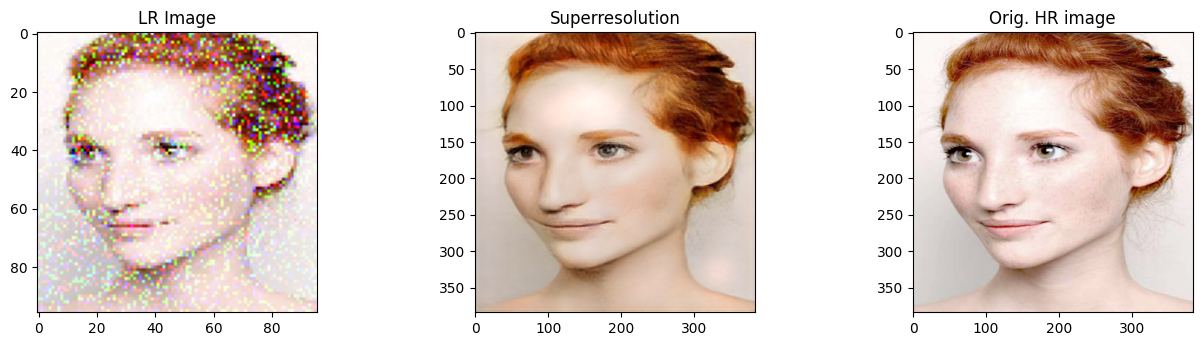

In [30]:
[X1, X2] = [lr_images, hr_images]
# select random example
#desired_index = 10 
ix = randint(0, 10,1)
src_image, tar_image = X1[ix], X2[ix]
src_image_batch = np.expand_dims(src_image, axis=0)
# generate image from source
gen_image = generator.predict(src_image)
# Convert HR image from normalized range back to [0, 255]
output_dir = "G:\\Uday Files\\capstone dataset\\classification\\Colin_Powell_sample7/"  # Replace 'path_to_output_directory' with the actual path to your output directory for saving predicted HR image



# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()
